# R Notebook: CMIP5 Wet Spell Length Distributions, 1981-2010

Wet state, spell length for PRISM data.

Uses R to do some analysis

Add in the part to make a DataFrame with our best fit negative binomial parameters and then to output this to a spreadsheet

## Parameters and Library Loading

In [1]:
oldw <- getOption("warn")

In [2]:
options(warn = -1)

In [3]:
library(feather)
library(dplyr)
library(fitdistrplus)
library(vcd)
library(dgof)
library(xlsx)
library(r2excel)
library(moments)
library(stringr)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Loading required package: survival
Loading required package: npsurv
Loading required package: lsei
Loading required package: grid

Attaching package: 'dgof'

The following object is masked from 'package:stats':

    ks.test



**Note:** We only want to mask package:stats ks.test with that from package:dgof when working with discrete distributions.

In [4]:
setwd("\\\\augustine.space.swri.edu\\jdrive\\Groundwater\\R8937_Stochastic_CC_Recharge\\Data\\R\\Working\\CMIP5_1981_WetDays")

Now specify some parameters - just file names

In [5]:
feWPath <- "WetDays_CMIP5_1981-2010.feather"

In [6]:
LOCA_BREAK <- 168

## Initial Load and Process of DataFrame

In [7]:
dfWet <- read_feather(feWPath)
ddates <- as.Date( ISOdate( dfWet$Year, dfWet$Month, dfWet$Day ) )
dfWet["Date"] <- ddates

In [8]:
str(dfWet)

Classes 'tbl_df', 'tbl' and 'data.frame':	23161112 obs. of  76 variables:
 $ MGrid_Id   : chr  "M100_169" "M100_169" "M100_169" "M100_169" ...
 $ Year       : num  1981 1981 1981 1981 1981 ...
 $ Month      : num  1 1 1 1 1 2 2 2 3 3 ...
 $ Day        : num  2 7 14 24 27 8 12 28 2 6 ...
 $ Wet_Count  : num  2 6 4 2 1 2 1 1 2 3 ...
 $ Total_Depth: num  11.387 15.536 6.076 3.113 0.895 ...
 $ Day_1      : num  10.223 0.964 0.608 0.301 0.895 ...
 $ Day_2      : num  1.164 0.696 4.903 2.812 0 ...
 $ Day_3      : num  0 0.359 0.277 0 0 ...
 $ Day_4      : num  0 10.082 0.288 0 0 ...
 $ Day_5      : num  0 1.16 0 0 0 ...
 $ Day_6      : num  0 2.27 0 0 0 ...
 $ Day_7      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_8      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_9      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_10     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_11     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_12     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_13     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_14     : num  0 0 

In [9]:
head(dfWet)

MGrid_Id,Year,Month,Day,Wet_Count,Total_Depth,Day_1,Day_2,Day_3,Day_4,...,Day_61,Day_62,Day_63,Day_64,Day_65,Day_66,Day_67,Day_68,Day_69,Date
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
M100_169,1981,1,2,2,11.3870797,10.2229748,1.1641049,0.0000000,0.0000000,...,0,0,0,0,0,0,0,0,0,1981-01-02
M100_169,1981,1,7,6,15.5357266,0.9643778,0.6963154,0.3588112,10.0815992,...,0,0,0,0,0,0,0,0,0,1981-01-07
M100_169,1981,1,14,4,6.0755340,0.6076774,4.9030194,0.2769156,0.2879216,...,0,0,0,0,0,0,0,0,0,1981-01-14
M100_169,1981,1,24,2,3.1134394,0.3010834,2.8123560,0.0000000,0.0000000,...,0,0,0,0,0,0,0,0,0,1981-01-24
M100_169,1981,1,27,1,0.8947607,0.8947607,0.0000000,0.0000000,0.0000000,...,0,0,0,0,0,0,0,0,0,1981-01-27
M100_169,1981,2,8,2,1.4057036,1.0752722,0.3304314,0.0000000,0.0000000,...,0,0,0,0,0,0,0,0,0,1981-02-08


Get the Grid_Id from the MGrid_Id string

In [10]:
exGridID <- function(smgrid) {
    sNum <- str_split( smgrid, pattern="_")[[1]][2]
    aNum <- as.integer( sNum )
    return(aNum)
}

In [11]:
Grid_Id <- sapply( dfWet$MGrid_Id, exGridID )

In [12]:
dfWet <- cbind( dfWet, Grid_Id )

In [13]:
str(dfWet)

'data.frame':	23161112 obs. of  77 variables:
 $ MGrid_Id   : chr  "M100_169" "M100_169" "M100_169" "M100_169" ...
 $ Year       : num  1981 1981 1981 1981 1981 ...
 $ Month      : num  1 1 1 1 1 2 2 2 3 3 ...
 $ Day        : num  2 7 14 24 27 8 12 28 2 6 ...
 $ Wet_Count  : num  2 6 4 2 1 2 1 1 2 3 ...
 $ Total_Depth: num  11.387 15.536 6.076 3.113 0.895 ...
 $ Day_1      : num  10.223 0.964 0.608 0.301 0.895 ...
 $ Day_2      : num  1.164 0.696 4.903 2.812 0 ...
 $ Day_3      : num  0 0.359 0.277 0 0 ...
 $ Day_4      : num  0 10.082 0.288 0 0 ...
 $ Day_5      : num  0 1.16 0 0 0 ...
 $ Day_6      : num  0 2.27 0 0 0 ...
 $ Day_7      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_8      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_9      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_10     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_11     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_12     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_13     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_14     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_1

In [14]:
head(dfWet)

MGrid_Id,Year,Month,Day,Wet_Count,Total_Depth,Day_1,Day_2,Day_3,Day_4,...,Day_62,Day_63,Day_64,Day_65,Day_66,Day_67,Day_68,Day_69,Date,Grid_Id
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<int>
M100_169,1981,1,2,2,11.3870797,10.2229748,1.1641049,0.0000000,0.0000000,...,0,0,0,0,0,0,0,0,1981-01-02,169
M100_169,1981,1,7,6,15.5357266,0.9643778,0.6963154,0.3588112,10.0815992,...,0,0,0,0,0,0,0,0,1981-01-07,169
M100_169,1981,1,14,4,6.0755340,0.6076774,4.9030194,0.2769156,0.2879216,...,0,0,0,0,0,0,0,0,1981-01-14,169
M100_169,1981,1,24,2,3.1134394,0.3010834,2.8123560,0.0000000,0.0000000,...,0,0,0,0,0,0,0,0,1981-01-24,169
M100_169,1981,1,27,1,0.8947607,0.8947607,0.0000000,0.0000000,0.0000000,...,0,0,0,0,0,0,0,0,1981-01-27,169
M100_169,1981,2,8,2,1.4057036,1.0752722,0.3304314,0.0000000,0.0000000,...,0,0,0,0,0,0,0,0,1981-02-08,169


In [15]:
tail(dfWet)

,MGrid_Id,Year,Month,Day,Wet_Count,Total_Depth,Day_1,Day_2,Day_3,Day_4,...,Day_62,Day_63,Day_64,Day_65,Day_66,Day_67,Day_68,Day_69,Date,Grid_Id
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<int>
23161107,M9_99,2010,10,31,1,0.4470399,0.4470399,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,2010-10-31,99
23161108,M9_99,2010,11,4,2,19.5473648,18.1295490,1.417816,0.000000,0.000000,...,0,0,0,0,0,0,0,0,2010-11-04,99
23161109,M9_99,2010,11,13,4,12.6789584,6.0727978,2.549107,2.452477,1.604577,...,0,0,0,0,0,0,0,0,2010-11-13,99
23161110,M9_99,2010,11,29,2,2.0374836,0.3629079,1.674576,0.000000,0.000000,...,0,0,0,0,0,0,0,0,2010-11-29,99
23161111,M9_99,2010,12,9,2,2.9553335,0.2572479,2.698086,0.000000,0.000000,...,0,0,0,0,0,0,0,0,2010-12-09,99
23161112,M9_99,2010,12,29,2,50.7182236,32.5279083,18.190315,0.000000,0.000000,...,0,0,0,0,0,0,0,0,2010-12-29,99


Now need to filter or split by grid ID to get our LOCA and BCCA data sets.

In [16]:
dfLOWet <- dfWet %>% filter( Grid_Id <= LOCA_BREAK )
dfBCWet <- dfWet %>% filter( Grid_Id > LOCA_BREAK )

First filter for each month with all Grid_Id

In [17]:
dLOJan <- dfLOWet %>% filter( Month == 1 )
dLOFeb <- dfLOWet %>% filter( Month == 2 )
dLOMar <- dfLOWet %>% filter( Month == 3 )
dLOApr <- dfLOWet %>% filter( Month == 4 )
dLOMay <- dfLOWet %>% filter( Month == 5 )
dLOJun <- dfLOWet %>% filter( Month == 6 )
dLOJul <- dfLOWet %>% filter( Month == 7 )
dLOAug <- dfLOWet %>% filter( Month == 8 )
dLOSep <- dfLOWet %>% filter( Month == 9 )
dLOOct <- dfLOWet %>% filter( Month == 10 )
dLONov <- dfLOWet %>% filter( Month == 11 )
dLODec <- dfLOWet %>% filter( Month == 12 )

In [18]:
dBCJan <- dfBCWet %>% filter( Month == 1 )
dBCFeb <- dfBCWet %>% filter( Month == 2 )
dBCMar <- dfBCWet %>% filter( Month == 3 )
dBCApr <- dfBCWet %>% filter( Month == 4 )
dBCMay <- dfBCWet %>% filter( Month == 5 )
dBCJun <- dfBCWet %>% filter( Month == 6 )
dBCJul <- dfBCWet %>% filter( Month == 7 )
dBCAug <- dfBCWet %>% filter( Month == 8 )
dBCSep <- dfBCWet %>% filter( Month == 9 )
dBCOct <- dfBCWet %>% filter( Month == 10 )
dBCNov <- dfBCWet %>% filter( Month == 11 )
dBCDec <- dfBCWet %>% filter( Month == 12 )

Set-up a dataframe to store the basic summary statistics. Eventually will write this to Excel.

In [19]:
MonLOSumStatDF <- data.frame( month=rep(NA,12), mean=rep(NA,12), median=rep(NA,12), 
                            max=rep(NA,12), min=rep(NA,12), stdev=rep(NA,12), var=rep(NA,12),
                            skew=rep(NA,12), kurt=rep(NA,12), perc0=rep(NA,12), perc10=rep(NA,12), 
                            perc20=rep(NA,12), perc30=rep(NA,12), perc40=rep(NA,12), 
                            perc50=rep(NA,12), perc60=rep(NA,12), perc70=rep(NA,12), 
                            perc80=rep(NA,12), perc90=rep(NA,12), perc100=rep(NA,12), 
                            stringsAsFactors=FALSE )

In [20]:
pvec <- seq(0,1,0.1)

In [21]:
NumDeciles = length( pvec )
cat("Number of deciles: ", NumDeciles)

Number of deciles:  11

Now look at summary stats for the Wet day counts for each month

In [22]:
summary( dLOJan$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.862   2.000  13.000 

In [23]:
oQuants = quantile( dLOJan$Wet_Count, pvec )

In [24]:
MonLOSumStatDF[1, ] <-list( 1, mean(dLOJan$Wet_Count), median(dLOJan$Wet_Count), 
                          max(dLOJan$Wet_Count), min(dLOJan$Wet_Count), sd(dLOJan$Wet_Count),
                          var(dLOJan$Wet_Count), skewness(dLOJan$Wet_Count), 
                          kurtosis(dLOJan$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [25]:
summary( dLOFeb$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   1.986   2.000  13.000 

In [26]:
oQuants = quantile( dLOFeb$Wet_Count, pvec )

In [27]:
MonLOSumStatDF[2, ] <-list( 2, mean(dLOFeb$Wet_Count), median(dLOFeb$Wet_Count), 
                          max(dLOFeb$Wet_Count), min(dLOFeb$Wet_Count), sd(dLOFeb$Wet_Count),
                          var(dLOFeb$Wet_Count), skewness(dLOFeb$Wet_Count), 
                          kurtosis(dLOFeb$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [28]:
summary( dLOMar$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.895   2.000  19.000 

In [29]:
oQuants = quantile( dLOMar$Wet_Count, pvec )

In [30]:
MonLOSumStatDF[3, ] <-list( 3, mean(dLOMar$Wet_Count), median(dLOMar$Wet_Count), 
                          max(dLOMar$Wet_Count), min(dLOMar$Wet_Count), sd(dLOMar$Wet_Count),
                          var(dLOMar$Wet_Count), skewness(dLOMar$Wet_Count), 
                          kurtosis(dLOMar$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [31]:
summary( dLOApr$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.302   3.000  25.000 

In [32]:
oQuants = quantile( dLOApr$Wet_Count, pvec )

In [33]:
MonLOSumStatDF[4, ] <-list( 4, mean(dLOApr$Wet_Count), median(dLOApr$Wet_Count), 
                          max(dLOApr$Wet_Count), min(dLOApr$Wet_Count), sd(dLOApr$Wet_Count),
                          var(dLOApr$Wet_Count), skewness(dLOApr$Wet_Count), 
                          kurtosis(dLOApr$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [34]:
summary( dLOMay$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.692   3.000  37.000 

In [35]:
oQuants = quantile( dLOMay$Wet_Count, pvec )

In [36]:
MonLOSumStatDF[5, ] <-list( 5, mean(dLOMay$Wet_Count), median(dLOMay$Wet_Count), 
                          max(dLOMay$Wet_Count), min(dLOMay$Wet_Count), sd(dLOMay$Wet_Count),
                          var(dLOMay$Wet_Count), skewness(dLOMay$Wet_Count), 
                          kurtosis(dLOMay$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [37]:
summary( dLOJun$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.915   4.000  52.000 

In [38]:
oQuants = quantile( dLOJun$Wet_Count, pvec )

In [39]:
MonLOSumStatDF[6, ] <-list( 6, mean(dLOJun$Wet_Count), median(dLOJun$Wet_Count), 
                          max(dLOJun$Wet_Count), min(dLOJun$Wet_Count), sd(dLOJun$Wet_Count),
                          var(dLOJun$Wet_Count), skewness(dLOJun$Wet_Count), 
                          kurtosis(dLOJun$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [40]:
summary( dLOJul$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.626   3.000  39.000 

In [41]:
oQuants = quantile( dLOJul$Wet_Count, pvec )

In [42]:
MonLOSumStatDF[7, ] <-list( 7, mean(dLOJul$Wet_Count), median(dLOJul$Wet_Count), 
                          max(dLOJul$Wet_Count), min(dLOJul$Wet_Count), sd(dLOJul$Wet_Count),
                          var(dLOJul$Wet_Count), skewness(dLOJul$Wet_Count), 
                          kurtosis(dLOJul$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [43]:
summary( dLOAug$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.621   3.000  30.000 

In [44]:
oQuants = quantile( dLOAug$Wet_Count, pvec )

In [45]:
MonLOSumStatDF[8, ] <-list( 8, mean(dLOAug$Wet_Count), median(dLOAug$Wet_Count), 
                          max(dLOAug$Wet_Count), min(dLOAug$Wet_Count), sd(dLOAug$Wet_Count),
                          var(dLOAug$Wet_Count), skewness(dLOAug$Wet_Count), 
                          kurtosis(dLOAug$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [46]:
summary( dLOSep$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.00    2.00    2.93    4.00   31.00 

In [47]:
oQuants = quantile( dLOSep$Wet_Count, pvec )

In [48]:
MonLOSumStatDF[9, ] <-list( 9, mean(dLOSep$Wet_Count), median(dLOSep$Wet_Count), 
                          max(dLOSep$Wet_Count), min(dLOSep$Wet_Count), sd(dLOSep$Wet_Count),
                          var(dLOSep$Wet_Count), skewness(dLOSep$Wet_Count), 
                          kurtosis(dLOSep$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [49]:
summary( dLOOct$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.497   3.000  19.000 

In [50]:
oQuants = quantile( dLOOct$Wet_Count, pvec )

In [51]:
MonLOSumStatDF[10, ] <-list( 10, mean(dLOOct$Wet_Count), median(dLOOct$Wet_Count), 
                          max(dLOOct$Wet_Count), min(dLOOct$Wet_Count), sd(dLOOct$Wet_Count),
                          var(dLOOct$Wet_Count), skewness(dLOOct$Wet_Count), 
                          kurtosis(dLOOct$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [52]:
summary( dLONov$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.108   3.000  17.000 

In [53]:
oQuants = quantile( dLONov$Wet_Count, pvec )

In [54]:
MonLOSumStatDF[11, ] <-list( 11, mean(dLONov$Wet_Count), median(dLONov$Wet_Count), 
                          max(dLONov$Wet_Count), min(dLONov$Wet_Count), sd(dLONov$Wet_Count),
                          var(dLONov$Wet_Count), skewness(dLONov$Wet_Count), 
                          kurtosis(dLONov$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [55]:
summary( dLODec$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.893   2.000  14.000 

In [56]:
oQuants = quantile( dLODec$Wet_Count, pvec )

In [57]:
MonLOSumStatDF[12, ] <-list( 12, mean(dLODec$Wet_Count), median(dLODec$Wet_Count), 
                          max(dLODec$Wet_Count), min(dLODec$Wet_Count), sd(dLODec$Wet_Count),
                          var(dLODec$Wet_Count), skewness(dLODec$Wet_Count), 
                          kurtosis(dLODec$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [58]:
print( MonLOSumStatDF, quote=FALSE, row.names=FALSE )

 month     mean median max min    stdev      var     skew      kurt perc0
     1 1.862078      1  13   1 1.175376 1.381509 1.925445  8.402178     1
     2 1.986150      2  13   1 1.279277 1.636549 2.056741  9.664452     1
     3 1.894751      1  19   1 1.271727 1.617289 2.384741 12.763932     1
     4 2.301874      2  25   1 1.786154 3.190345 2.604537 14.166039     1
     5 2.692112      2  37   1 2.216342 4.912171 2.572169 15.513491     1
     6 2.915002      2  52   1 2.491535 6.207747 2.542491 13.916105     1
     7 2.626201      2  39   1 2.295909 5.271199 2.745888 16.661360     1
     8 2.621325      2  30   1 2.213151 4.898037 2.432504 11.975597     1
     9 2.929591      2  31   1 2.457712 6.040351 2.200696  9.787042     1
    10 2.497473      2  19   1 1.850971 3.426094 2.017413  8.918957     1
    11 2.108261      2  17   1 1.454277 2.114921 2.115461 10.083636     1
    12 1.892896      1  14   1 1.250880 1.564701 2.046320  8.848351     1
 perc10 perc20 perc30 perc40 perc50 pe

BCCA

In [59]:
MonBCSumStatDF <- data.frame( month=rep(NA,12), mean=rep(NA,12), median=rep(NA,12), 
                            max=rep(NA,12), min=rep(NA,12), stdev=rep(NA,12), var=rep(NA,12),
                            skew=rep(NA,12), kurt=rep(NA,12), perc0=rep(NA,12), perc10=rep(NA,12), 
                            perc20=rep(NA,12), perc30=rep(NA,12), perc40=rep(NA,12), 
                            perc50=rep(NA,12), perc60=rep(NA,12), perc70=rep(NA,12), 
                            perc80=rep(NA,12), perc90=rep(NA,12), perc100=rep(NA,12), 
                            stringsAsFactors=FALSE )

Now look at summary stats for the Wet day counts for each month

In [60]:
summary( dBCJan$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   1.993   2.000  16.000 

In [61]:
oQuants = quantile( dBCJan$Wet_Count, pvec )

In [62]:
MonBCSumStatDF[1, ] <-list( 1, mean(dBCJan$Wet_Count), median(dBCJan$Wet_Count), 
                          max(dBCJan$Wet_Count), min(dBCJan$Wet_Count), sd(dBCJan$Wet_Count),
                          var(dBCJan$Wet_Count), skewness(dBCJan$Wet_Count), 
                          kurtosis(dBCJan$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [63]:
summary( dBCFeb$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.037   3.000  20.000 

In [64]:
oQuants = quantile( dBCFeb$Wet_Count, pvec )

In [65]:
MonBCSumStatDF[2, ] <-list( 2, mean(dBCFeb$Wet_Count), median(dBCFeb$Wet_Count), 
                          max(dBCFeb$Wet_Count), min(dBCFeb$Wet_Count), sd(dBCFeb$Wet_Count),
                          var(dBCFeb$Wet_Count), skewness(dBCFeb$Wet_Count), 
                          kurtosis(dBCFeb$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [66]:
summary( dBCMar$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.027   3.000  20.000 

In [67]:
oQuants = quantile( dBCMar$Wet_Count, pvec )

In [68]:
MonBCSumStatDF[3, ] <-list( 3, mean(dBCMar$Wet_Count), median(dBCMar$Wet_Count), 
                          max(dBCMar$Wet_Count), min(dBCMar$Wet_Count), sd(dBCMar$Wet_Count),
                          var(dBCMar$Wet_Count), skewness(dBCMar$Wet_Count), 
                          kurtosis(dBCMar$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [69]:
summary( dBCApr$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.463   3.000  37.000 

In [70]:
oQuants = quantile( dBCApr$Wet_Count, pvec )

In [71]:
MonBCSumStatDF[4, ] <-list( 4, mean(dBCApr$Wet_Count), median(dBCApr$Wet_Count), 
                          max(dBCApr$Wet_Count), min(dBCApr$Wet_Count), sd(dBCApr$Wet_Count),
                          var(dBCApr$Wet_Count), skewness(dBCApr$Wet_Count), 
                          kurtosis(dBCApr$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [72]:
summary( dBCMay$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   3.192   4.000  66.000 

In [73]:
oQuants = quantile( dBCMay$Wet_Count, pvec )

In [74]:
MonBCSumStatDF[5, ] <-list( 5, mean(dBCMay$Wet_Count), median(dBCMay$Wet_Count), 
                          max(dBCMay$Wet_Count), min(dBCMay$Wet_Count), sd(dBCMay$Wet_Count),
                          var(dBCMay$Wet_Count), skewness(dBCMay$Wet_Count), 
                          kurtosis(dBCMay$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [75]:
summary( dBCJun$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.874   4.000  69.000 

In [76]:
oQuants = quantile( dBCJun$Wet_Count, pvec )

In [77]:
MonBCSumStatDF[6, ] <-list( 6, mean(dBCJun$Wet_Count), median(dBCJun$Wet_Count), 
                          max(dBCJun$Wet_Count), min(dBCJun$Wet_Count), sd(dBCJun$Wet_Count),
                          var(dBCJun$Wet_Count), skewness(dBCJun$Wet_Count), 
                          kurtosis(dBCJun$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [78]:
summary( dBCJul$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.00    2.00    2.67    3.00   54.00 

In [79]:
oQuants = quantile( dBCJul$Wet_Count, pvec )

In [80]:
MonBCSumStatDF[7, ] <-list( 7, mean(dBCJul$Wet_Count), median(dBCJul$Wet_Count), 
                          max(dBCJul$Wet_Count), min(dBCJul$Wet_Count), sd(dBCJul$Wet_Count),
                          var(dBCJul$Wet_Count), skewness(dBCJul$Wet_Count), 
                          kurtosis(dBCJul$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [81]:
summary( dBCAug$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.00    2.00    2.88    4.00   49.00 

In [82]:
oQuants = quantile( dBCAug$Wet_Count, pvec )

In [83]:
MonBCSumStatDF[8, ] <-list( 8, mean(dBCAug$Wet_Count), median(dBCAug$Wet_Count), 
                          max(dBCAug$Wet_Count), min(dBCAug$Wet_Count), sd(dBCAug$Wet_Count),
                          var(dBCAug$Wet_Count), skewness(dBCAug$Wet_Count), 
                          kurtosis(dBCAug$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [84]:
summary( dBCSep$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   3.055   4.000  37.000 

In [85]:
oQuants = quantile( dBCSep$Wet_Count, pvec )

In [86]:
MonBCSumStatDF[9, ] <-list( 9, mean(dBCSep$Wet_Count), median(dBCSep$Wet_Count), 
                          max(dBCSep$Wet_Count), min(dBCSep$Wet_Count), sd(dBCSep$Wet_Count),
                          var(dBCSep$Wet_Count), skewness(dBCSep$Wet_Count), 
                          kurtosis(dBCSep$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [87]:
summary( dBCOct$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.488   3.000  27.000 

In [88]:
oQuants = quantile( dBCOct$Wet_Count, pvec )

In [89]:
MonBCSumStatDF[10, ] <-list( 10, mean(dBCOct$Wet_Count), median(dBCOct$Wet_Count), 
                          max(dBCOct$Wet_Count), min(dBCOct$Wet_Count), sd(dBCOct$Wet_Count),
                          var(dBCOct$Wet_Count), skewness(dBCOct$Wet_Count), 
                          kurtosis(dBCOct$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [90]:
summary( dBCNov$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.051   3.000  18.000 

In [91]:
oQuants = quantile( dBCNov$Wet_Count, pvec )

In [92]:
MonBCSumStatDF[11, ] <-list( 11, mean(dBCNov$Wet_Count), median(dBCNov$Wet_Count), 
                          max(dBCNov$Wet_Count), min(dBCNov$Wet_Count), sd(dBCNov$Wet_Count),
                          var(dBCNov$Wet_Count), skewness(dBCNov$Wet_Count), 
                          kurtosis(dBCNov$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [93]:
summary( dBCDec$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.964   2.000  18.000 

In [94]:
oQuants = quantile( dBCDec$Wet_Count, pvec )

In [95]:
MonBCSumStatDF[12, ] <-list( 12, mean(dBCDec$Wet_Count), median(dBCDec$Wet_Count), 
                          max(dBCDec$Wet_Count), min(dBCDec$Wet_Count), sd(dBCDec$Wet_Count),
                          var(dBCDec$Wet_Count), skewness(dBCDec$Wet_Count), 
                          kurtosis(dBCDec$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [96]:
print( MonBCSumStatDF, quote=FALSE, row.names=FALSE )

 month     mean median max min    stdev       var     skew      kurt perc0
     1 1.993002      2  16   1 1.393910  1.942985 2.300796 11.551640     1
     2 2.036637      2  20   1 1.404817  1.973510 2.100332 10.034042     1
     3 2.026520      2  20   1 1.474423  2.173922 2.428871 12.414896     1
     4 2.462707      2  37   1 2.295493  5.269287 3.551711 25.779442     1
     5 3.192043      2  66   1 3.191277 10.184247 3.194826 22.803851     1
     6 2.874320      2  69   1 2.828792  8.002063 3.171164 25.886863     1
     7 2.669911      2  54   1 2.718625  7.390922 3.422916 24.036903     1
     8 2.879676      2  49   1 2.890526  8.355140 2.953010 16.778955     1
     9 3.055407      2  37   1 2.814351  7.920571 2.331535 10.924128     1
    10 2.488294      2  27   1 2.099652  4.408539 2.462954 12.514988     1
    11 2.051385      2  18   1 1.450880  2.105054 2.129024  9.895944     1
    12 1.963838      1  18   1 1.358557  1.845678 2.124141  9.708428     1
 perc10 perc20 perc30 per

## Month Distribution Fits

Start out by making distributions using all of the grid cells

There are 4 steps in fitting distributions (Ricci, 2005):

1. Model/function choice: hypothesize families of distributions;
2. Estimate parameters;
3. Evaluate quality of fit;
4. Goodness of fit statistical tests.

We will use the negative binomial distribution, **nbinom**, for the wet and Wet day spell length distributions so #1 is taken care of and we can start with #2.

### Basic Plotting and Analysis

Basic plotting and analysis is to look at discrete histograms, empirial CDFs, and Q-Q plots with theoretical negative binomial distributions for each month. This is to ensure that everything looks exceptable.

Use another value tracking DataFrame here to keep track of sample distribution and theoretical, fitted distribution properties.

In [97]:
LOMonDistDF <- data.frame( month=rep(NA,12), smu=rep(NA,12), ssize=rep(NA,12),
                           sprob=rep(NA,12), tmu=rep(NA,12), tsize=rep(NA,12),
                           pvalue=rep(NA,12), stringsAsFactors=FALSE )

In [98]:
BCMonDistDF <- data.frame( month=rep(NA,12), smu=rep(NA,12), ssize=rep(NA,12),
                           sprob=rep(NA,12), tmu=rep(NA,12), tsize=rep(NA,12),
                           pvalue=rep(NA,12), stringsAsFactors=FALSE )

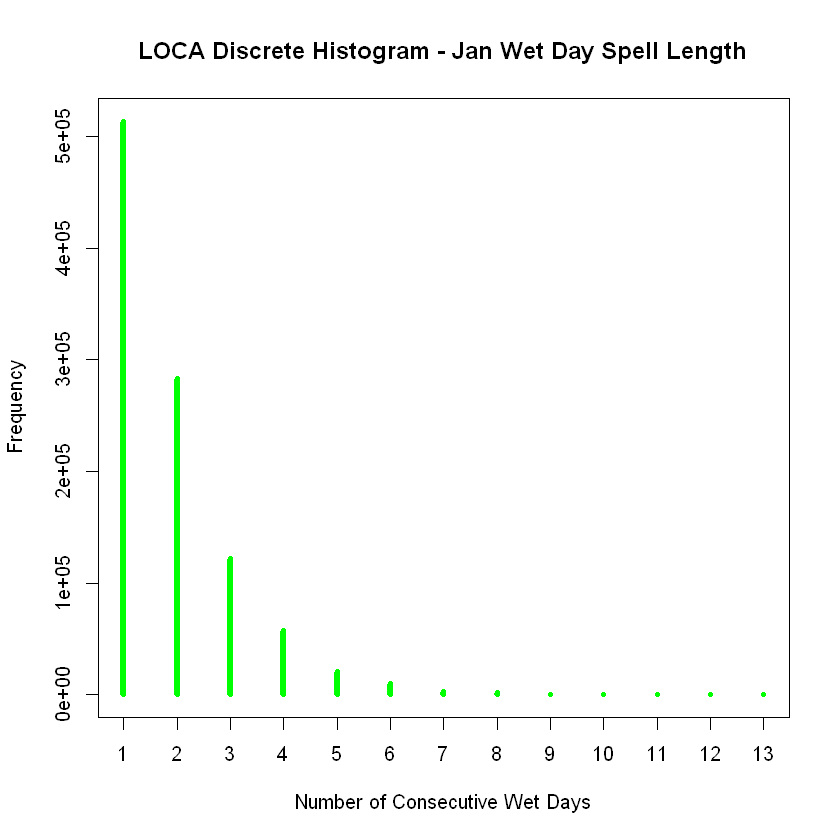

In [99]:
# our case is discrete so use this command
plot( table( dLOJan$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Jan Wet Day Spell Length", 
      col="green" )

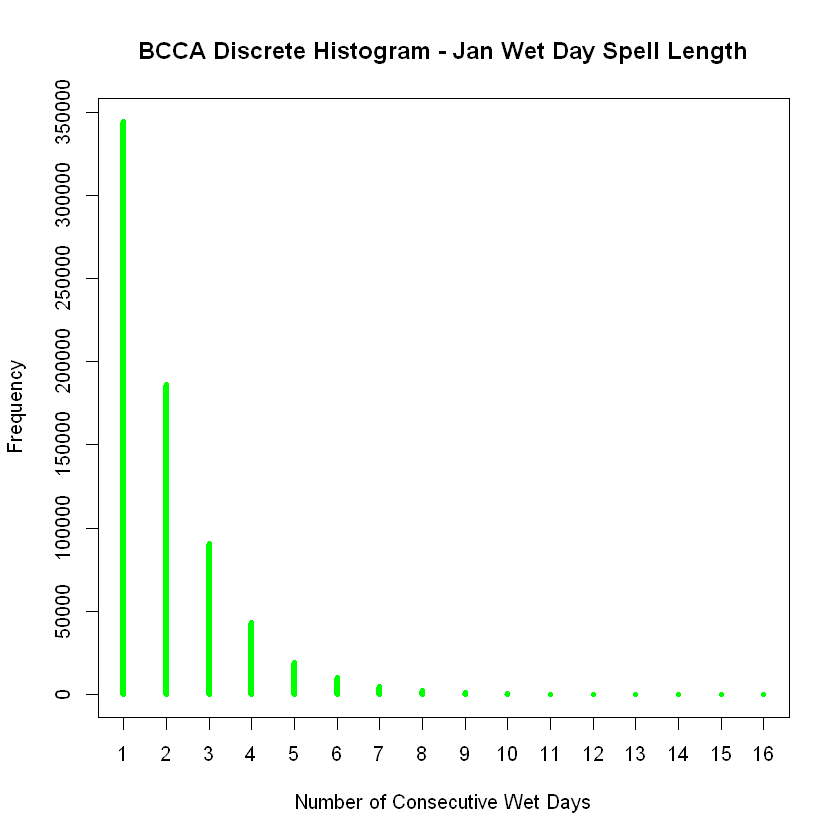

In [100]:
plot( table( dBCJan$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Jan Wet Day Spell Length", 
      col="green" )

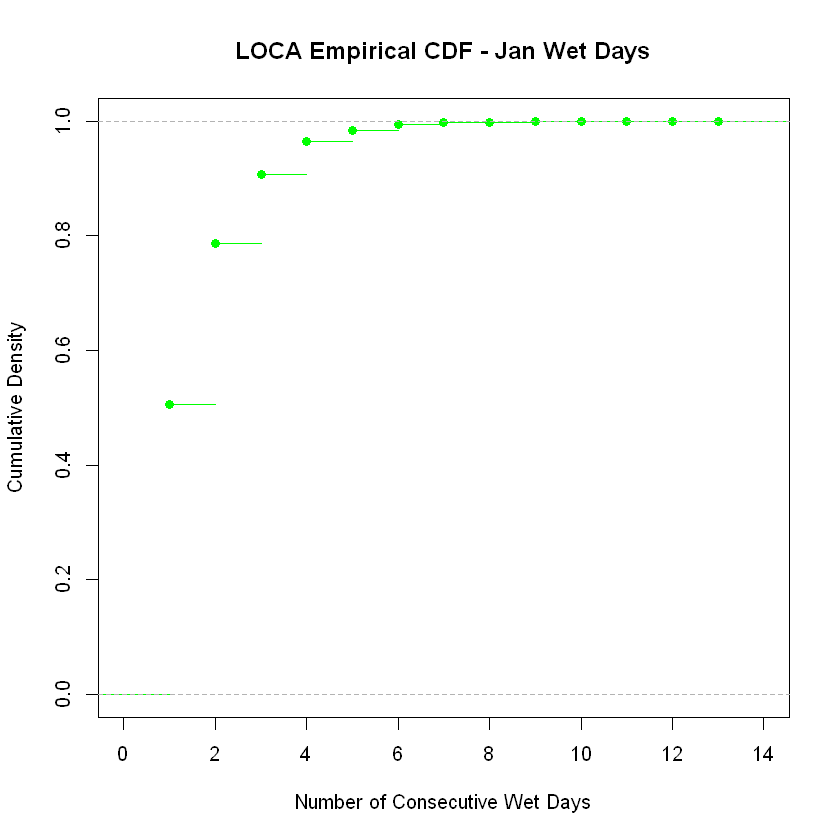

In [101]:
plot(ecdf(dLOJan$Wet_Count), main="LOCA Empirical CDF - Jan Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

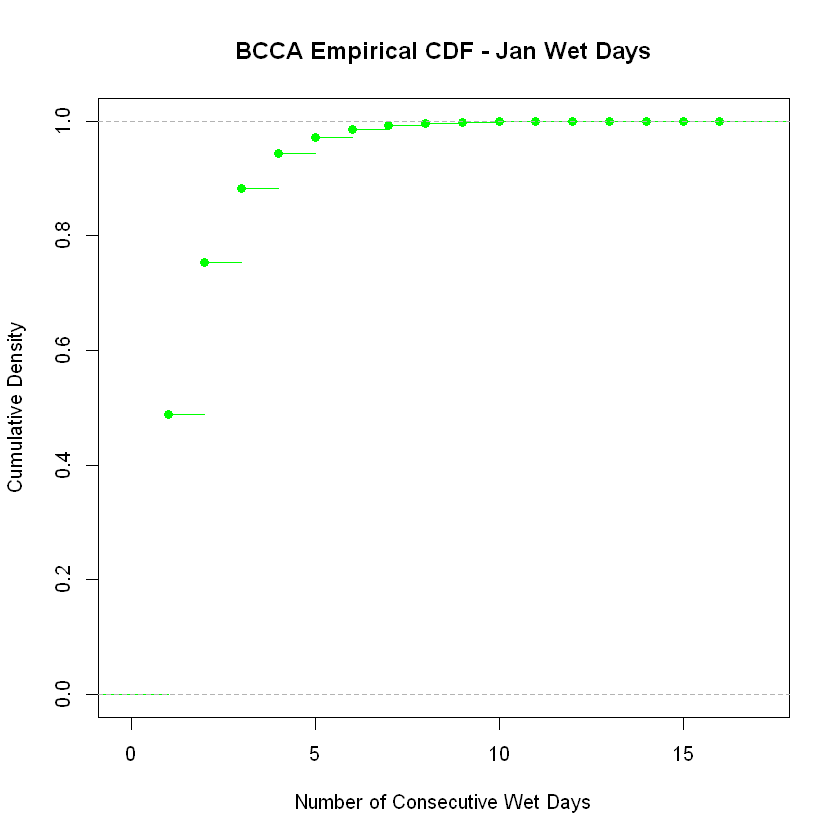

In [102]:
plot(ecdf(dBCJan$Wet_Count), main="BCCA Empirical CDF - Jan Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

In [103]:
dLOJanMax <- max( dLOJan$Wet_Count )
dLOJanMean <- mean( dLOJan$Wet_Count )
dLOJanVar <- var( dLOJan$Wet_Count )
dLOJanBNr <- dLOJanMean^2 / abs(dLOJanVar - dLOJanMean)
dLOJanTstNB <- rnbinom( 1000, mu=dLOJanMean, size=dLOJanBNr )

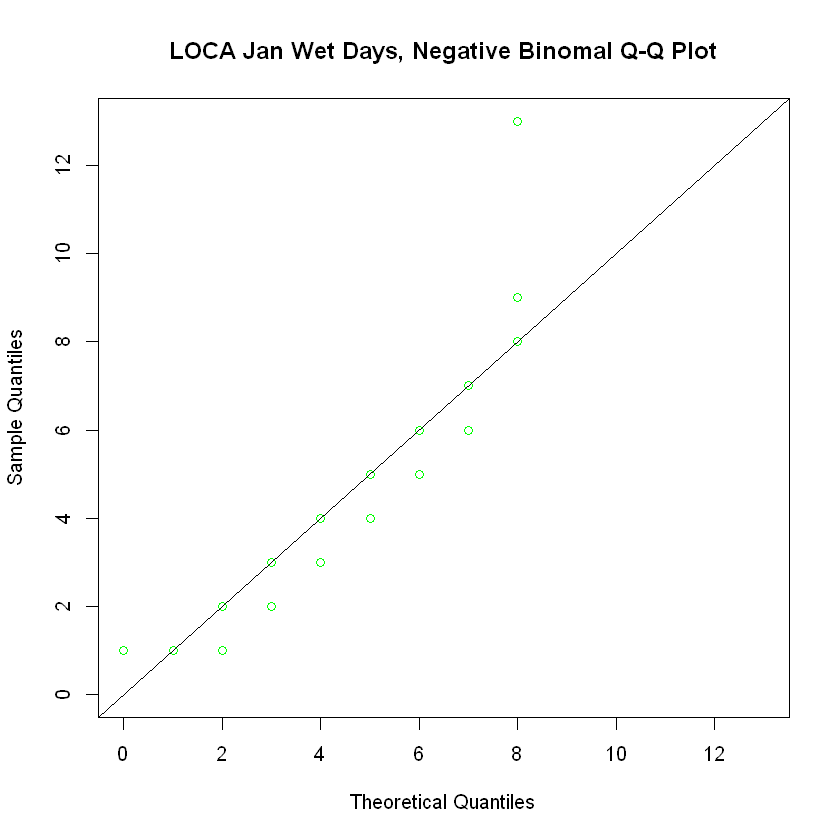

In [104]:
qqplot( dLOJanTstNB, dLOJan$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Jan Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOJanMax), ylim=c(0,dLOJanMax) )
abline( 0, 1)

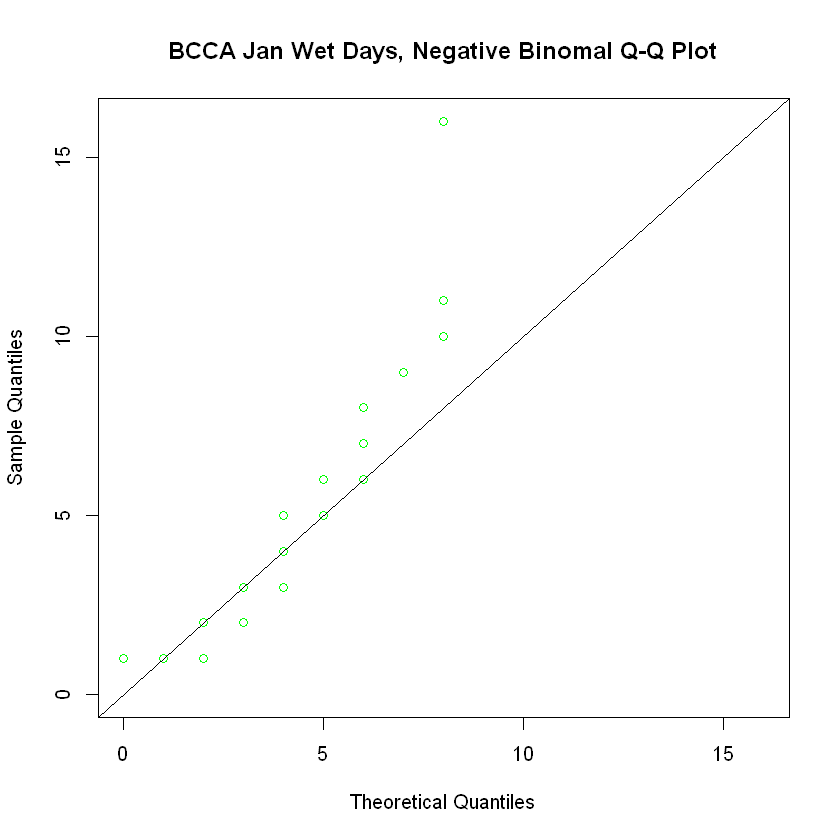

In [105]:
dBCJanMax <- max( dBCJan$Wet_Count )
dBCJanMean <- mean( dBCJan$Wet_Count )
dBCJanVar <- var( dBCJan$Wet_Count )
dBCJanBNr <- dBCJanMean^2 / abs(dBCJanVar - dBCJanMean)
dBCJanTstNB <- rnbinom( 1000, mu=dBCJanMean, size=dBCJanBNr )
qqplot( dBCJanTstNB, dBCJan$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Jan Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCJanMax), ylim=c(0,dBCJanMax) )
abline( 0, 1)

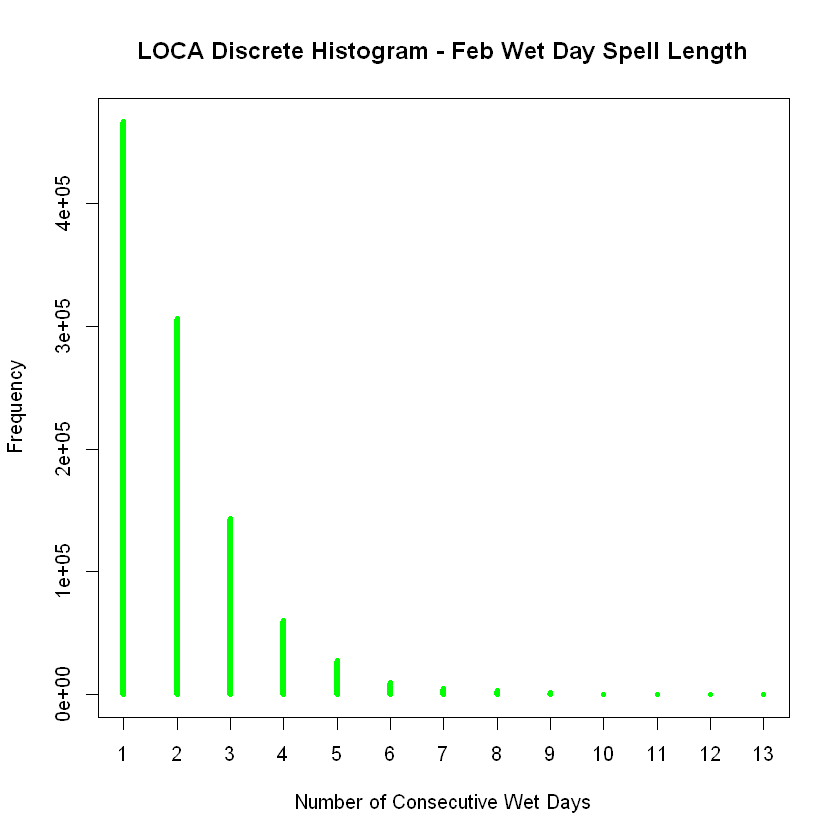

In [106]:
# our case is discrete so use this command
plot( table( dLOFeb$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Feb Wet Day Spell Length", 
      col="green" )

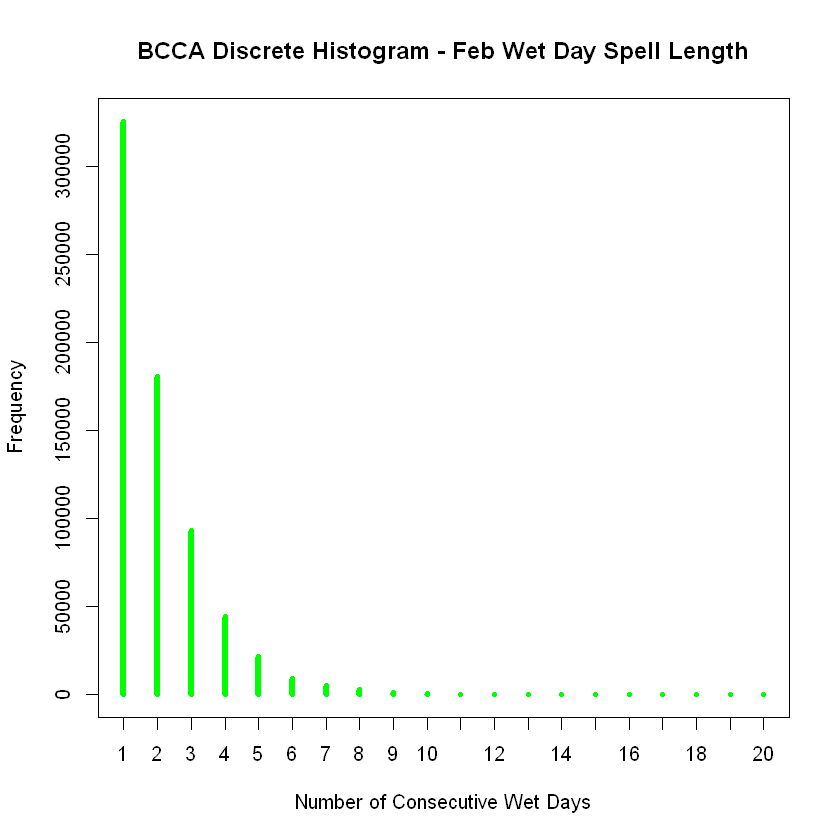

In [107]:
plot( table( dBCFeb$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Feb Wet Day Spell Length", 
      col="green" )

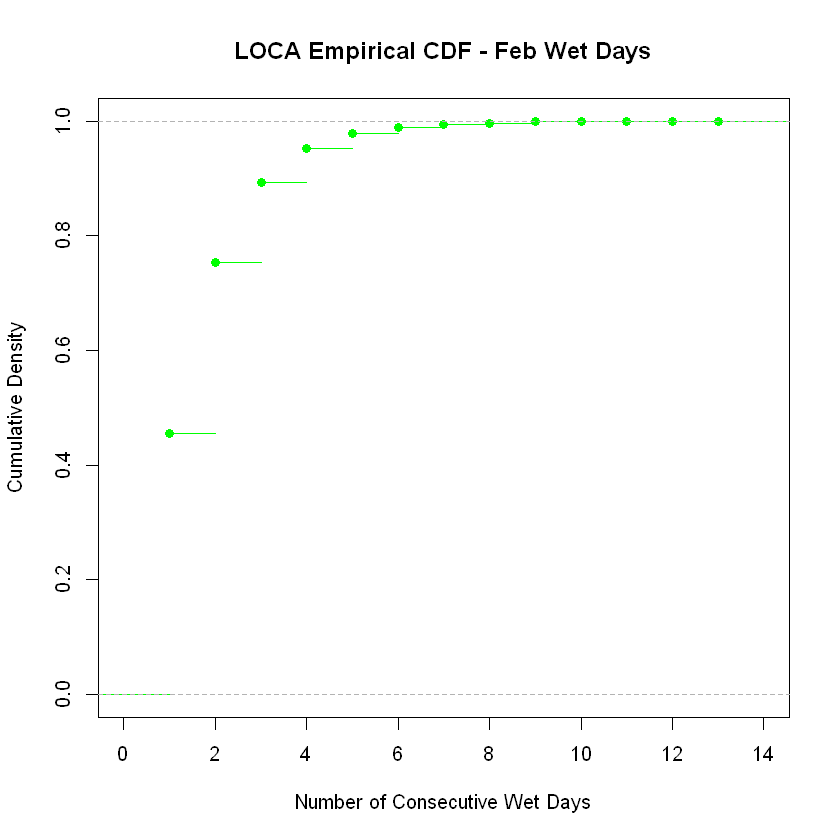

In [108]:
plot(ecdf(dLOFeb$Wet_Count), main="LOCA Empirical CDF - Feb Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

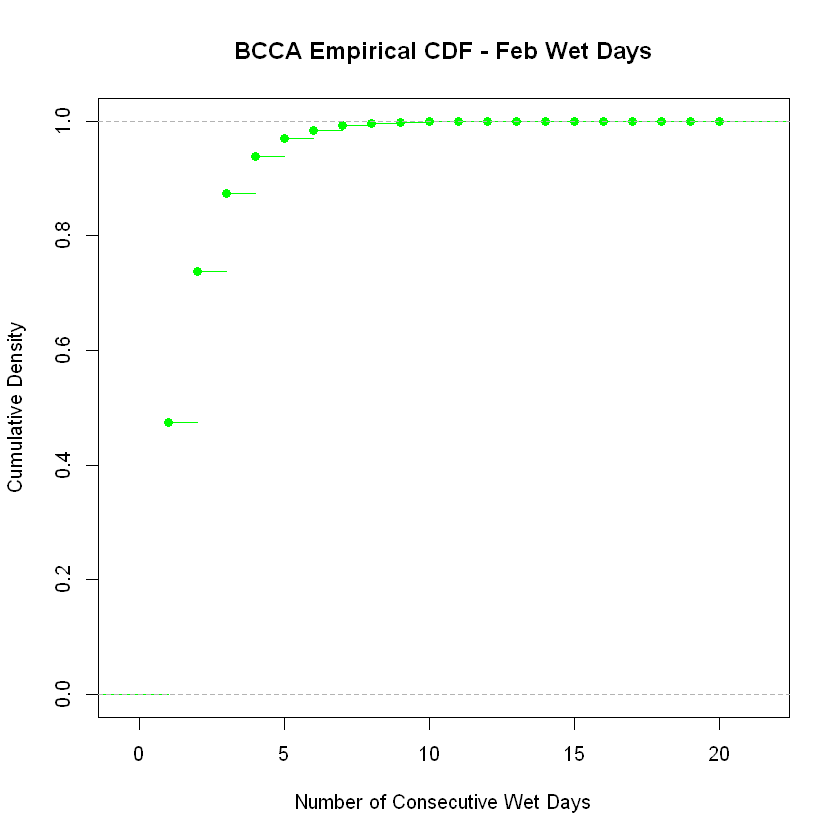

In [109]:
plot(ecdf(dBCFeb$Wet_Count), main="BCCA Empirical CDF - Feb Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

In [110]:
#dLOFeb$Wet_Count

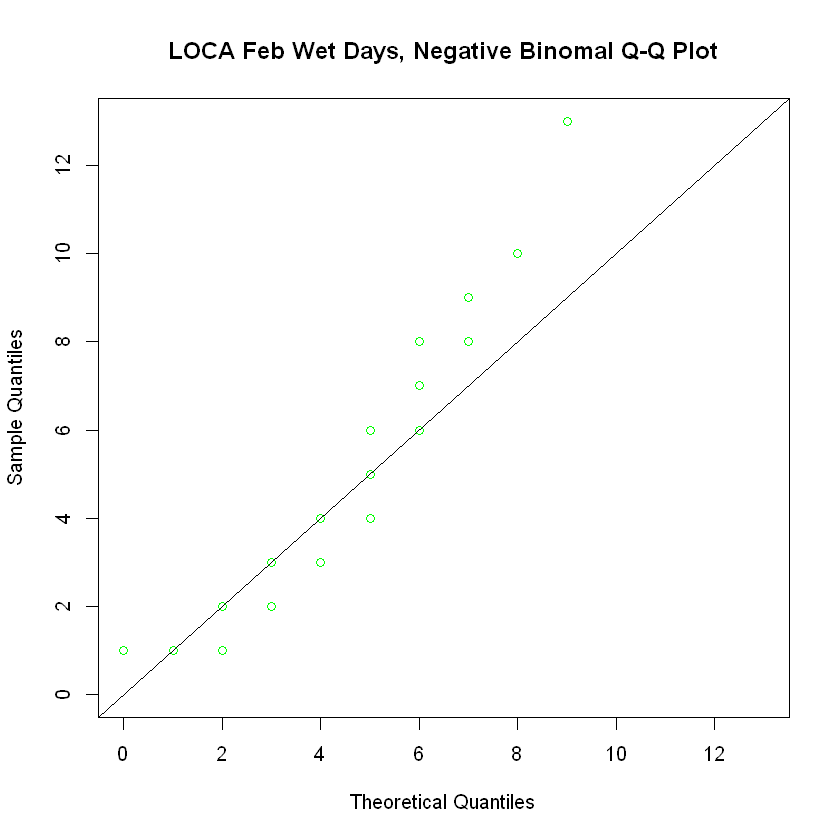

In [111]:
dLOFebMax <- max( dLOFeb$Wet_Count )
dLOFebMean <- mean( dLOFeb$Wet_Count )
dLOFebVar <- var( dLOFeb$Wet_Count )
dLOFebBNr <- dLOFebMean^2 / abs(dLOFebVar - dLOFebMean)
dLOFebTstNB <- rnbinom( 1000, mu=dLOFebMean, size=dLOFebBNr )
qqplot( dLOFebTstNB, dLOFeb$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Feb Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOFebMax), ylim=c(0,dLOFebMax) )
abline( 0, 1)

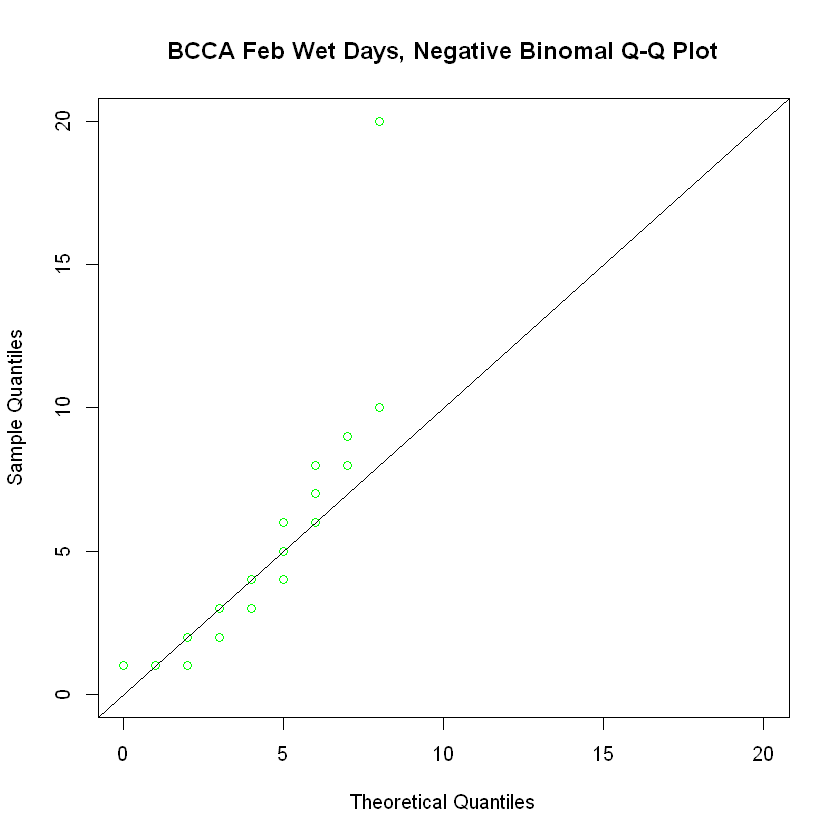

In [112]:
dBCFebMax <- max( dBCFeb$Wet_Count )
dBCFebMean <- mean( dBCFeb$Wet_Count )
dBCFebVar <- var( dBCFeb$Wet_Count )
dBCFebBNr <- dBCFebMean^2 / abs(dBCFebVar - dBCFebMean)
dBCFebTstNB <- rnbinom( 1000, mu=dBCFebMean, size=dBCFebBNr )
qqplot( dBCFebTstNB, dBCFeb$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Feb Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCFebMax), ylim=c(0,dBCFebMax) )
abline( 0, 1)

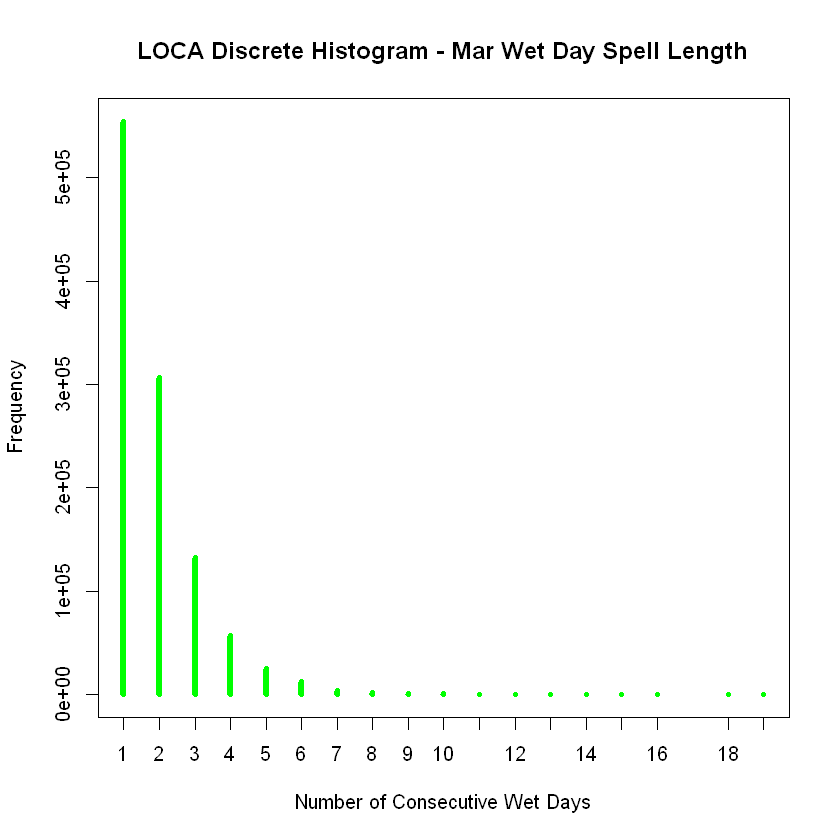

In [113]:
# our case is discrete so use this command
plot( table( dLOMar$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Mar Wet Day Spell Length", 
      col="green" )

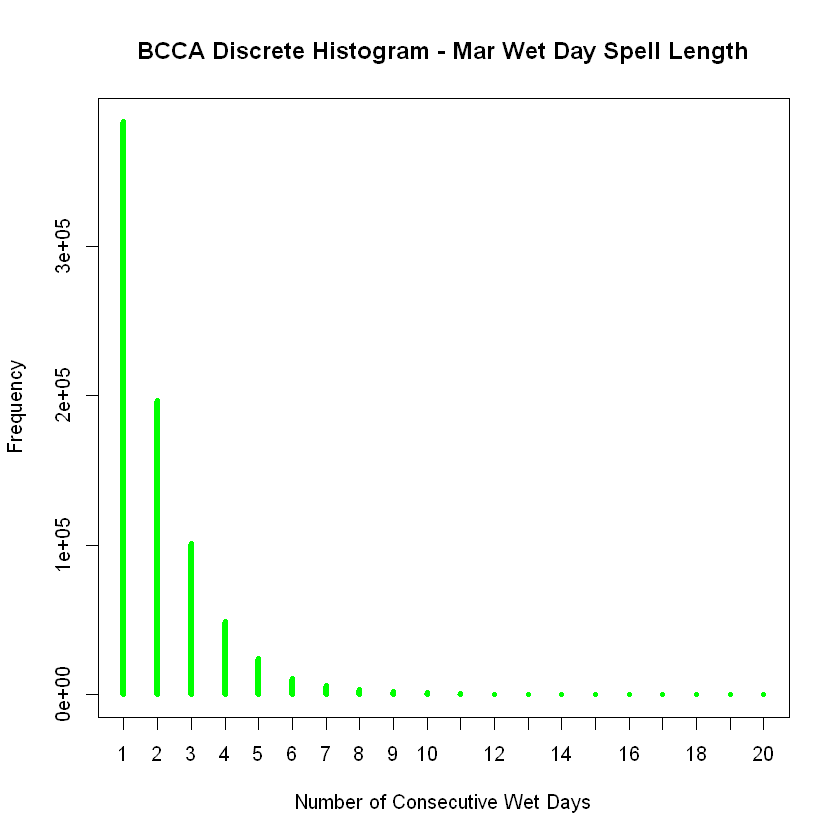

In [114]:
plot( table( dBCMar$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Mar Wet Day Spell Length", 
      col="green" )

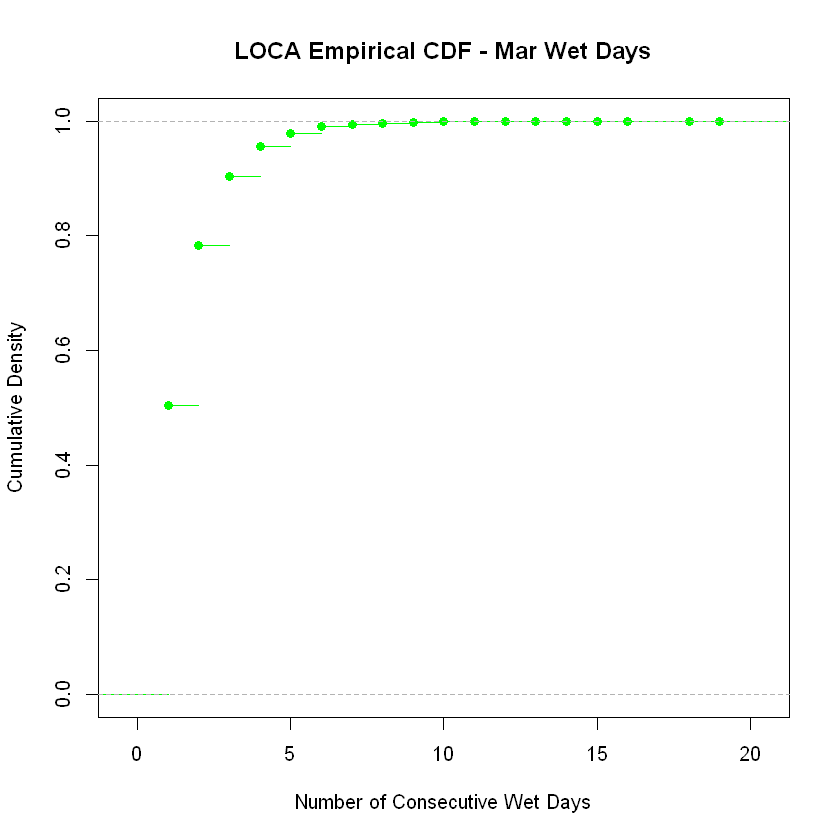

In [115]:
plot(ecdf(dLOMar$Wet_Count), main="LOCA Empirical CDF - Mar Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

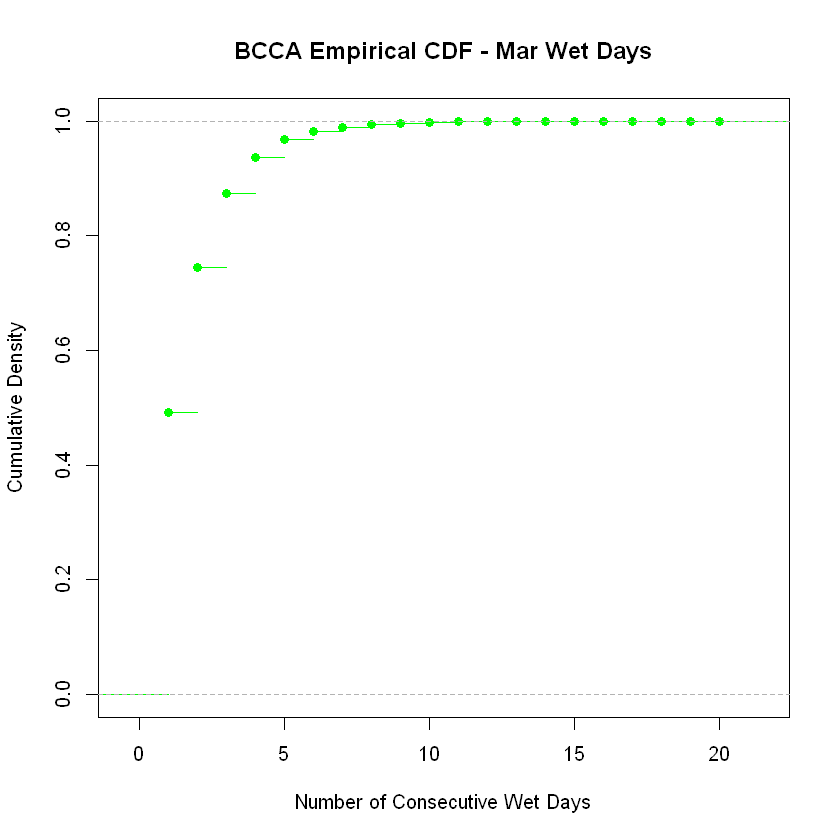

In [116]:
plot(ecdf(dBCMar$Wet_Count), main="BCCA Empirical CDF - Mar Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

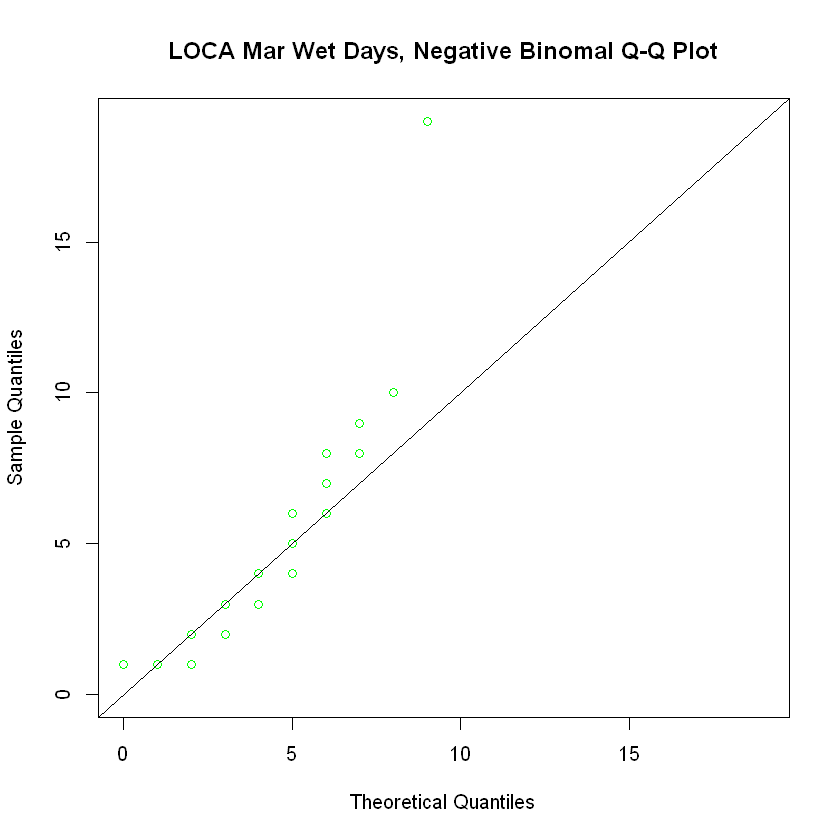

In [117]:
dLOMarMax <- max( dLOMar$Wet_Count )
dLOMarMean <- mean( dLOMar$Wet_Count )
dLOMarVar <- var( dLOMar$Wet_Count )
dLOMarBNr <- dLOMarMean^2 / abs(dLOMarVar - dLOMarMean)
dLOMarTstNB <- rnbinom( 1000, mu=dLOMarMean, size=dLOMarBNr )
qqplot( dLOMarTstNB, dLOMar$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Mar Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOMarMax), ylim=c(0,dLOMarMax) )
abline( 0, 1)

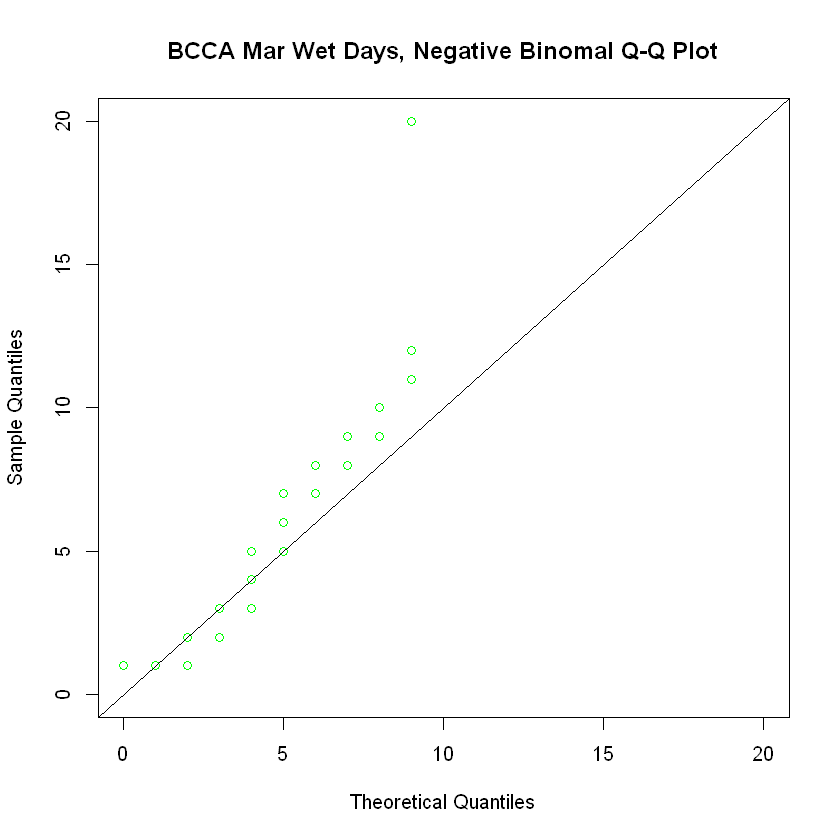

In [118]:
dBCMarMax <- max( dBCMar$Wet_Count )
dBCMarMean <- mean( dBCMar$Wet_Count )
dBCMarVar <- var( dBCMar$Wet_Count )
dBCMarBNr <- dBCMarMean^2 / abs(dBCMarVar - dBCMarMean)
dBCMarTstNB <- rnbinom( 1000, mu=dBCMarMean, size=dBCMarBNr )
qqplot( dBCMarTstNB, dBCMar$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Mar Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCMarMax), ylim=c(0,dBCMarMax) )
abline( 0, 1)

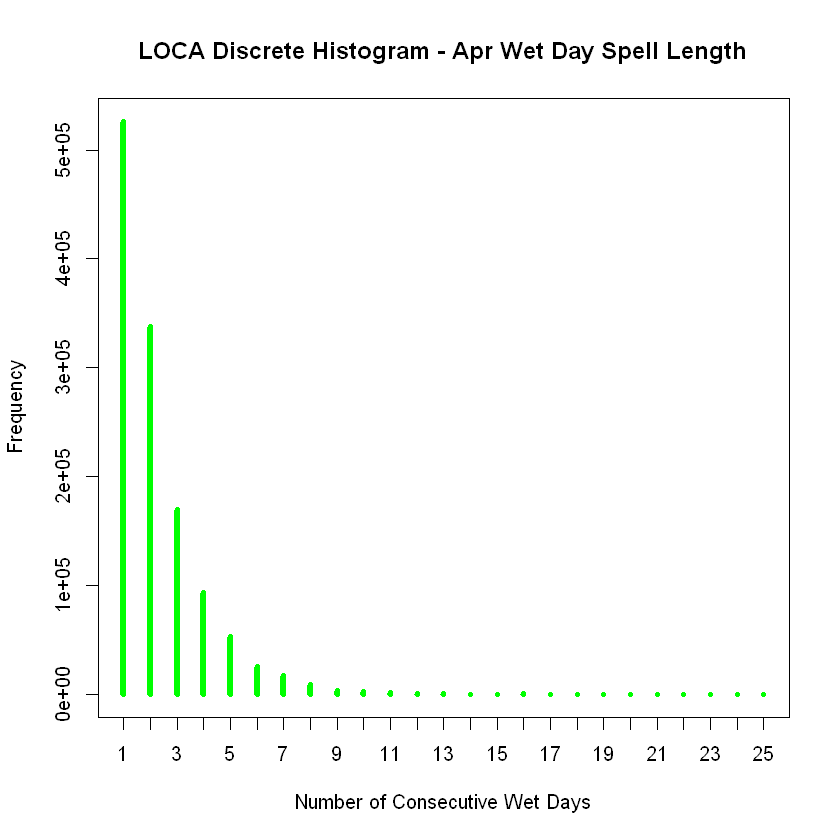

In [119]:
# our case is discrete so use this command
plot( table( dLOApr$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Apr Wet Day Spell Length", 
      col="green" )

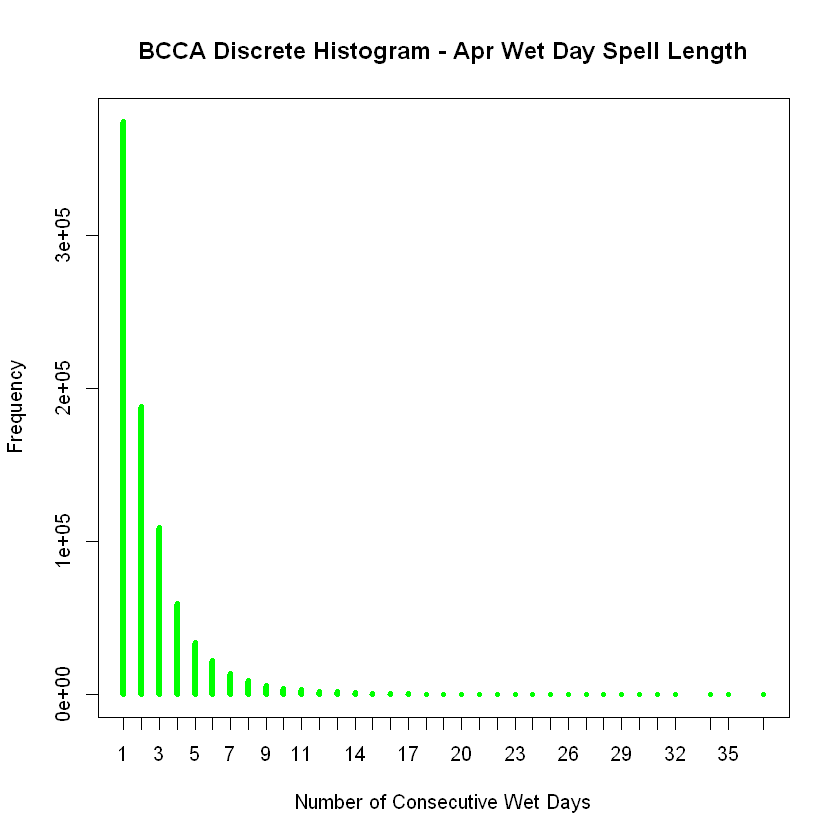

In [120]:
plot( table( dBCApr$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Apr Wet Day Spell Length", 
      col="green" )

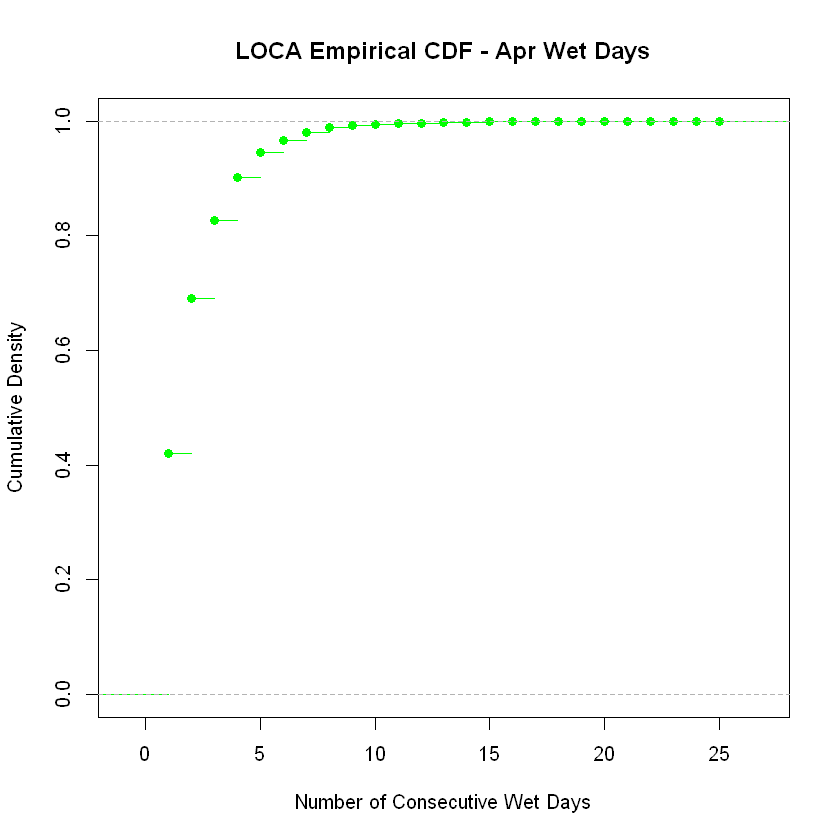

In [121]:
plot(ecdf(dLOApr$Wet_Count), main="LOCA Empirical CDF - Apr Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

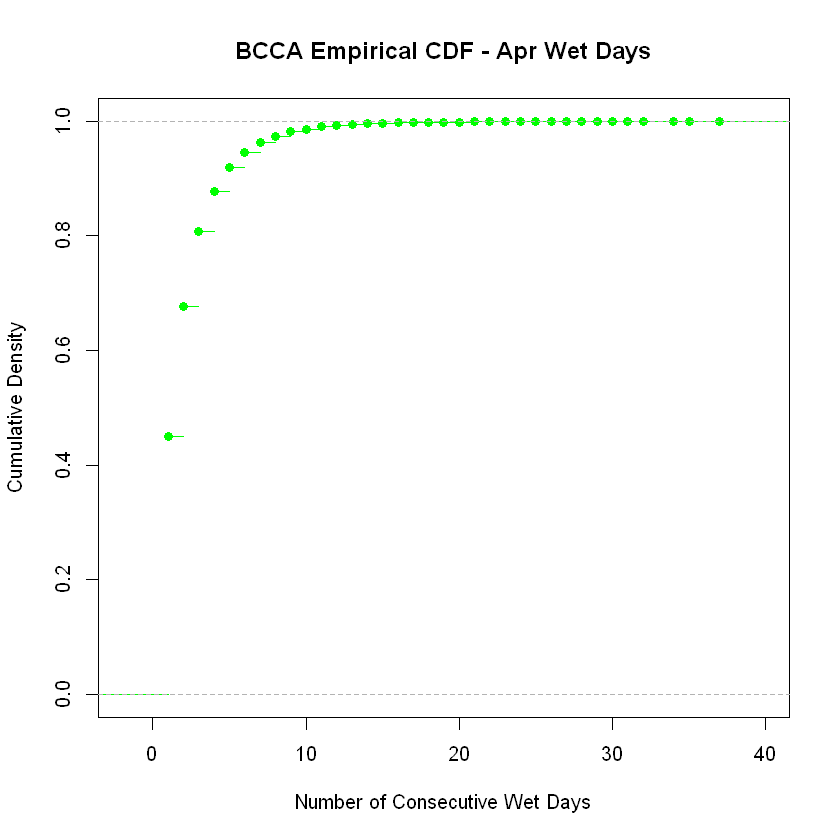

In [122]:
plot(ecdf(dBCApr$Wet_Count), main="BCCA Empirical CDF - Apr Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

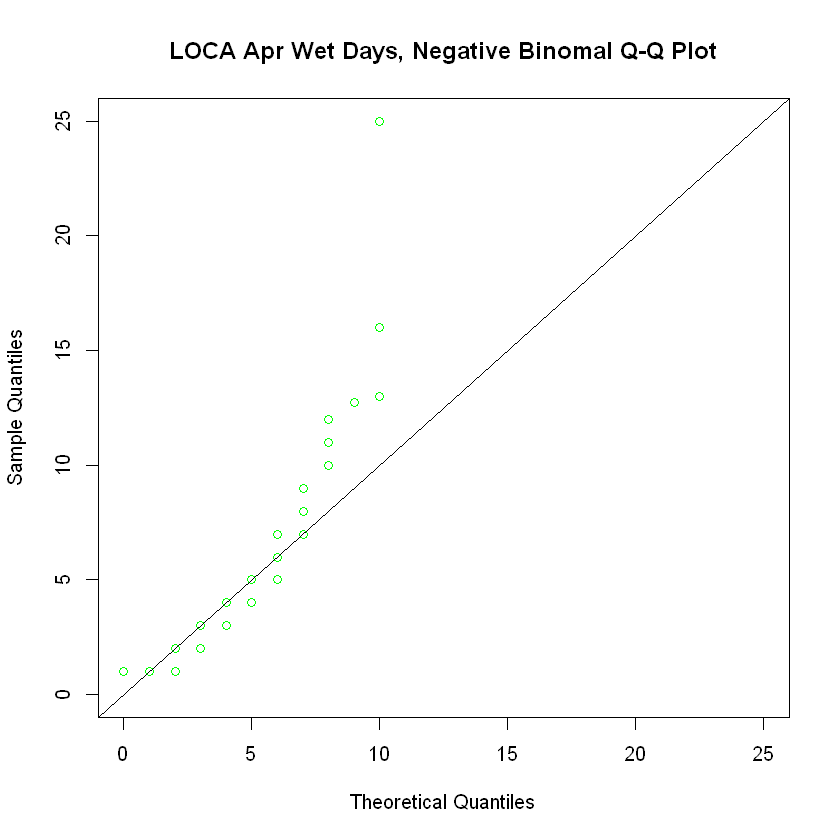

In [123]:
dLOAprMax <- max( dLOApr$Wet_Count )
dLOAprMean <- mean( dLOApr$Wet_Count )
dLOAprVar <- var( dLOApr$Wet_Count )
dLOAprBNr <- dLOAprMean^2 / abs(dLOAprVar - dLOAprMean)
dLOAprTstNB <- rnbinom( 1000, mu=dLOAprMean, size=dLOAprBNr )
qqplot( dLOAprTstNB, dLOApr$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Apr Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOAprMax), ylim=c(0,dLOAprMax) )
abline( 0, 1)

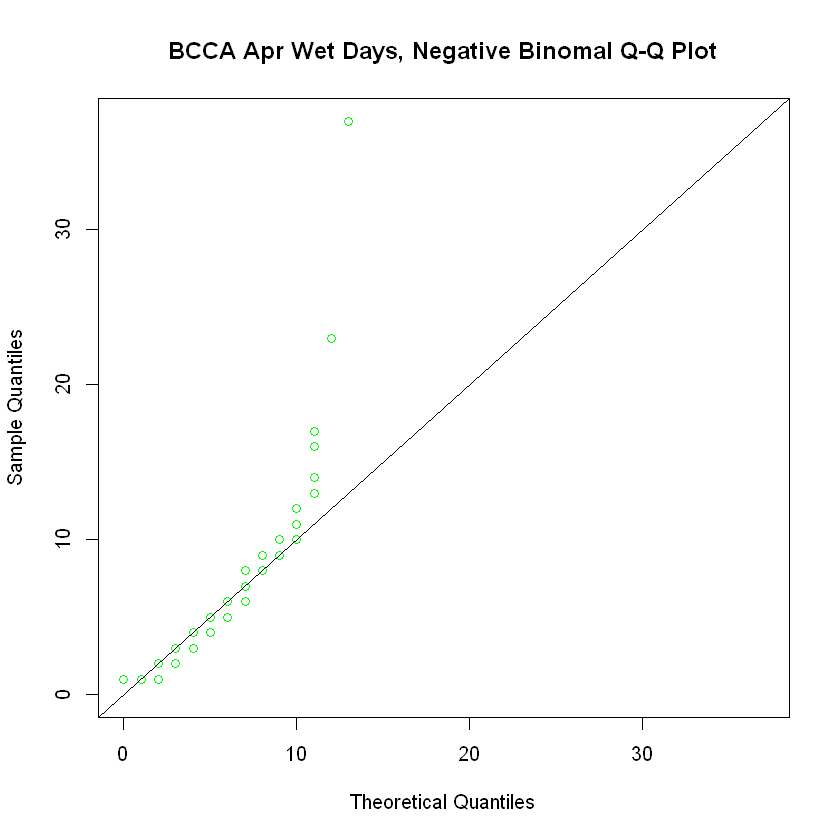

In [124]:
dBCAprMax <- max( dBCApr$Wet_Count )
dBCAprMean <- mean( dBCApr$Wet_Count )
dBCAprVar <- var( dBCApr$Wet_Count )
dBCAprBNr <- dBCAprMean^2 / abs(dBCAprVar - dBCAprMean)
dBCAprTstNB <- rnbinom( 1000, mu=dBCAprMean, size=dBCAprBNr )
qqplot( dBCAprTstNB, dBCApr$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Apr Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCAprMax), ylim=c(0,dBCAprMax) )
abline( 0, 1)

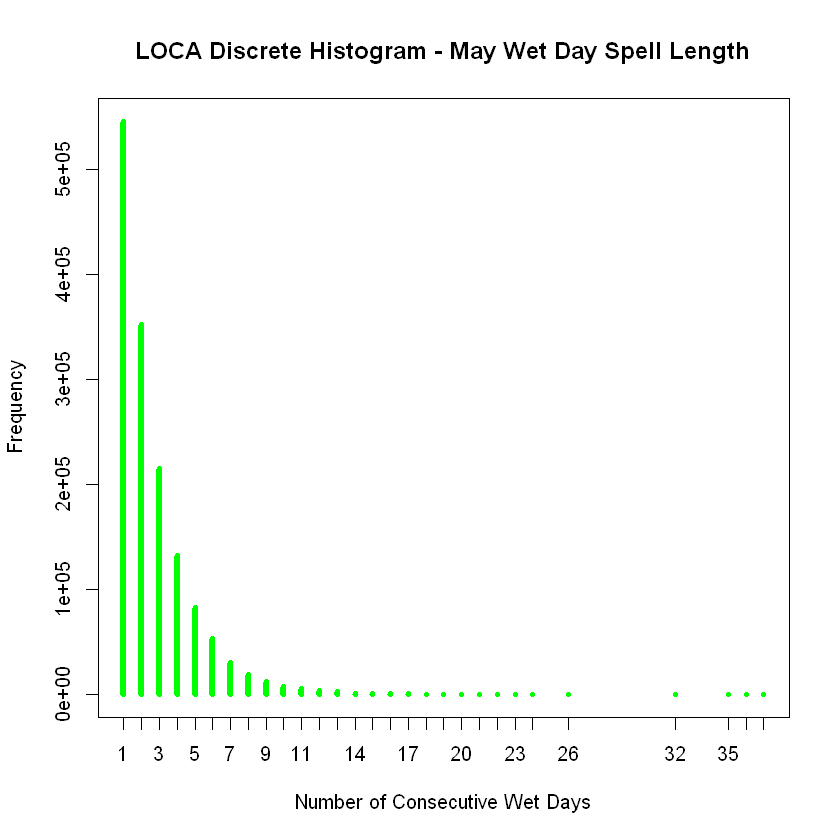

In [125]:
# our case is discrete so use this command
plot( table( dLOMay$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - May Wet Day Spell Length", 
      col="green" )

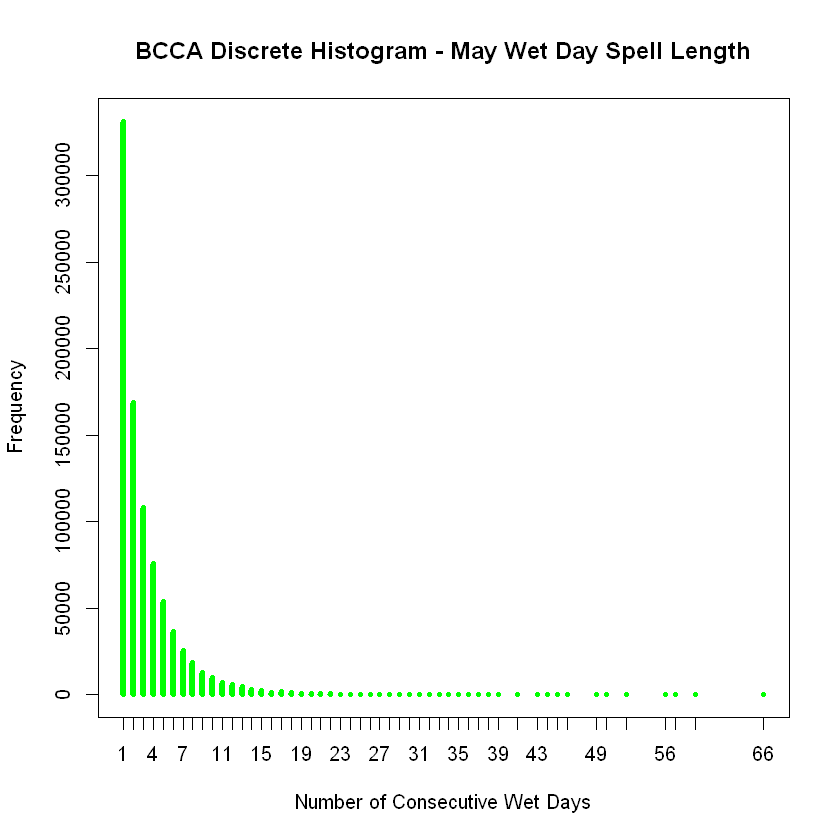

In [126]:
plot( table( dBCMay$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - May Wet Day Spell Length", 
      col="green" )

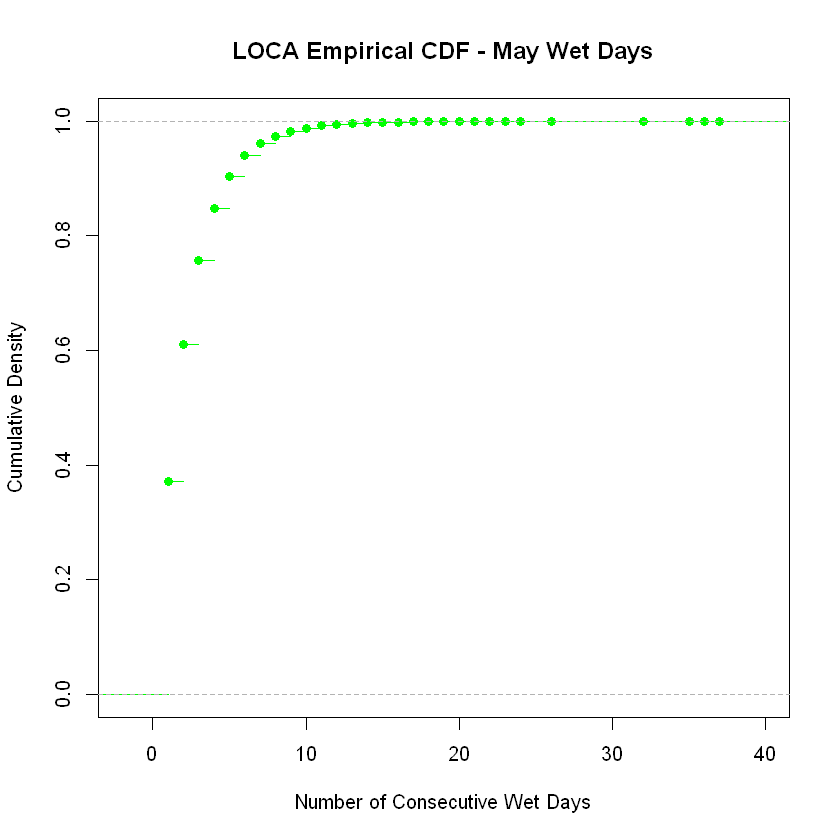

In [127]:
plot(ecdf(dLOMay$Wet_Count), main="LOCA Empirical CDF - May Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

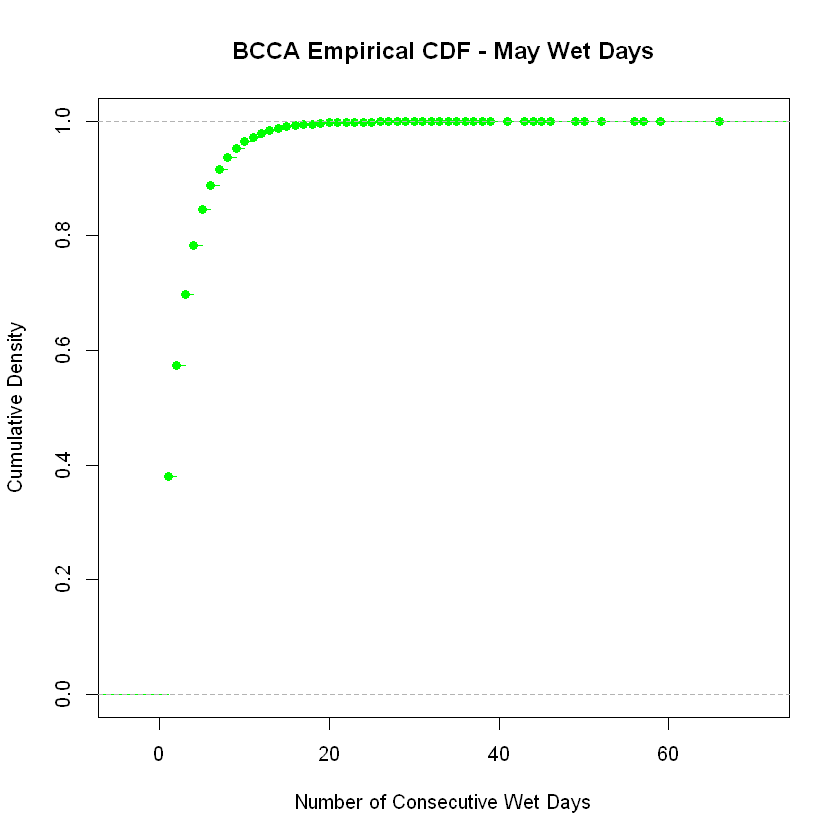

In [128]:
plot(ecdf(dBCMay$Wet_Count), main="BCCA Empirical CDF - May Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

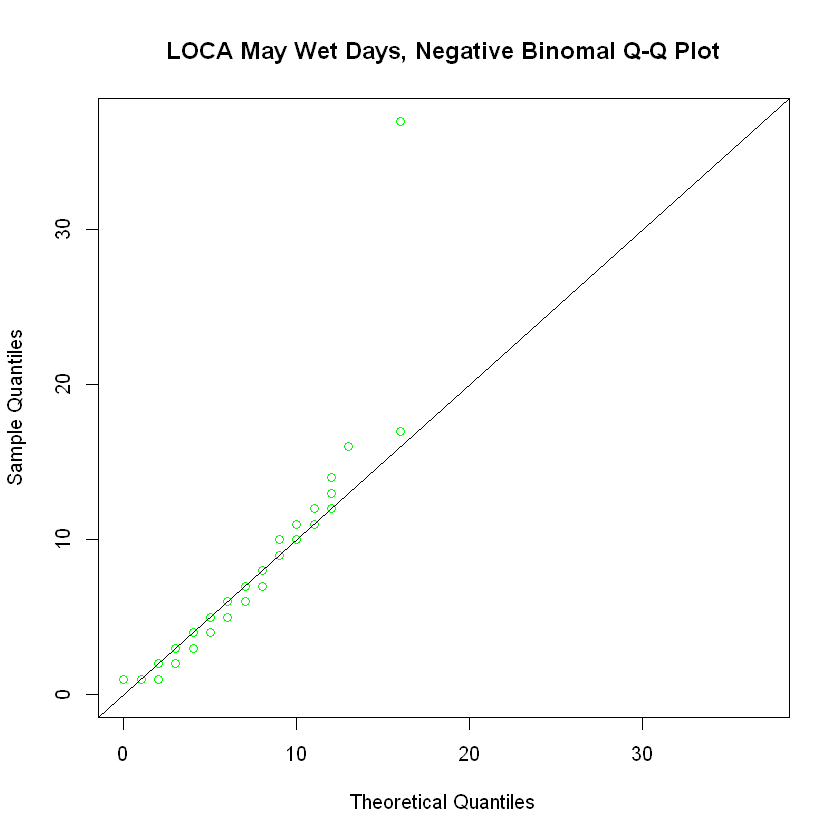

In [129]:
dLOMayMax <- max( dLOMay$Wet_Count )
dLOMayMean <- mean( dLOMay$Wet_Count )
dLOMayVar <- var( dLOMay$Wet_Count )
dLOMayBNr <- dLOMayMean^2 / abs(dLOMayVar - dLOMayMean)
dLOMayTstNB <- rnbinom( 1000, mu=dLOMayMean, size=dLOMayBNr )
qqplot( dLOMayTstNB, dLOMay$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA May Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOMayMax), ylim=c(0,dLOMayMax) )
abline( 0, 1)

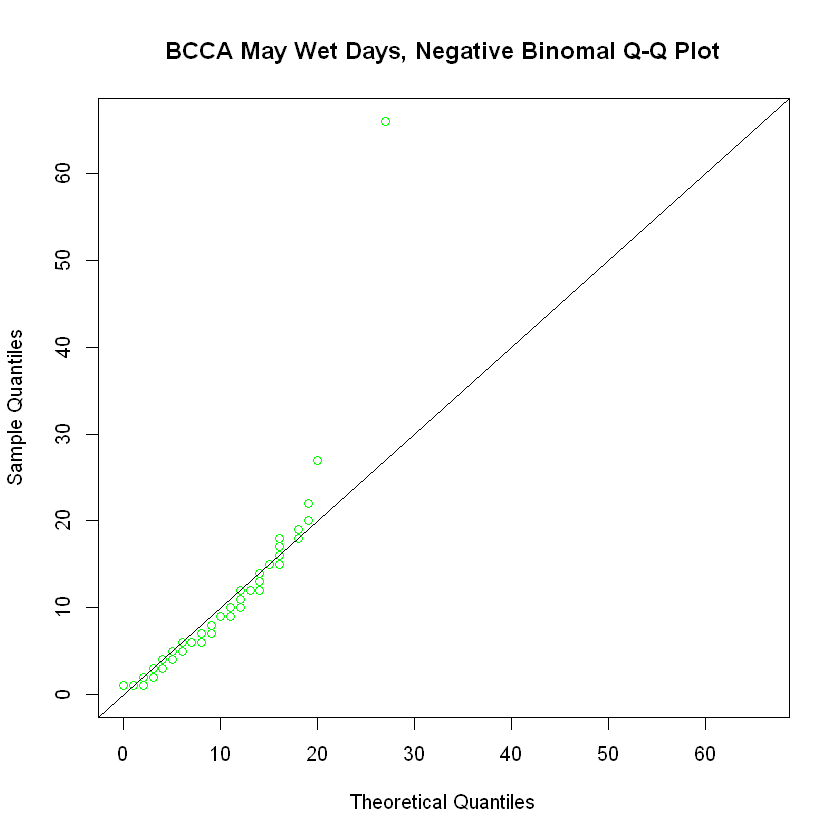

In [130]:
dBCMayMax <- max( dBCMay$Wet_Count )
dBCMayMean <- mean( dBCMay$Wet_Count )
dBCMayVar <- var( dBCMay$Wet_Count )
dBCMayBNr <- dBCMayMean^2 / abs(dBCMayVar - dBCMayMean)
dBCMayTstNB <- rnbinom( 1000, mu=dBCMayMean, size=dBCMayBNr )
qqplot( dBCMayTstNB, dBCMay$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA May Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCMayMax), ylim=c(0,dBCMayMax) )
abline( 0, 1)

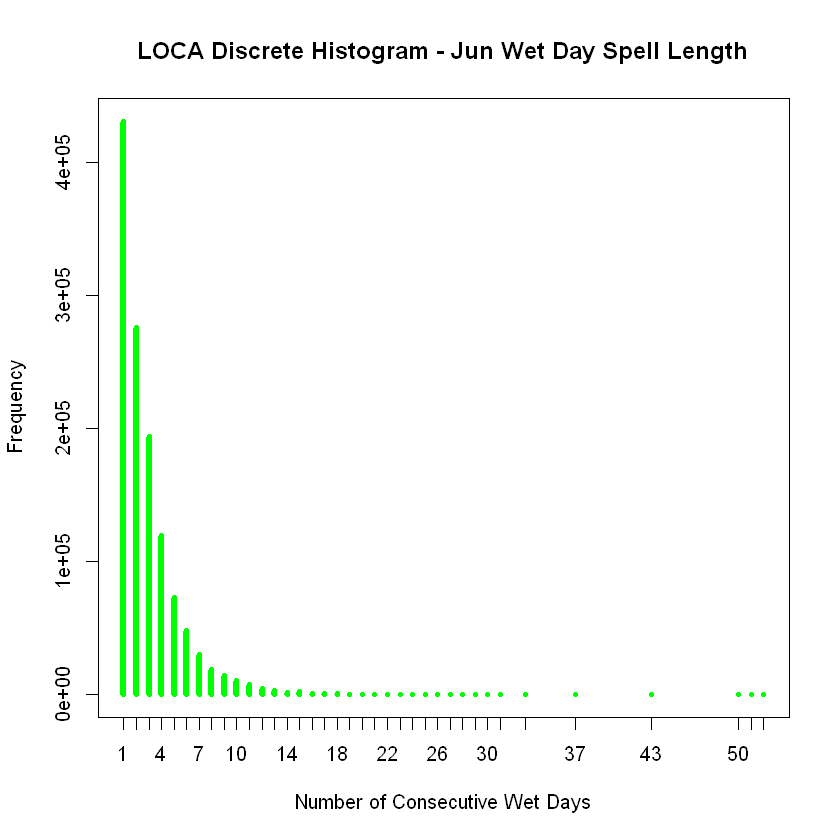

In [131]:
# our case is discrete so use this command
plot( table( dLOJun$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Jun Wet Day Spell Length", 
      col="green" )

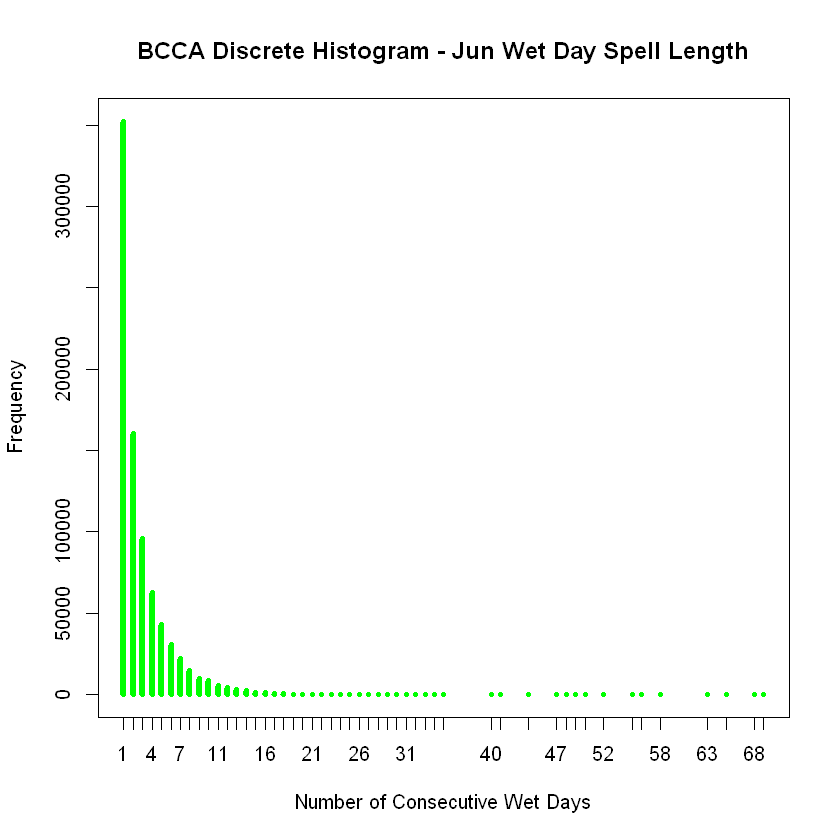

In [132]:
plot( table( dBCJun$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Jun Wet Day Spell Length", 
      col="green" )

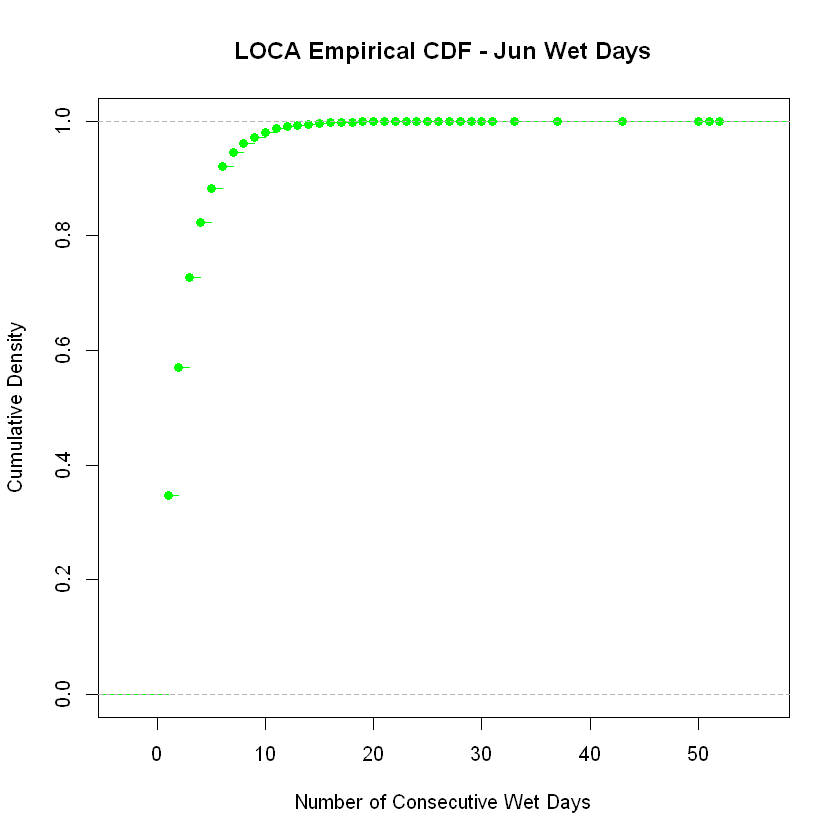

In [133]:
plot(ecdf(dLOJun$Wet_Count), main="LOCA Empirical CDF - Jun Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

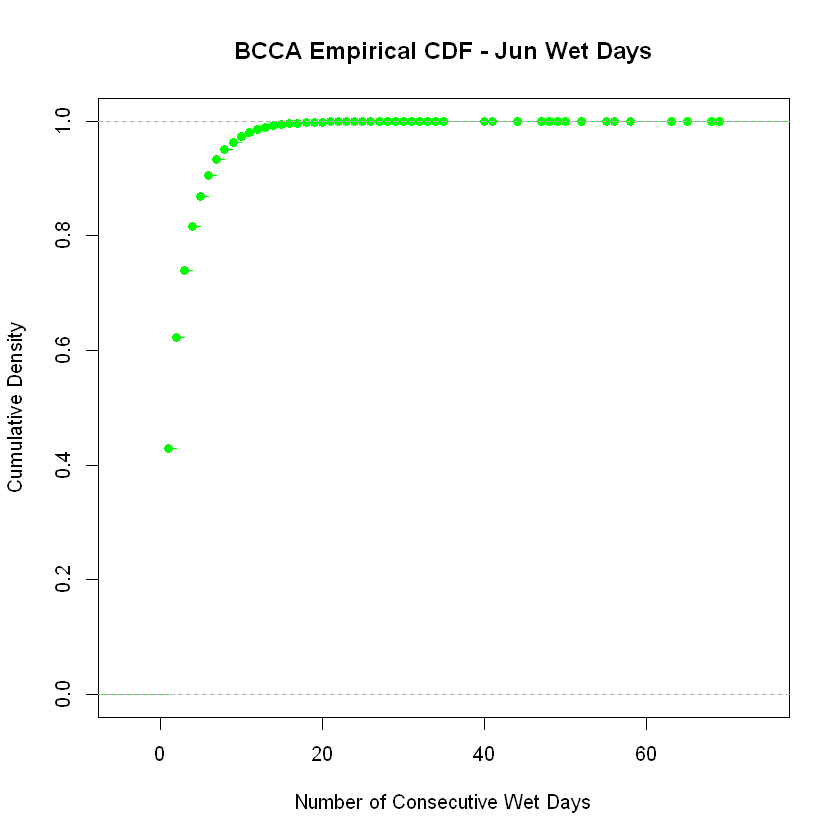

In [134]:
plot(ecdf(dBCJun$Wet_Count), main="BCCA Empirical CDF - Jun Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

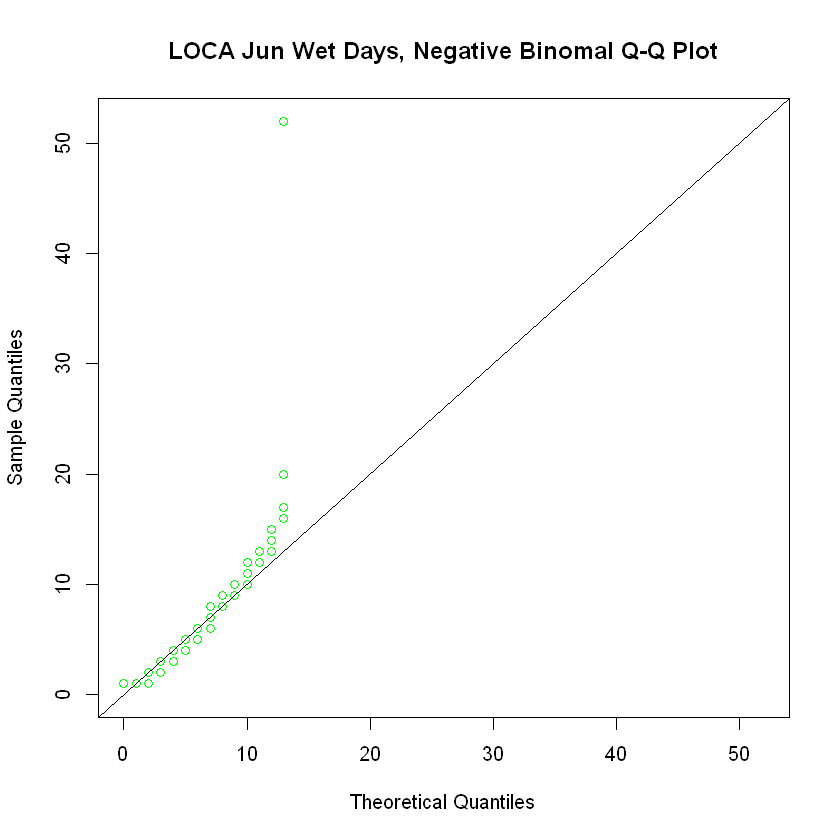

In [135]:
dLOJunMax <- max( dLOJun$Wet_Count )
dLOJunMean <- mean( dLOJun$Wet_Count )
dLOJunVar <- var( dLOJun$Wet_Count )
dLOJunBNr <- dLOJunMean^2 / abs(dLOJunVar - dLOJunMean)
dLOJunTstNB <- rnbinom( 1000, mu=dLOJunMean, size=dLOJunBNr )
qqplot( dLOJunTstNB, dLOJun$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Jun Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOJunMax), ylim=c(0,dLOJunMax) )
abline( 0, 1)

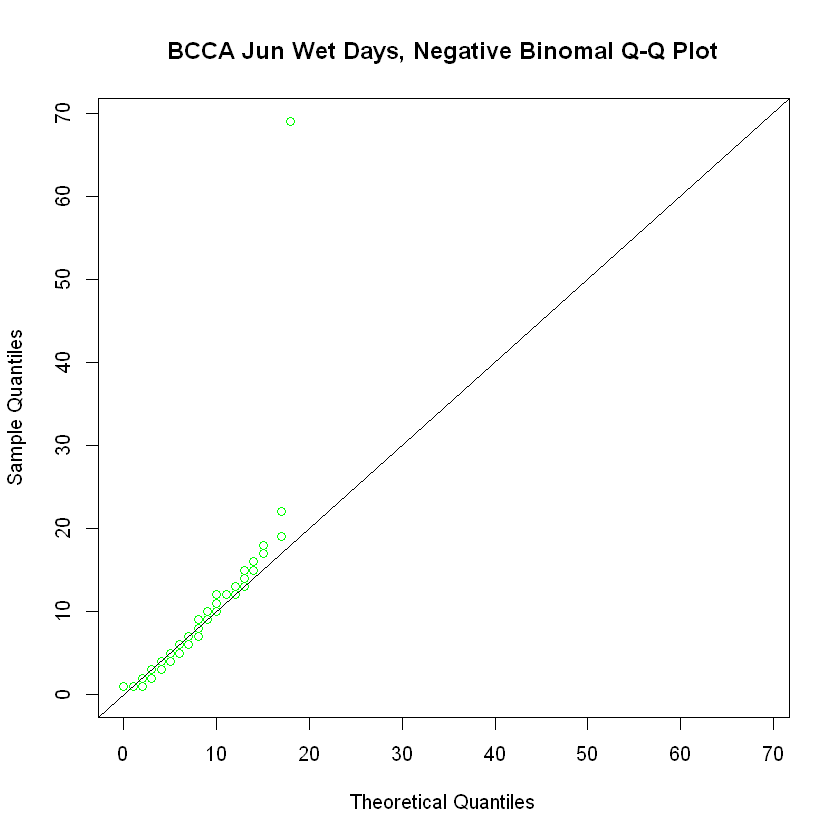

In [136]:
dBCJunMax <- max( dBCJun$Wet_Count )
dBCJunMean <- mean( dBCJun$Wet_Count )
dBCJunVar <- var( dBCJun$Wet_Count )
dBCJunBNr <- dBCJunMean^2 / abs(dBCJunVar - dBCJunMean)
dBCJunTstNB <- rnbinom( 1000, mu=dBCJunMean, size=dBCJunBNr )
qqplot( dBCJunTstNB, dBCJun$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Jun Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCJunMax), ylim=c(0,dBCJunMax) )
abline( 0, 1)

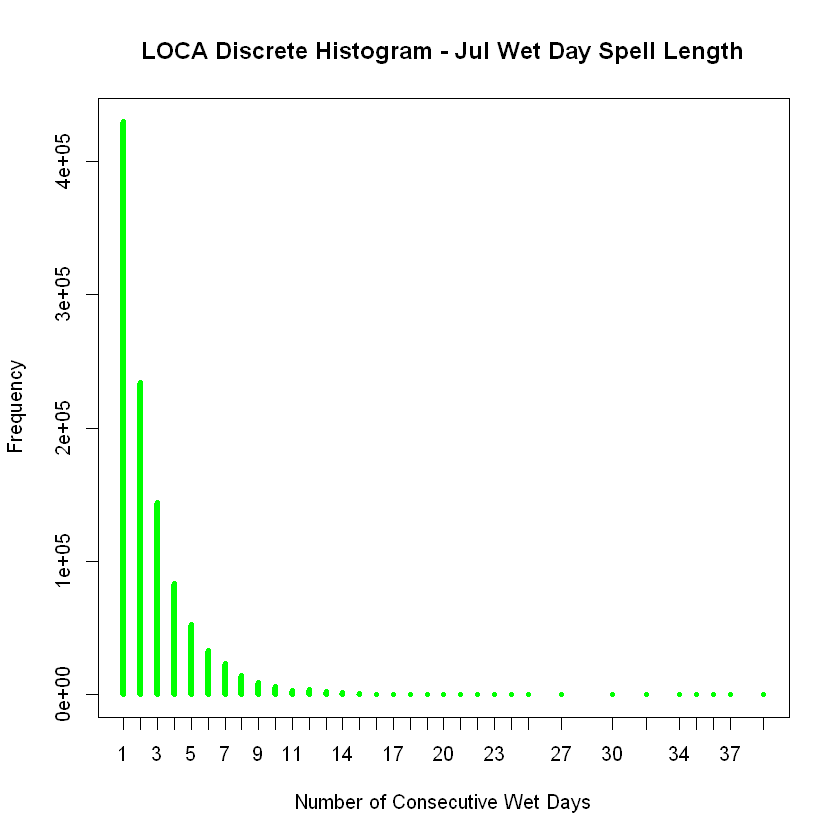

In [137]:
# our case is discrete so use this command
plot( table( dLOJul$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Jul Wet Day Spell Length", 
      col="green" )

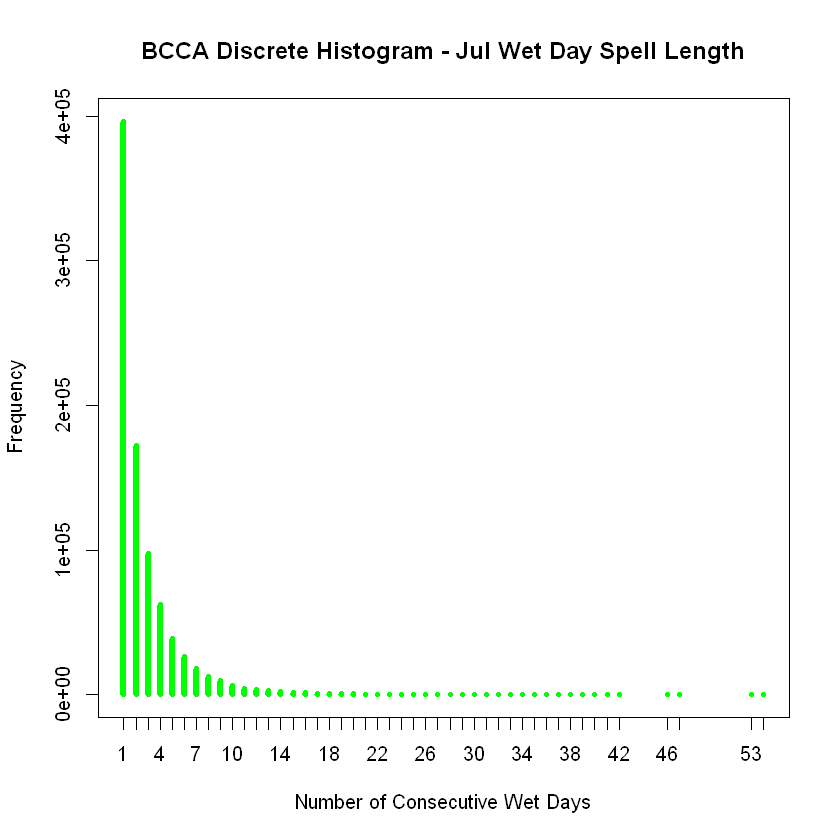

In [138]:
plot( table( dBCJul$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Jul Wet Day Spell Length", 
      col="green" )

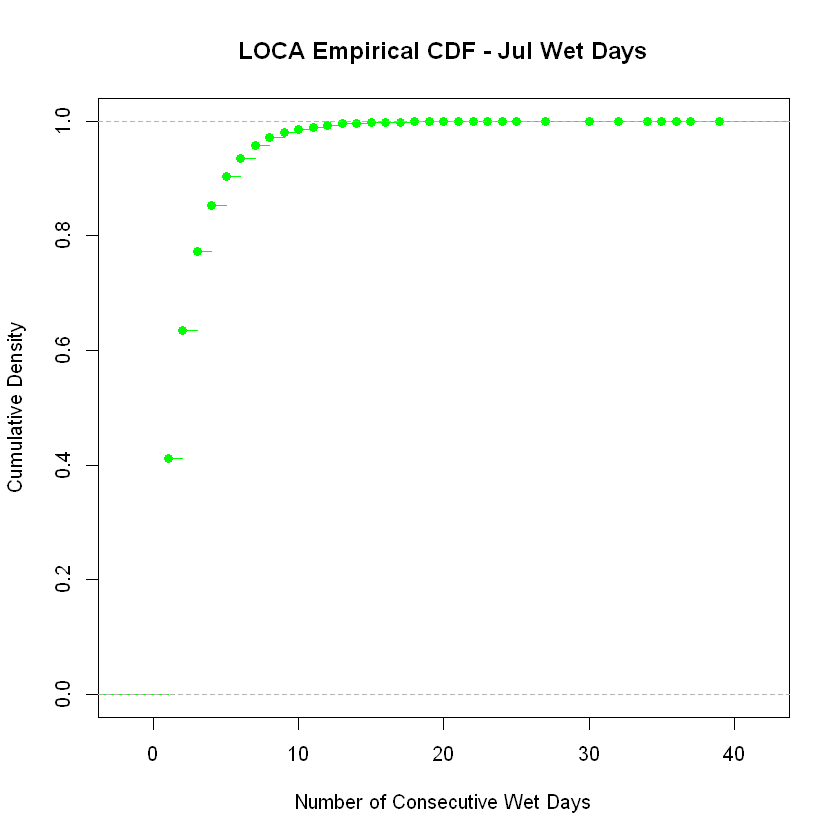

In [139]:
plot(ecdf(dLOJul$Wet_Count), main="LOCA Empirical CDF - Jul Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

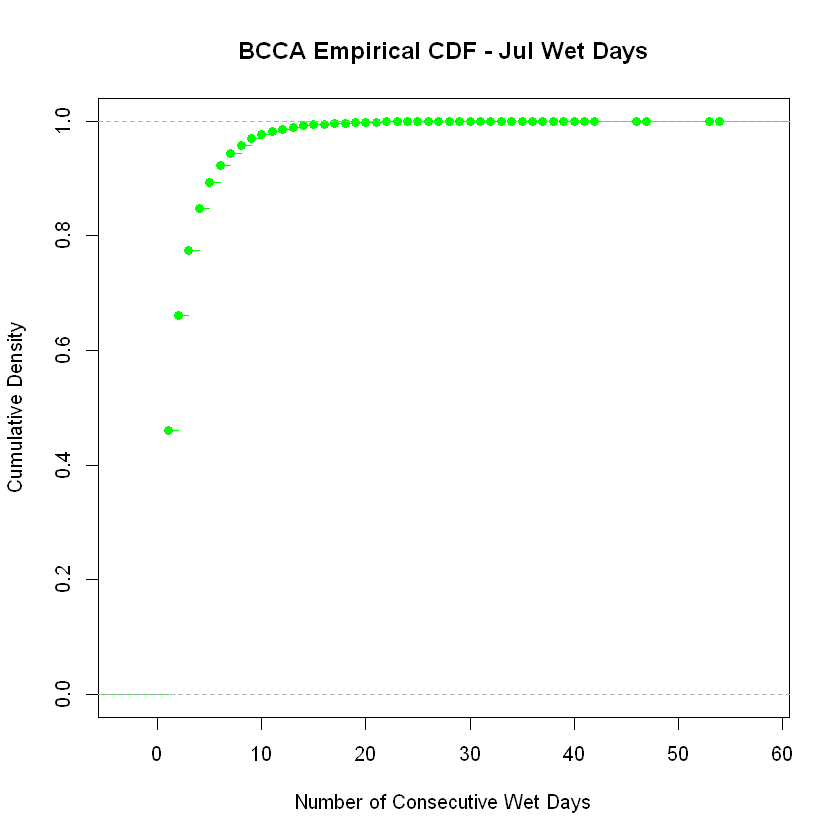

In [140]:
plot(ecdf(dBCJul$Wet_Count), main="BCCA Empirical CDF - Jul Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

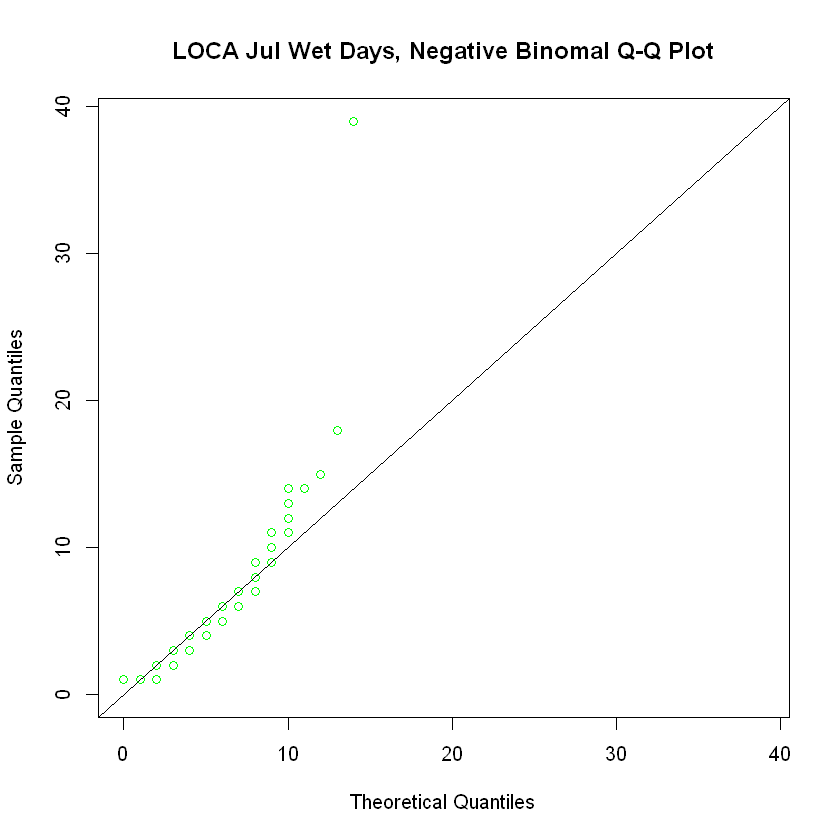

In [141]:
dLOJulMax <- max( dLOJul$Wet_Count )
dLOJulMean <- mean( dLOJul$Wet_Count )
dLOJulVar <- var( dLOJul$Wet_Count )
dLOJulBNr <- dLOJulMean^2 / abs(dLOJulVar - dLOJulMean)
dLOJulTstNB <- rnbinom( 1000, mu=dLOJulMean, size=dLOJulBNr )
qqplot( dLOJulTstNB, dLOJul$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Jul Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOJulMax), ylim=c(0,dLOJulMax) )
abline( 0, 1)

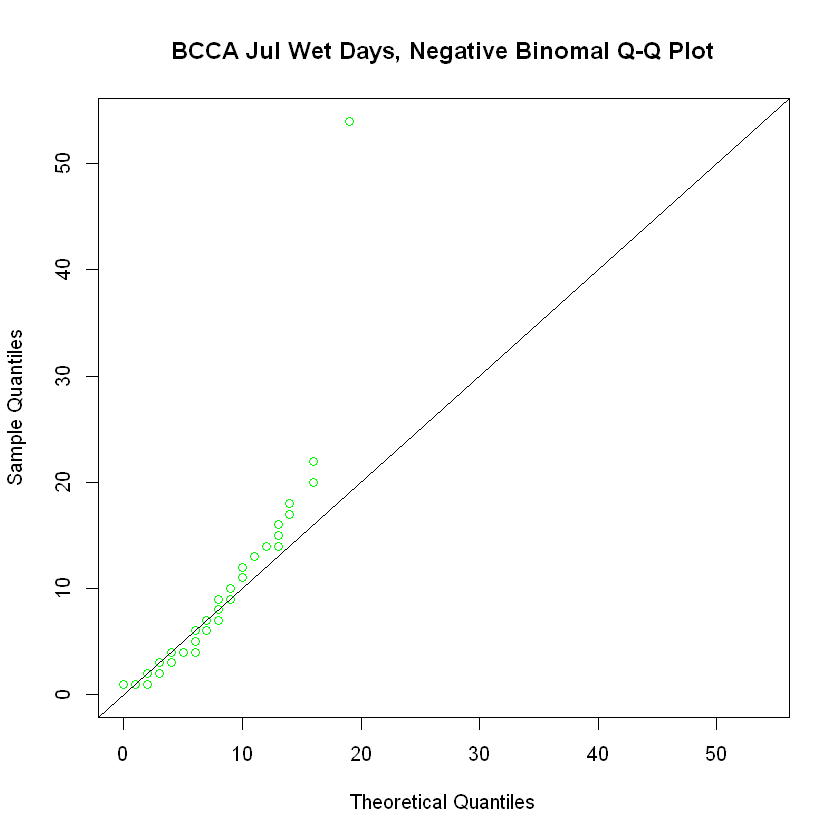

In [142]:
dBCJulMax <- max( dBCJul$Wet_Count )
dBCJulMean <- mean( dBCJul$Wet_Count )
dBCJulVar <- var( dBCJul$Wet_Count )
dBCJulBNr <- dBCJulMean^2 / abs(dBCJulVar - dBCJulMean)
dBCJulTstNB <- rnbinom( 1000, mu=dBCJulMean, size=dBCJulBNr )
qqplot( dBCJulTstNB, dBCJul$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Jul Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCJulMax), ylim=c(0,dBCJulMax) )
abline( 0, 1)

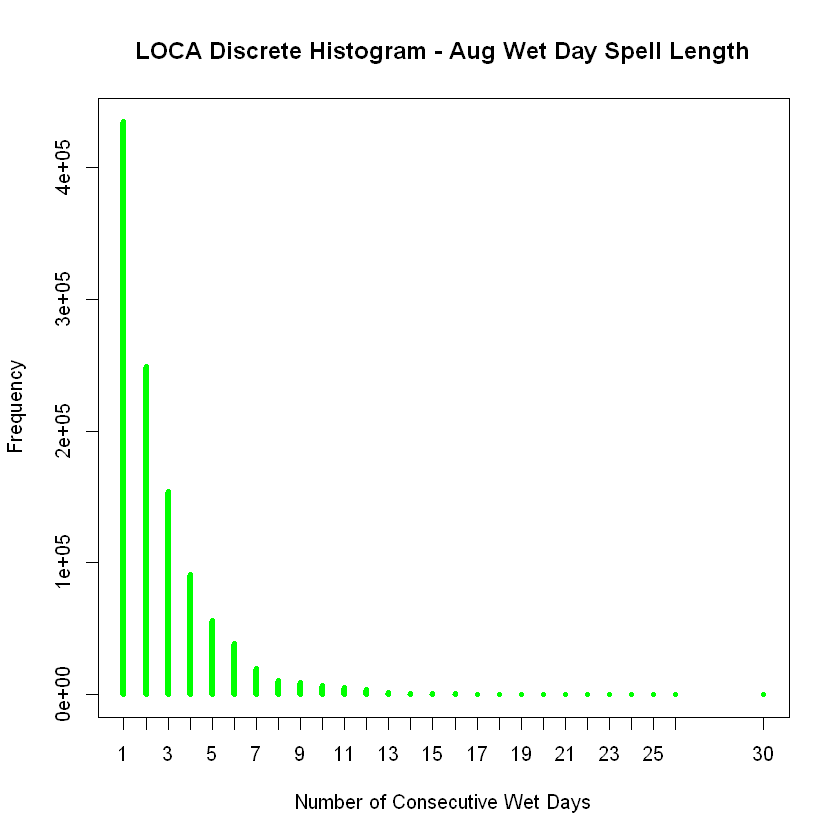

In [143]:
# our case is discrete so use this command
plot( table( dLOAug$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Aug Wet Day Spell Length", 
      col="green" )

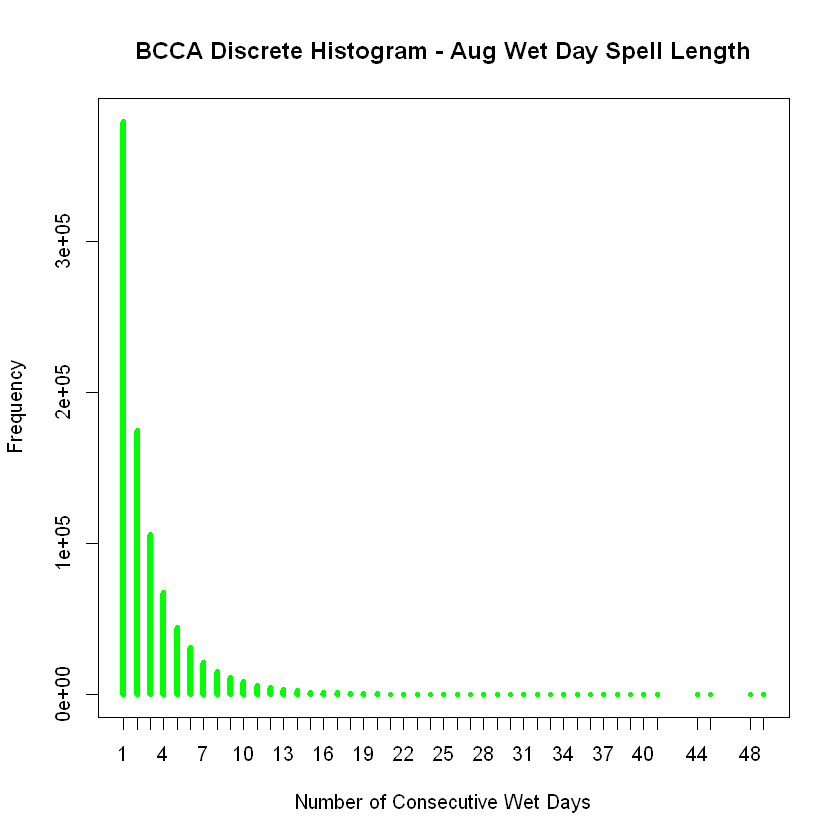

In [144]:
plot( table( dBCAug$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Aug Wet Day Spell Length", 
      col="green" )

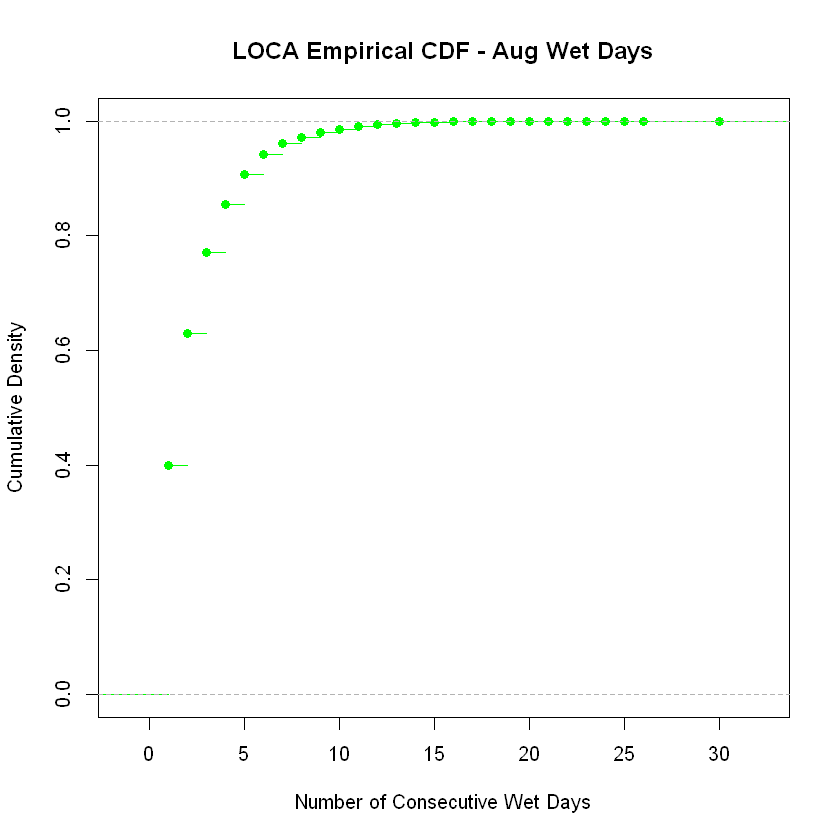

In [145]:
plot(ecdf(dLOAug$Wet_Count), main="LOCA Empirical CDF - Aug Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

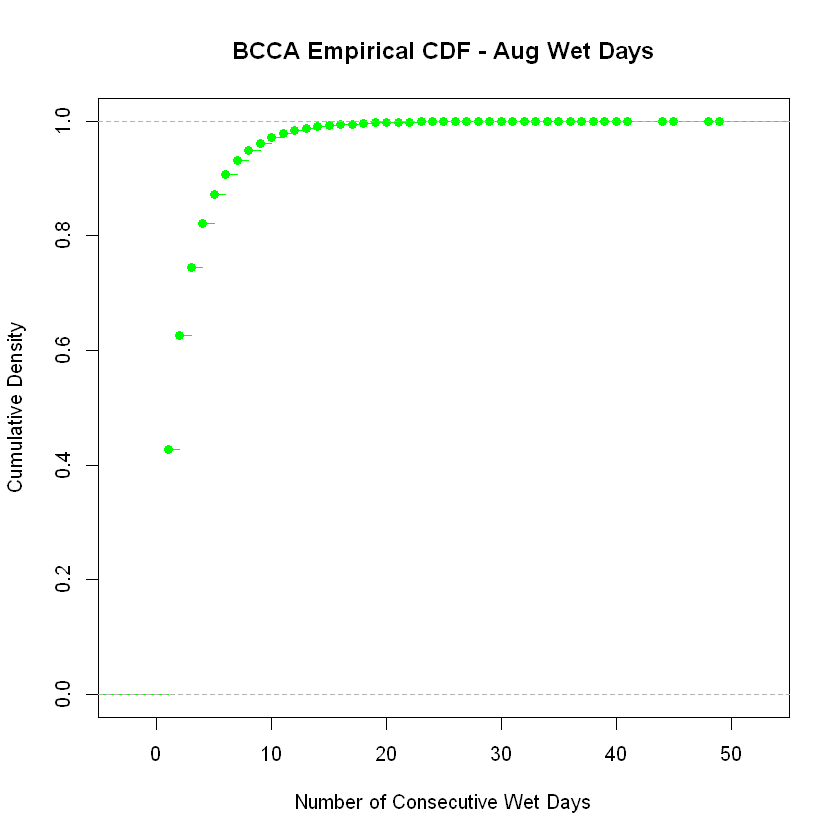

In [146]:
plot(ecdf(dBCAug$Wet_Count), main="BCCA Empirical CDF - Aug Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

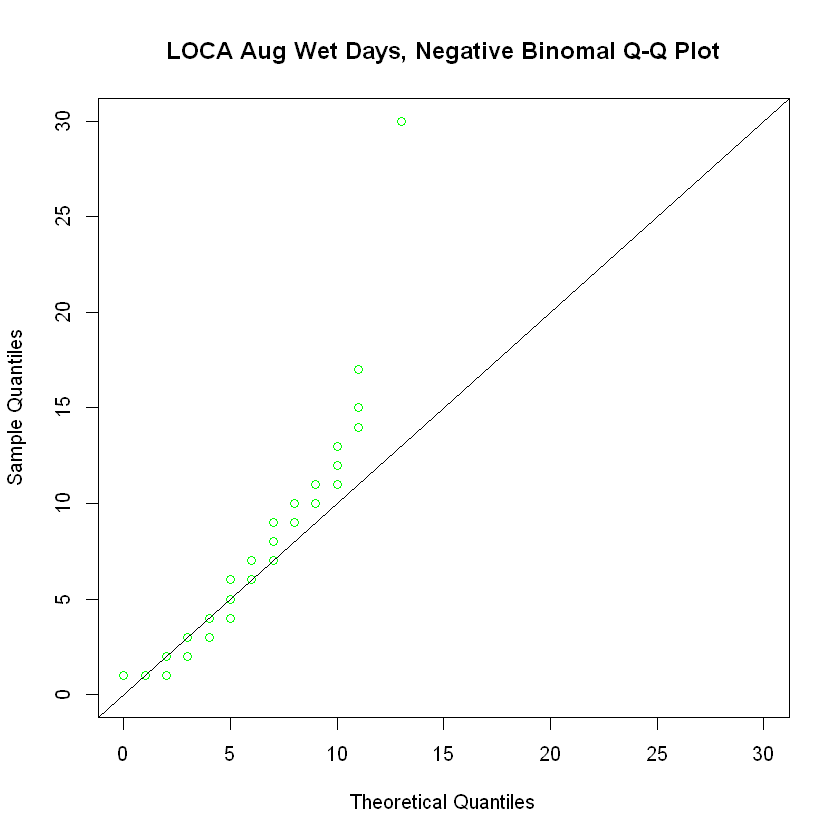

In [147]:
dLOAugMax <- max( dLOAug$Wet_Count )
dLOAugMean <- mean( dLOAug$Wet_Count )
dLOAugVar <- var( dLOAug$Wet_Count )
dLOAugBNr <- dLOAugMean^2 / abs(dLOAugVar - dLOAugMean)
dLOAugTstNB <- rnbinom( 1000, mu=dLOAugMean, size=dLOAugBNr )
qqplot( dLOAugTstNB, dLOAug$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Aug Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOAugMax), ylim=c(0,dLOAugMax) )
abline( 0, 1)

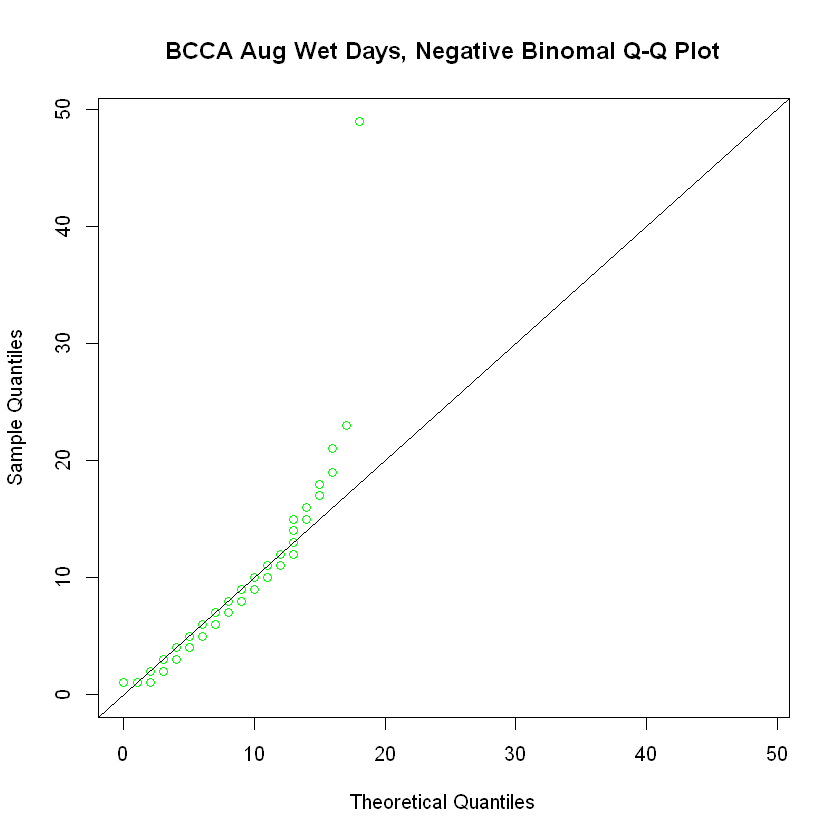

In [148]:
dBCAugMax <- max( dBCAug$Wet_Count )
dBCAugMean <- mean( dBCAug$Wet_Count )
dBCAugVar <- var( dBCAug$Wet_Count )
dBCAugBNr <- dBCAugMean^2 / abs(dBCAugVar - dBCAugMean)
dBCAugTstNB <- rnbinom( 1000, mu=dBCAugMean, size=dBCAugBNr )
qqplot( dBCAugTstNB, dBCAug$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Aug Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCAugMax), ylim=c(0,dBCAugMax) )
abline( 0, 1)

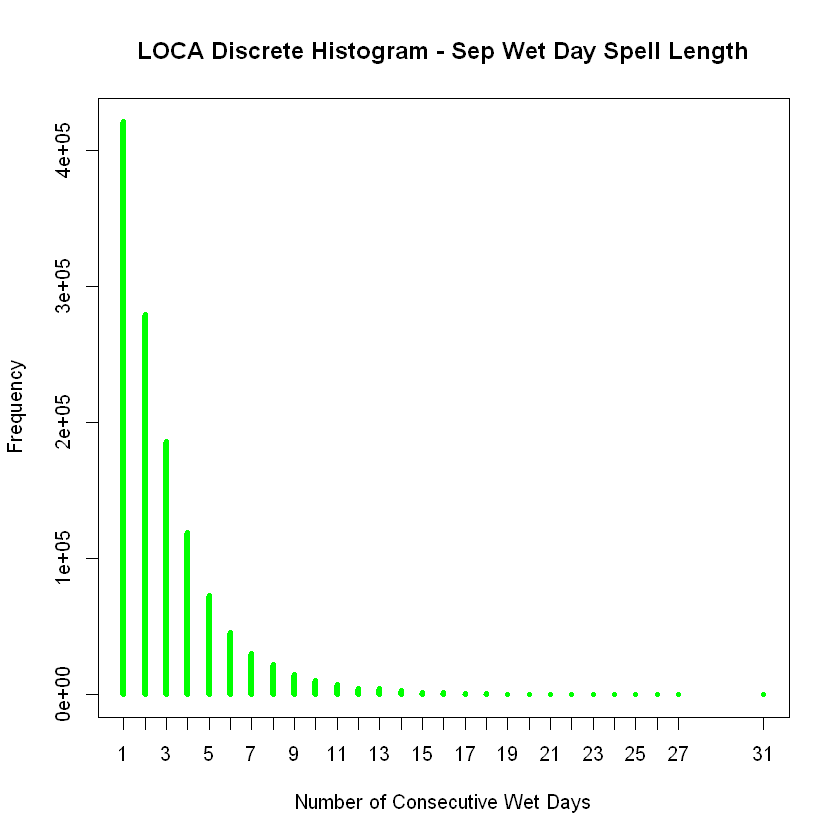

In [149]:
# our case is discrete so use this command
plot( table( dLOSep$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Sep Wet Day Spell Length", 
      col="green" )

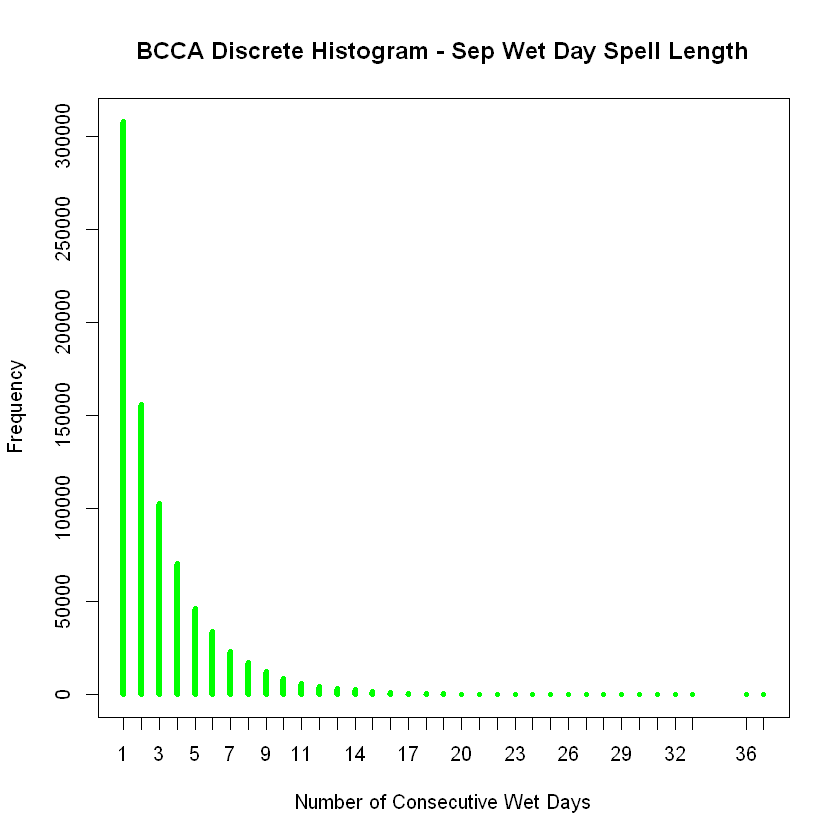

In [150]:
plot( table( dBCSep$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Sep Wet Day Spell Length", 
      col="green" )

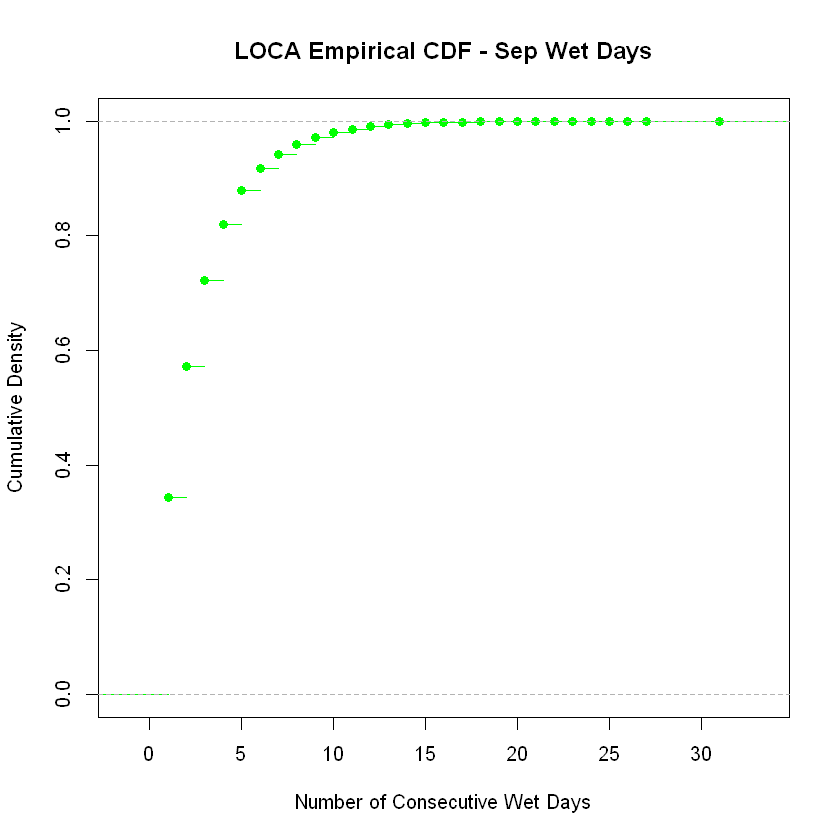

In [151]:
plot(ecdf(dLOSep$Wet_Count), main="LOCA Empirical CDF - Sep Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

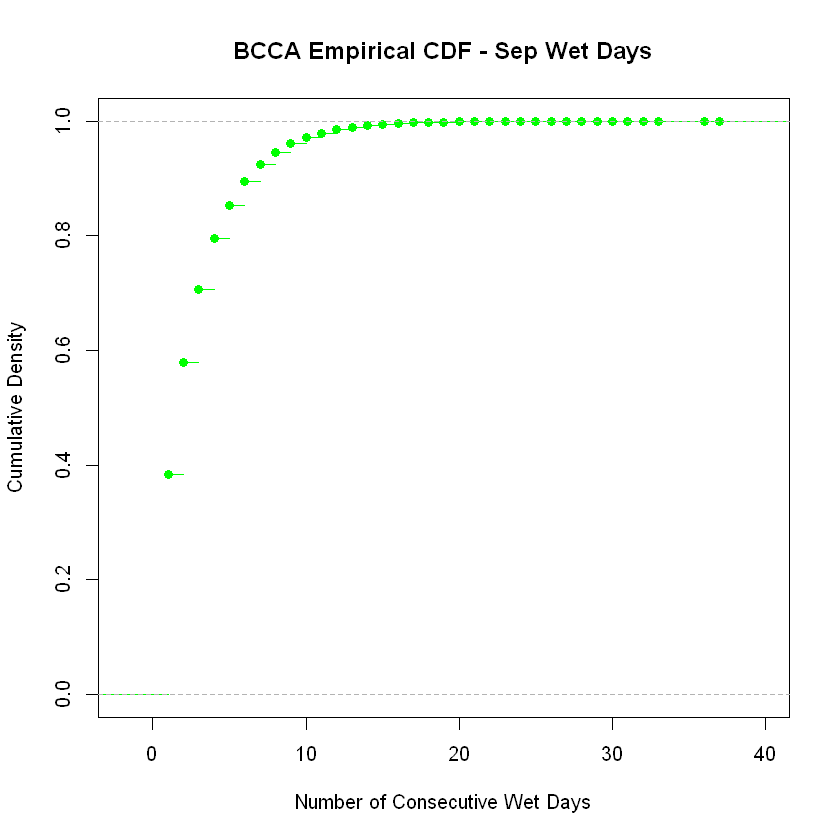

In [152]:
plot(ecdf(dBCSep$Wet_Count), main="BCCA Empirical CDF - Sep Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

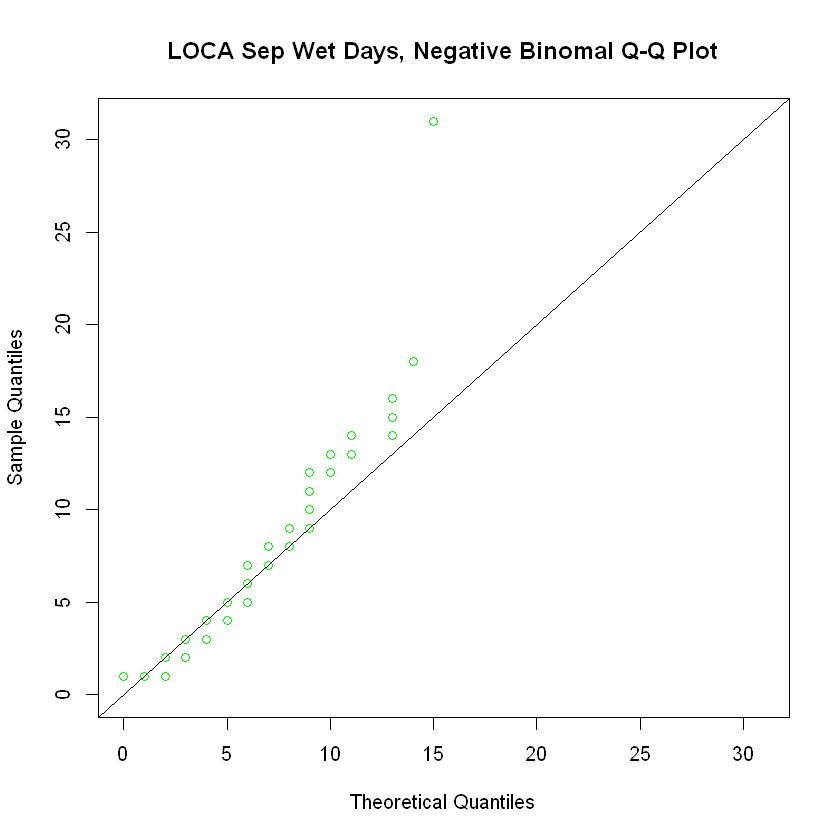

In [153]:
dLOSepMax <- max( dLOSep$Wet_Count )
dLOSepMean <- mean( dLOSep$Wet_Count )
dLOSepVar <- var( dLOSep$Wet_Count )
dLOSepBNr <- dLOSepMean^2 / abs(dLOSepVar - dLOSepMean)
dLOSepTstNB <- rnbinom( 1000, mu=dLOSepMean, size=dLOSepBNr )
qqplot( dLOSepTstNB, dLOSep$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Sep Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOSepMax), ylim=c(0,dLOSepMax) )
abline( 0, 1)

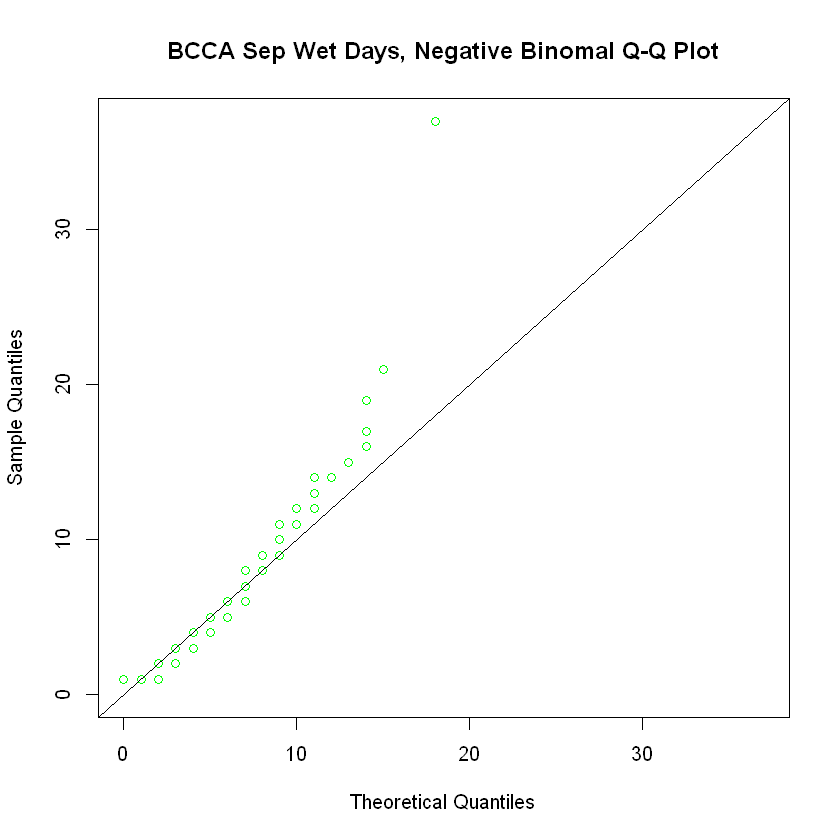

In [154]:
dBCSepMax <- max( dBCSep$Wet_Count )
dBCSepMean <- mean( dBCSep$Wet_Count )
dBCSepVar <- var( dBCSep$Wet_Count )
dBCSepBNr <- dBCSepMean^2 / abs(dBCSepVar - dBCSepMean)
dBCSepTstNB <- rnbinom( 1000, mu=dBCSepMean, size=dBCSepBNr )
qqplot( dBCSepTstNB, dBCSep$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Sep Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCSepMax), ylim=c(0,dBCSepMax) )
abline( 0, 1)

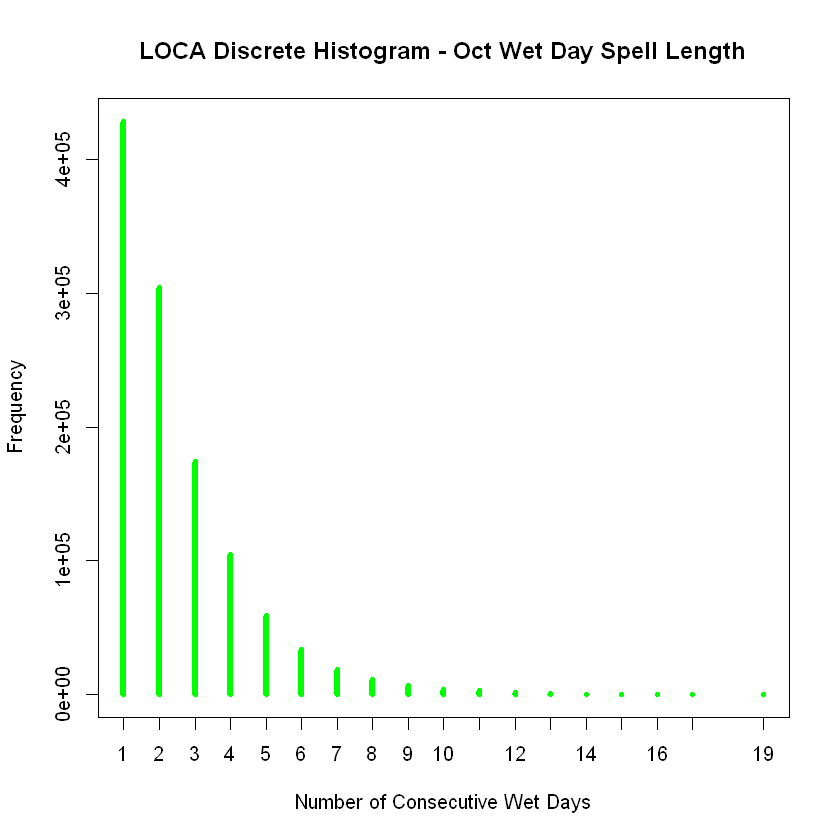

In [155]:
# our case is discrete so use this command
plot( table( dLOOct$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Oct Wet Day Spell Length", 
      col="green" )

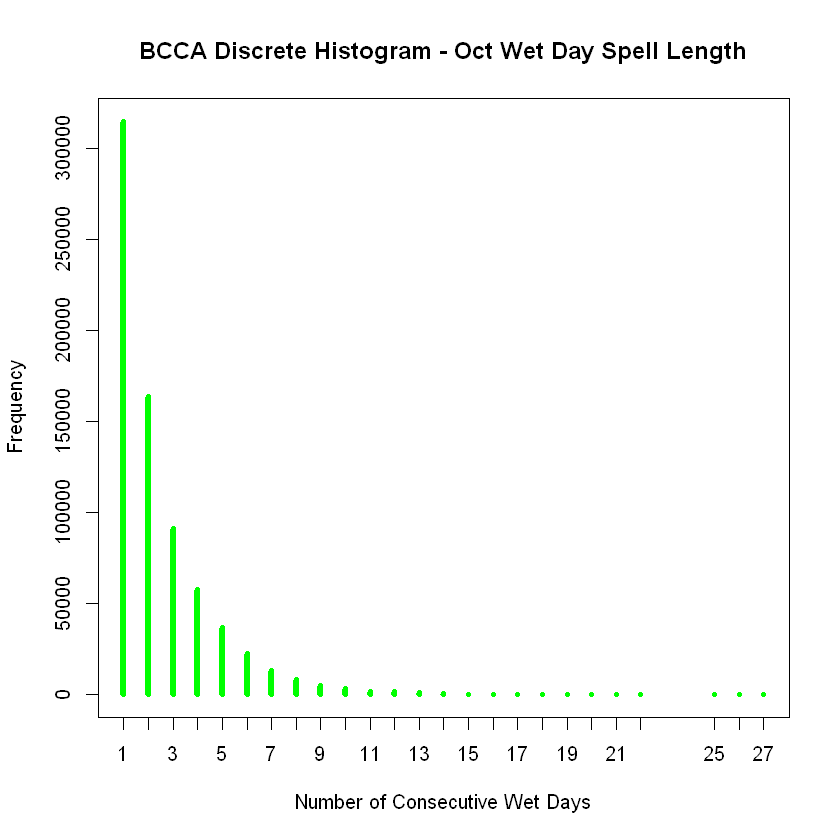

In [156]:
plot( table( dBCOct$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Oct Wet Day Spell Length", 
      col="green" )

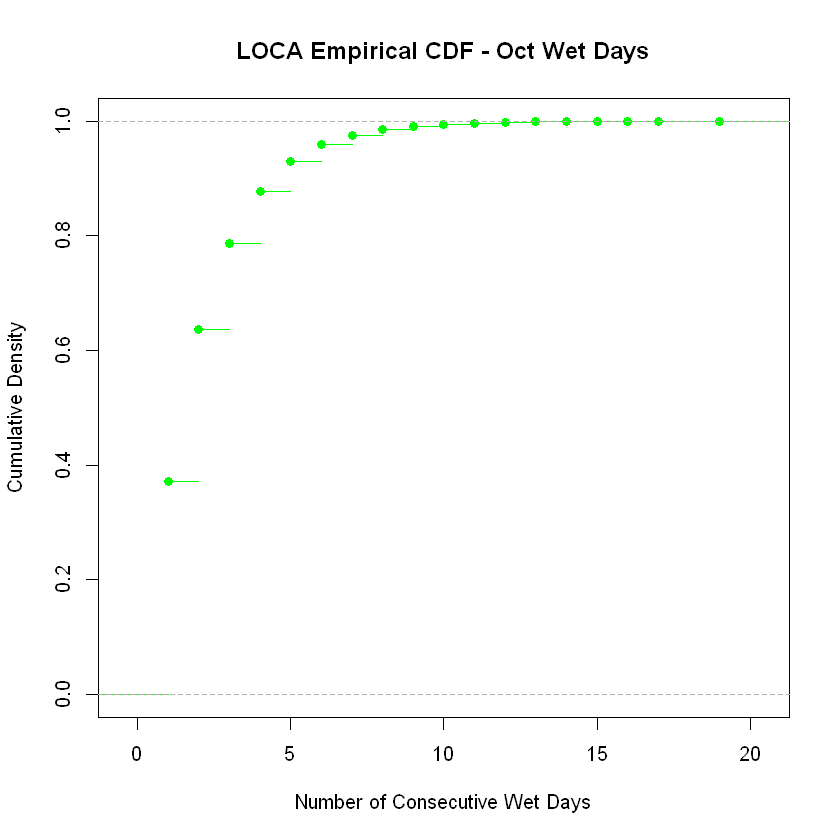

In [157]:
plot(ecdf(dLOOct$Wet_Count), main="LOCA Empirical CDF - Oct Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

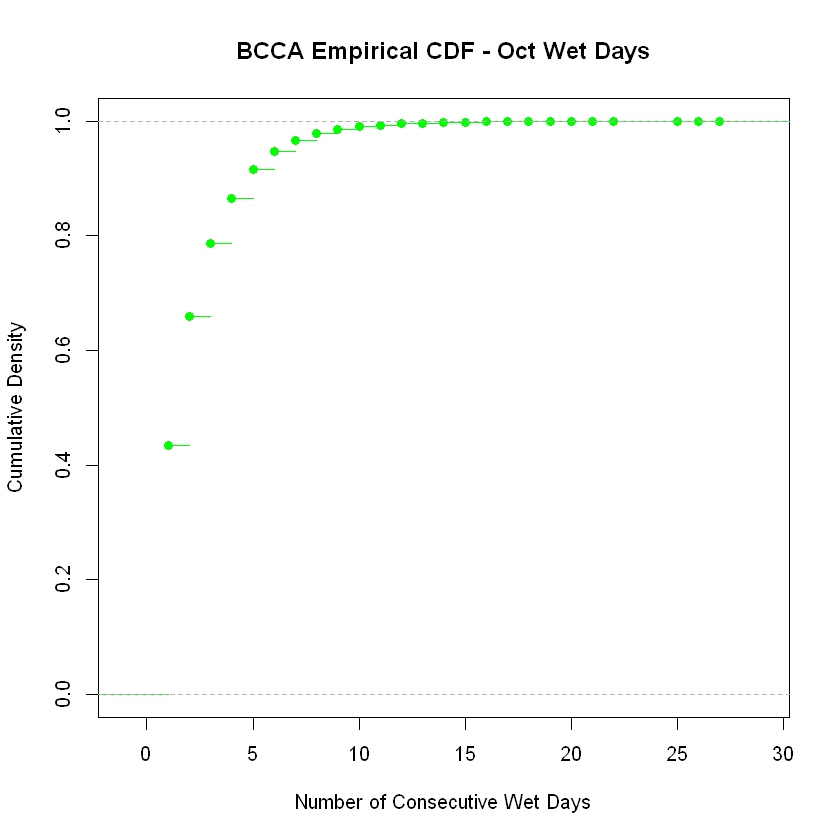

In [158]:
plot(ecdf(dBCOct$Wet_Count), main="BCCA Empirical CDF - Oct Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

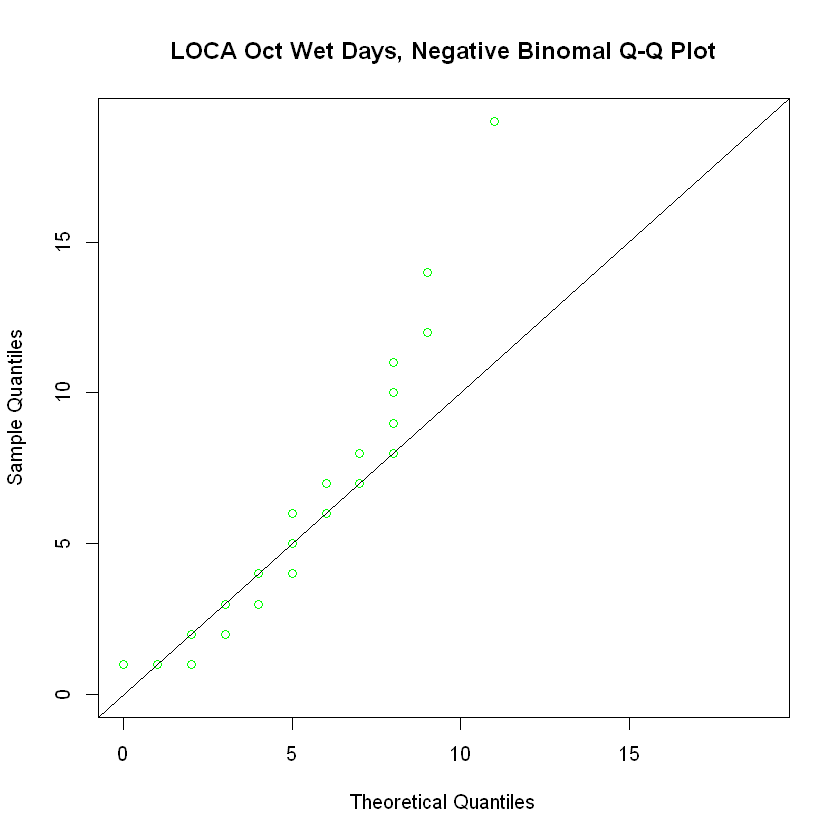

In [159]:
dLOOctMax <- max( dLOOct$Wet_Count )
dLOOctMean <- mean( dLOOct$Wet_Count )
dLOOctVar <- var( dLOOct$Wet_Count )
dLOOctBNr <- dLOOctMean^2 / abs(dLOOctVar - dLOOctMean)
dLOOctTstNB <- rnbinom( 1000, mu=dLOOctMean, size=dLOOctBNr )
qqplot( dLOOctTstNB, dLOOct$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Oct Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOOctMax), ylim=c(0,dLOOctMax) )
abline( 0, 1)

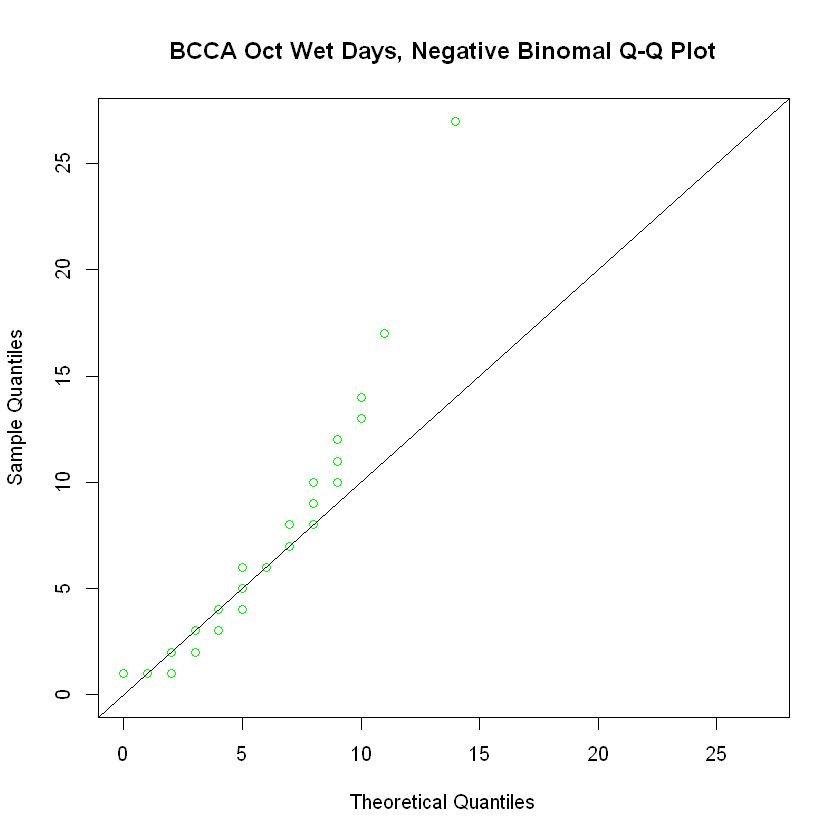

In [160]:
dBCOctMax <- max( dBCOct$Wet_Count )
dBCOctMean <- mean( dBCOct$Wet_Count )
dBCOctVar <- var( dBCOct$Wet_Count )
dBCOctBNr <- dBCOctMean^2 / abs(dBCOctVar - dBCOctMean)
dBCOctTstNB <- rnbinom( 1000, mu=dBCOctMean, size=dBCOctBNr )
qqplot( dBCOctTstNB, dBCOct$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Oct Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCOctMax), ylim=c(0,dBCOctMax) )
abline( 0, 1)

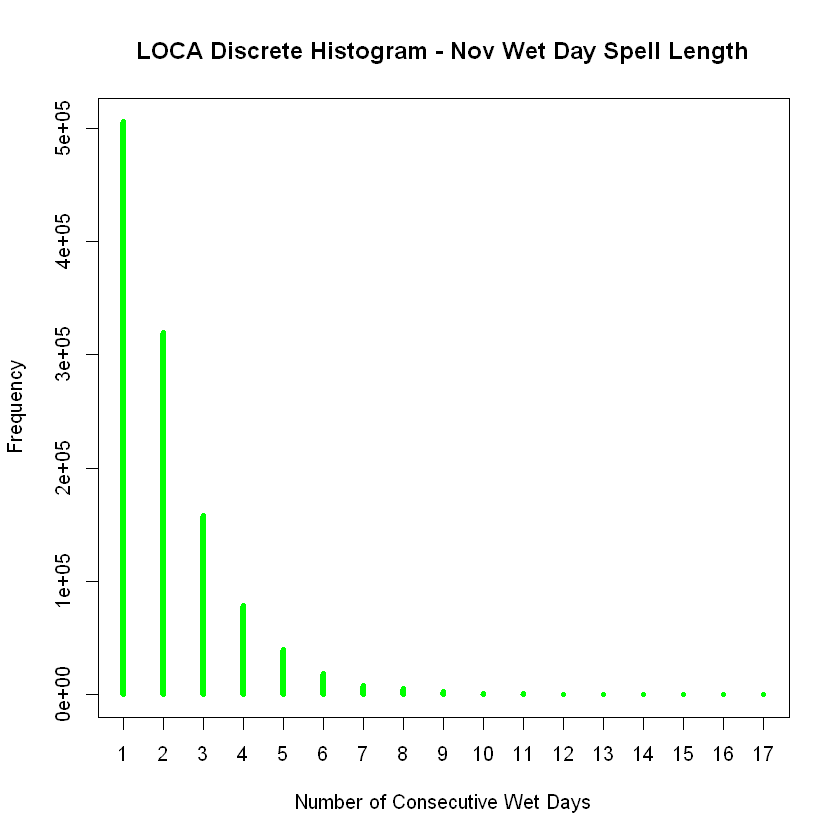

In [161]:
# our case is discrete so use this command
plot( table( dLONov$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Nov Wet Day Spell Length", 
      col="green" )

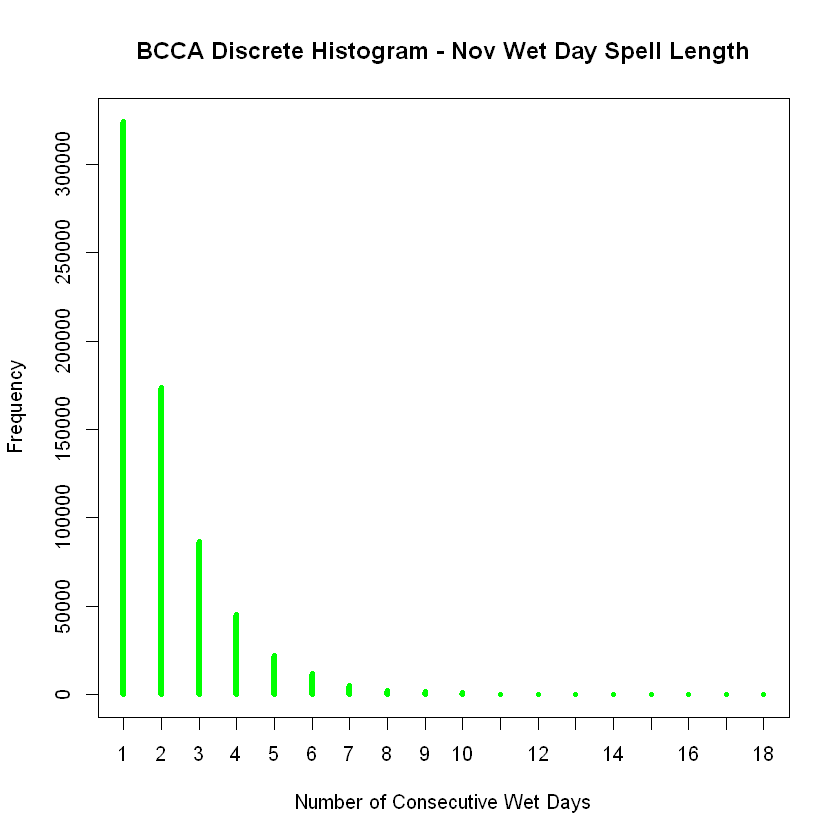

In [162]:
plot( table( dBCNov$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Nov Wet Day Spell Length", 
      col="green" )

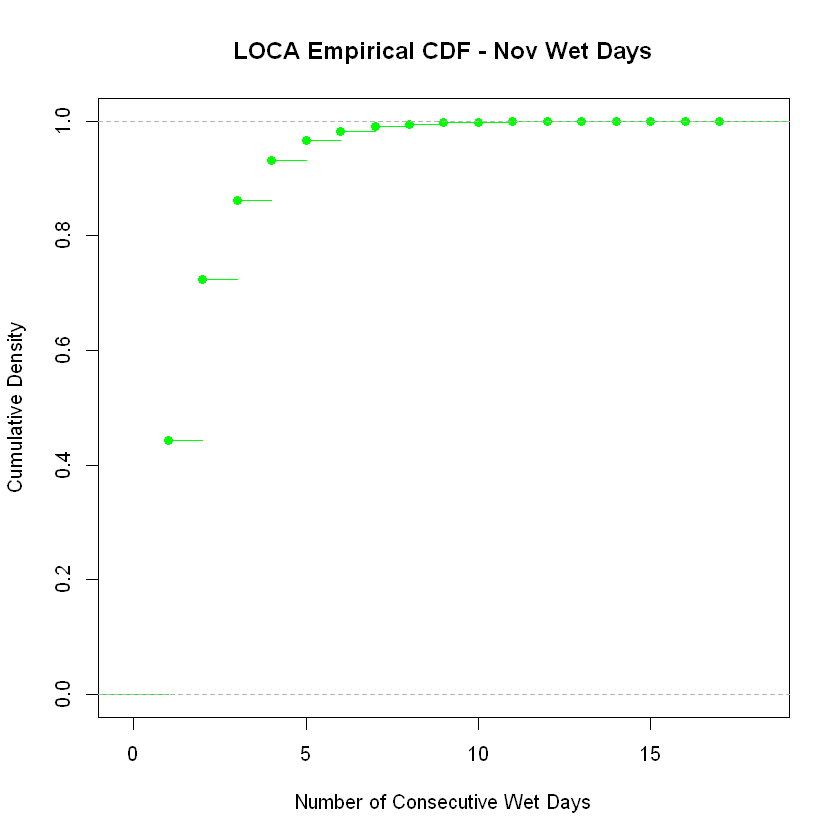

In [163]:
plot(ecdf(dLONov$Wet_Count), main="LOCA Empirical CDF - Nov Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

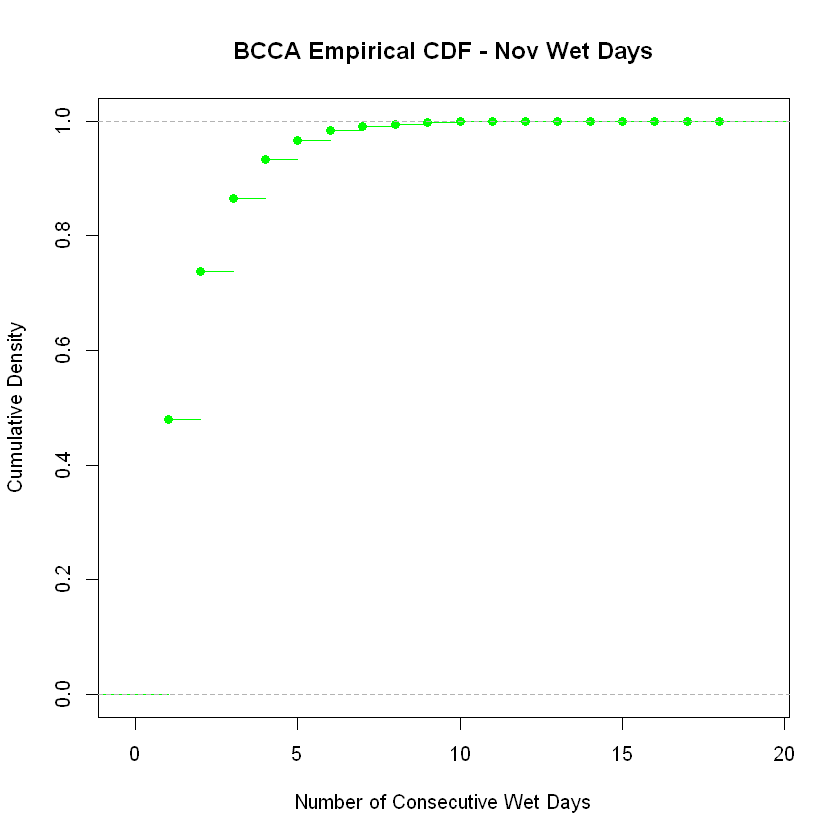

In [164]:
plot(ecdf(dBCNov$Wet_Count), main="BCCA Empirical CDF - Nov Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

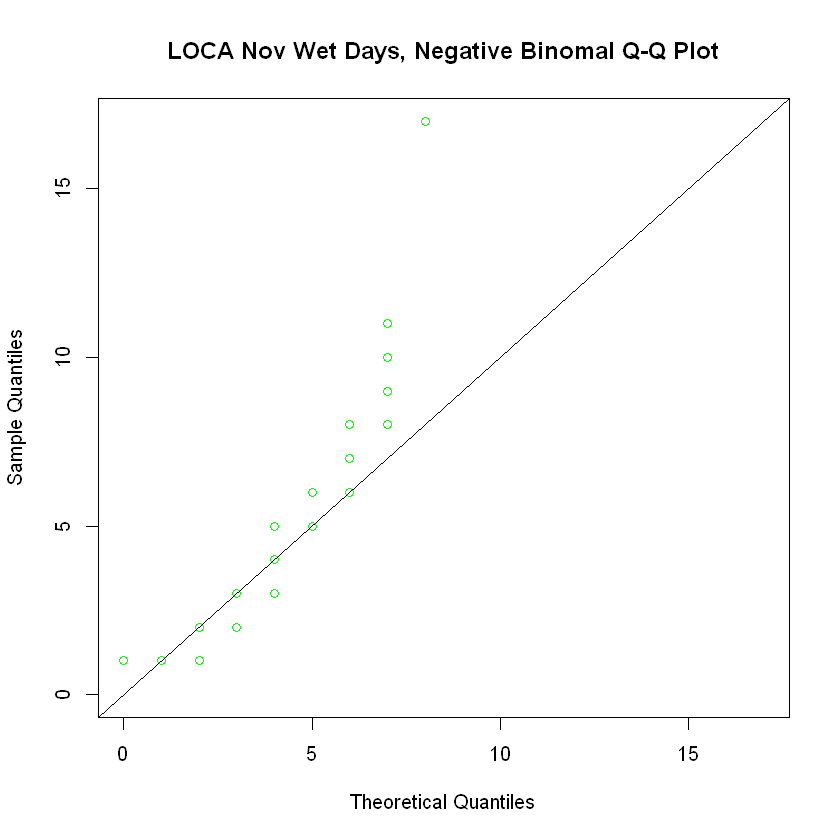

In [165]:
dLONovMax <- max( dLONov$Wet_Count )
dLONovMean <- mean( dLONov$Wet_Count )
dLONovVar <- var( dLONov$Wet_Count )
dLONovBNr <- dLONovMean^2 / abs(dLONovVar - dLONovMean)
dLONovTstNB <- rnbinom( 1000, mu=dLONovMean, size=dLONovBNr )
qqplot( dLONovTstNB, dLONov$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Nov Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLONovMax), ylim=c(0,dLONovMax) )
abline( 0, 1)

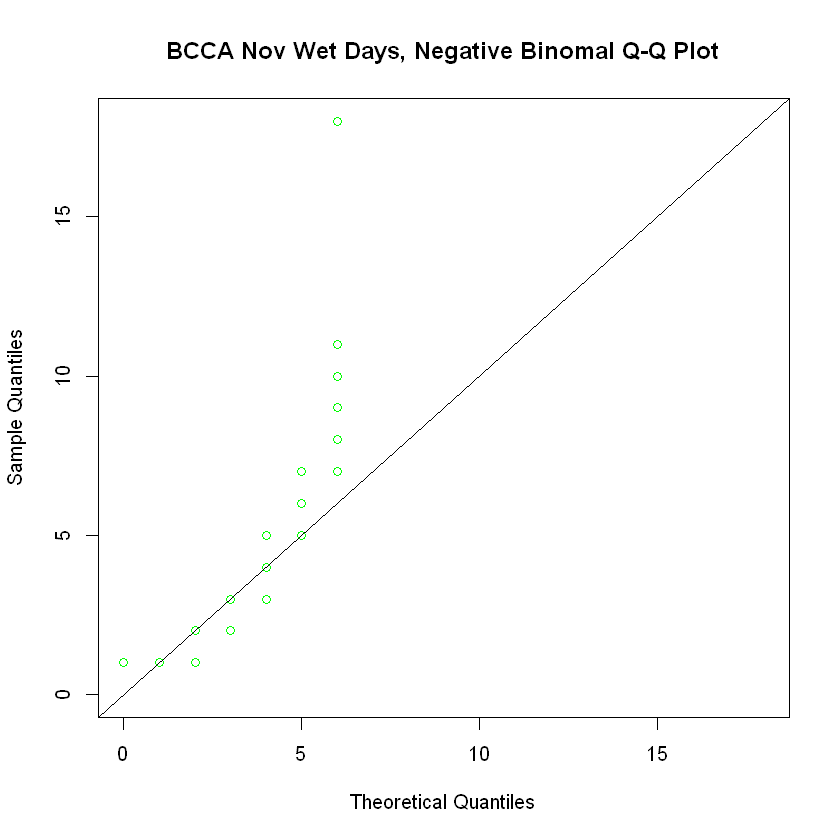

In [166]:
dBCNovMax <- max( dBCNov$Wet_Count )
dBCNovMean <- mean( dBCNov$Wet_Count )
dBCNovVar <- var( dBCNov$Wet_Count )
dBCNovBNr <- dBCNovMean^2 / abs(dBCNovVar - dBCNovMean)
dBCNovTstNB <- rnbinom( 1000, mu=dBCNovMean, size=dBCNovBNr )
qqplot( dBCNovTstNB, dBCNov$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Nov Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCNovMax), ylim=c(0,dBCNovMax) )
abline( 0, 1)

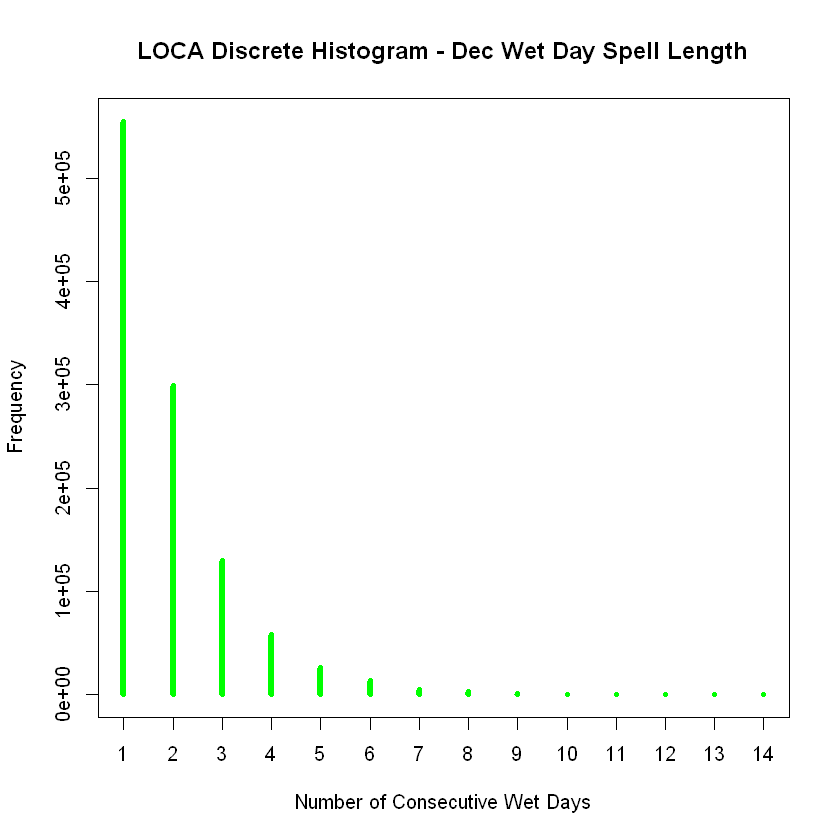

In [167]:
# our case is discrete so use this command
plot( table( dLODec$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Dec Wet Day Spell Length", 
      col="green" )

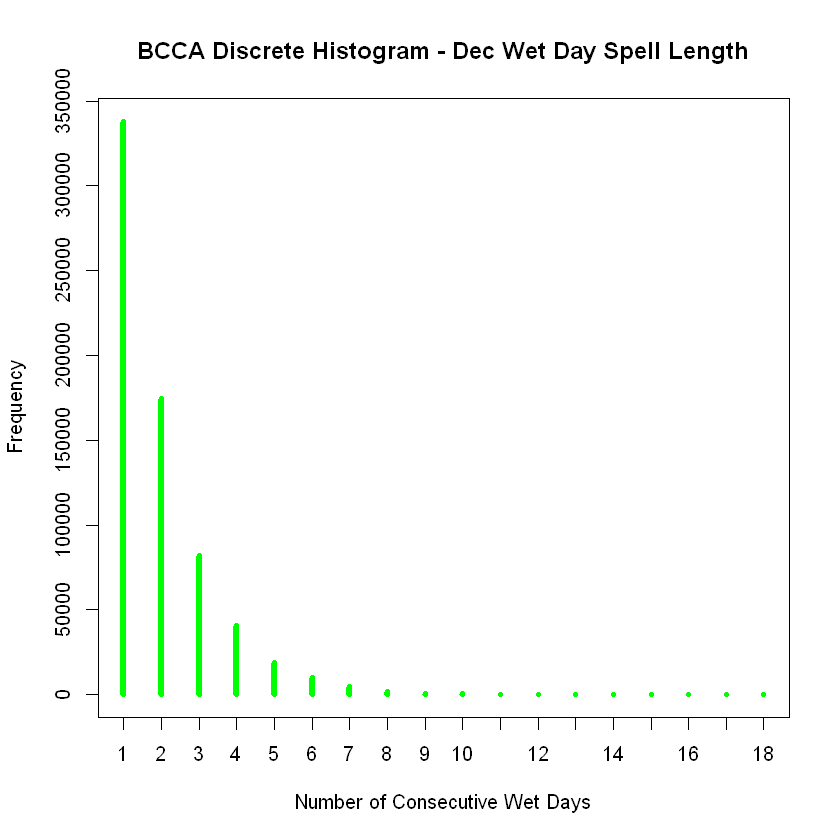

In [168]:
plot( table( dBCDec$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Dec Wet Day Spell Length", 
      col="green" )

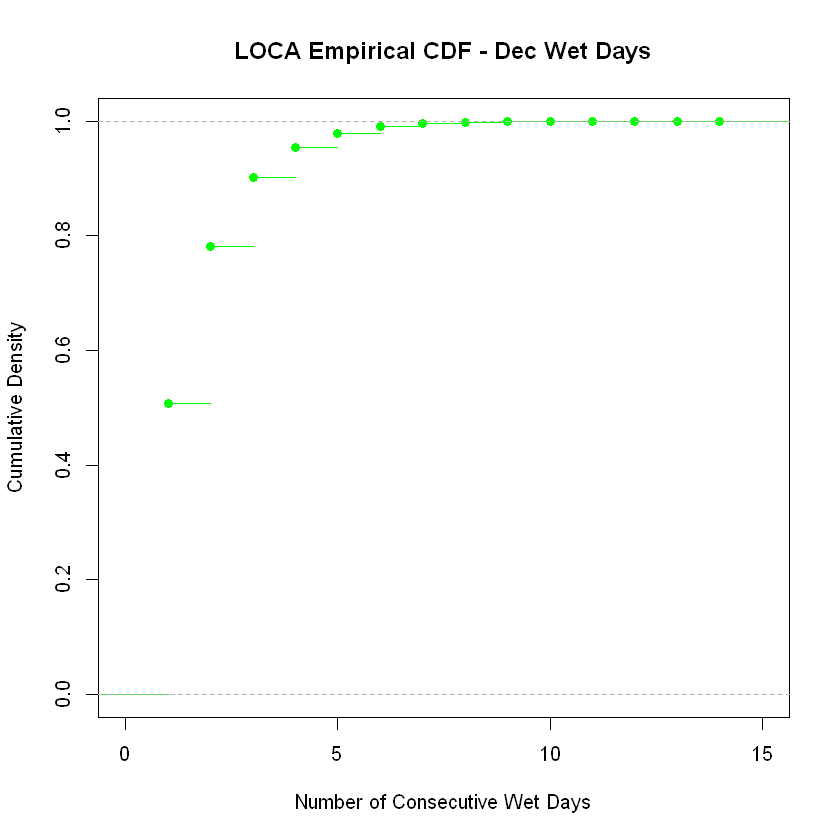

In [169]:
plot(ecdf(dLODec$Wet_Count), main="LOCA Empirical CDF - Dec Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

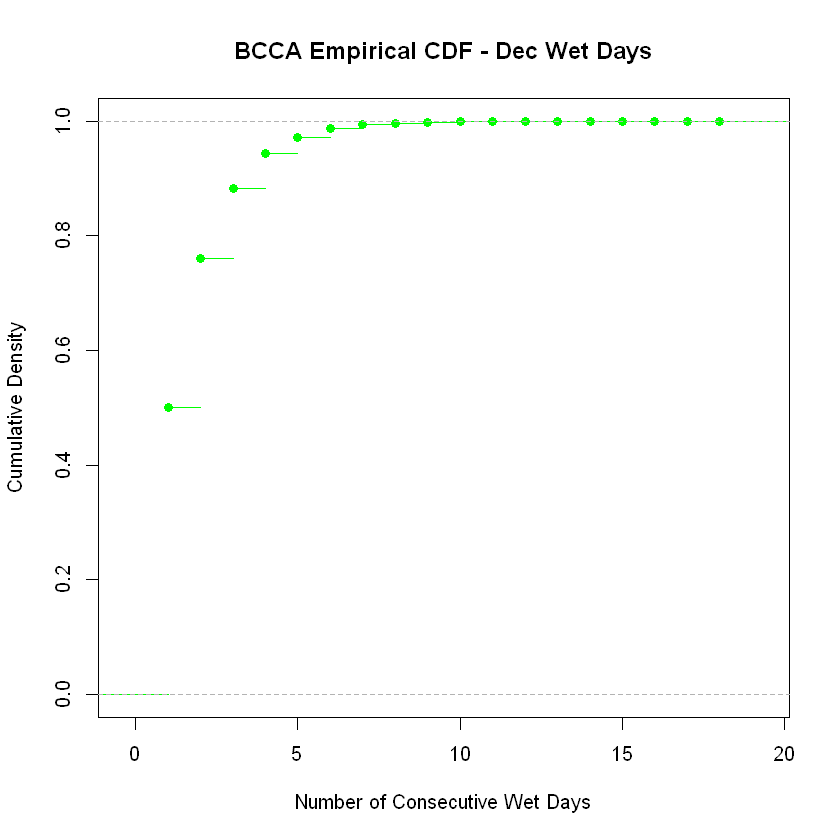

In [170]:
plot(ecdf(dBCDec$Wet_Count), main="BCCA Empirical CDF - Dec Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

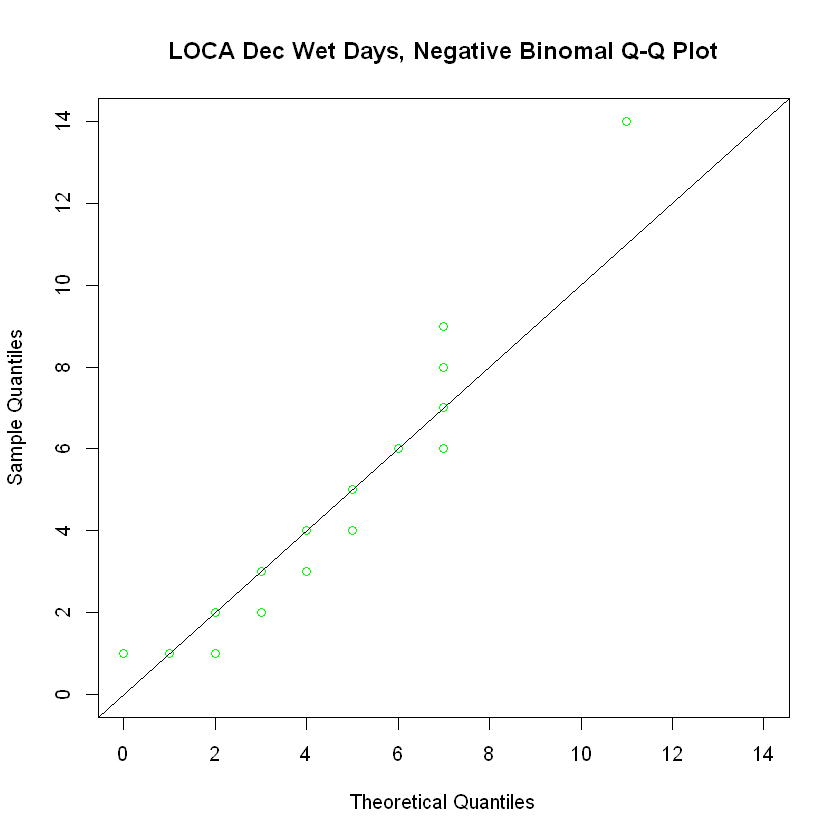

In [171]:
dLODecMax <- max( dLODec$Wet_Count )
dLODecMean <- mean( dLODec$Wet_Count )
dLODecVar <- var( dLODec$Wet_Count )
dLODecBNr <- dLODecMean^2 / abs(dLODecVar - dLODecMean)
dLODecTstNB <- rnbinom( 1000, mu=dLODecMean, size=dLODecBNr )
qqplot( dLODecTstNB, dLODec$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Dec Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLODecMax), ylim=c(0,dLODecMax) )
abline( 0, 1)

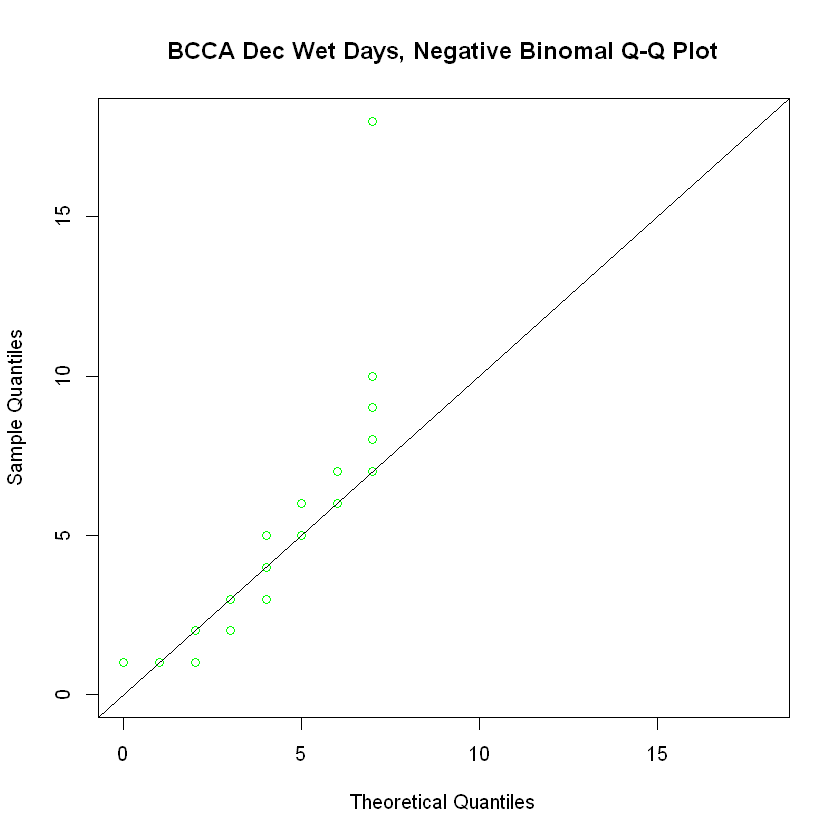

In [172]:
dBCDecMax <- max( dBCDec$Wet_Count )
dBCDecMean <- mean( dBCDec$Wet_Count )
dBCDecVar <- var( dBCDec$Wet_Count )
dBCDecBNr <- dBCDecMean^2 / abs(dBCDecVar - dBCDecMean)
dBCDecTstNB <- rnbinom( 1000, mu=dBCDecMean, size=dBCDecBNr )
qqplot( dBCDecTstNB, dBCDec$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Dec Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCDecMax), ylim=c(0,dBCDecMax) )
abline( 0, 1)

In [173]:
cat("LOCA Jan scale: ", dLOJanBNr, "\n", "LOCA Feb scale: ", dLOFebBNr, "\n",
    "LOCA Mar scale: ", dLOMarBNr, "\n", "LOCA Apr scale: ", dLOAprBNr, "\n",
    "LOCA May scale: ", dLOMayBNr, "\n", "LOCA Jun scale: ", dLOJunBNr, "\n",
    "LOCA Jul scale: ", dLOJulBNr, "\n", "LOCA Aug scale: ", dLOAugBNr, "\n",
    "LOCA Sep scale: ", dLOSepBNr, "\n", "LOCA Oct scale: ", dLOOctBNr, "\n",
    "LOCA Nov scale: ", dLONovBNr, "\n", "LOCA Dec scale: ", dLODecBNr, "\n" )

LOCA Jan scale:  7.215064 
 LOCA Feb scale:  11.28372 
 LOCA Mar scale:  12.93902 
 LOCA Apr scale:  5.96375 
 LOCA May scale:  3.264539 
 LOCA Jun scale:  2.580594 
 LOCA Jul scale:  2.607539 
 LOCA Aug scale:  3.0181 
 LOCA Sep scale:  2.758973 
 LOCA Oct scale:  6.716813 
 LOCA Nov scale:  667.3403 
 LOCA Dec scale:  10.91745 


In [174]:
cat("BCCA Jan scale: ", dBCJanBNr, "\n", "BCCA Feb scale: ", dBCFebBNr, "\n",
    "BCCA Mar scale: ", dBCMarBNr, "\n", "BCCA Apr scale: ", dBCAprBNr, "\n",
    "BCCA May scale: ", dBCMayBNr, "\n", "BCCA Jun scale: ", dBCJunBNr, "\n",
    "BCCA Jul scale: ", dBCJulBNr, "\n", "BCCA Aug scale: ", dBCAugBNr, "\n",
    "BCCA Sep scale: ", dBCSepBNr, "\n", "BCCA Oct scale: ", dBCOctBNr, "\n",
    "BCCA Nov scale: ", dBCNovBNr, "\n", "BCCA Dec scale: ", dBCDecBNr, "\n" )

BCCA Jan scale:  79.41417 
 BCCA Feb scale:  65.70722 
 BCCA Mar scale:  27.86106 
 BCCA Apr scale:  2.160967 
 BCCA May scale:  1.457214 
 BCCA Jun scale:  1.61118 
 BCCA Jul scale:  1.509936 
 BCCA Aug scale:  1.514489 
 BCCA Sep scale:  1.918849 
 BCCA Oct scale:  3.224386 
 BCCA Nov scale:  78.41063 
 BCCA Dec scale:  32.63921 


### Fitting Negative Binomial Distributions

Use the **fitdistrplus** package for distribution fitting. This also provides the *plotdist* function which provides a pair of plots: 

1. empirical density, or a histogram
2. empirical cumulative distribution

These plots were provided above from scratch. **fitdistrplus** also provides a *descdist* function that provides classical descriptive statistics for the sample.

Distributions are then fit using a Maximum Likelihood Estimation (MLE) estimator in the *fitdist* function. Then goodness-of-fit statistics are calculated using the *gofstat* function.

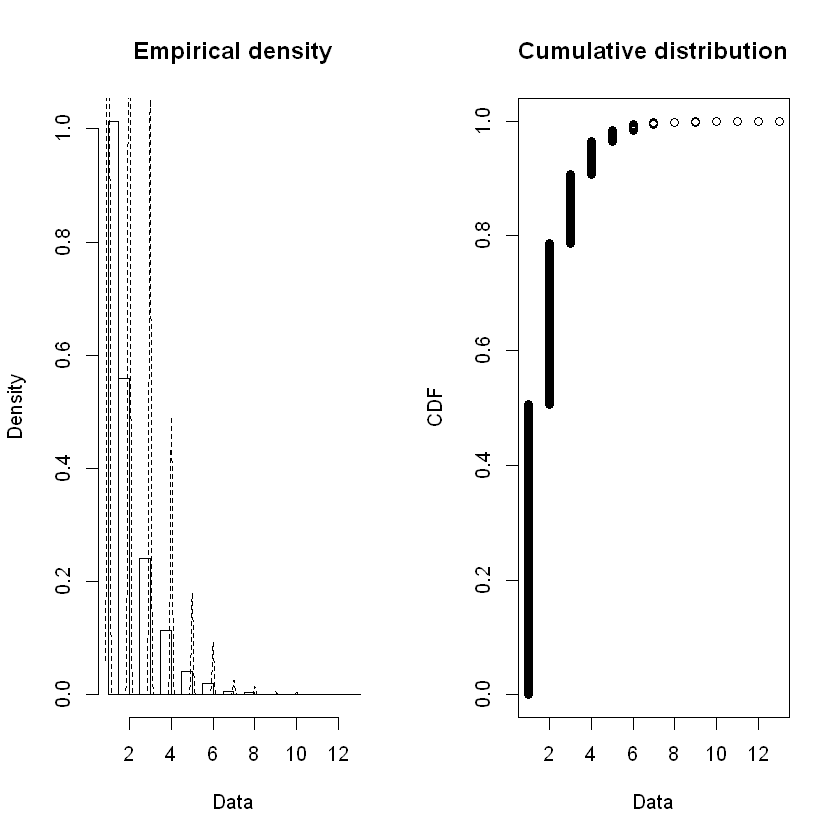

In [175]:
plotdist( dLOJan$Wet_Count, histo=TRUE, demp=TRUE )

In [176]:
LOfd_NB_dJan <- fitdist( dLOJan$Wet_Count, "nbinom" )
LOfd_GE_dJan <- fitdist( dLOJan$Wet_Count, "geom" )

In [177]:
summary( LOfd_NB_dJan )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
         estimate  Std. Error
size 2.535299e+05         NaN
mu   1.862262e+00 0.001355273
Loglikelihood:  -1538697   AIC:  3077398   BIC:  3077422 
Correlation matrix:
     size  mu
size    1 NaN
mu    NaN   1


In [178]:
LOfdNB_dJan_size <- LOfd_NB_dJan$estimate[["size"]]
LOfdNB_dJan_mu <- LOfd_NB_dJan$estimate[["mu"]]
cat("LOCA Jan size: ", LOfdNB_dJan_size, "\n", "LOCA Jan mu: ", LOfdNB_dJan_mu, "\n")

LOCA Jan size:  253529.9 
 LOCA Jan mu:  1.862262 


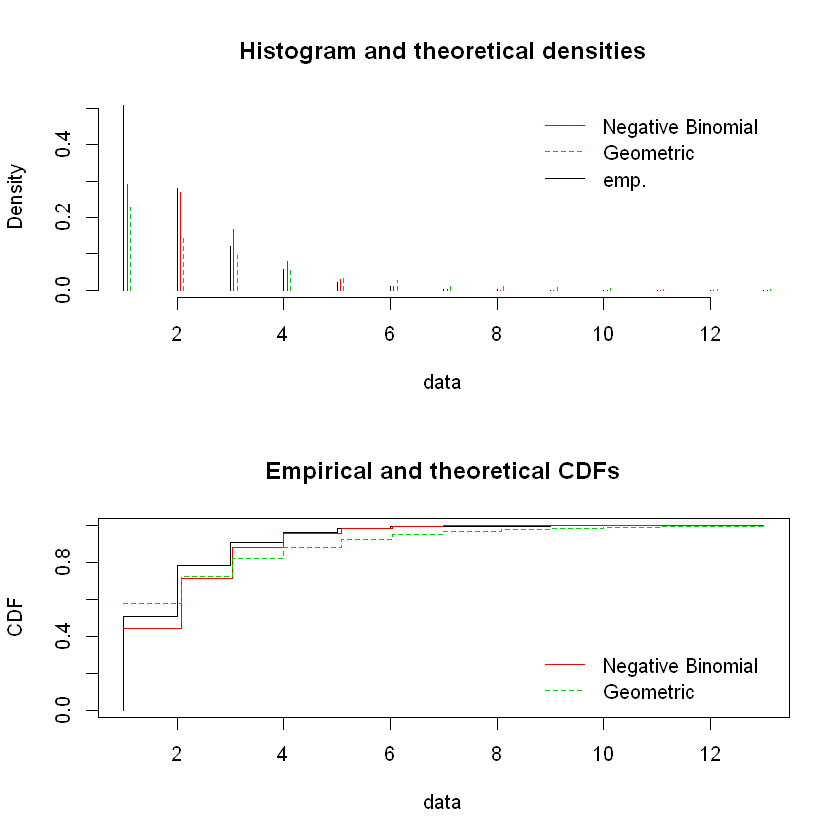

In [179]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dJan, LOfd_GE_dJan), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dJan, LOfd_GE_dJan), legendtext=plot.legend )

In [180]:
LOstatRes <- gofstat( list(LOfd_NB_dJan, LOfd_GE_dJan), fitnames=c("Negative Binomial", "Geometric") )

In [181]:
print(LOstatRes)

Chi-squared statistic:  36831.07 194505.3 
Degree of freedom of the Chi-squared distribution:  5 6 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    513810            450788.7934      584782.15
<= 2    283570            273094.2531      149963.01
<= 3    122231            169524.4013       97566.46
<= 4     57901             78925.0479       63477.09
<= 5     20635             29396.0643       41298.41
<= 6     10188              9123.9730       26868.89
<= 7      2883              2427.3573       17481.00
> 7       2770               708.1096       32550.98

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           3077398   3755755
Bayesian Information Criterion           3077422   3755767


In [182]:
LOfdNB_dJan_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

[Chi-Squared Test](https://www.r-bloggers.com/chi-squared-test/)

Like all statistical tests, chi-squared test assumes a null hypothesis and an alternate hypothesis. The general practice is, if the p-value that comes out in the result is less than a pre-determined significance level, which is 0.05 usually, then we reject the null hypothesis.

- H0: The The two variables are independent
- H1: The two variables are related.

The null hypothesis of the chi-squared test is that the two variables are independent and the alternate hypothesis is that they are related.

In this case our p-value is 0.0 and we can reject the null hypothesis that sample and MLE-fit distribution are not related.

In [183]:
LOfdNB_dJan_p = LOfdNB_dJan_size / (LOfdNB_dJan_size + LOfdNB_dJan_mu)
cat("LOCA prob: ", LOfdNB_dJan_p)

LOCA prob:  0.9999927

In [184]:
# add to our tracking dataframe
LOMonDistDF[1, ] <- list( 1, dLOJanMean, dLOJanBNr, LOfdNB_dJan_p, LOfdNB_dJan_mu, LOfdNB_dJan_size,
                          LOfdNB_dJan_pvalue )

In [185]:
LOgf_dJan <- goodfit( dLOJan$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dJan_size, prob=LOfdNB_dJan_p) )

In [186]:
summary( LOgf_dJan )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          376312.8 13        0
Likelihood Ratio 479735.0 12        0


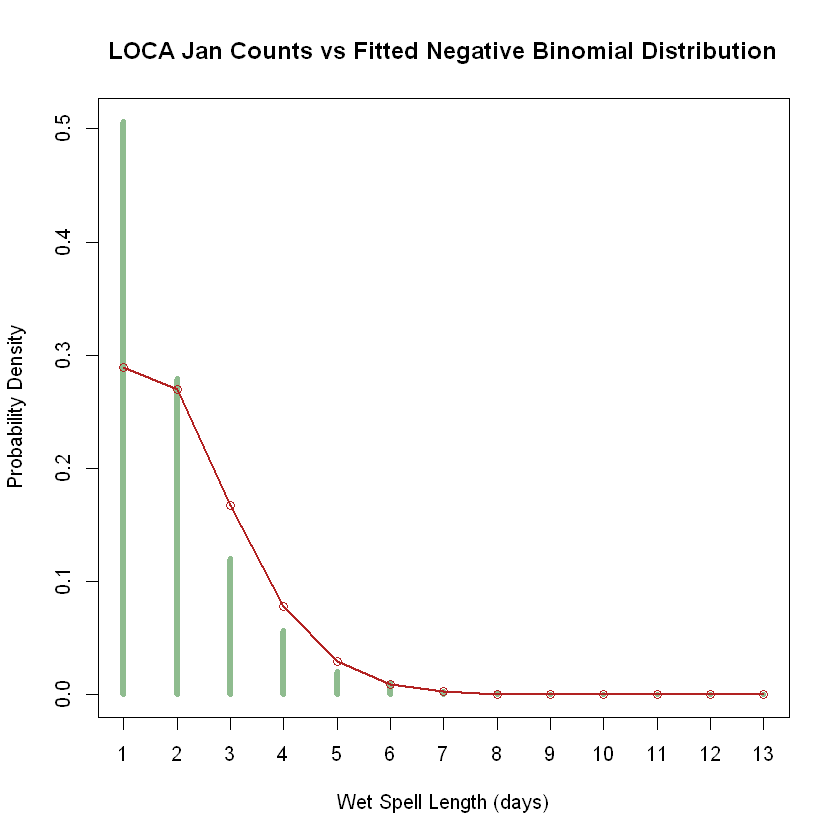

In [187]:
maxP <- max(dLOJan$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dJan_size, mu=LOfdNB_dJan_mu )
ttab <- table( dLOJan$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Jan Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

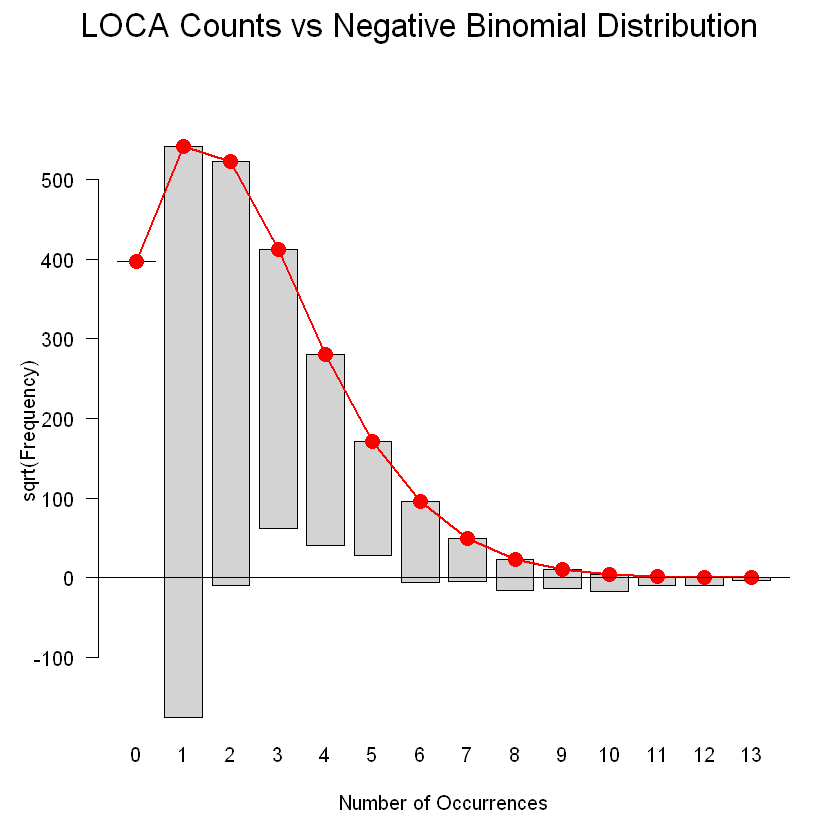

In [188]:
plot( LOgf_dJan, main="LOCA Counts vs Negative Binomial Distribution" )

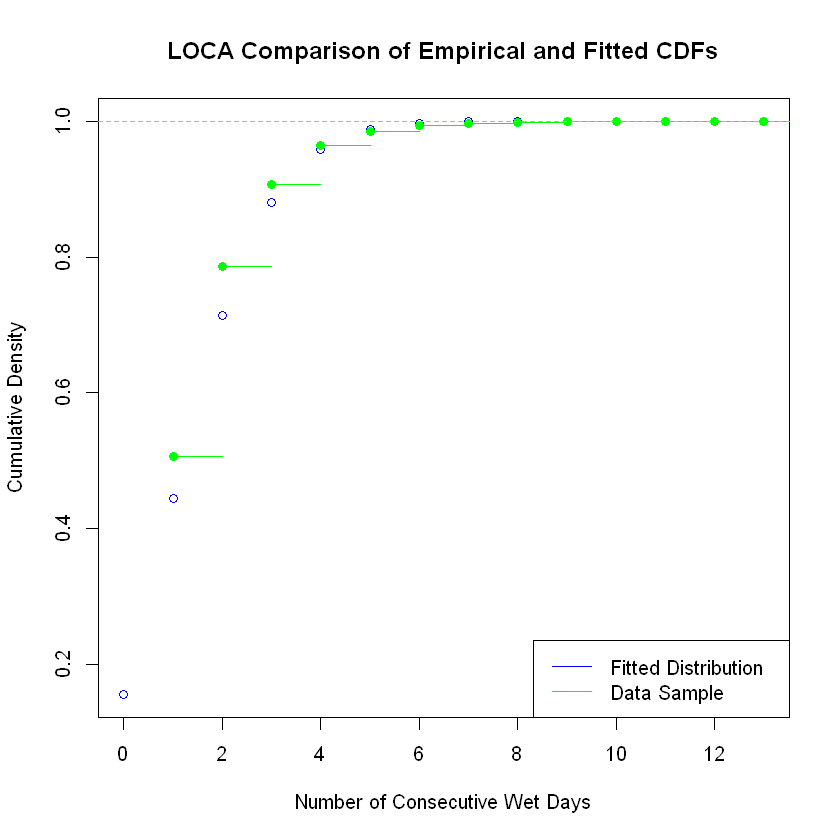

In [189]:
x <- seq(0,dLOJanMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dJan_mu, size=LOfdNB_dJan_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOJan$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

In [190]:
ks.test( dLOJan$Wet_Count, "pnbinom", mu=LOfdNB_dJan_mu, size=LOfdNB_dJan_size )


	One-sample Kolmogorov-Smirnov test

data:  dLOJan$Wet_Count
D = 0.44457, p-value < 2.2e-16
alternative hypothesis: two-sided


Generally, K-S test is better for continuous distributions.

[Kolmogorv-Smirnov Test](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/ks.test.html)

Null hypothesis that the true distribution function of x is equal to the hypothesized distribution function (one-sample case). This is a comparison of cumulative distribution functions, and the test statistic is the maximum difference in value, with the statistic in the "greater" alternative being D^+ = max[F_x(u) - F_y(u)]

Exact p-values are not available for the two-sample case if one-sided or in the presence of ties. If exact = NULL (the default), an exact p-value is computed if the sample size is less than 100 in the one-sample case and there are no ties, and if the product of the sample sizes is less than 10000 in the two-sample case. Otherwise, asymptotic distributions are used whose approximations may be inaccurate in small samples.

The Kolmogorov–Smirnov statistic quantifies a distance between the empirical distribution function of the sample and the cumulative distribution function of the reference distribution, or between the empirical distribution functions of two samples. The null distribution of this statistic is calculated under the null hypothesis that the sample is drawn from the reference distribution (in the one-sample case) or that the samples are drawn from the same distribution (in the two-sample case). In the one-sample case, the distribution considered under the null hypothesis may be continuous (see Section 2), purely discrete or mixed (see Section 2.2).

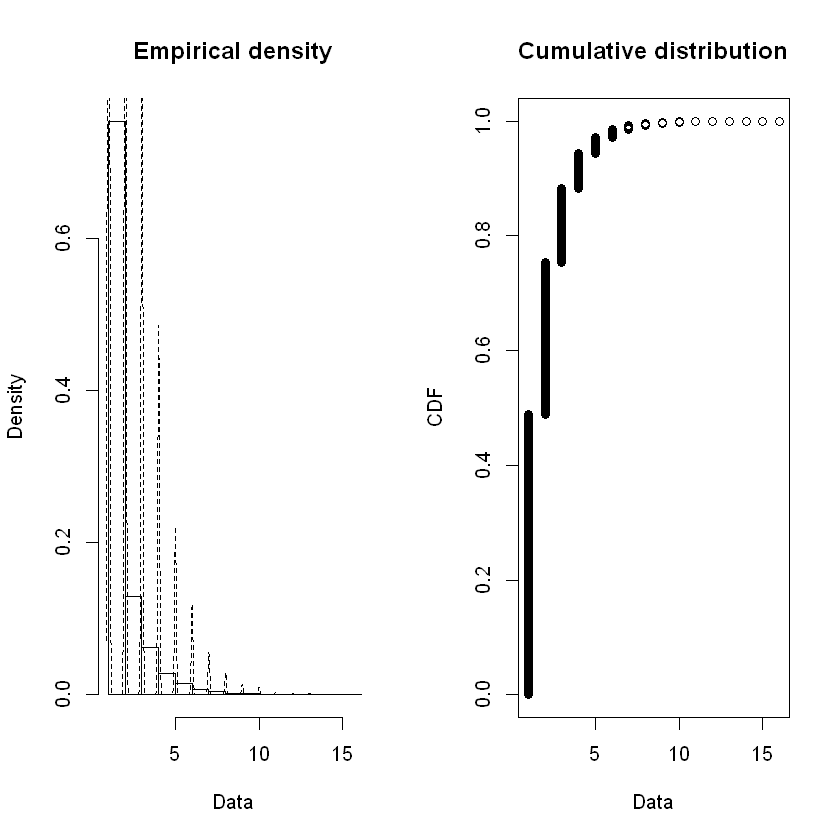

In [191]:
plotdist( dBCJan$Wet_Count, histo=TRUE, demp=TRUE )

In [192]:
BCfd_NB_dJan <- fitdist( dBCJan$Wet_Count, "nbinom" )
BCfd_GE_dJan <- fitdist( dBCJan$Wet_Count, "geom" )

In [193]:
summary( BCfd_NB_dJan )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
         estimate  Std. Error
size 309044.20758 3.353113462
mu        1.99267 0.001682067
Loglikelihood:  -1138654   AIC:  2277313   BIC:  2277336 
Correlation matrix:
              size            mu
size  1.000000e+00 -8.864119e-06
mu   -8.864119e-06  1.000000e+00


In [194]:
BCfdNB_dJan_size <- BCfd_NB_dJan$estimate[["size"]]
BCfdNB_dJan_mu <- BCfd_NB_dJan$estimate[["mu"]]
cat("BCCA Jan size: ", BCfdNB_dJan_size, "\n", "BCCA Jan mu: ", BCfdNB_dJan_mu, "\n")

BCCA Jan size:  309044.2 
 BCCA Jan mu:  1.99267 


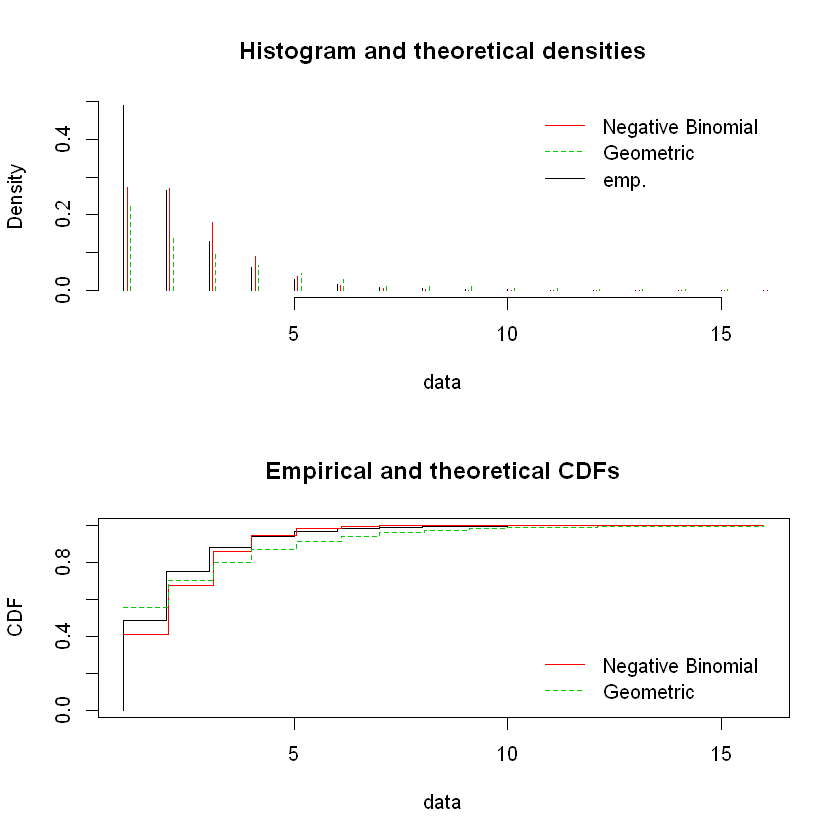

In [195]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dJan, BCfd_GE_dJan), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dJan, BCfd_GE_dJan), legendtext=plot.legend )

In [196]:
BCstatRes <- gofstat( list(BCfd_NB_dJan, BCfd_GE_dJan), fitnames=c("Negative Binomial", "Geometric") )

In [197]:
print(BCstatRes)

Chi-squared statistic:  173693.7 109229.6 
Degree of freedom of the Chi-squared distribution:  7 8 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     344406           2.872983e+05     391938.038
<= 2     186109           1.905955e+05     104321.350
<= 3      90609           1.265979e+05      69466.256
<= 4      43249           6.306717e+04      46256.694
<= 5      19354           2.513457e+04      30801.742
<= 6      10066           8.347565e+03      20510.487
<= 7       4977           2.376308e+03      13657.672
<= 8       2514           5.919092e+02       9094.469
<= 10      2089           1.571715e+02      10088.432
> 10        799           5.656832e+00       8036.860

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2277313   2685293
Bayesian Information Criterion           2277336   2685304


In [198]:
BCfdNB_dJan_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [199]:
BCfdNB_dJan_p = BCfdNB_dJan_size / (BCfdNB_dJan_size + BCfdNB_dJan_mu)
cat("BCCA prob: ", BCfdNB_dJan_p)

BCCA prob:  0.9999936

In [200]:
# add to our tracking dataframe
BCMonDistDF[1, ] <- list( 1, dBCJanMean, dBCJanBNr, BCfdNB_dJan_p, BCfdNB_dJan_mu, BCfdNB_dJan_size,
                          BCfdNB_dJan_pvalue )

In [201]:
BCgf_dJan <- goodfit( dBCJan$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dJan_size, prob=BCfdNB_dJan_p) )

In [202]:
summary( BCgf_dJan )


	 Goodness-of-fit test for nbinomial distribution

                        X^2 df P(> X^2)
Pearson          39827099.3 16        0
Likelihood Ratio   333595.1 15        0


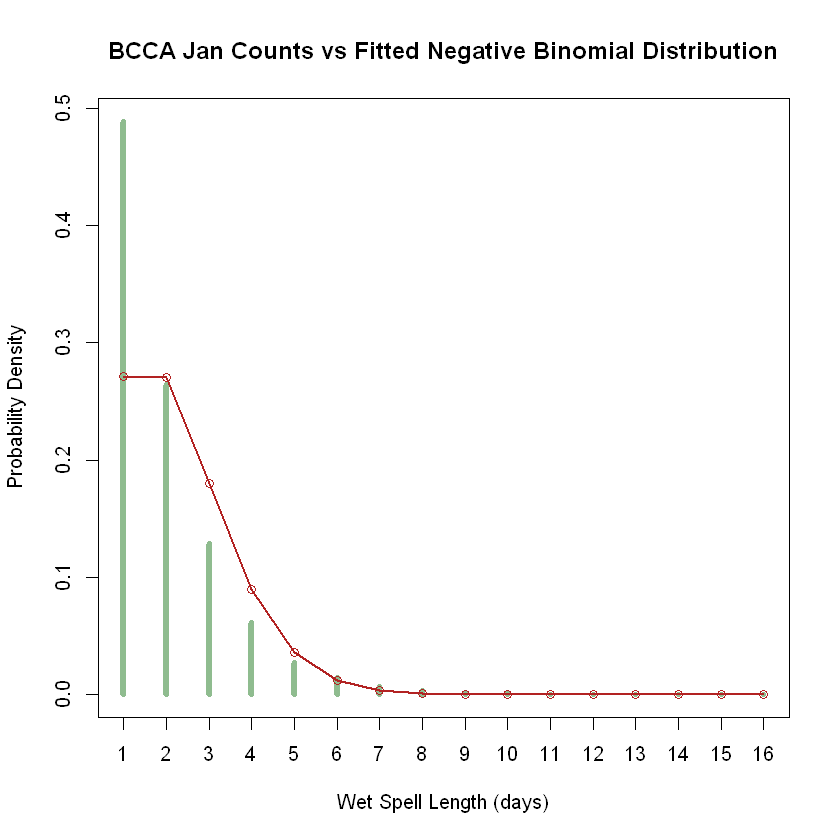

In [203]:
maxP <- max(dBCJan$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dJan_size, mu=BCfdNB_dJan_mu )
ttab <- table( dBCJan$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Jan Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

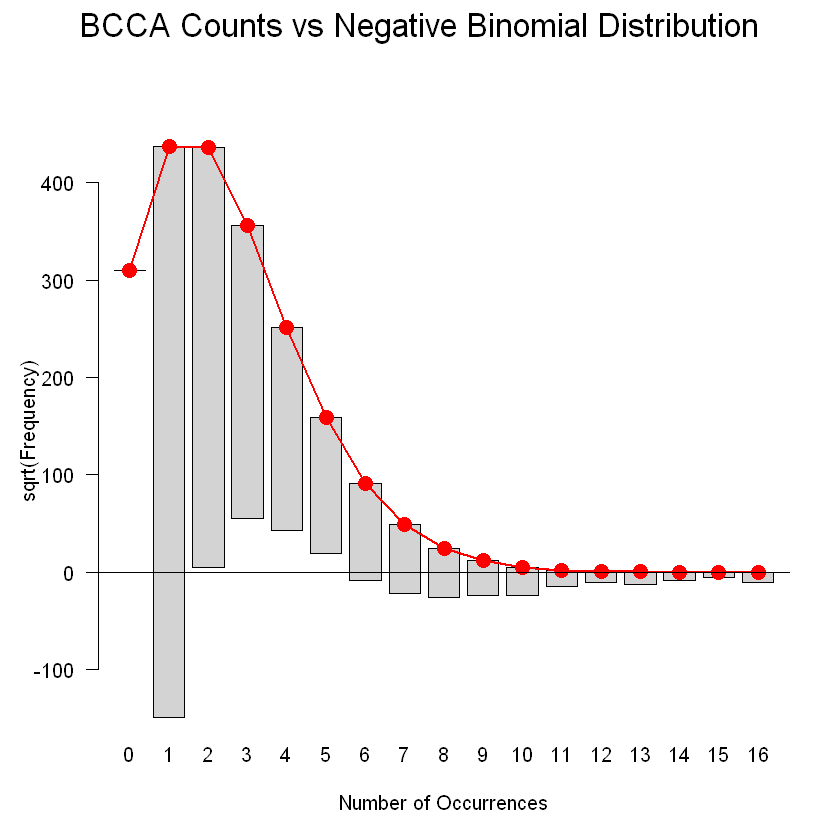

In [204]:
plot( BCgf_dJan, main="BCCA Counts vs Negative Binomial Distribution" )

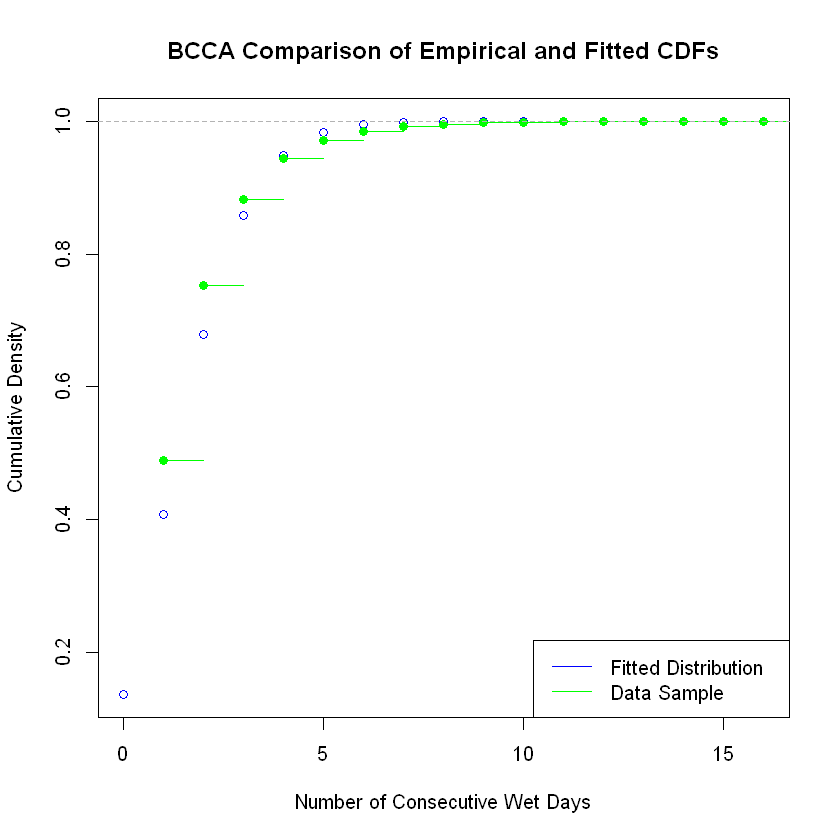

In [205]:
x <- seq(0,dBCJanMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dJan_mu, size=BCfdNB_dJan_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCJan$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

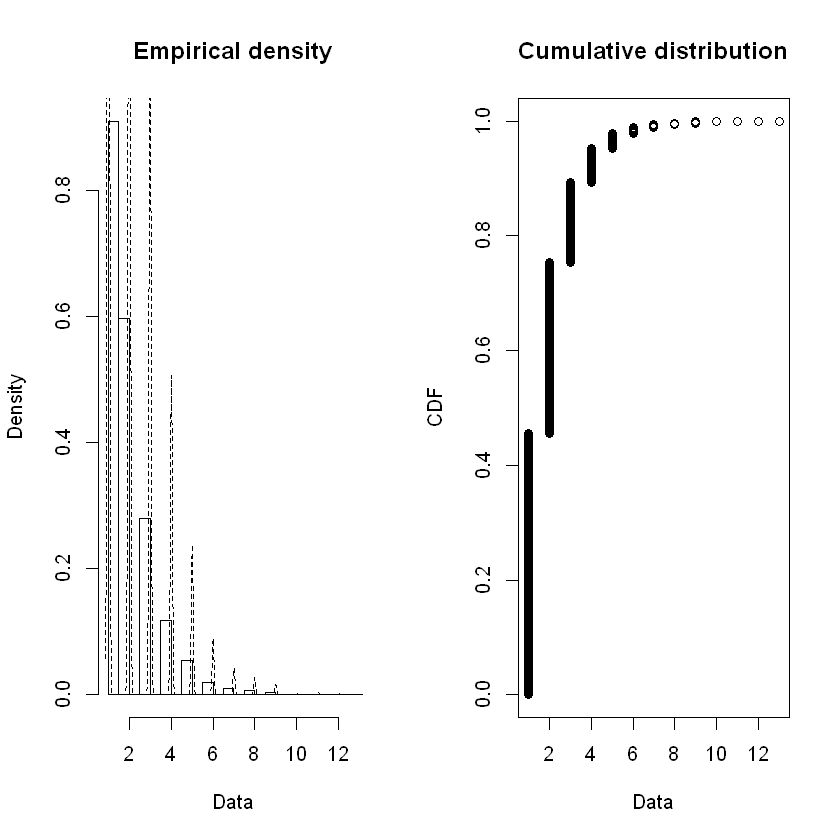

In [206]:
plotdist( dLOFeb$Wet_Count, histo=TRUE, demp=TRUE )

In [207]:
LOfd_NB_dFeb <- fitdist( dLOFeb$Wet_Count, "nbinom" )
LOfd_GE_dFeb <- fitdist( dLOFeb$Wet_Count, "geom" )

In [208]:
LOfdNB_dFeb_size <- LOfd_NB_dFeb$estimate[["size"]]
LOfdNB_dFeb_mu <- LOfd_NB_dFeb$estimate[["mu"]]
cat("LOCA Feb size: ", LOfdNB_dFeb_size, "\n", "LOCA Feb mu: ", LOfdNB_dFeb_mu, "\n")

LOCA Feb size:  8404404 
 LOCA Feb mu:  1.986097 


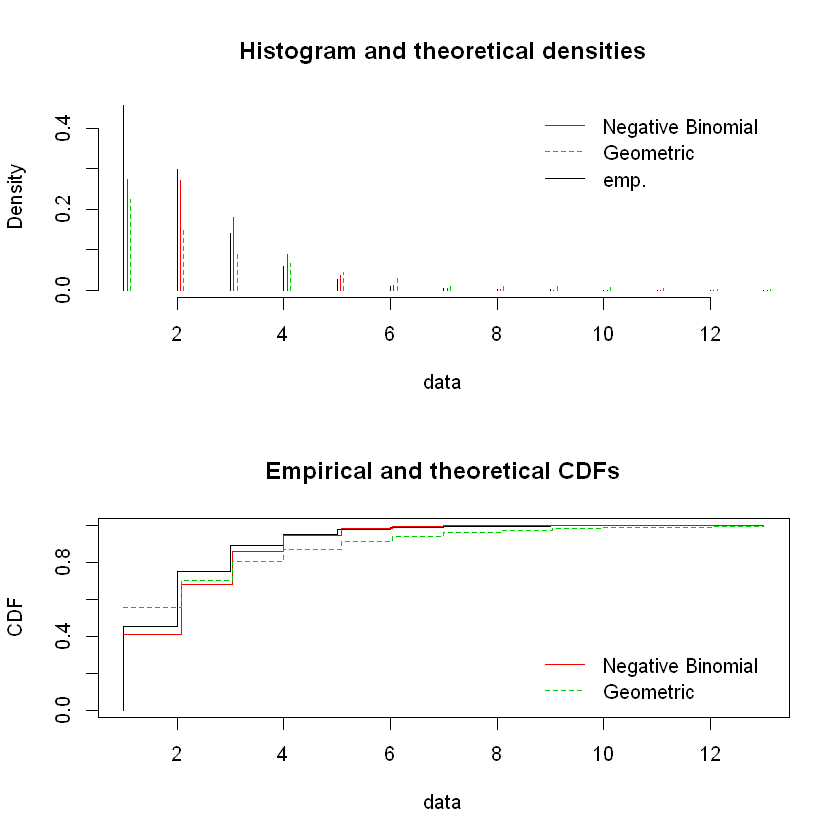

In [209]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dFeb, LOfd_GE_dFeb), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dFeb, LOfd_GE_dFeb), legendtext=plot.legend )

In [210]:
LOstatRes <- gofstat( list(LOfd_NB_dFeb, LOfd_GE_dFeb), fitnames=c("Negative Binomial", "Geometric") )

In [211]:
print( LOstatRes )

Chi-squared statistic:  70192.22 254332.9 
Degree of freedom of the Chi-squared distribution:  6 7 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    467187            420513.0410      572216.87
<= 2    306840            277745.0992      152025.25
<= 3    143279            183876.2419      101115.13
<= 4     60311             91299.0268       67253.75
<= 5     27588             36265.7544       44731.85
<= 6     10091             12004.5557       29752.08
<= 7      4826              3406.0320       19788.72
<= 8      3033               845.5893       13161.88
> 8       3032               231.6596       26141.47

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           3233873   3907539
Bayesian Information Criterion           3233896   3907551


In [212]:
LOfdNB_dFeb_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [213]:
LOfdNB_dFeb_p = LOfdNB_dFeb_size / (LOfdNB_dFeb_size + LOfdNB_dFeb_mu)
cat("LOCA prob: ", LOfdNB_dFeb_p)

LOCA prob:  0.9999998

In [214]:
# add to our tracking dataframe
LOMonDistDF[2, ] <- list( 2, dLOFebMean, dLOFebBNr, LOfdNB_dFeb_p, LOfdNB_dFeb_mu, LOfdNB_dFeb_size,
                          LOfdNB_dFeb_pvalue )

In [215]:
LOgf_dFeb <- goodfit( dLOFeb$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dFeb_size, prob=LOfdNB_dFeb_p) )

In [216]:
summary( LOgf_dFeb )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          496326.6 13        0
Likelihood Ratio 429751.7 12        0


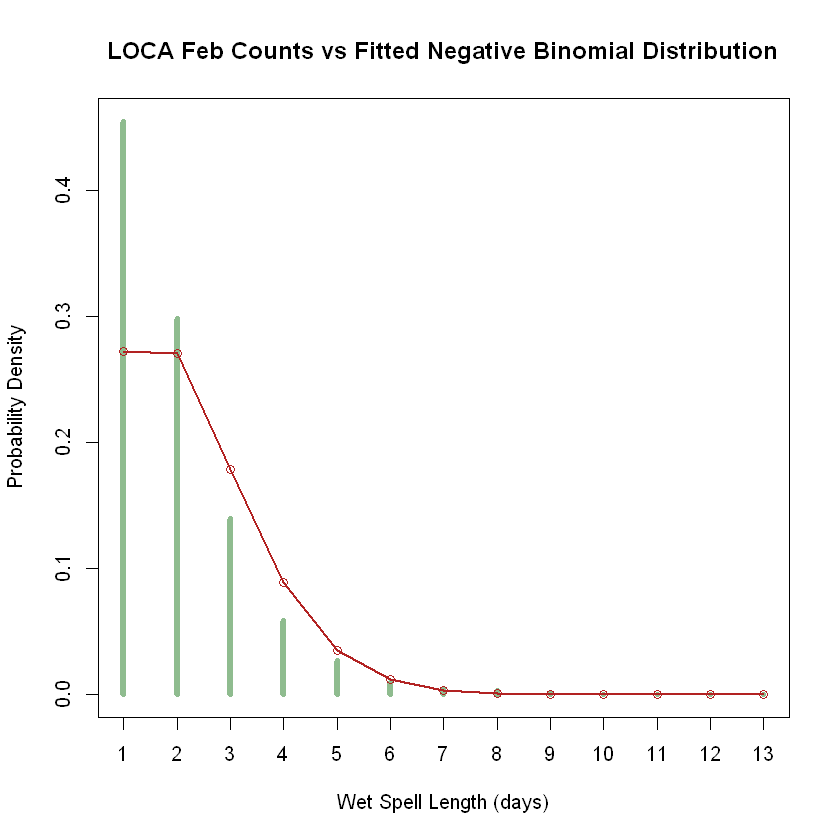

In [217]:
maxP <- max(dLOFeb$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dFeb_size, mu=LOfdNB_dFeb_mu )
ttab <- table( dLOFeb$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Feb Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

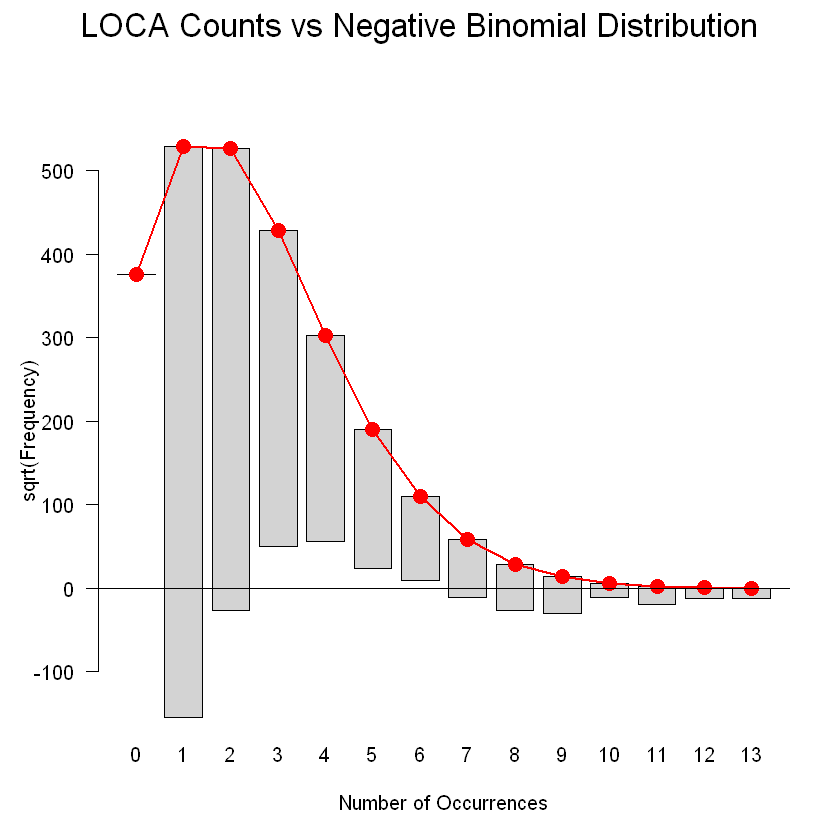

In [218]:
plot( LOgf_dFeb, main="LOCA Counts vs Negative Binomial Distribution" )

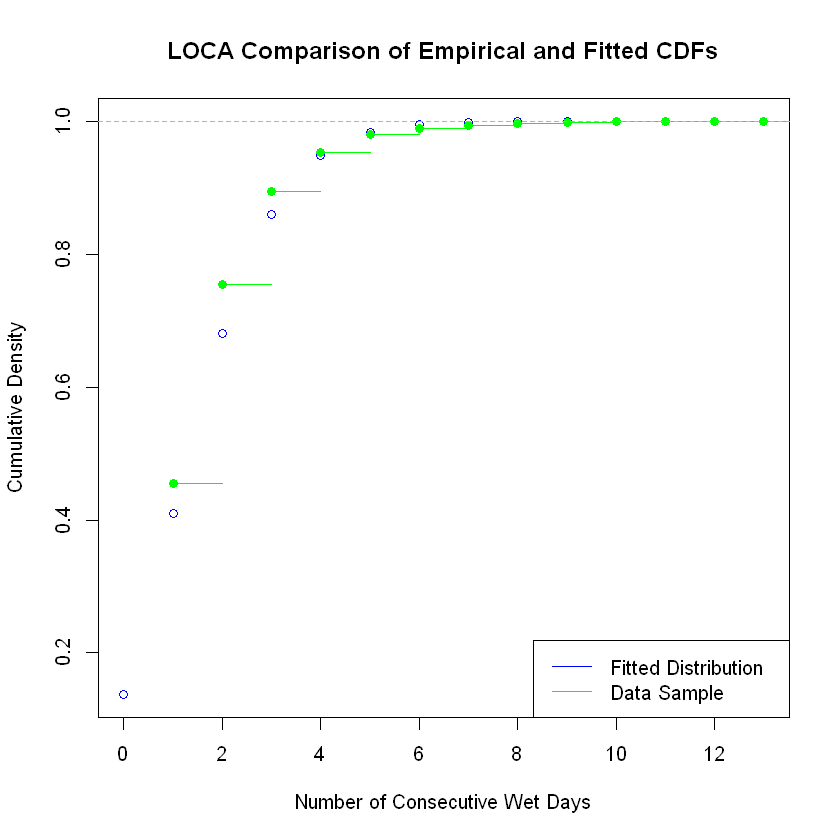

In [219]:
x <- seq(0,dLOFebMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dFeb_mu, size=LOfdNB_dFeb_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOFeb$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

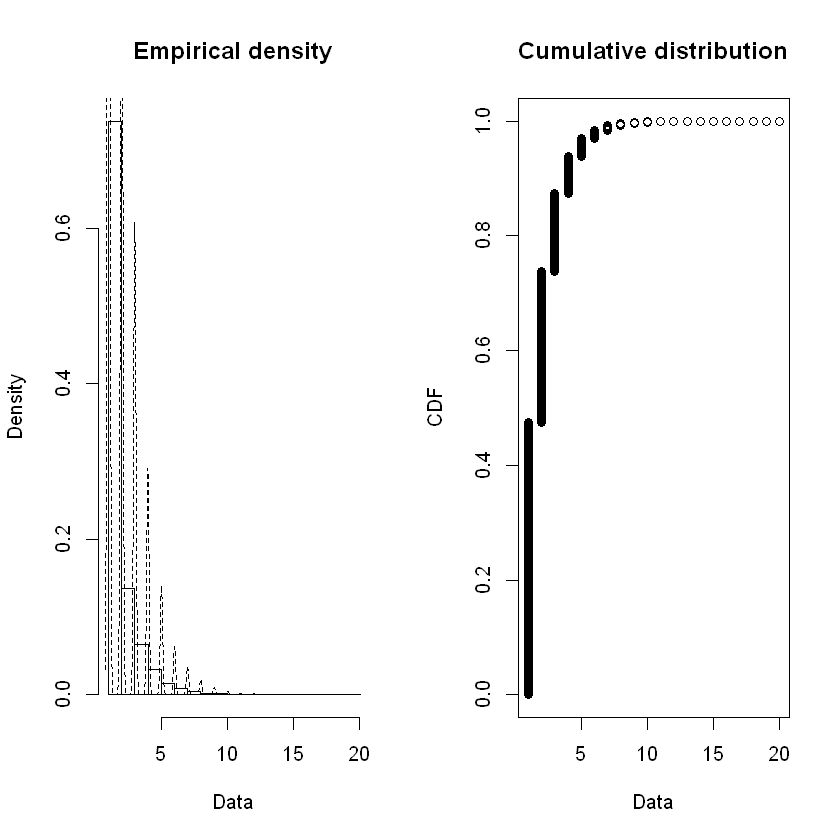

In [220]:
plotdist( dBCFeb$Wet_Count, histo=TRUE, demp=TRUE )

In [221]:
BCfd_NB_dFeb <- fitdist( dBCFeb$Wet_Count, "nbinom" )
BCfd_GE_dFeb <- fitdist( dBCFeb$Wet_Count, "geom" )

In [222]:
summary( BCfd_NB_dFeb )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
         estimate  Std. Error
size 2.743411e+05         NaN
mu   2.036861e+00 0.001722993
Loglikelihood:  -1119985   AIC:  2239974   BIC:  2239996 
Correlation matrix:
     size  mu
size    1 NaN
mu    NaN   1


In [223]:
BCfdNB_dFeb_size <- BCfd_NB_dFeb$estimate[["size"]]
BCfdNB_dFeb_mu <- BCfd_NB_dFeb$estimate[["mu"]]
cat("BCCA Feb size: ", BCfdNB_dFeb_size, "\n", "BCCA Feb mu: ", BCfdNB_dFeb_mu, "\n")

BCCA Feb size:  274341.1 
 BCCA Feb mu:  2.036861 


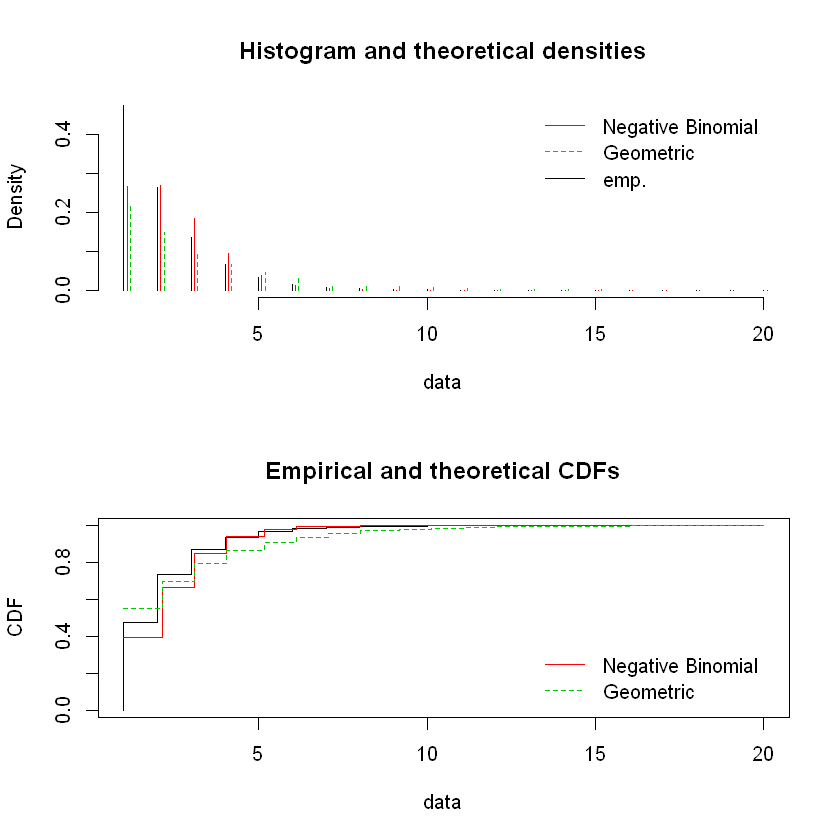

In [224]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dFeb, BCfd_GE_dFeb), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dFeb, BCfd_GE_dFeb), legendtext=plot.legend )

In [225]:
BCstatRes <- gofstat( list(BCfd_NB_dFeb, BCfd_GE_dFeb), fitnames=c("Negative Binomial", "Geometric") )

In [226]:
print(BCstatRes)

Chi-squared statistic:  67389.15 110003.1 
Degree of freedom of the Chi-squared distribution:  6 7 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    325489            271815.1772     377526.633
<= 2    180679            185668.7171     101646.783
<= 3     93344            126060.4091      68173.310
<= 4     44511             64192.0927      45723.042
<= 5     21840             26150.2549      30665.910
<= 6      9441              8877.4995      20567.267
<= 7      5361              2583.2128      13794.226
<= 8      2967               657.7174       9251.626
> 8       2559               185.9193      18842.203

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2239974   2640859
Bayesian Information Criterion           2239996   2640870


In [227]:
BCfdNB_dFeb_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [228]:
BCfdNB_dFeb_p = BCfdNB_dFeb_size / (BCfdNB_dFeb_size + BCfdNB_dFeb_mu)
cat("BCCA prob: ", BCfdNB_dFeb_p)

BCCA prob:  0.9999926

In [229]:
# add to our tracking dataframe
BCMonDistDF[2, ] <- list( 2, dBCFebMean, dBCFebBNr, BCfdNB_dFeb_p, BCfdNB_dFeb_mu, BCfdNB_dFeb_size,
                          BCfdNB_dFeb_pvalue )

In [230]:
BCgf_dFeb <- goodfit( dBCFeb$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dFeb_size, prob=BCfdNB_dFeb_p) )

In [231]:
summary( BCgf_dFeb )


	 Goodness-of-fit test for nbinomial distribution

                          X^2 df P(> X^2)
Pearson          9382760339.3 20        0
Likelihood Ratio     305238.4 19        0


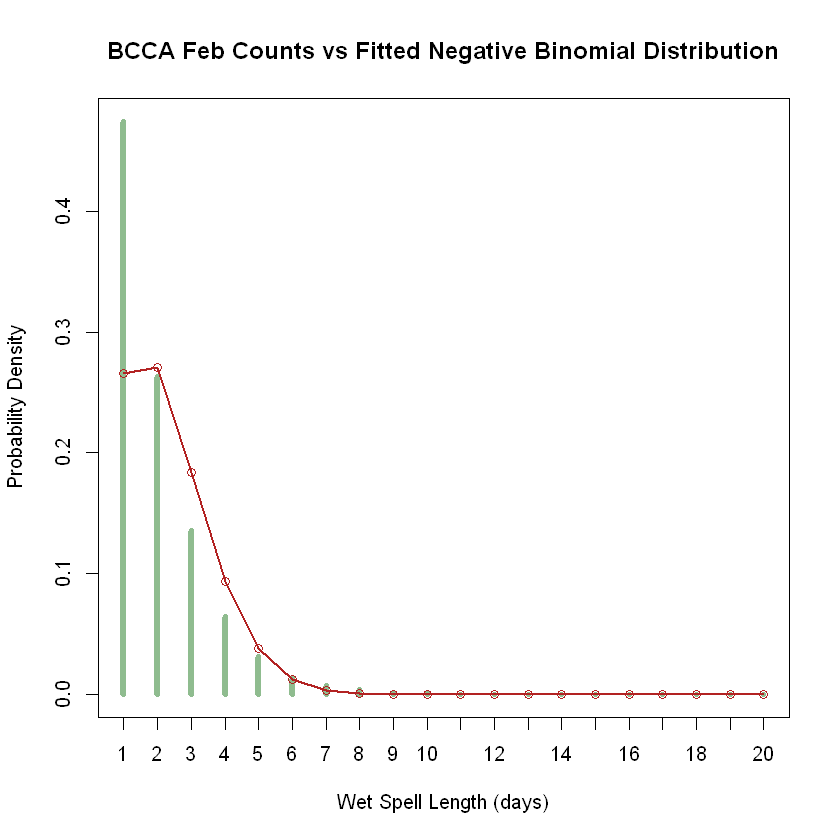

In [232]:
maxP <- max(dBCFeb$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dFeb_size, mu=BCfdNB_dFeb_mu )
ttab <- table( dBCFeb$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Feb Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

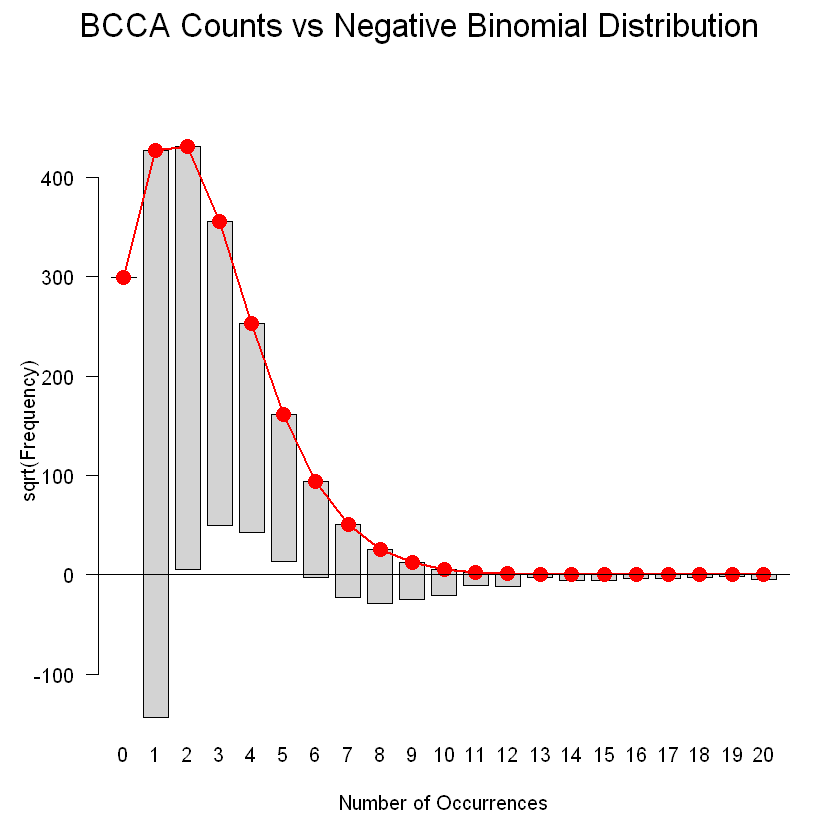

In [233]:
plot( BCgf_dFeb, main="BCCA Counts vs Negative Binomial Distribution" )

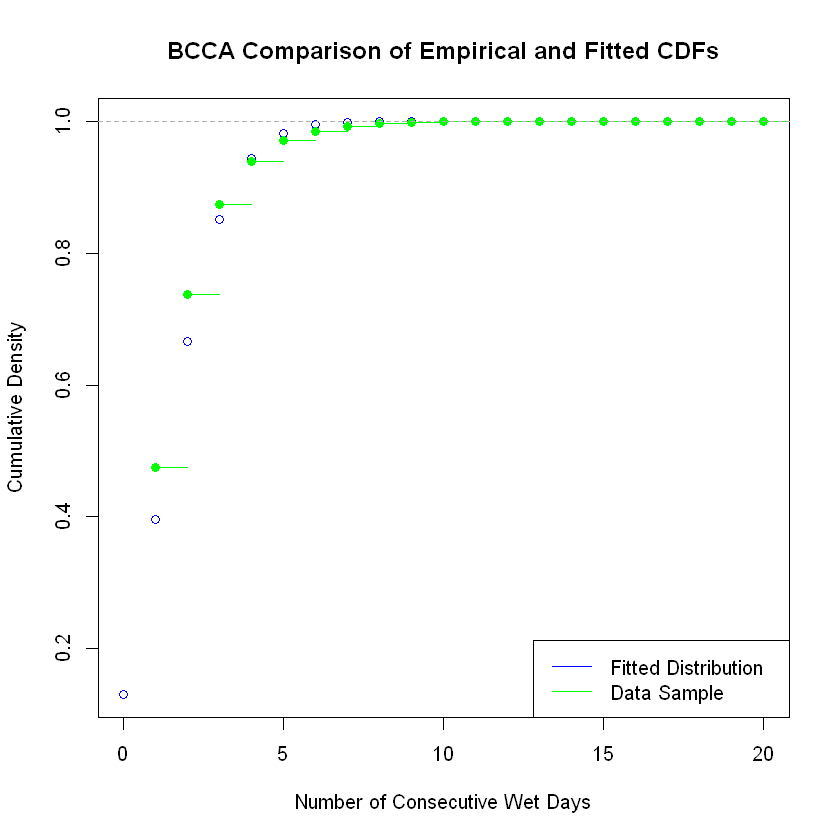

In [234]:
x <- seq(0,dBCFebMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dFeb_mu, size=BCfdNB_dFeb_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCFeb$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

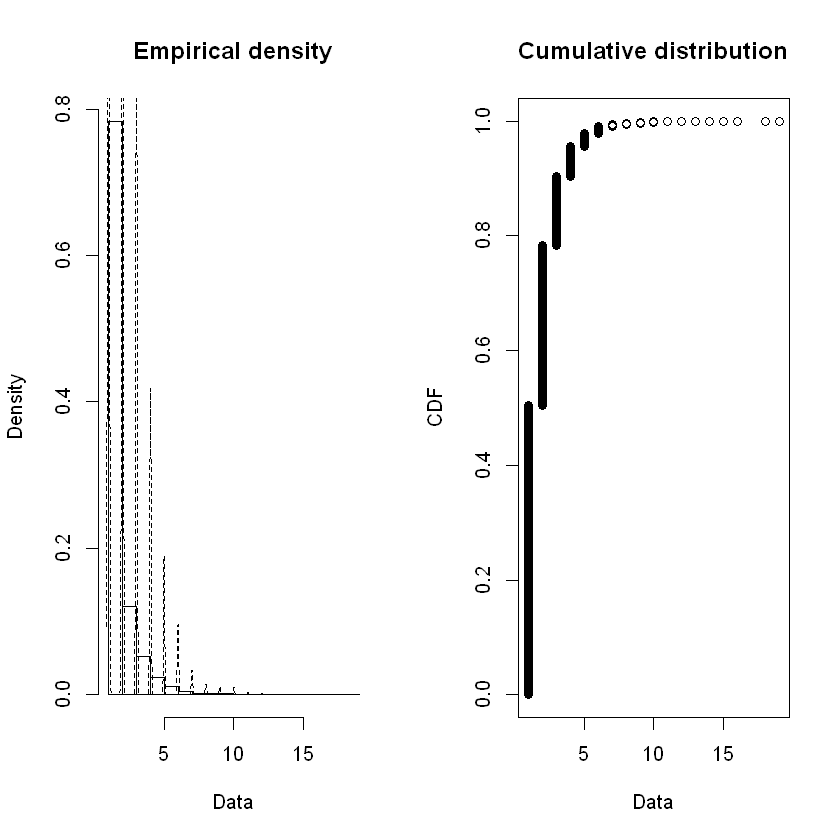

In [235]:
plotdist( dLOMar$Wet_Count, histo=TRUE, demp=TRUE )

In [236]:
LOfd_NB_dMar <- fitdist( dLOMar$Wet_Count, "nbinom" )
LOfd_GE_dMar <- fitdist( dLOMar$Wet_Count, "geom" )

In [237]:
LOfdNB_dMar_size <- LOfd_NB_dMar$estimate[["size"]]
LOfdNB_dMar_mu <- LOfd_NB_dMar$estimate[["mu"]]
cat("LOCA Mar size: ", LOfdNB_dMar_size, "\n", "LOCA Mar mu: ", LOfdNB_dMar_mu, "\n")

LOCA Mar size:  3416294 
 LOCA Mar mu:  1.894854 


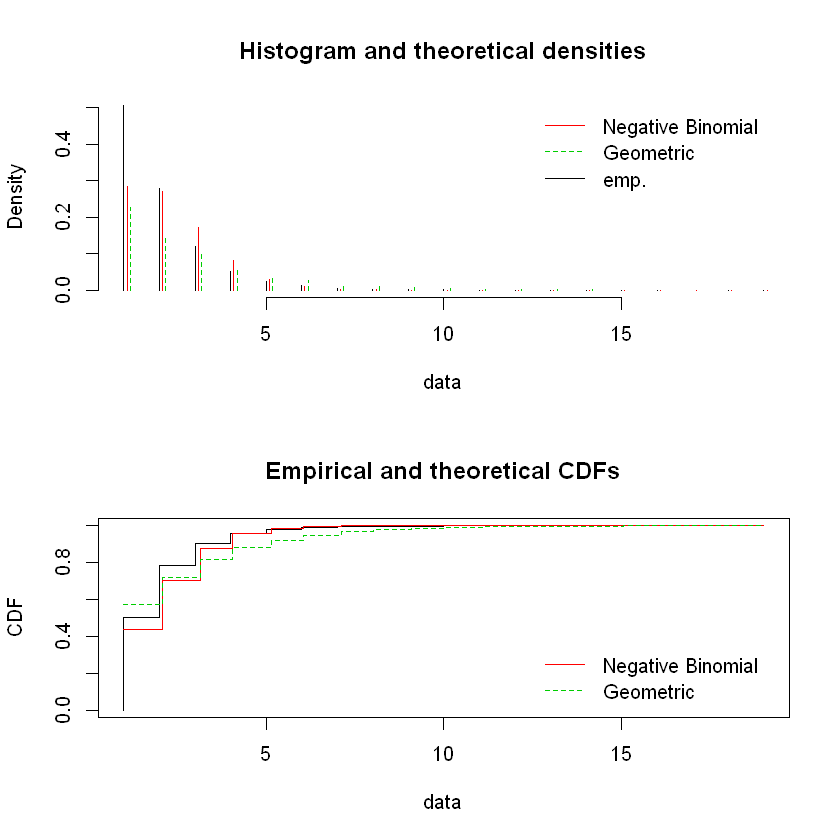

In [238]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dMar, LOfd_GE_dMar), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dMar, LOfd_GE_dMar), legendtext=plot.legend )

In [239]:
LOstatRes <- gofstat( list(LOfd_NB_dMar, LOfd_GE_dMar), fitnames=c("Negative Binomial", "Geometric") )

In [240]:
print( LOstatRes )

Chi-squared statistic:  197236.5 201027.3 
Degree of freedom of the Chi-squared distribution:  6 7 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    554463           478201.38018      628024.68
<= 2    306482           296555.18431      162622.05
<= 3    132237           187309.61343      106443.80
<= 4     56889            88731.12850       69672.48
<= 5     25659            33626.53021       45603.92
<= 6     12971            10619.57140       29849.92
<= 7      4474             2874.65188       19538.18
<= 9      3383              824.23444       21159.44
> 9       2217               32.70566       15860.54

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           3411389   4100447
Bayesian Information Criterion           3411412   4100459


In [241]:
LOfdNB_dMar_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [242]:
LOfdNB_dMar_p = LOfdNB_dMar_size / (LOfdNB_dMar_size + LOfdNB_dMar_mu)
cat("LOCA prob: ", LOfdNB_dMar_p)

LOCA prob:  0.9999994

In [243]:
# add to our tracking dataframe
LOMonDistDF[3, ] <- list( 3, dLOMarMean, dLOMarBNr, LOfdNB_dMar_p, LOfdNB_dMar_mu, LOfdNB_dMar_size,
                          LOfdNB_dMar_pvalue )

In [244]:
LOgf_dMar <- goodfit( dLOMar$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dMar_size, prob=LOfdNB_dMar_p) )

In [245]:
summary( LOgf_dMar )


	 Goodness-of-fit test for nbinomial distribution

                          X^2 df P(> X^2)
Pearson          6318070658.7 19        0
Likelihood Ratio     539325.3 17        0


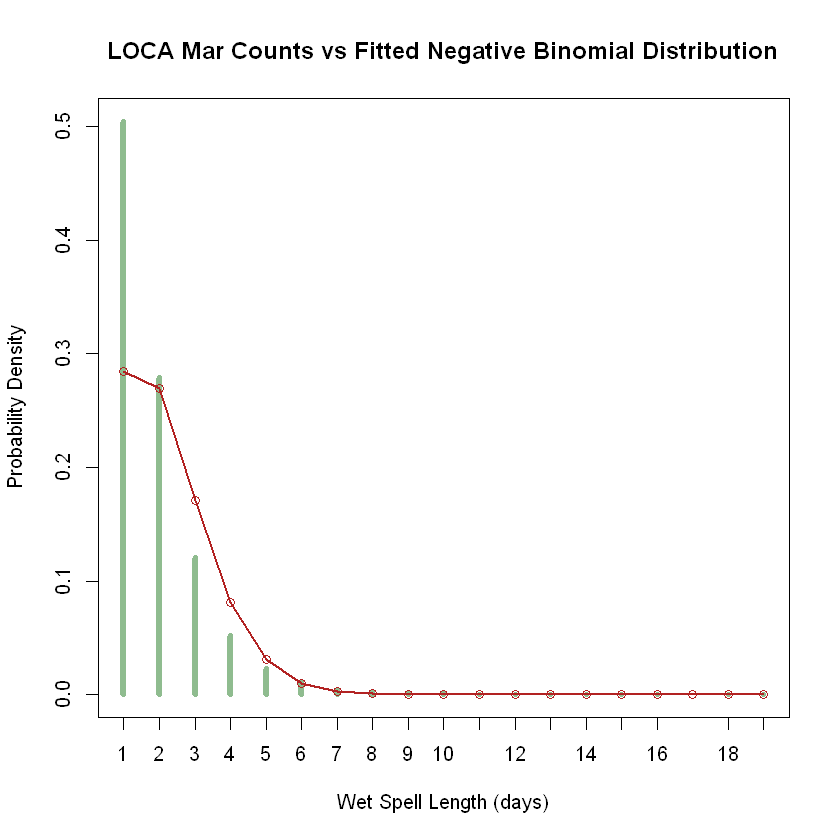

In [246]:
maxP <- max(dLOMar$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dMar_size, mu=LOfdNB_dMar_mu )
ttab <- table( dLOMar$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Mar Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

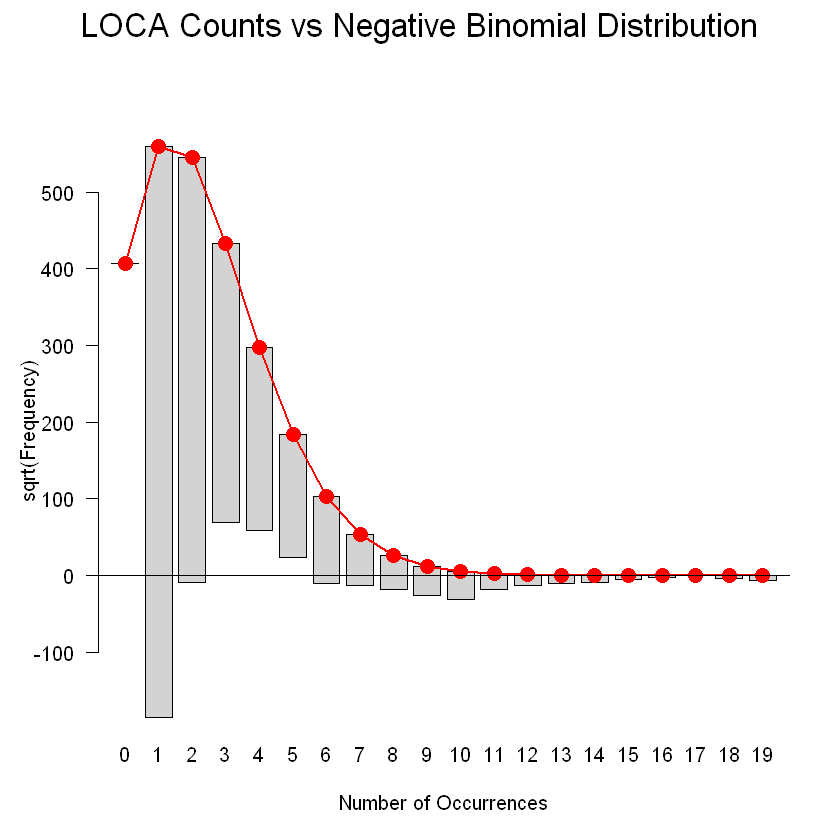

In [247]:
plot( LOgf_dMar, main="LOCA Counts vs Negative Binomial Distribution" )

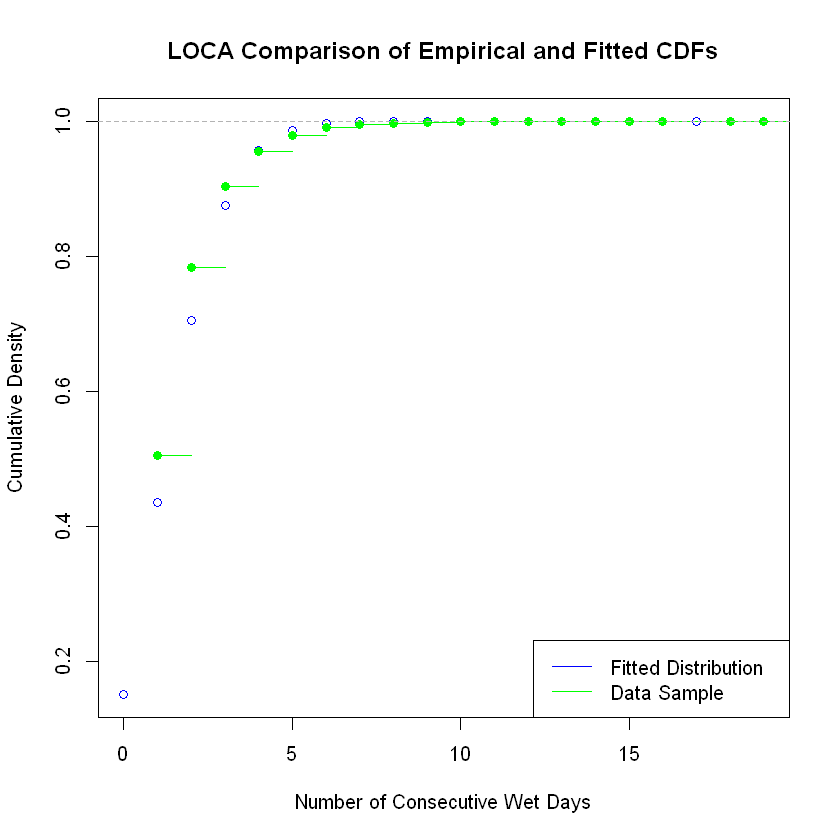

In [248]:
x <- seq(0,dLOMarMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dMar_mu, size=LOfdNB_dMar_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOMar$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

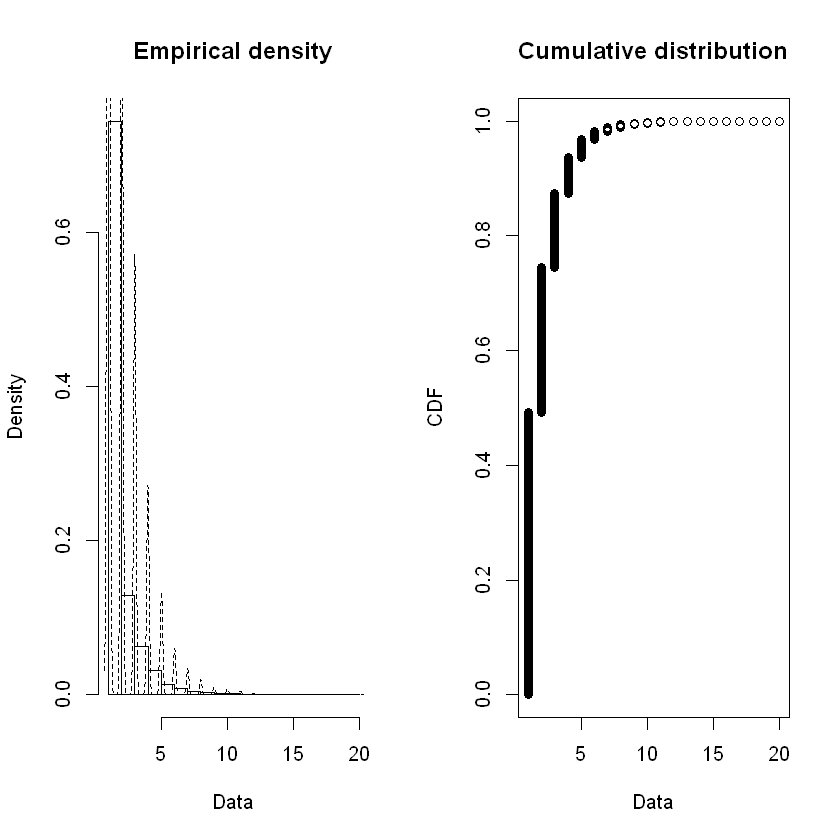

In [249]:
plotdist( dBCMar$Wet_Count, histo=TRUE, demp=TRUE )

In [250]:
BCfd_NB_dMar <- fitdist( dBCMar$Wet_Count, "nbinom" )
BCfd_GE_dMar <- fitdist( dBCMar$Wet_Count, "geom" )

In [251]:
summary( BCfd_NB_dMar )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
      estimate  Std. Error
size 49.780868 1.571669990
mu    2.026625 0.001646045
Loglikelihood:  -1285061   AIC:  2570127   BIC:  2570150 
Correlation matrix:
              size            mu
size  1.000000e+00 -8.176791e-05
mu   -8.176791e-05  1.000000e+00


In [252]:
BCfdNB_dMar_size <- BCfd_NB_dMar$estimate[["size"]]
BCfdNB_dMar_mu <- BCfd_NB_dMar$estimate[["mu"]]
cat("BCCA Mar size: ", BCfdNB_dMar_size, "\n", "BCCA Mar mu: ", BCfdNB_dMar_mu, "\n")

BCCA Mar size:  49.78087 
 BCCA Mar mu:  2.026625 


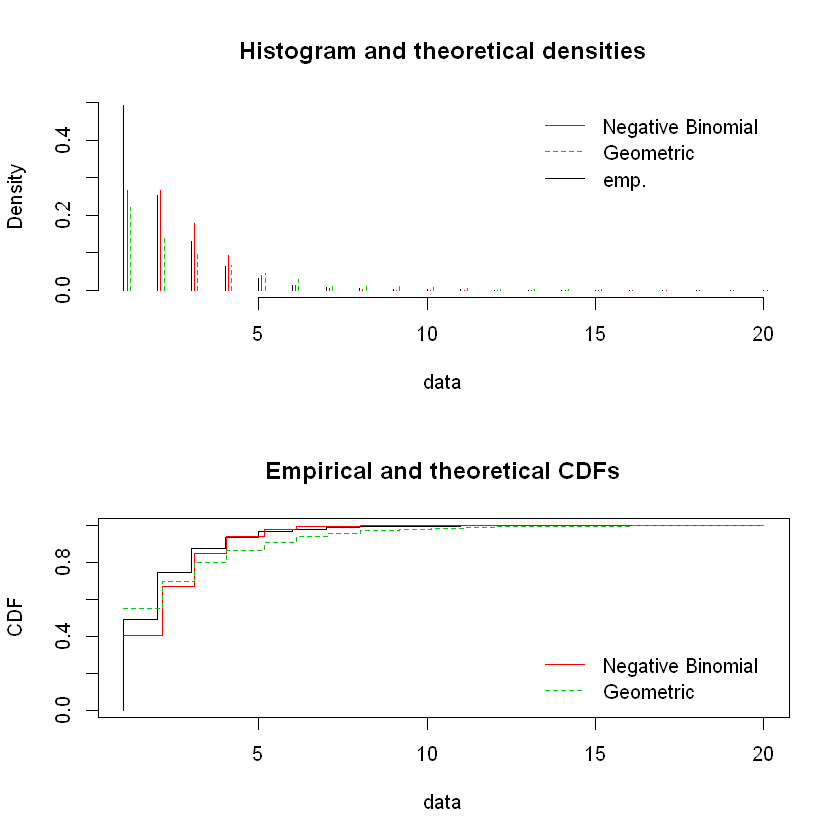

In [253]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dMar, BCfd_GE_dMar), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dMar, BCfd_GE_dMar), legendtext=plot.legend )

In [254]:
BCstatRes <- gofstat( list(BCfd_NB_dMar, BCfd_GE_dMar), fitnames=c("Negative Binomial", "Geometric") )

In [255]:
print(BCstatRes)

Chi-squared statistic:  250923.6 102677.8 
Degree of freedom of the Chi-squared distribution:  7 8 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     383372           314750.73387     429446.664
<= 2     196608           206552.16790     115322.673
<= 3     100813           139462.88781      77218.617
<= 4      48682            71987.32158      51704.619
<= 5      24053            30289.67704      34620.765
<= 6      10676            10818.15318      23181.631
<= 7       6057             3372.26099      15522.130
<= 8       3489              936.29789      10393.424
<= 10      3108              289.21497      11619.171
> 10       1615               14.28476       9443.307

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2570127   2989708
Bayesian Information Criterion           2570150   2989719


In [256]:
BCfdNB_dMar_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [257]:
BCfdNB_dMar_p = BCfdNB_dMar_size / (BCfdNB_dMar_size + BCfdNB_dMar_mu)
cat("BCCA prob: ", BCfdNB_dMar_p)

BCCA prob:  0.9608816

In [258]:
# add to our tracking dataframe
BCMonDistDF[3, ] <- list( 3, dBCMarMean, dBCMarBNr, BCfdNB_dMar_p, BCfdNB_dMar_mu, BCfdNB_dMar_size,
                          BCfdNB_dMar_pvalue )

In [259]:
BCgf_dMar <- goodfit( dBCMar$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dMar_size, prob=BCfdNB_dMar_p) )

In [260]:
summary( BCgf_dMar )


	 Goodness-of-fit test for nbinomial distribution

                        X^2 df P(> X^2)
Pearson          33987610.5 20        0
Likelihood Ratio   384958.6 19        0


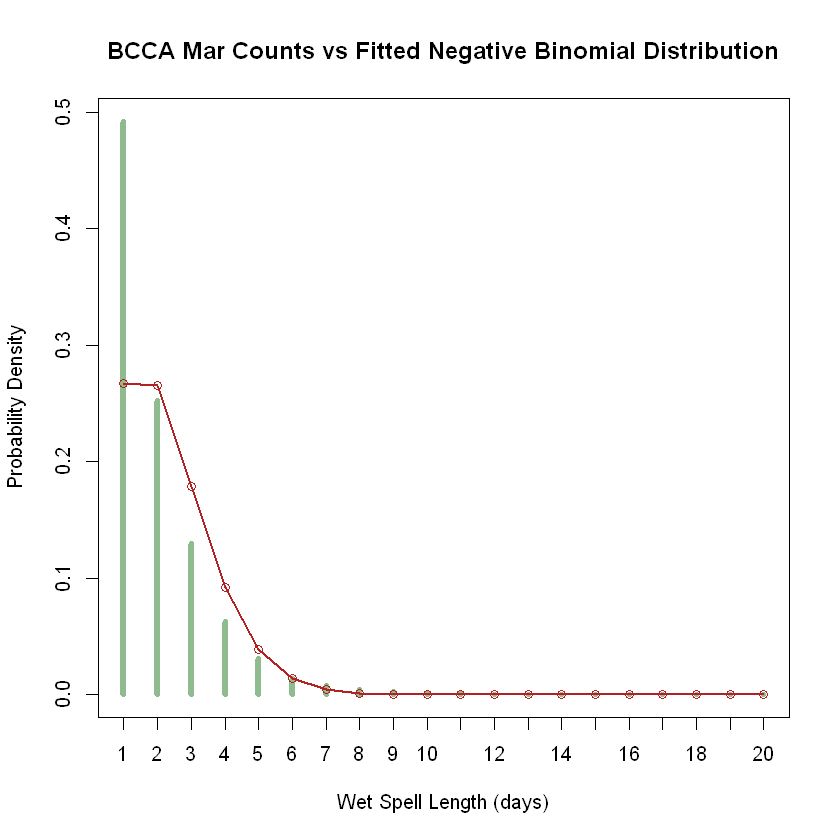

In [261]:
maxP <- max(dBCMar$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dMar_size, mu=BCfdNB_dMar_mu )
ttab <- table( dBCMar$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Mar Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

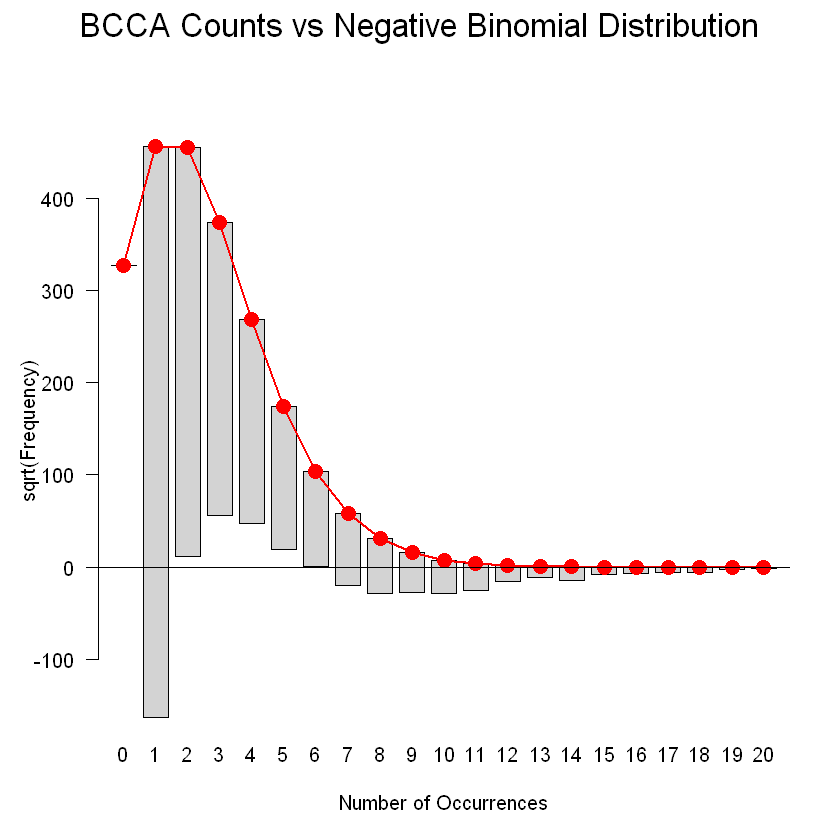

In [262]:
plot( BCgf_dMar, main="BCCA Counts vs Negative Binomial Distribution" )

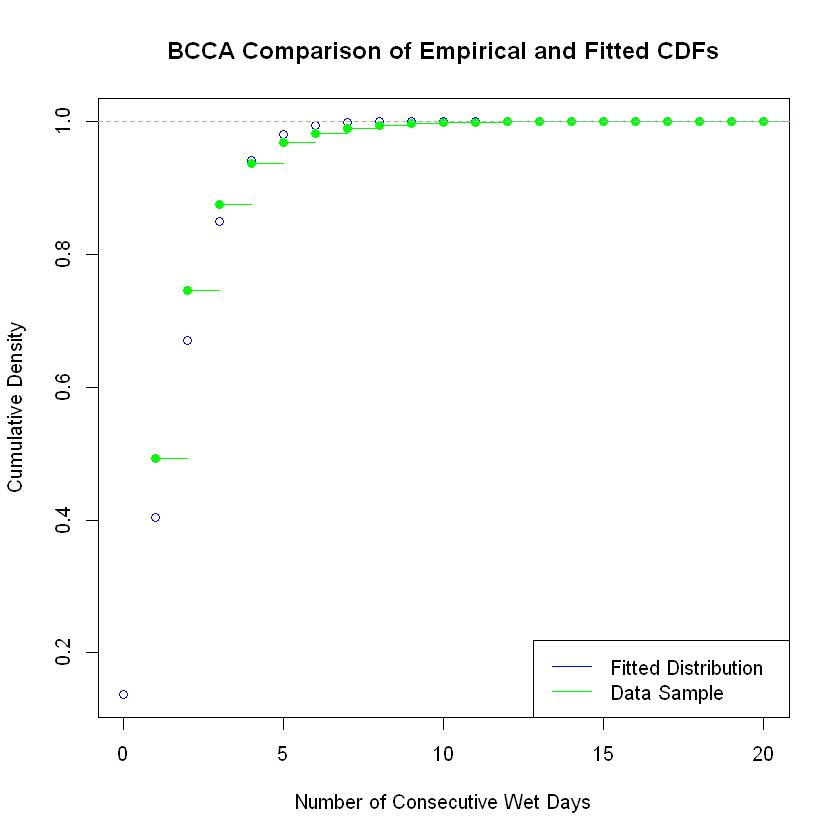

In [263]:
x <- seq(0,dBCMarMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dMar_mu, size=BCfdNB_dMar_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCMar$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

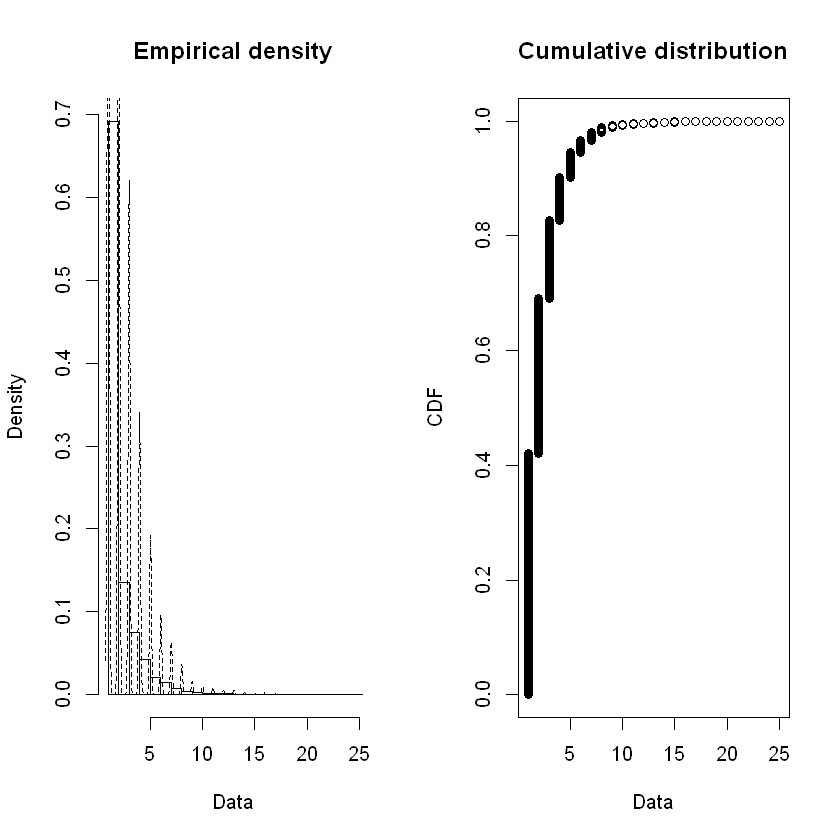

In [264]:
plotdist( dLOApr$Wet_Count, histo=TRUE, demp=TRUE )

In [265]:
LOfd_NB_dApr <- fitdist( dLOApr$Wet_Count, "nbinom" )
LOfd_GE_dApr <- fitdist( dLOApr$Wet_Count, "geom" )

In [266]:
LOfdNB_dApr_size <- LOfd_NB_dApr$estimate[["size"]]
LOfdNB_dApr_mu <- LOfd_NB_dApr$estimate[["mu"]]
cat("LOCA Apr size: ", LOfdNB_dApr_size, "\n", "LOCA Apr mu: ", LOfdNB_dApr_mu, "\n")

LOCA Apr size:  10.45453 
 LOCA Apr mu:  2.301808 


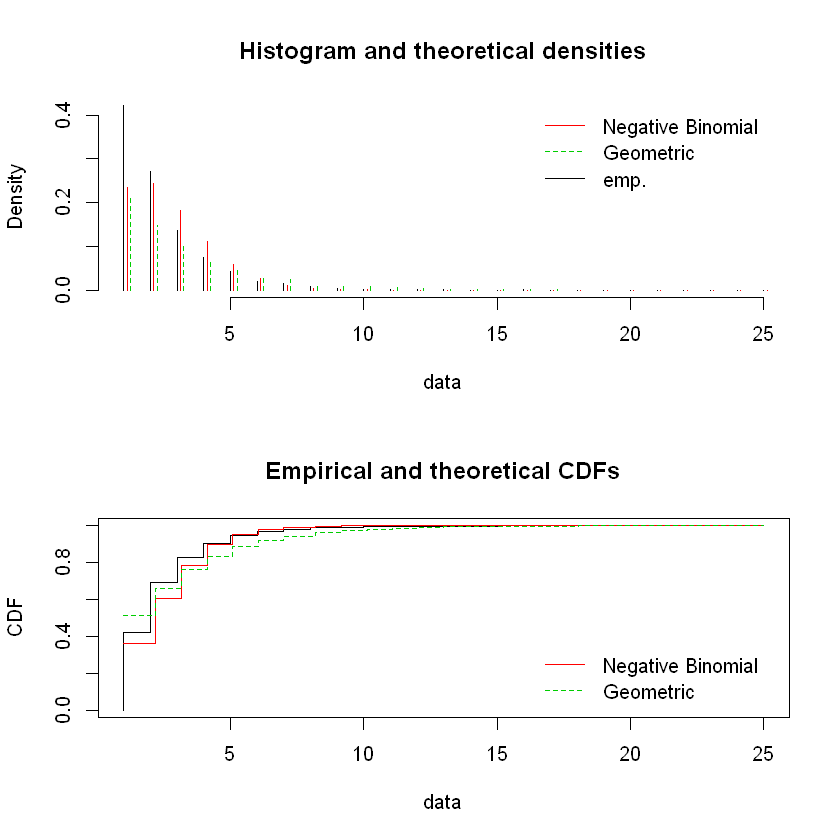

In [267]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dApr, LOfd_GE_dApr), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dApr, LOfd_GE_dApr), legendtext=plot.legend )

In [268]:
LOstatRes <- gofstat( list(LOfd_NB_dApr, LOfd_GE_dApr), fitnames=c("Negative Binomial", "Geometric") )

In [269]:
print( LOstatRes )

Chi-squared statistic:  492473.7 206873.6 
Degree of freedom of the Chi-squared distribution:  9 10 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     526357           450286.60282      642062.71
<= 2     337824           304131.57308      183866.00
<= 3     169666           227829.91024      128180.64
<= 4      94000           138280.97358       89360.07
<= 5      53017            72133.92345       62296.62
<= 6      26286            33526.42662       43429.57
<= 7      17909            14220.59848       30276.56
<= 8       9728             5598.59712       21107.05
<= 9       4253             2071.49013       14714.61
<= 10      2762              727.18814       10258.16
<= 12      3611              322.71515       12136.93
> 12       3752               35.00118       11476.07

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           4483863   5058944
Bayesia

In [270]:
LOfdNB_dApr_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [271]:
LOfdNB_dApr_p = LOfdNB_dApr_size / (LOfdNB_dApr_size + LOfdNB_dApr_mu)
cat("LOCA prob: ", LOfdNB_dApr_p)

LOCA prob:  0.8195557

In [272]:
# add to our tracking dataframe
LOMonDistDF[4, ] <- list( 4, dLOAprMean, dLOAprBNr, LOfdNB_dApr_p, LOfdNB_dApr_mu, LOfdNB_dApr_size,
                          LOfdNB_dApr_pvalue )

In [273]:
LOgf_dApr <- goodfit( dLOApr$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dApr_size, prob=LOfdNB_dApr_p) )

In [274]:
summary( LOgf_dApr )


	 Goodness-of-fit test for nbinomial distribution

                        X^2 df P(> X^2)
Pearson          26931635.3 25        0
Likelihood Ratio   556420.1 24        0


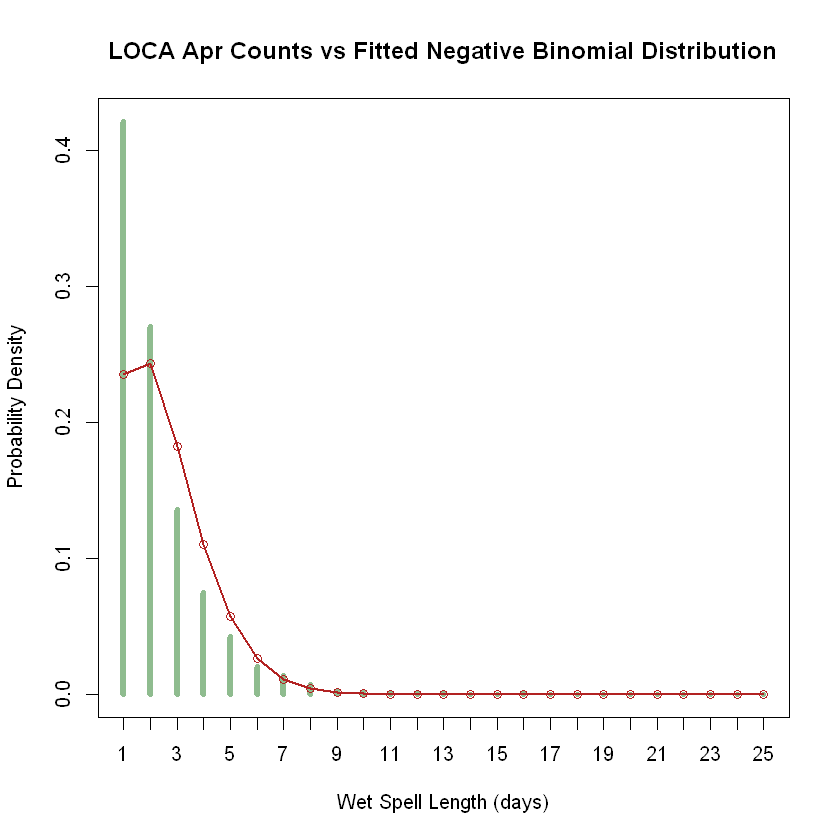

In [275]:
maxP <- max(dLOApr$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dApr_size, mu=LOfdNB_dApr_mu )
ttab <- table( dLOApr$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Apr Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

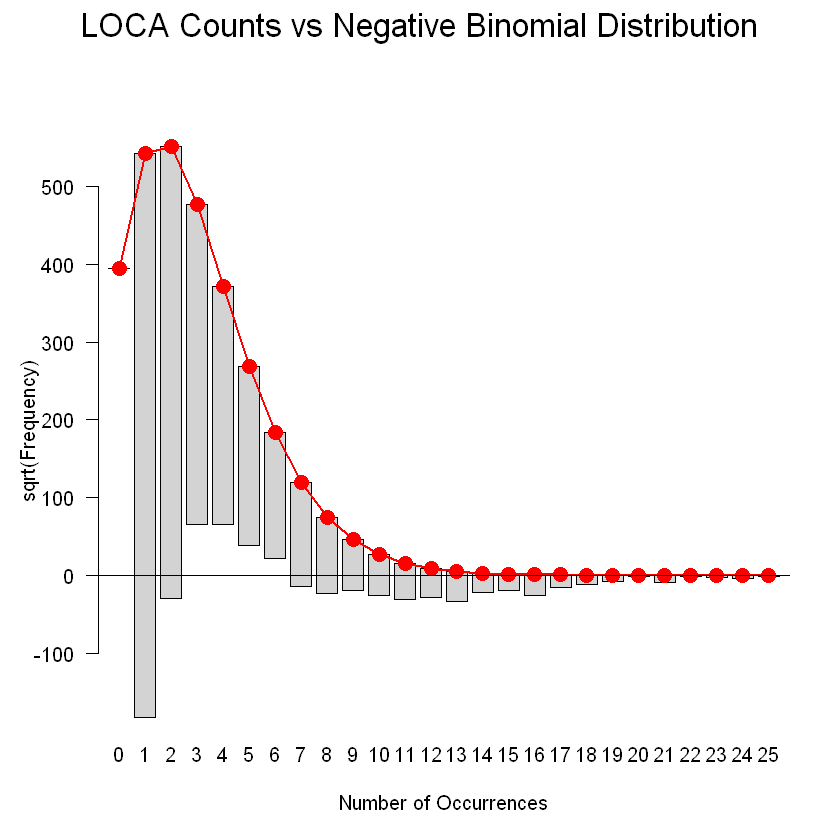

In [276]:
plot( LOgf_dApr, main="LOCA Counts vs Negative Binomial Distribution" )

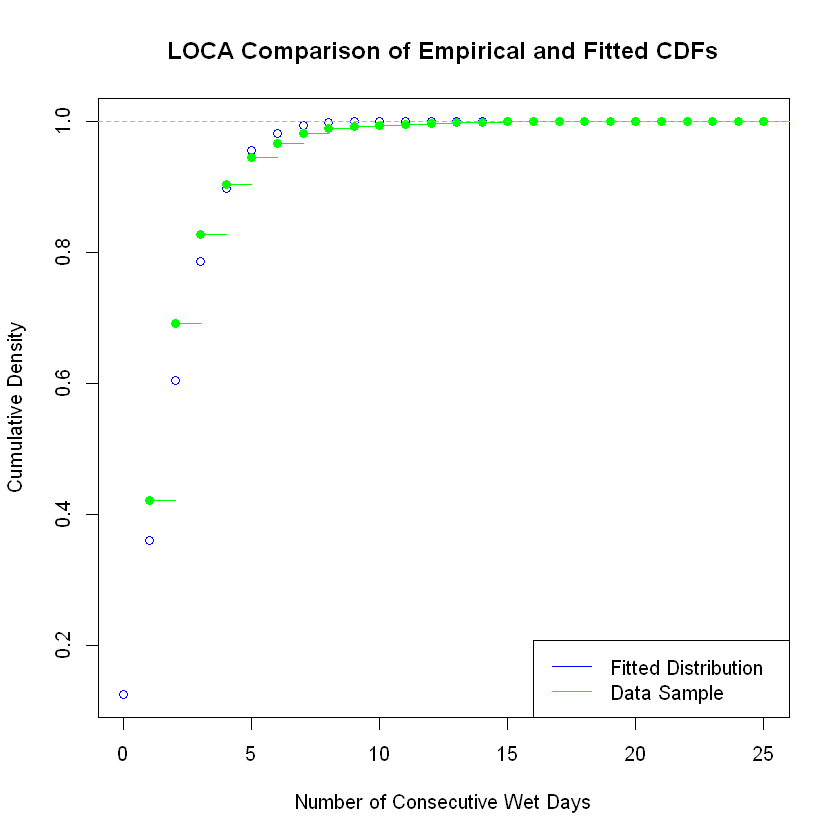

In [277]:
x <- seq(0,dLOAprMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dApr_mu, size=LOfdNB_dApr_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOApr$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

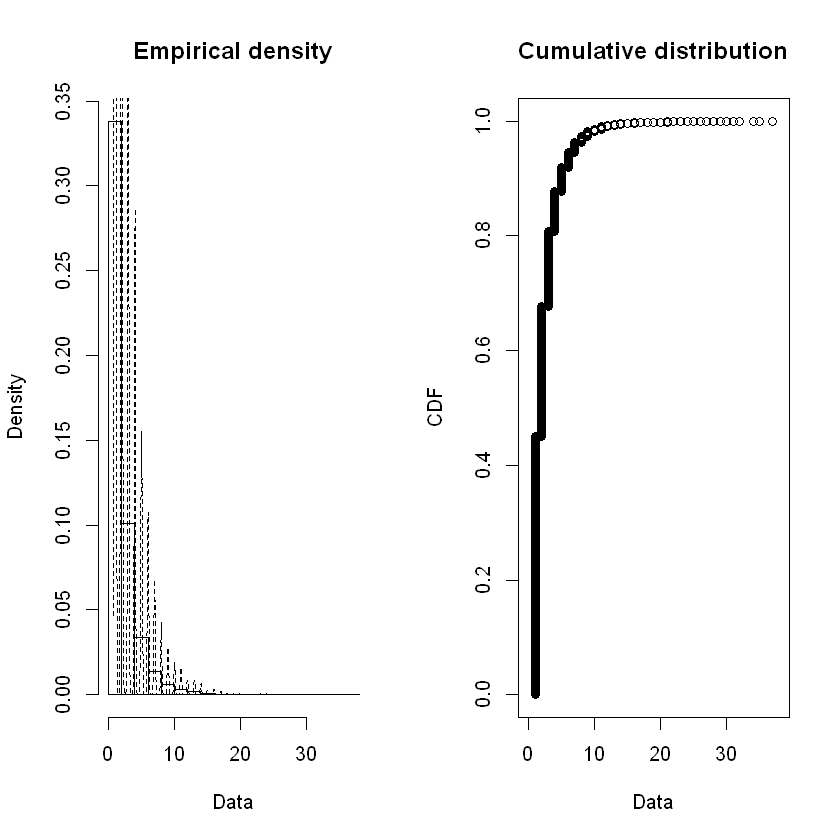

In [278]:
plotdist( dBCApr$Wet_Count, histo=TRUE, demp=TRUE )

In [279]:
BCfd_NB_dApr <- fitdist( dBCApr$Wet_Count, "nbinom" )
BCfd_GE_dApr <- fitdist( dBCApr$Wet_Count, "geom" )

In [280]:
summary( BCfd_NB_dApr )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 4.311802 0.016036662
mu   2.462660 0.002156297
Loglikelihood:  -1603942   AIC:  3207887   BIC:  3207910 
Correlation matrix:
             size           mu
size 1.000000e+00 2.981071e-05
mu   2.981071e-05 1.000000e+00


In [281]:
BCfdNB_dApr_size <- BCfd_NB_dApr$estimate[["size"]]
BCfdNB_dApr_mu <- BCfd_NB_dApr$estimate[["mu"]]
cat("BCCA Apr size: ", BCfdNB_dApr_size, "\n", "BCCA Apr mu: ", BCfdNB_dApr_mu, "\n")

BCCA Apr size:  4.311802 
 BCCA Apr mu:  2.46266 


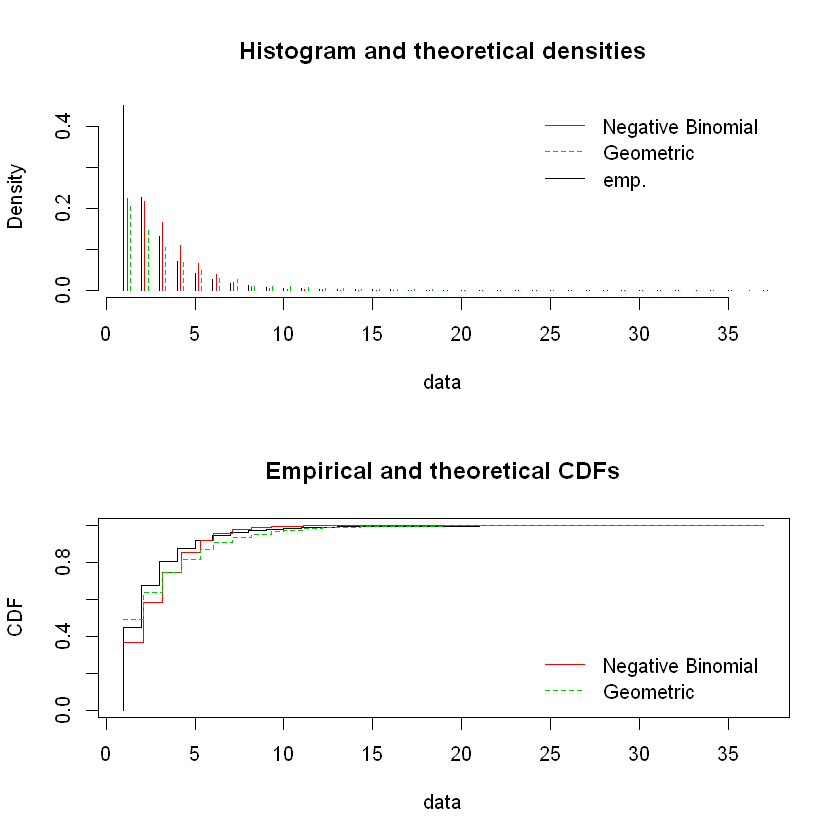

In [282]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dApr, BCfd_GE_dApr), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dApr, BCfd_GE_dApr), legendtext=plot.legend )

In [283]:
BCstatRes <- gofstat( list(BCfd_NB_dApr, BCfd_GE_dApr), fitnames=c("Negative Binomial", "Geometric") )

In [284]:
print(BCstatRes)

Chi-squared statistic:  400177.5 64204.93 
Degree of freedom of the Chi-squared distribution:  11 12 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     374284           304541.17973     411224.424
<= 2     188435           179505.24774     121554.196
<= 3     109019           137289.98786      86450.390
<= 4      59230            91228.99824      61484.262
<= 5      33941            55129.96306      43728.136
<= 6      22556            31102.82211      31099.827
<= 7      13985            16655.81682      22118.465
<= 8       9094             8561.25354      15730.843
<= 9       6147             4257.41600      11187.911
<= 10      3997             2060.21505       7956.938
<= 11      3306              974.41465       5659.043
<= 13      3585              658.14032       6887.204
<= 16      2519              151.84358       4513.411
> 16       2033               13.70128       2535.951

Goodness-of-fit criteria
                

In [285]:
BCfdNB_dApr_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [286]:
BCfdNB_dApr_p = BCfdNB_dApr_size / (BCfdNB_dApr_size + BCfdNB_dApr_mu)
cat("BCCA prob: ", BCfdNB_dApr_p)

BCCA prob:  0.6364789

In [287]:
# add to our tracking dataframe
BCMonDistDF[4, ] <- list( 4, dBCAprMean, dBCAprBNr, BCfdNB_dApr_p, BCfdNB_dApr_mu, BCfdNB_dApr_size,
                          BCfdNB_dApr_pvalue )

In [288]:
BCgf_dApr <- goodfit( dBCApr$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dApr_size, prob=BCfdNB_dApr_p) )

In [289]:
summary( BCgf_dApr )


	 Goodness-of-fit test for nbinomial distribution

                          X^2 df P(> X^2)
Pearson          9590794138.8 37        0
Likelihood Ratio     464950.6 34        0


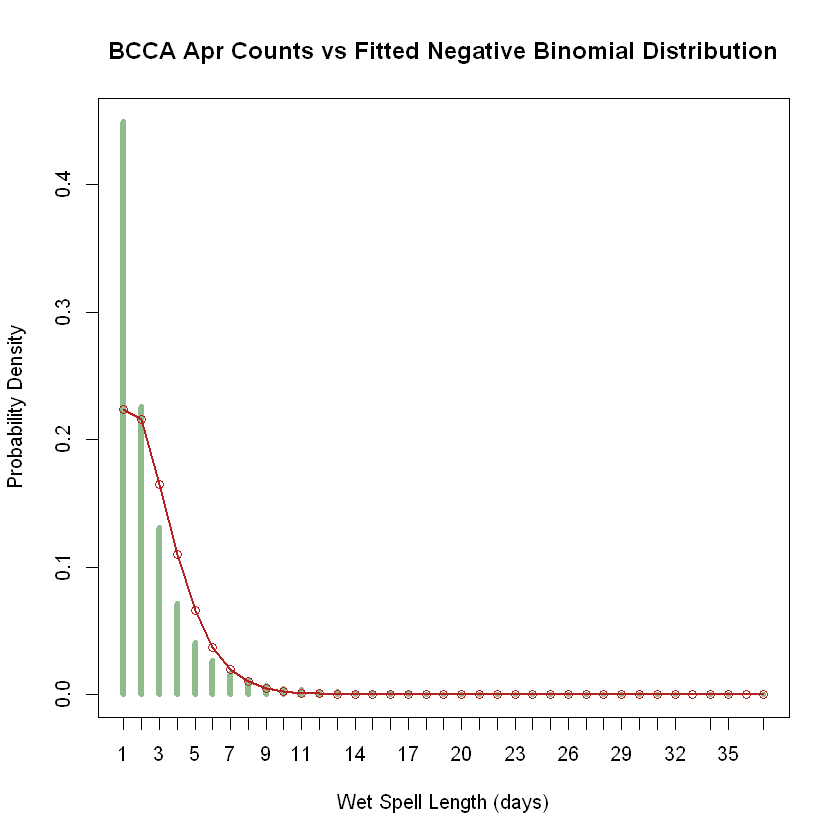

In [290]:
maxP <- max(dBCApr$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dApr_size, mu=BCfdNB_dApr_mu )
ttab <- table( dBCApr$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Apr Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

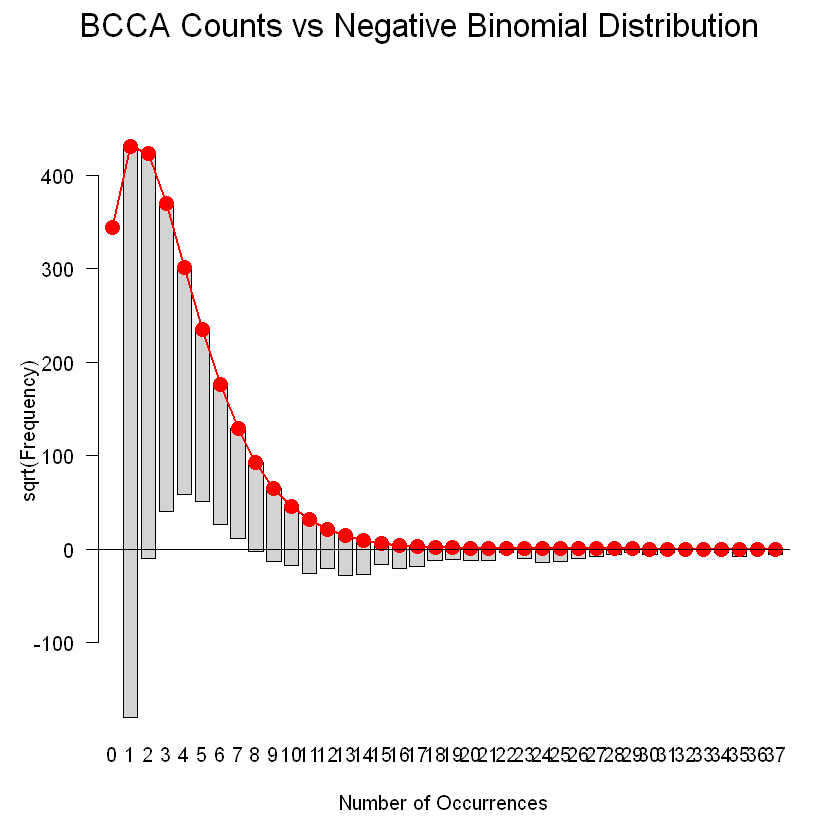

In [291]:
plot( BCgf_dApr, main="BCCA Counts vs Negative Binomial Distribution" )

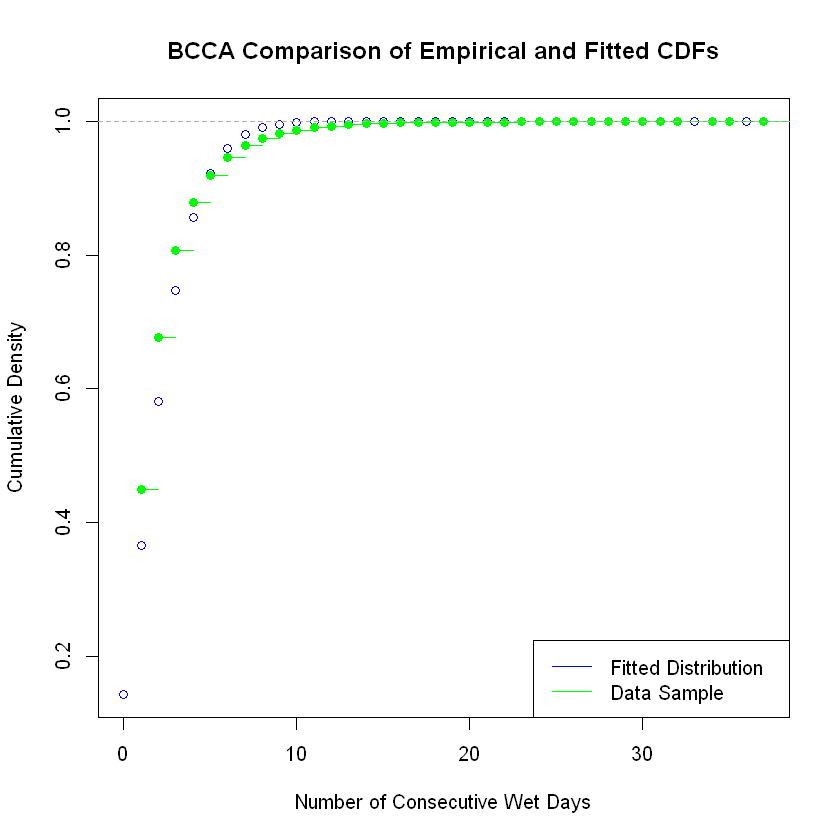

In [292]:
x <- seq(0,dBCAprMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dApr_mu, size=BCfdNB_dApr_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCApr$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

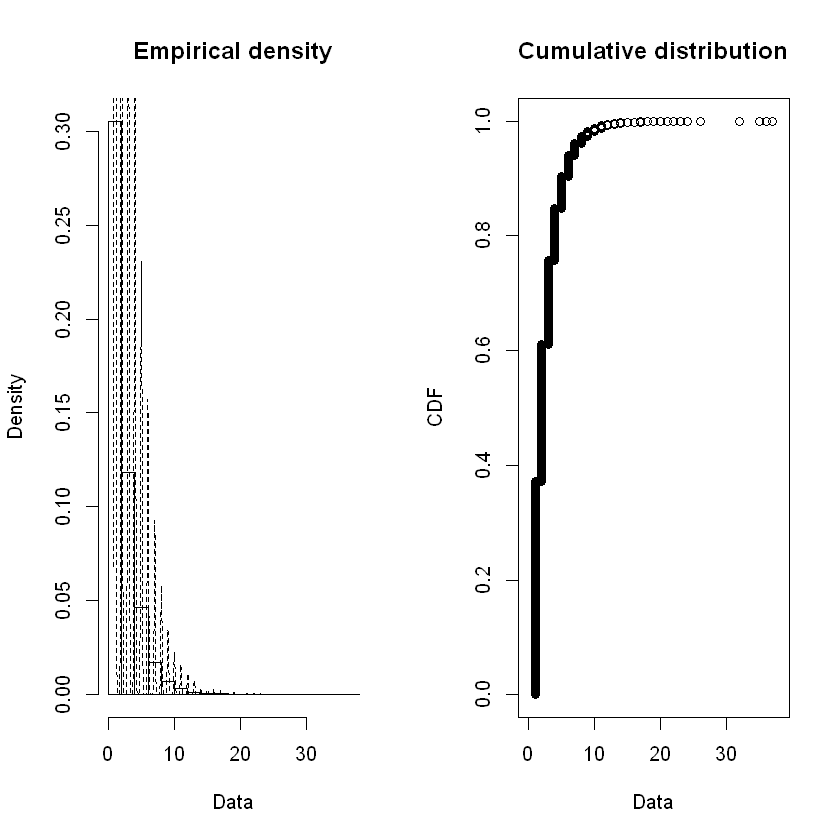

In [293]:
plotdist( dLOMay$Wet_Count, histo=TRUE, demp=TRUE )

In [294]:
LOfd_NB_dMay <- fitdist( dLOMay$Wet_Count, "nbinom" )
LOfd_GE_dMay <- fitdist( dLOMay$Wet_Count, "geom" )

In [295]:
LOfdNB_dMay_size <- LOfd_NB_dMay$estimate[["size"]]
LOfdNB_dMay_mu <- LOfd_NB_dMay$estimate[["mu"]]
cat("LOCA May size: ", LOfdNB_dMay_size, "\n", "LOCA May mu: ", LOfdNB_dMay_mu, "\n")

LOCA May size:  5.307985 
 LOCA May mu:  2.691926 


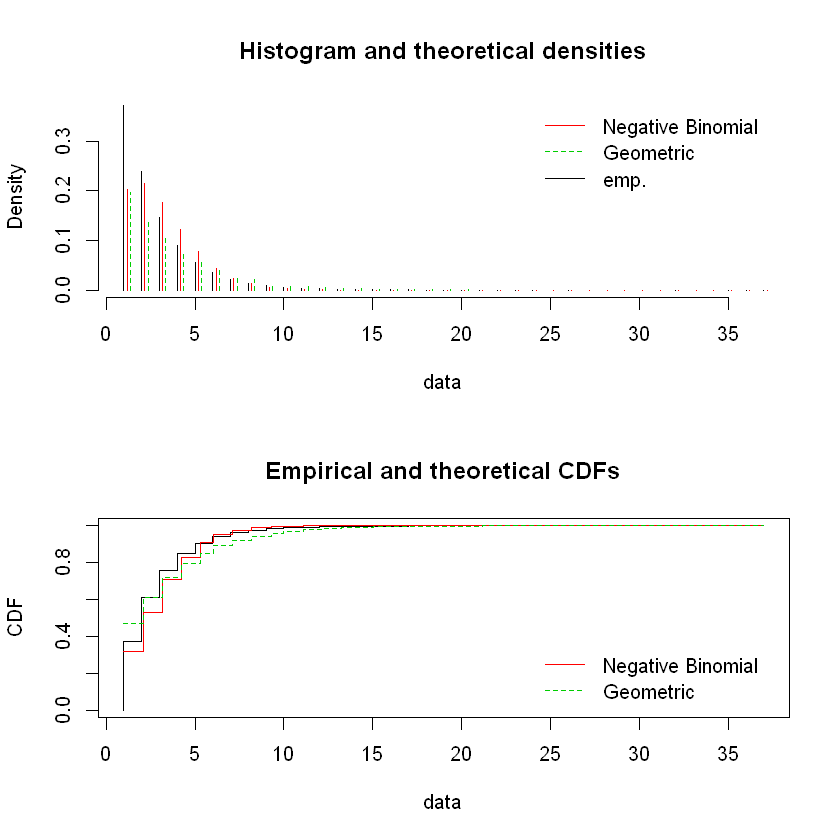

In [296]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dMay, LOfd_GE_dMay), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dMay, LOfd_GE_dMay), legendtext=plot.legend )

In [297]:
LOstatRes <- gofstat( list(LOfd_NB_dMay, LOfd_GE_dMay), fitnames=c("Negative Binomial", "Geometric") )

In [298]:
print( LOstatRes )

Chi-squared statistic:  205913.5 186828.7 
Degree of freedom of the Chi-squared distribution:  11 12 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     545560            464143.7266     688429.456
<= 2     351995            315791.7730     211671.665
<= 3     215483            258854.1558     154340.887
<= 4     132316            180912.5908     112538.018
<= 5      82787            113326.7420      82057.358
<= 6      53765             65513.8122      59832.313
<= 7      30824             35612.1338      43626.871
<= 8      19452             18436.2636      31810.634
<= 9      12546              9173.1954      23194.798
<= 10      7905              4416.4881      16912.541
<= 11      5418              2068.1420      12331.819
<= 12      3743               945.7522       8991.774
<= 14      3899               610.1442      11336.968
> 14       4252               140.0804      12869.898

Goodness-of-fit criteria
                

In [299]:
LOfdNB_dMay_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [300]:
LOfdNB_dMay_p = LOfdNB_dMay_size / (LOfdNB_dMay_size + LOfdNB_dMay_mu)
cat("LOCA prob: ", LOfdNB_dMay_p)

LOCA prob:  0.6635055

In [301]:
# add to our tracking dataframe
LOMonDistDF[5, ] <- list( 5, dLOMayMean, dLOMayBNr, LOfdNB_dMay_p, LOfdNB_dMay_mu, LOfdNB_dMay_size,
                          LOfdNB_dMay_pvalue )

In [302]:
LOgf_dMay <- goodfit( dLOMay$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dMay_size, prob=LOfdNB_dMay_p) )

In [303]:
summary( LOgf_dMay )


	 Goodness-of-fit test for nbinomial distribution

                          X^2 df P(> X^2)
Pearson          2.524120e+10 37        0
Likelihood Ratio 5.857985e+05 28        0


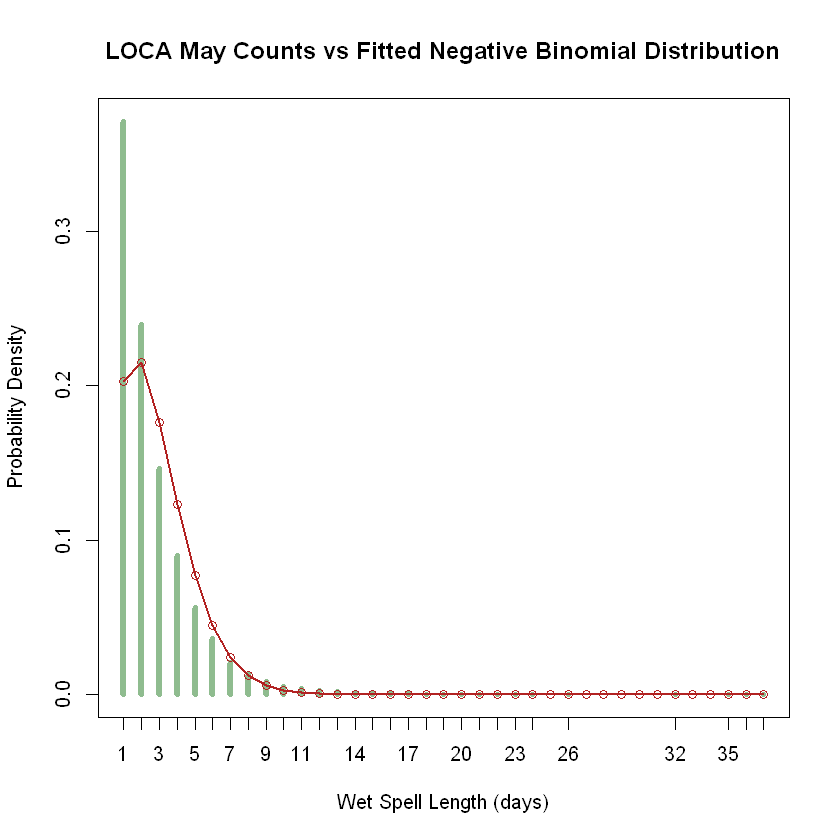

In [304]:
maxP <- max(dLOMay$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dMay_size, mu=LOfdNB_dMay_mu )
ttab <- table( dLOMay$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA May Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

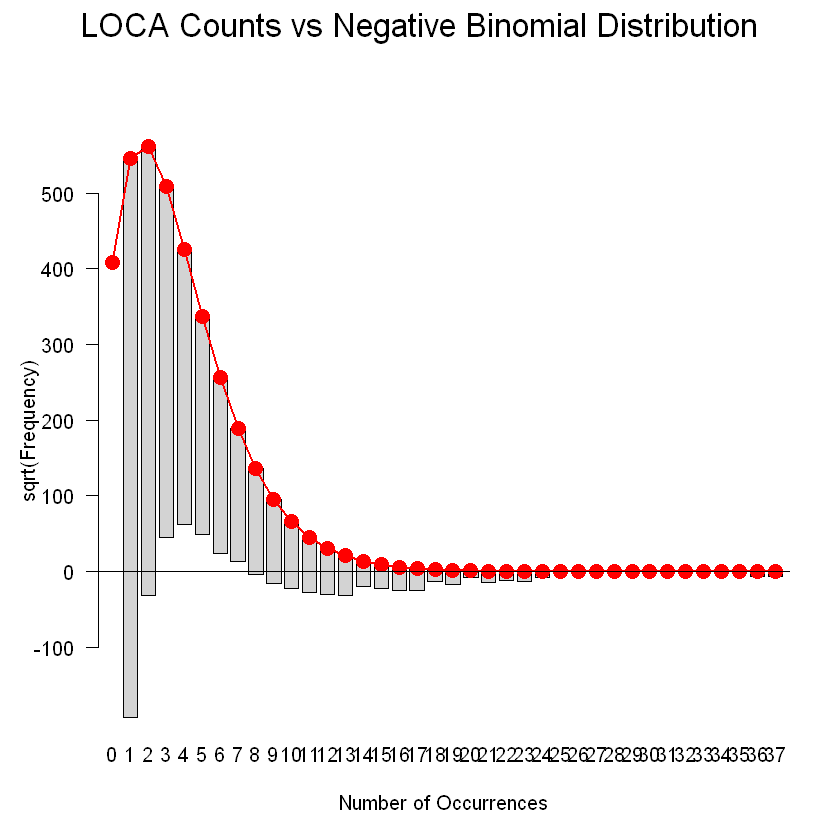

In [305]:
plot( LOgf_dMay, main="LOCA Counts vs Negative Binomial Distribution" )

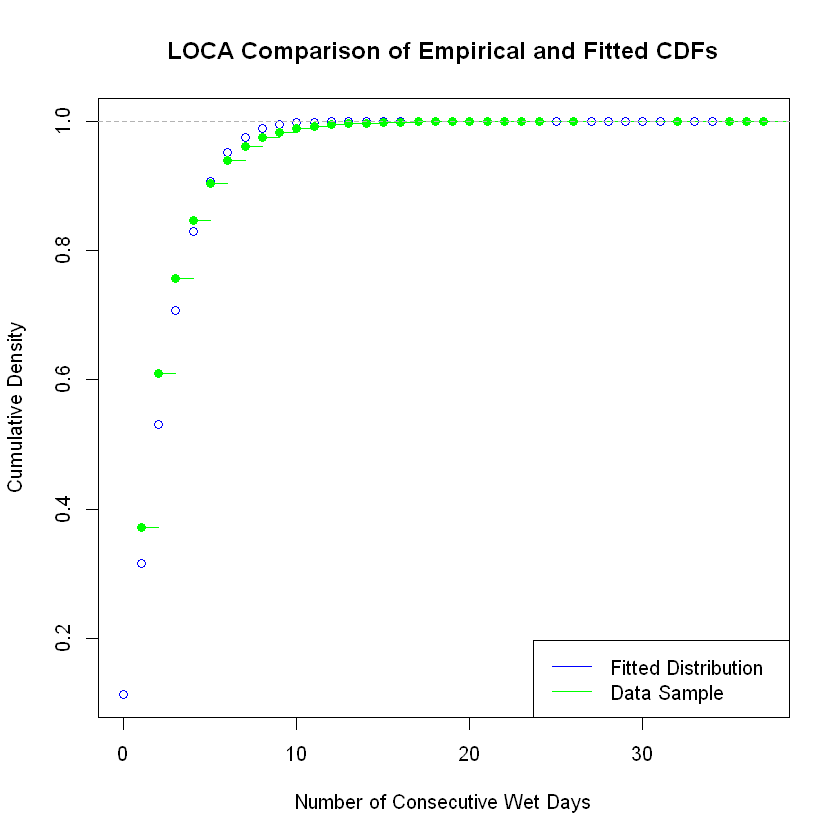

In [306]:
x <- seq(0,dLOMayMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dMay_mu, size=LOfdNB_dMay_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOMay$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

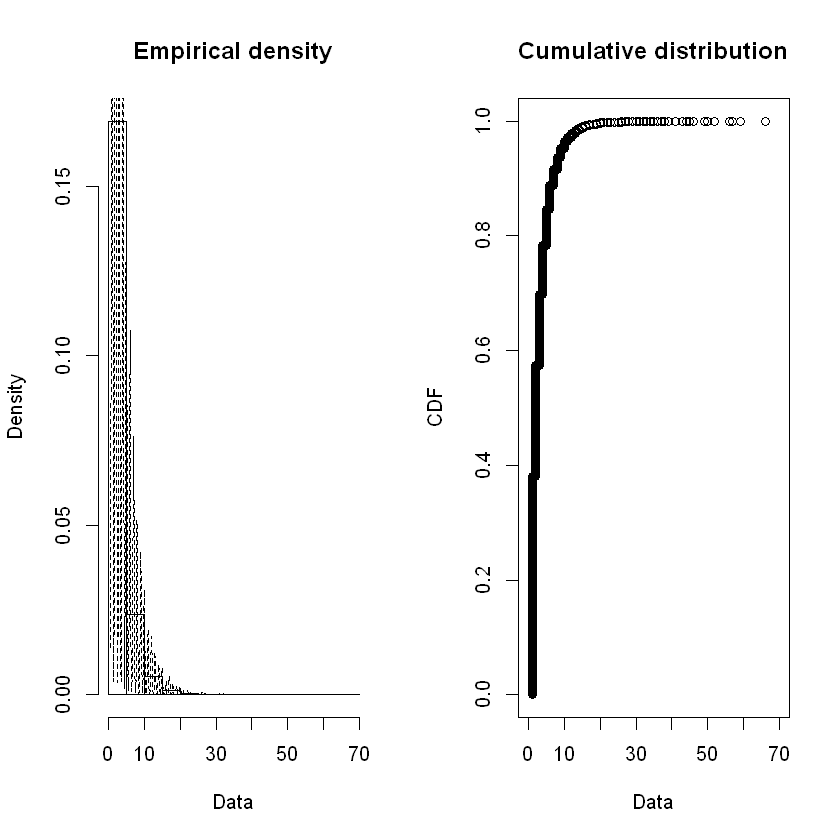

In [307]:
plotdist( dBCMay$Wet_Count, histo=TRUE, demp=TRUE )

In [308]:
BCfd_NB_dMay <- fitdist( dBCMay$Wet_Count, "nbinom" )
BCfd_GE_dMay <- fitdist( dBCMay$Wet_Count, "geom" )

In [309]:
summary( BCfd_NB_dMay )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 2.528366 0.006376601
mu   3.191634 0.002874892
Loglikelihood:  -1930394   AIC:  3860792   BIC:  3860815 
Correlation matrix:
             size           mu
size 1.0000000000 0.0002002412
mu   0.0002002412 1.0000000000


In [310]:
BCfdNB_dMay_size <- BCfd_NB_dMay$estimate[["size"]]
BCfdNB_dMay_mu <- BCfd_NB_dMay$estimate[["mu"]]
cat("BCCA May size: ", BCfdNB_dMay_size, "\n", "BCCA May mu: ", BCfdNB_dMay_mu, "\n")

BCCA May size:  2.528366 
 BCCA May mu:  3.191634 


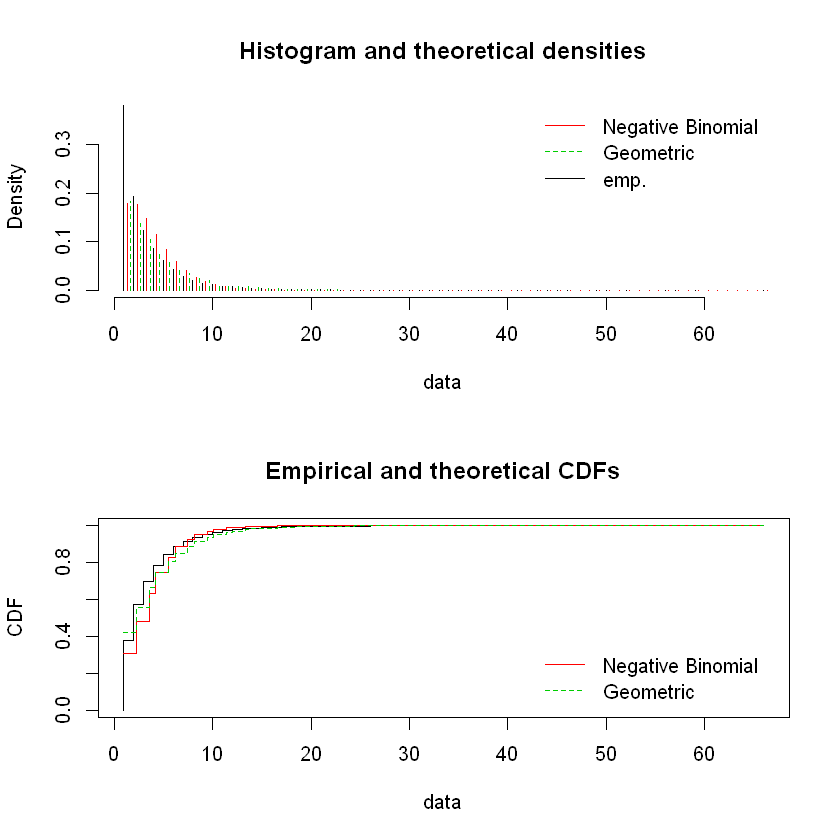

In [311]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dMay, BCfd_GE_dMay), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dMay, BCfd_GE_dMay), legendtext=plot.legend )

In [312]:
BCstatRes <- gofstat( list(BCfd_NB_dMay, BCfd_GE_dMay), fitnames=c("Negative Binomial", "Geometric") )

In [313]:
print(BCstatRes)

Chi-squared statistic:  118088 34551.12 
Degree of freedom of the Chi-squared distribution:  15 16 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     331614            267268.5074     367015.467
<= 2     169181            153960.4620     120809.014
<= 3     108232            129672.0870      91990.362
<= 4      75665            100000.0745      70046.320
<= 5      54005             72853.7380      53336.967
<= 6      36696             51005.6561      40613.583
<= 7      25281             34673.9368      30925.327
<= 8      18364             23043.5094      23548.177
<= 9      12982             15041.2562      17930.825
<= 10     10009              9675.3991      13653.477
<= 11      6873              6148.7616      10396.479
<= 12      6035              3867.8425       7916.428
<= 13      4515              2411.8996       6027.986
<= 14      3085              1492.7049       4590.027
<= 15      2480               917.7611      

In [314]:
BCfdNB_dMay_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [315]:
BCfdNB_dMay_p = BCfdNB_dMay_size / (BCfdNB_dMay_size + BCfdNB_dMay_mu)
cat("BCCA prob: ", BCfdNB_dMay_p)

BCCA prob:  0.4420221

In [316]:
# add to our tracking dataframe
BCMonDistDF[5, ] <- list( 5, dBCMayMean, dBCMayBNr, BCfdNB_dMay_p, BCfdNB_dMay_mu, BCfdNB_dMay_size,
                          BCfdNB_dMay_pvalue )

In [317]:
BCgf_dMay <- goodfit( dBCMay$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dMay_size, prob=BCfdNB_dMay_p) )

In [318]:
summary( BCgf_dMay )


	 Goodness-of-fit test for nbinomial distribution

                          X^2 df P(> X^2)
Pearson          8509869071.1 66        0
Likelihood Ratio     429207.1 50        0


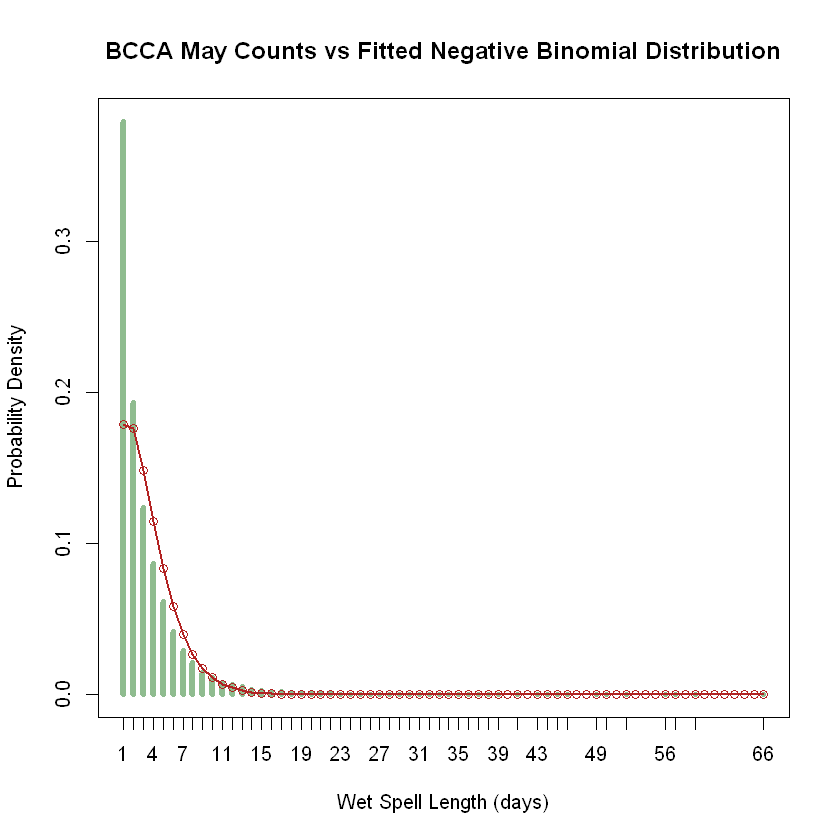

In [319]:
maxP <- max(dBCMay$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dMay_size, mu=BCfdNB_dMay_mu )
ttab <- table( dBCMay$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA May Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

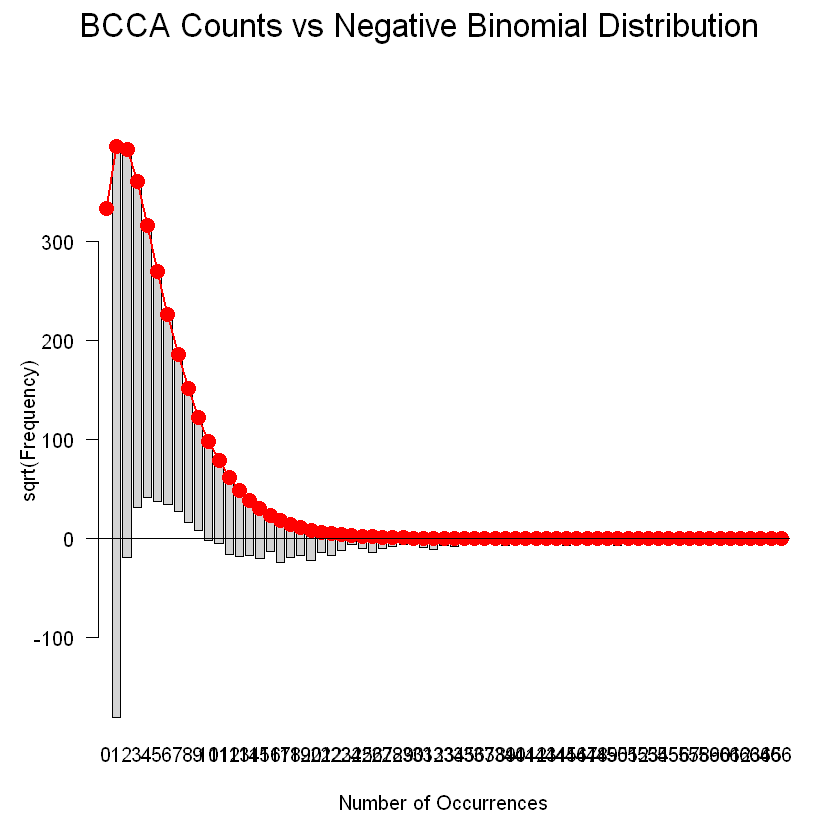

In [320]:
plot( BCgf_dMay, main="BCCA Counts vs Negative Binomial Distribution" )

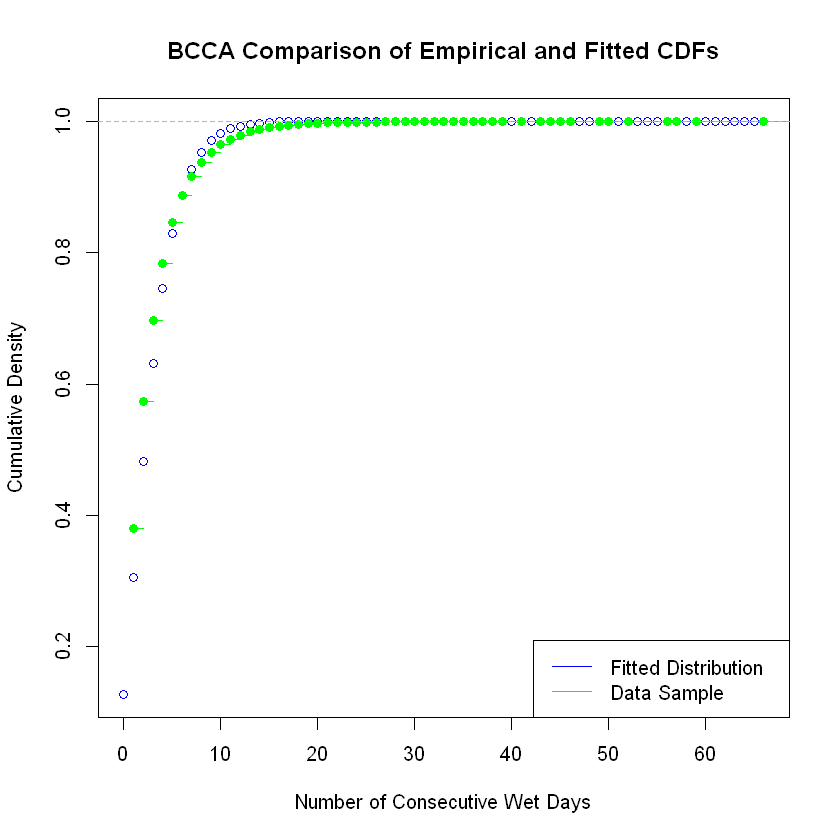

In [321]:
x <- seq(0,dBCMayMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dMay_mu, size=BCfdNB_dMay_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCMay$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

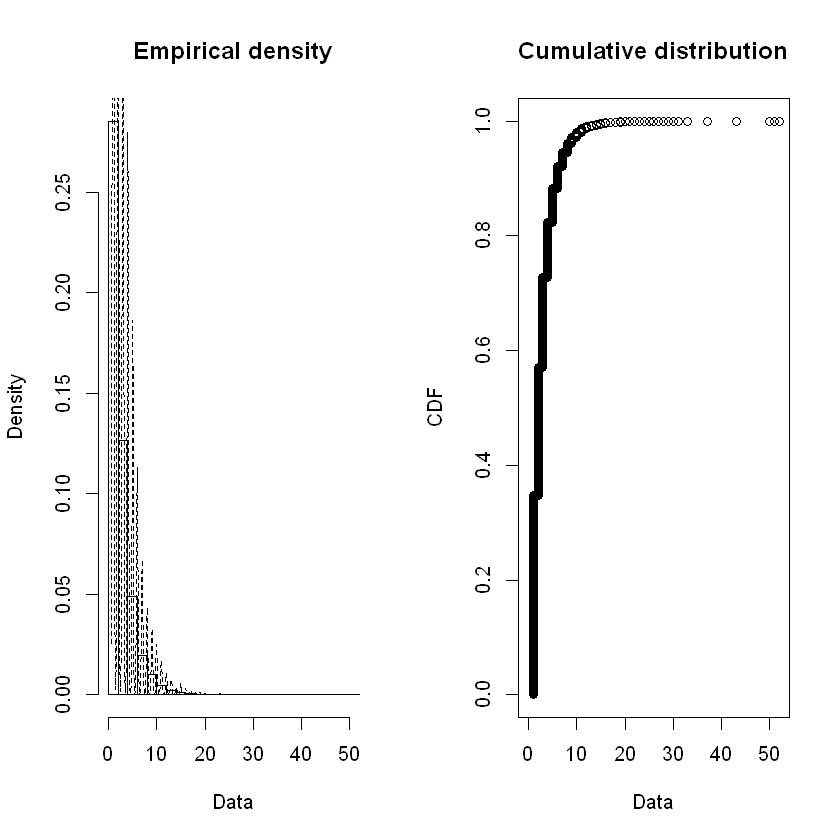

In [322]:
plotdist( dLOJun$Wet_Count, histo=TRUE, demp=TRUE )

In [323]:
LOfd_NB_dJun <- fitdist( dLOJun$Wet_Count, "nbinom" )
LOfd_GE_dJun <- fitdist( dLOJun$Wet_Count, "geom" )

In [324]:
LOfdNB_dJun_size <- LOfd_NB_dJun$estimate[["size"]]
LOfdNB_dJun_mu <- LOfd_NB_dJun$estimate[["mu"]]
cat("LOCA Jun size: ", LOfdNB_dJun_size, "\n", "LOCA Jun mu: ", LOfdNB_dJun_mu, "\n")

LOCA Jun size:  4.156345 
 LOCA Jun mu:  2.915073 


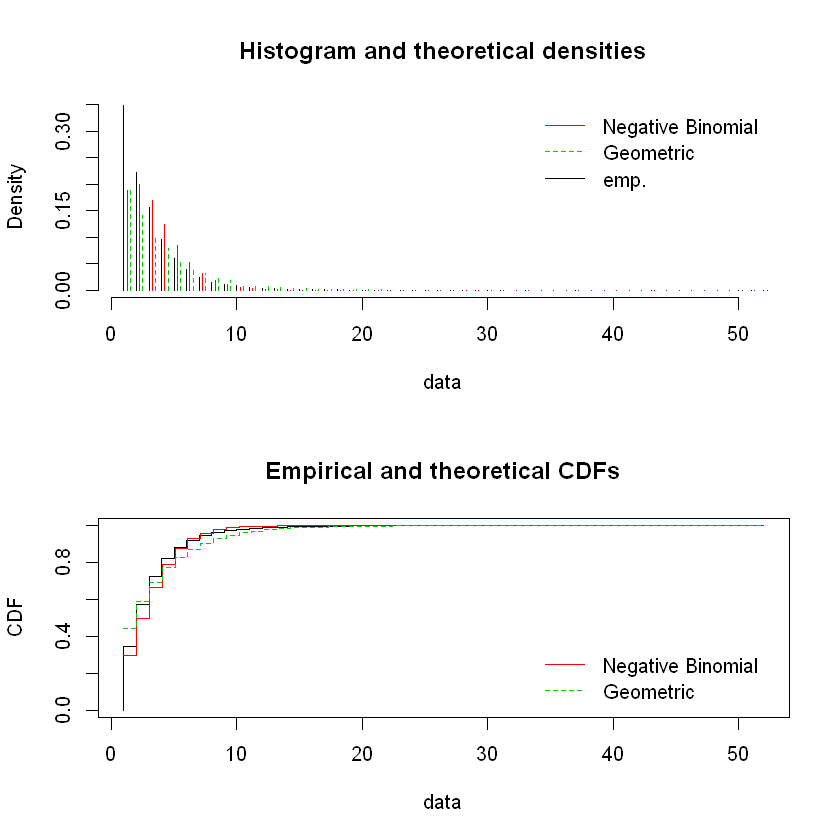

In [325]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dJun, LOfd_GE_dJun), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dJun, LOfd_GE_dJun), legendtext=plot.legend )

In [326]:
LOstatRes <- gofstat( list(LOfd_NB_dJun, LOfd_GE_dJun), fitnames=c("Negative Binomial", "Geometric") )

In [327]:
print( LOstatRes )

Chi-squared statistic:  211147.3 145260.9 
Degree of freedom of the Chi-squared distribution:  13 14 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     431014           369254.57545     552121.854
<= 2     276026           247813.00413     175452.561
<= 3     193803           209637.35518     130637.116
<= 4     119638           154611.87197      97268.778
<= 5      73082           103970.78262      72423.637
<= 6      48287            65407.13172      53924.634
<= 7      30081            39120.77099      40150.788
<= 8      18619            22489.62695      29895.165
<= 9      14075            12522.34479      22259.111
<= 10     10991             6791.47038      16573.518
<= 11      7303             3603.00748      12340.182
<= 12      4532             1875.95019       9188.158
<= 13      3325              961.08980       6841.248
<= 15      3715              727.77717       8886.508
<= 18      2807              206.32744    

In [328]:
LOfdNB_dJun_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [329]:
LOfdNB_dJun_p = LOfdNB_dJun_size / (LOfdNB_dJun_size + LOfdNB_dJun_mu)
cat("LOCA prob: ", LOfdNB_dJun_p)

LOCA prob:  0.5877669

In [330]:
# add to our tracking dataframe
LOMonDistDF[6, ] <- list( 6, dLOJunMean, dLOJunBNr, LOfdNB_dJun_p, LOfdNB_dJun_mu, LOfdNB_dJun_size,
                          LOfdNB_dJun_pvalue )

In [331]:
LOgf_dJun <- goodfit( dLOJun$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dJun_size, prob=LOfdNB_dJun_p) )

In [332]:
summary( LOgf_dJun )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson               Inf 52        0
Likelihood Ratio 479599.9 36        0


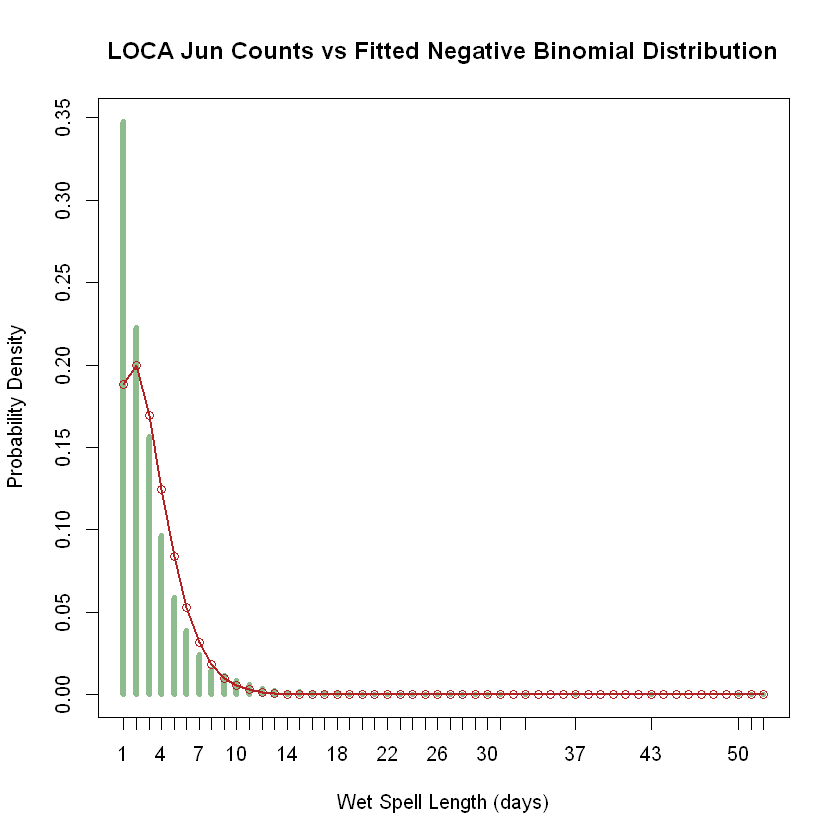

In [333]:
maxP <- max(dLOJun$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dJun_size, mu=LOfdNB_dJun_mu )
ttab <- table( dLOJun$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Jun Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

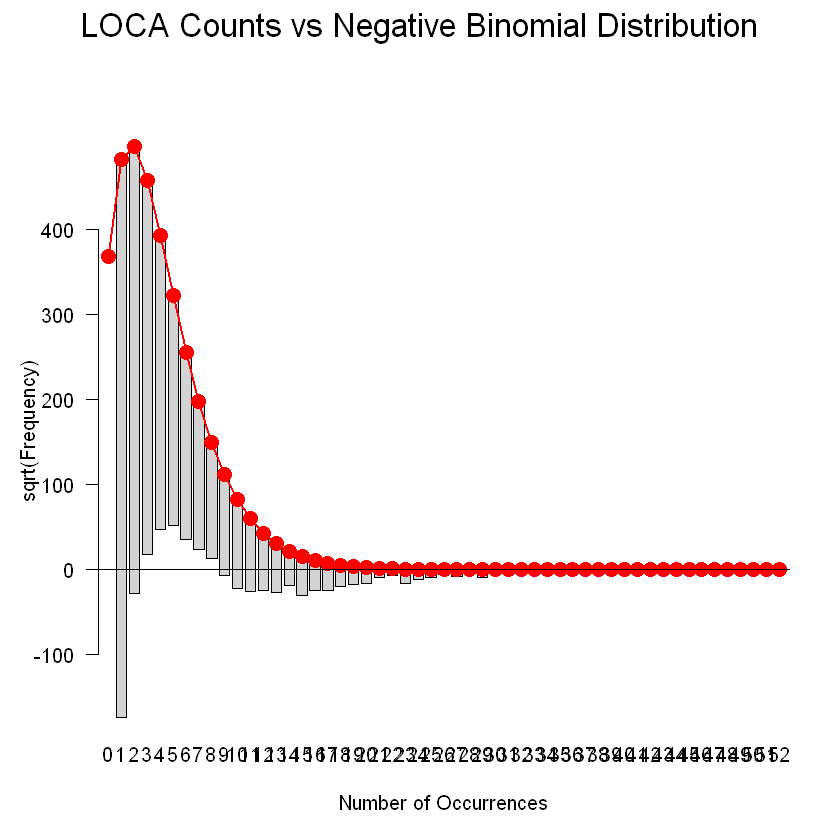

In [334]:
plot( LOgf_dJun, main="LOCA Counts vs Negative Binomial Distribution" )

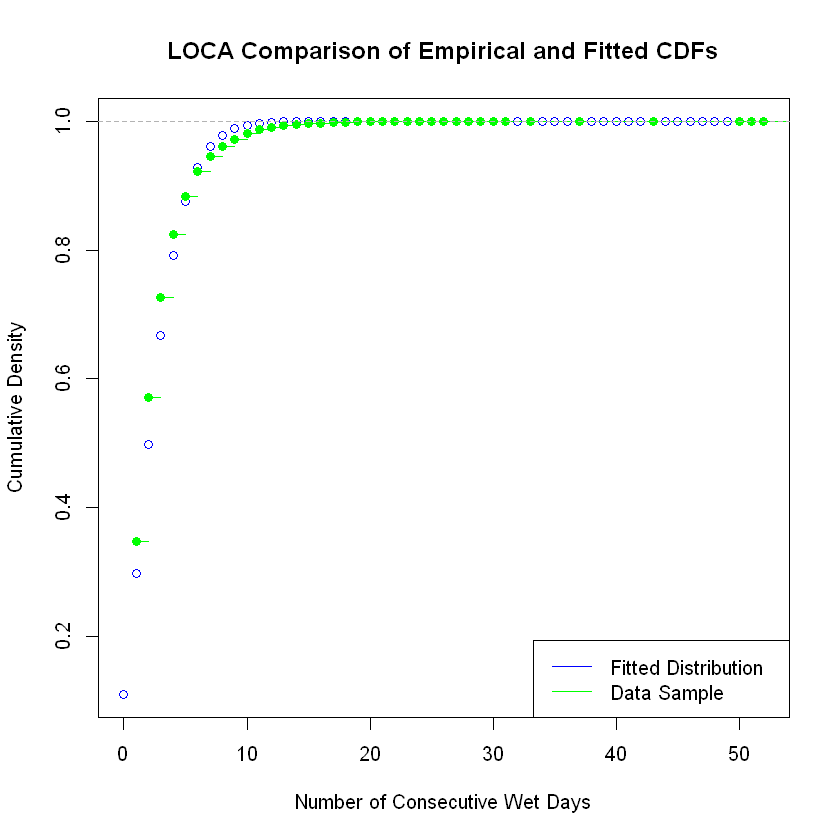

In [335]:
x <- seq(0,dLOJunMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dJun_mu, size=LOfdNB_dJun_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOJun$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

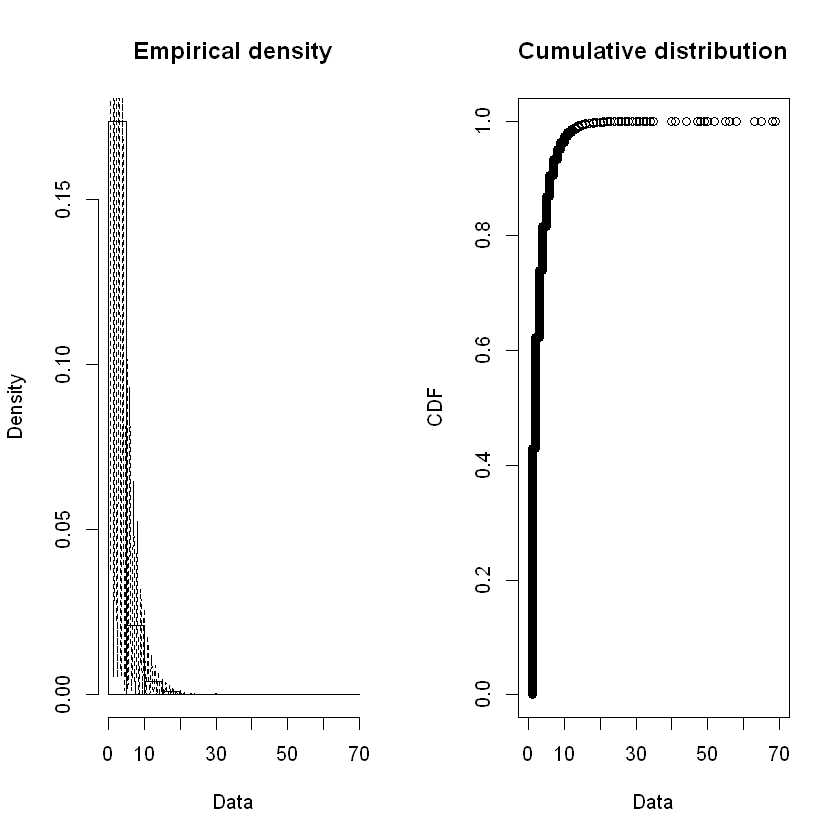

In [336]:
plotdist( dBCJun$Wet_Count, histo=TRUE, demp=TRUE )

In [337]:
BCfd_NB_dJun <- fitdist( dBCJun$Wet_Count, "nbinom" )
BCfd_GE_dJun <- fitdist( dBCJun$Wet_Count, "geom" )

In [338]:
summary( BCfd_NB_dJun )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 2.811326 0.007965855
mu   2.874571 0.002659088
Loglikelihood:  -1734009   AIC:  3468023   BIC:  3468046 
Correlation matrix:
              size            mu
size  1.0000000000 -0.0001352767
mu   -0.0001352767  1.0000000000


In [339]:
BCfdNB_dJun_size <- BCfd_NB_dJun$estimate[["size"]]
BCfdNB_dJun_mu <- BCfd_NB_dJun$estimate[["mu"]]
cat("BCCA Jun size: ", BCfdNB_dJun_size, "\n", "BCCA Jun mu: ", BCfdNB_dJun_mu, "\n")

BCCA Jun size:  2.811326 
 BCCA Jun mu:  2.874571 


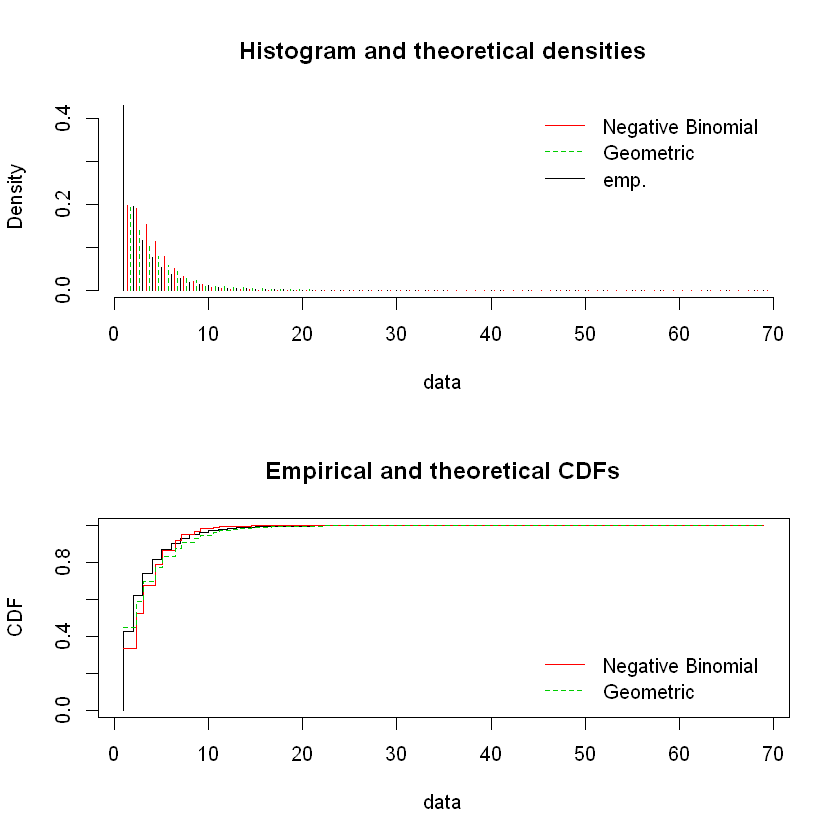

In [340]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dJun, BCfd_GE_dJun), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dJun, BCfd_GE_dJun), legendtext=plot.legend )

In [341]:
BCstatRes <- gofstat( list(BCfd_NB_dJun, BCfd_GE_dJun), fitnames=c("Negative Binomial", "Geometric") )

In [342]:
print(BCstatRes)

Chi-squared statistic:  143609.6 25404.35 
Degree of freedom of the Chi-squared distribution:  14 15 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     352387           274884.64062     369724.116
<= 2     160391           155456.04433     116825.123
<= 3      95725           126044.88079      86671.411
<= 4      62565            92579.43497      64300.668
<= 5      43310            63760.28542      47704.034
<= 6      30866            41966.02431      35391.154
<= 7      21970            26706.38580      26256.349
<= 8      14670            16558.72517      19479.328
<= 9      10238            10056.28125      14451.522
<= 10      8685             6004.96010      10721.442
<= 11      5649             3535.78282       7954.132
<= 12      4205             2057.37648       5901.093
<= 13      3050             1185.05475       4377.963
<= 14      2442              676.63231       3247.967
<= 16      2846              599.15549    

In [343]:
BCfdNB_dJun_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [344]:
BCfdNB_dJun_p = BCfdNB_dJun_size / (BCfdNB_dJun_size + BCfdNB_dJun_mu)
cat("BCCA prob: ", BCfdNB_dJun_p)

BCCA prob:  0.4944384

In [345]:
# add to our tracking dataframe
BCMonDistDF[6, ] <- list( 6, dBCJunMean, dBCJunBNr, BCfdNB_dJun_p, BCfdNB_dJun_mu, BCfdNB_dJun_size,
                          BCfdNB_dJun_pvalue )

In [346]:
BCgf_dJun <- goodfit( dBCJun$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dJun_size, prob=BCfdNB_dJun_p) )

In [347]:
summary( BCgf_dJun )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson               NaN 69      NaN
Likelihood Ratio 456438.3 49        0


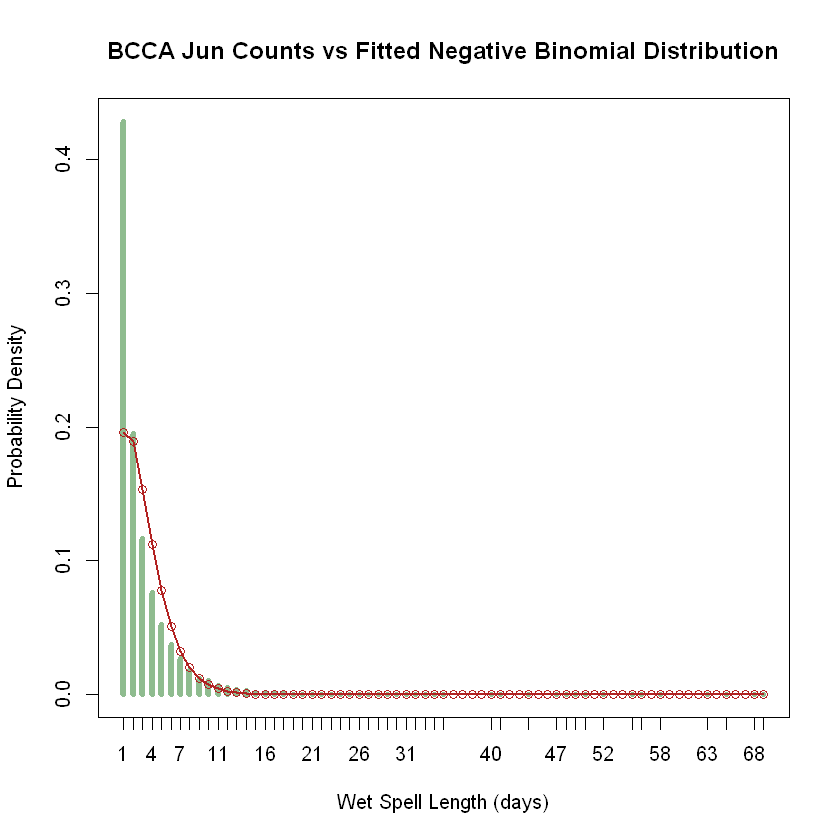

In [348]:
maxP <- max(dBCJun$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dJun_size, mu=BCfdNB_dJun_mu )
ttab <- table( dBCJun$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Jun Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

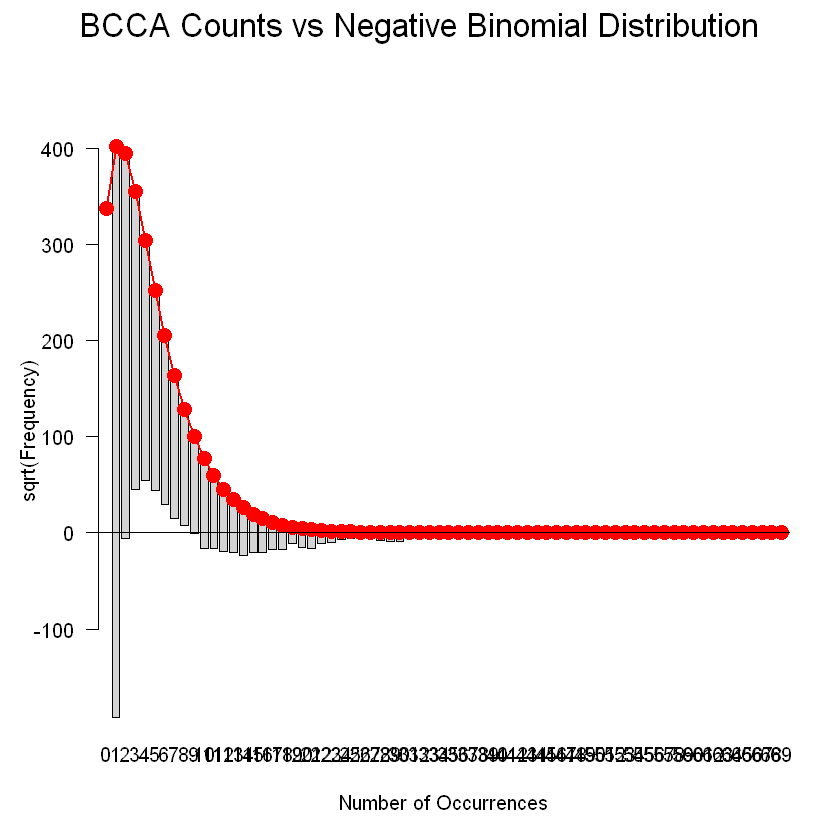

In [349]:
plot( BCgf_dJun, main="BCCA Counts vs Negative Binomial Distribution" )

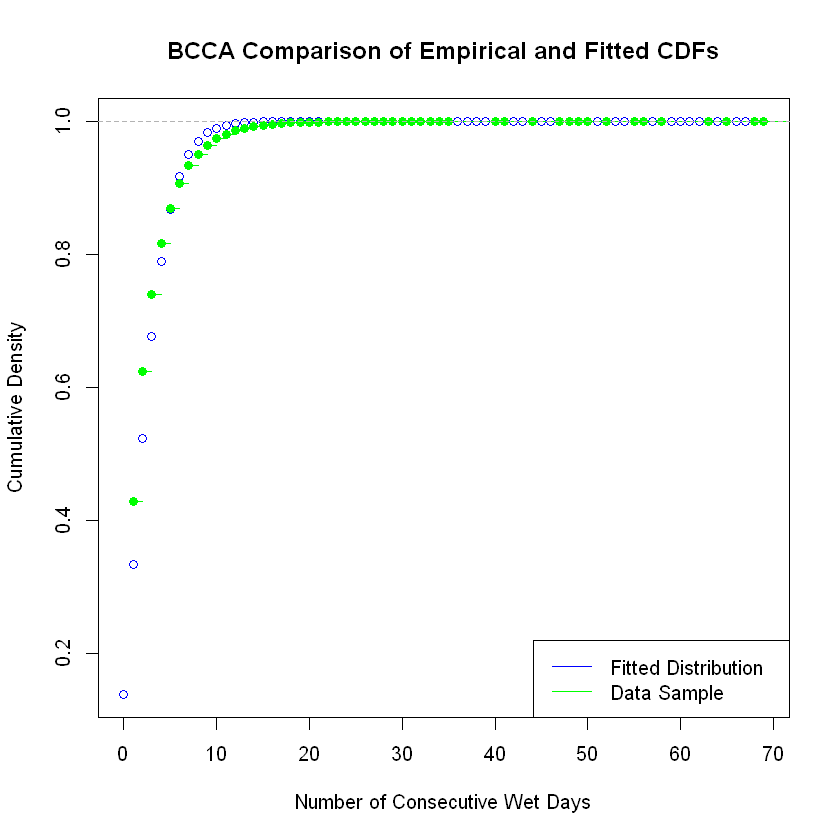

In [350]:
x <- seq(0,dBCJunMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dJun_mu, size=BCfdNB_dJun_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCJun$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

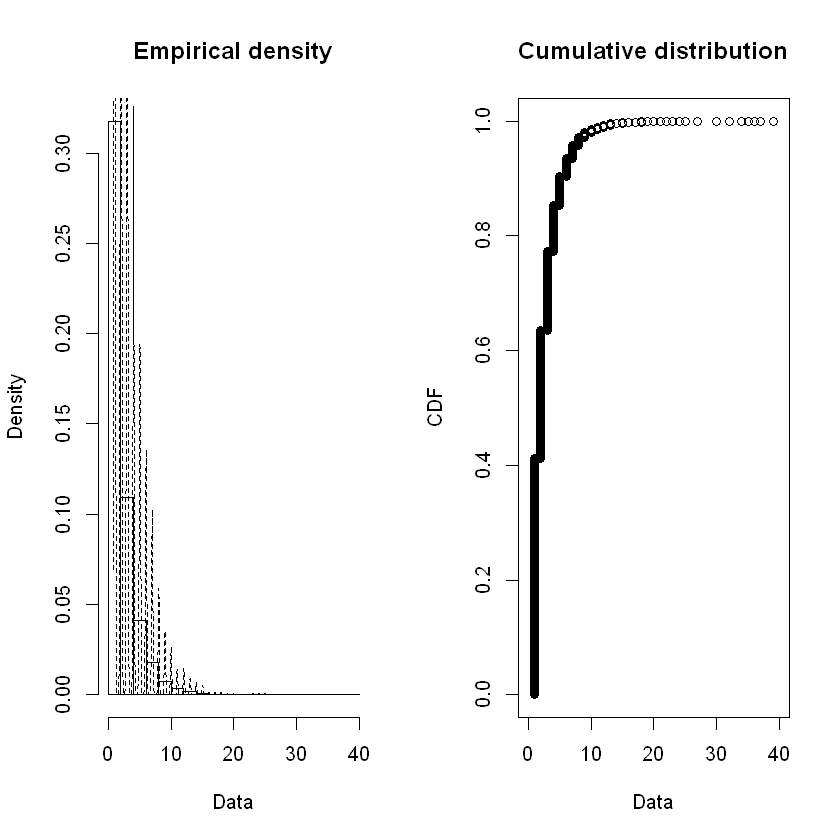

In [351]:
plotdist( dLOJul$Wet_Count, histo=TRUE, demp=TRUE )

In [352]:
LOfd_NB_dJul <- fitdist( dLOJul$Wet_Count, "nbinom" )
LOfd_GE_dJul <- fitdist( dLOJul$Wet_Count, "geom" )

In [353]:
LOfdNB_dJul_size <- LOfd_NB_dJul$estimate[["size"]]
LOfdNB_dJul_mu <- LOfd_NB_dJul$estimate[["mu"]]
cat("LOCA Jul size: ", LOfdNB_dJul_size, "\n", "LOCA Jul mu: ", LOfdNB_dJul_mu, "\n")

LOCA Jul size:  4.43688 
 LOCA Jul mu:  2.626236 


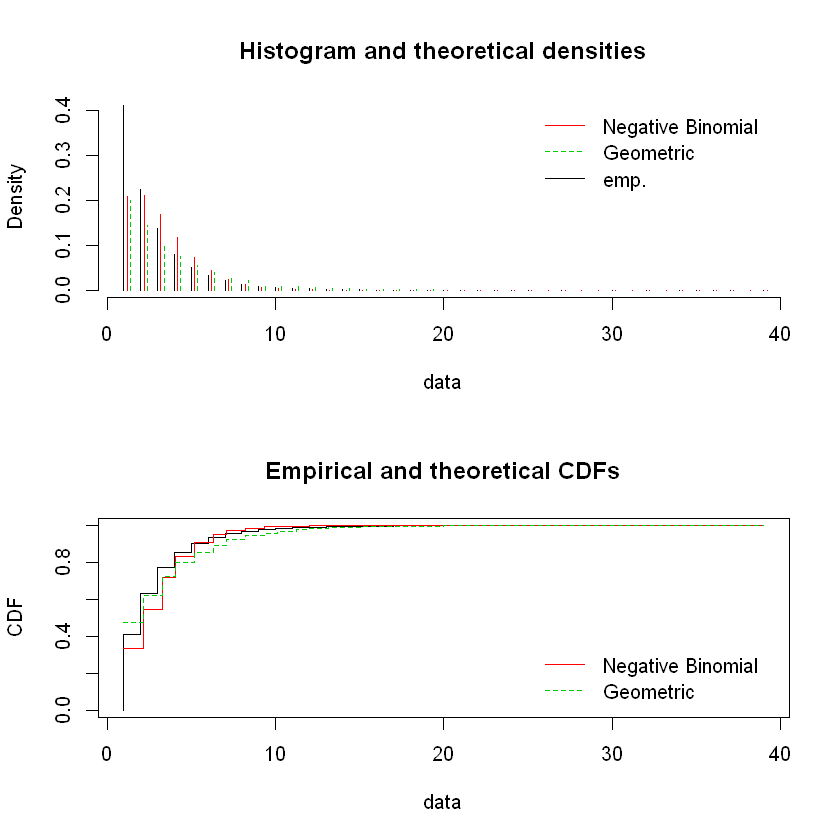

In [354]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dJul, LOfd_GE_dJul), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dJul, LOfd_GE_dJul), legendtext=plot.legend )

In [355]:
LOstatRes <- gofstat( list(LOfd_NB_dJul, LOfd_GE_dJul), fitnames=c("Negative Binomial", "Geometric") )

In [356]:
print( LOstatRes )

Chi-squared statistic:  151897.4 85647.81 
Degree of freedom of the Chi-squared distribution:  12 13 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     430300           352272.48561     497402.105
<= 2     234192           221690.92445     151309.008
<= 3     144501           176864.00082     109582.418
<= 4      83509           122266.53440      79362.799
<= 5      52622            76710.85922      57476.865
<= 6      33364            44861.25387      41626.430
<= 7      23413            24870.32370      30147.080
<= 8      14276            13220.15041      21833.399
<= 9       9336             6792.70435      15812.387
<= 10      6417             3393.73974      11451.794
<= 11      3289             1656.13821       8293.725
<= 12      3642              792.15879       6006.559
<= 13      2413              372.41371       4350.126
<= 15      2972              251.28628       5432.165
> 15       1833               64.02644    

In [357]:
LOfdNB_dJul_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [358]:
LOfdNB_dJul_p = LOfdNB_dJul_size / (LOfdNB_dJul_size + LOfdNB_dJul_mu)
cat("LOCA prob: ", LOfdNB_dJul_p)

LOCA prob:  0.628176

In [359]:
# add to our tracking dataframe
LOMonDistDF[7, ] <- list( 7, dLOJulMean, dLOJulBNr, LOfdNB_dJul_p, LOfdNB_dJul_mu, LOfdNB_dJul_size,
                          LOfdNB_dJul_pvalue )

In [360]:
LOgf_dJul <- goodfit( dLOJul$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dJul_size, prob=LOfdNB_dJul_p) )

In [361]:
summary( LOgf_dJul )


	 Goodness-of-fit test for nbinomial distribution

                          X^2 df P(> X^2)
Pearson          1764180355.8 39        0
Likelihood Ratio     496112.8 32        0


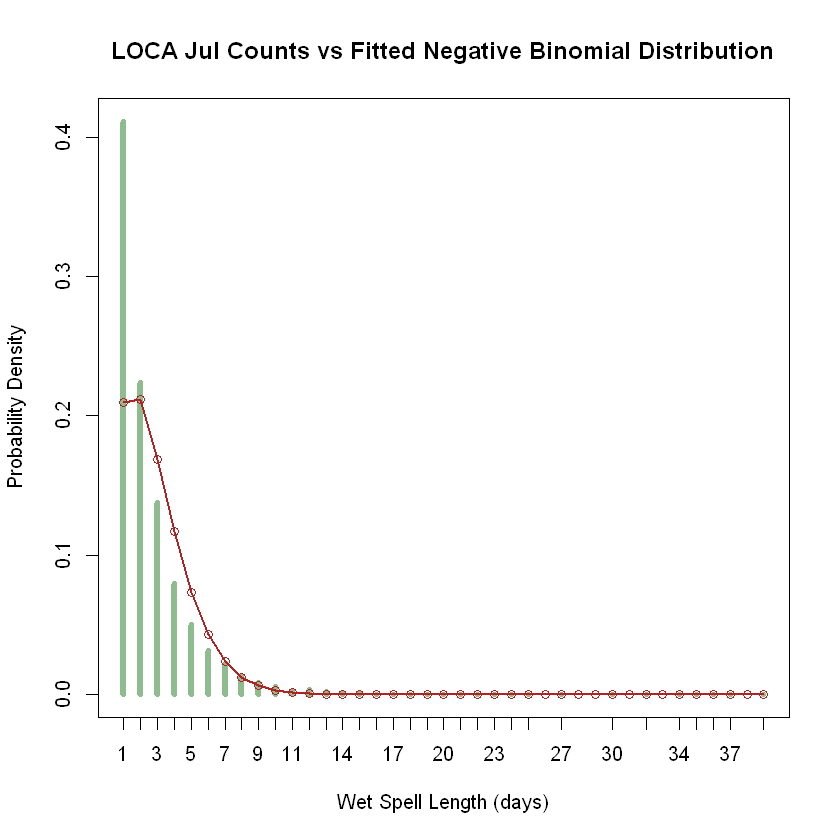

In [362]:
maxP <- max(dLOJul$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dJul_size, mu=LOfdNB_dJul_mu )
ttab <- table( dLOJul$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Jul Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

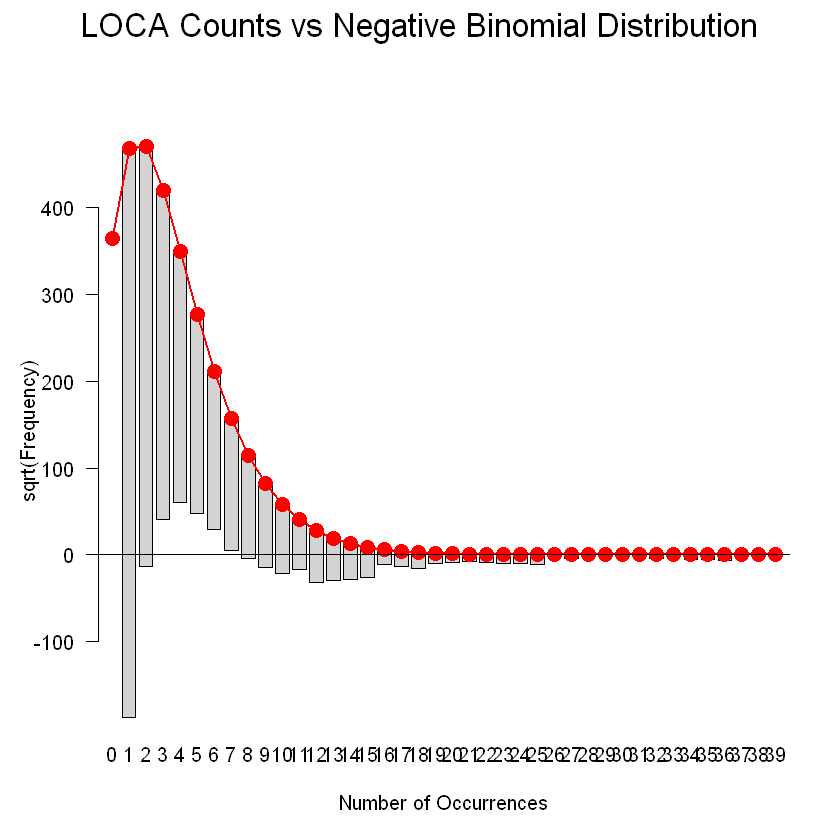

In [363]:
plot( LOgf_dJul, main="LOCA Counts vs Negative Binomial Distribution" )

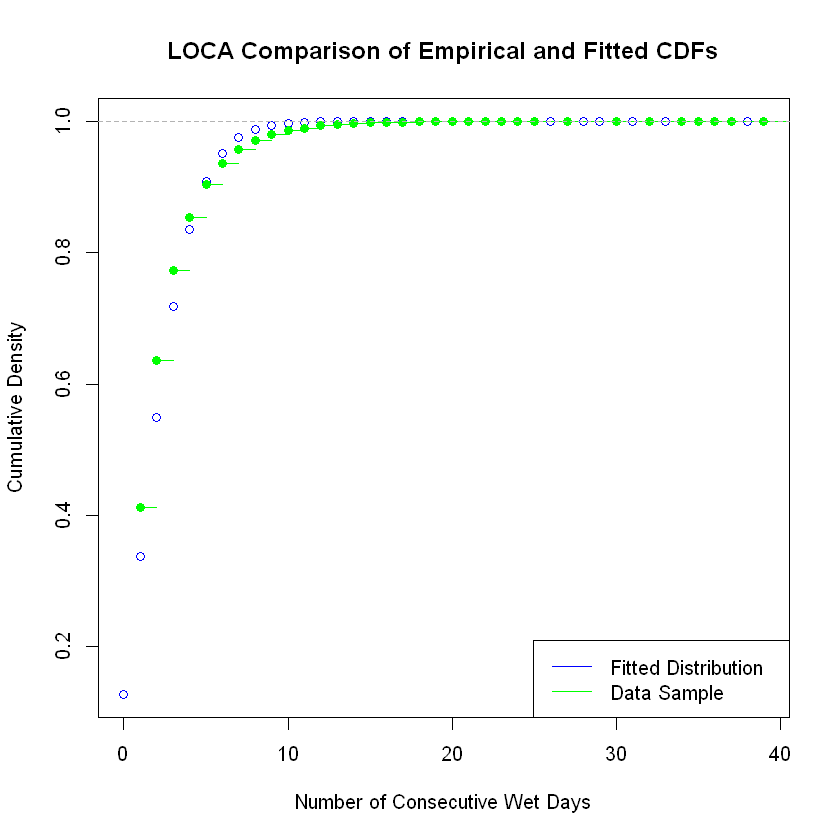

In [364]:
x <- seq(0,dLOJulMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dJul_mu, size=LOfdNB_dJul_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOJul$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

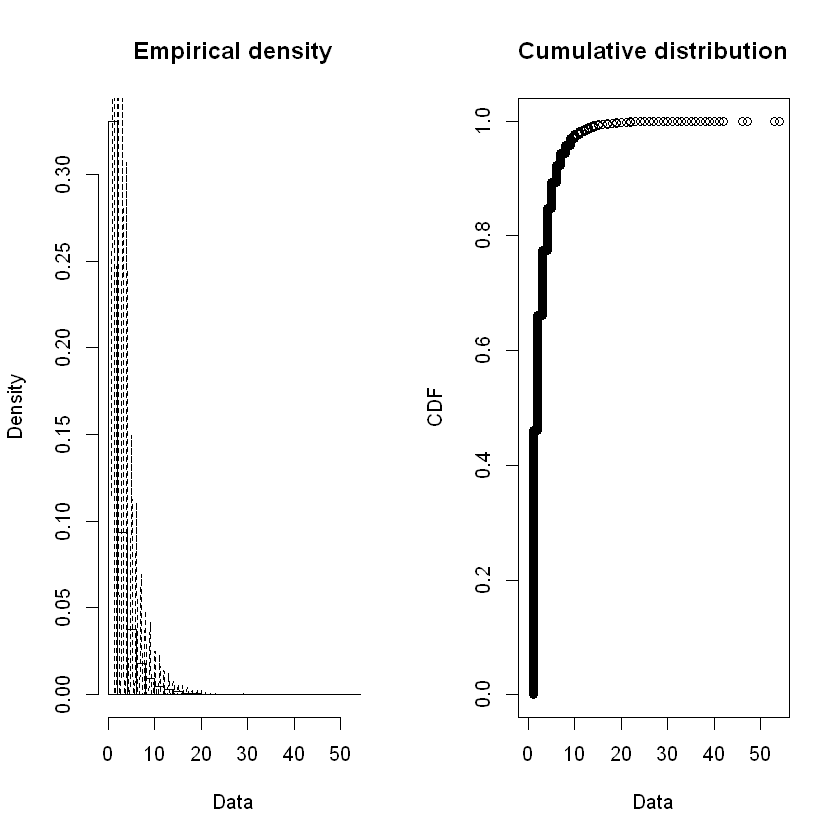

In [365]:
plotdist( dBCJul$Wet_Count, histo=TRUE, demp=TRUE )

In [366]:
BCfd_NB_dJul <- fitdist( dBCJul$Wet_Count, "nbinom" )
BCfd_GE_dJul <- fitdist( dBCJul$Wet_Count, "geom" )

In [367]:
summary( BCfd_NB_dJul )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 2.927585 0.008411883
mu   2.669843 0.002436957
Loglikelihood:  -1755401   AIC:  3510806   BIC:  3510829 
Correlation matrix:
             size           mu
size 1.000000e+00 3.807214e-05
mu   3.807214e-05 1.000000e+00


In [368]:
BCfdNB_dJul_size <- BCfd_NB_dJul$estimate[["size"]]
BCfdNB_dJul_mu <- BCfd_NB_dJul$estimate[["mu"]]
cat("BCCA Jul size: ", BCfdNB_dJul_size, "\n", "BCCA Jul mu: ", BCfdNB_dJul_mu, "\n")

BCCA Jul size:  2.927585 
 BCCA Jul mu:  2.669843 


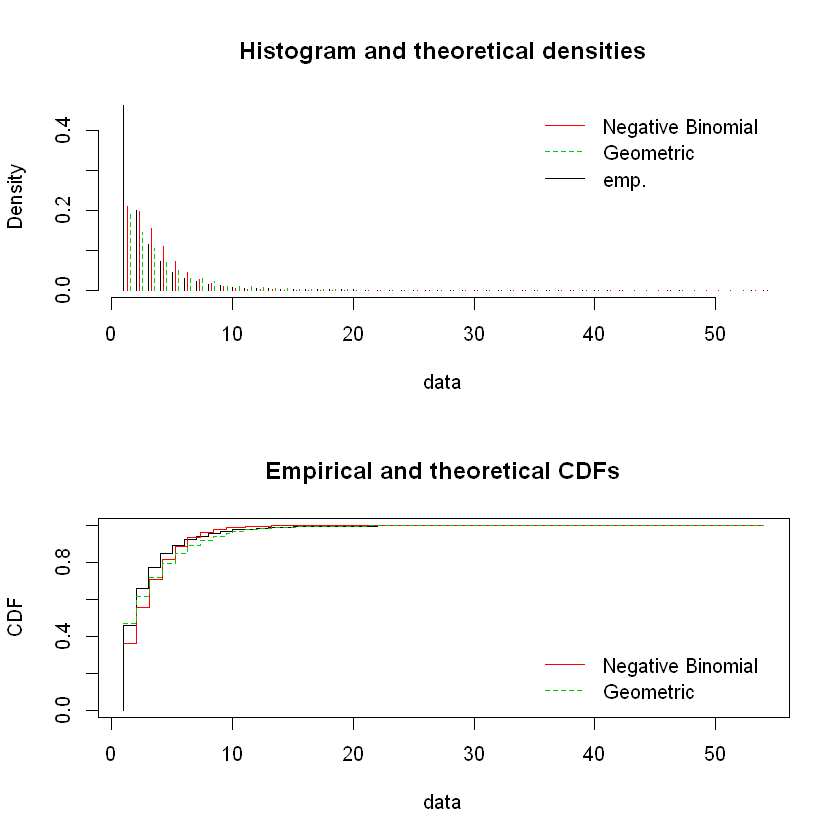

In [369]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dJul, BCfd_GE_dJul), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dJul, BCfd_GE_dJul), legendtext=plot.legend )

In [370]:
BCstatRes <- gofstat( list(BCfd_NB_dJul, BCfd_GE_dJul), fitnames=c("Negative Binomial", "Geometric") )

In [371]:
print(BCstatRes)

Chi-squared statistic:  230123 31623.94 
Degree of freedom of the Chi-squared distribution:  13 14 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     396352           308856.12824     404593.103
<= 2     171944           168576.97737     123959.390
<= 3      97893           132071.26783      90182.168
<= 4      62383            93351.94293      65608.773
<= 5      38642            61692.50942      47731.288
<= 6      26085            38879.37808      34725.171
<= 7      17786            23651.16183      25263.042
<= 8      12744            13999.20341      18379.212
<= 9       9509             8107.41165      13371.130
<= 10      6613             4612.45309       9727.682
<= 11      4386             2585.55569       7077.023
<= 12      3596             1431.34948       5148.632
<= 13      2695              783.95133       3745.701
<= 15      3518              654.39664       4707.560
<= 17      2293              187.37014      

In [372]:
BCfdNB_dJul_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [373]:
BCfdNB_dJul_p = BCfdNB_dJul_size / (BCfdNB_dJul_size + BCfdNB_dJul_mu)
cat("BCCA prob: ", BCfdNB_dJul_p)

BCCA prob:  0.5230232

In [374]:
# add to our tracking dataframe
BCMonDistDF[7, ] <- list( 7, dBCJulMean, dBCJulBNr, BCfdNB_dJul_p, BCfdNB_dJul_mu, BCfdNB_dJul_size,
                          BCfdNB_dJul_pvalue )

In [375]:
BCgf_dJul <- goodfit( dBCJul$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dJul_size, prob=BCfdNB_dJul_p) )

In [376]:
summary( BCgf_dJul )


	 Goodness-of-fit test for nbinomial distribution

                          X^2 df P(> X^2)
Pearson          9.337579e+10 54        0
Likelihood Ratio 5.336418e+05 45        0


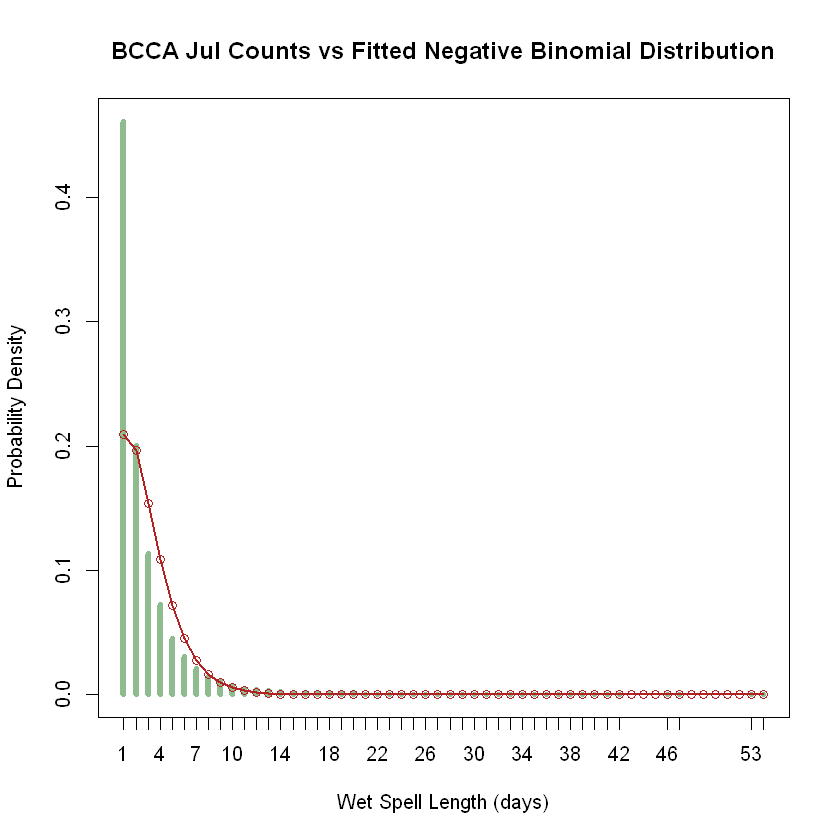

In [377]:
maxP <- max(dBCJul$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dJul_size, mu=BCfdNB_dJul_mu )
ttab <- table( dBCJul$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Jul Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

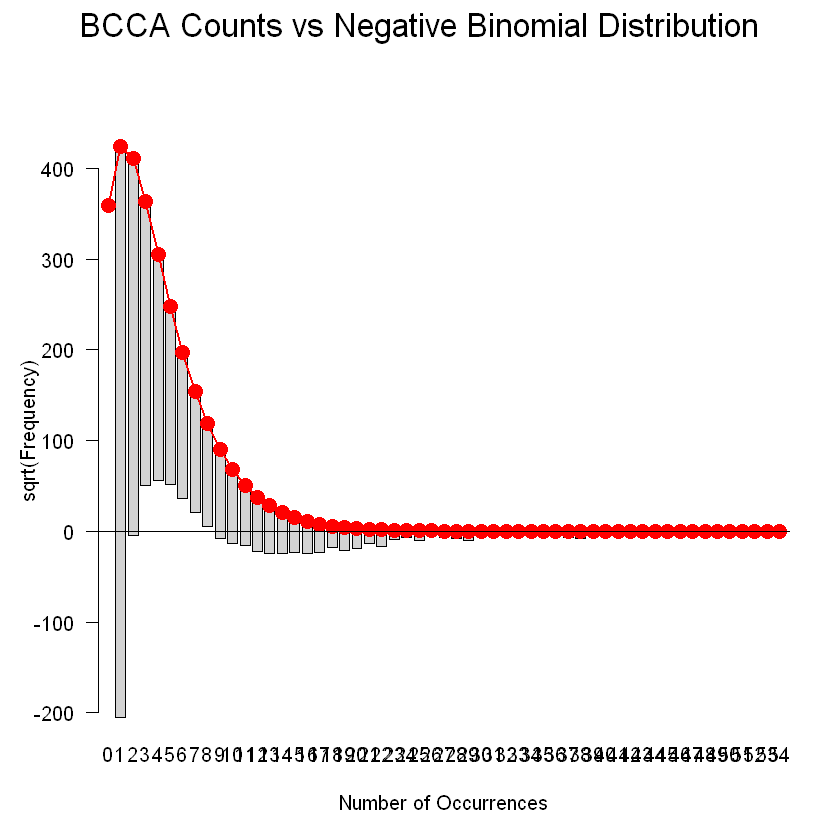

In [378]:
plot( BCgf_dJul, main="BCCA Counts vs Negative Binomial Distribution" )

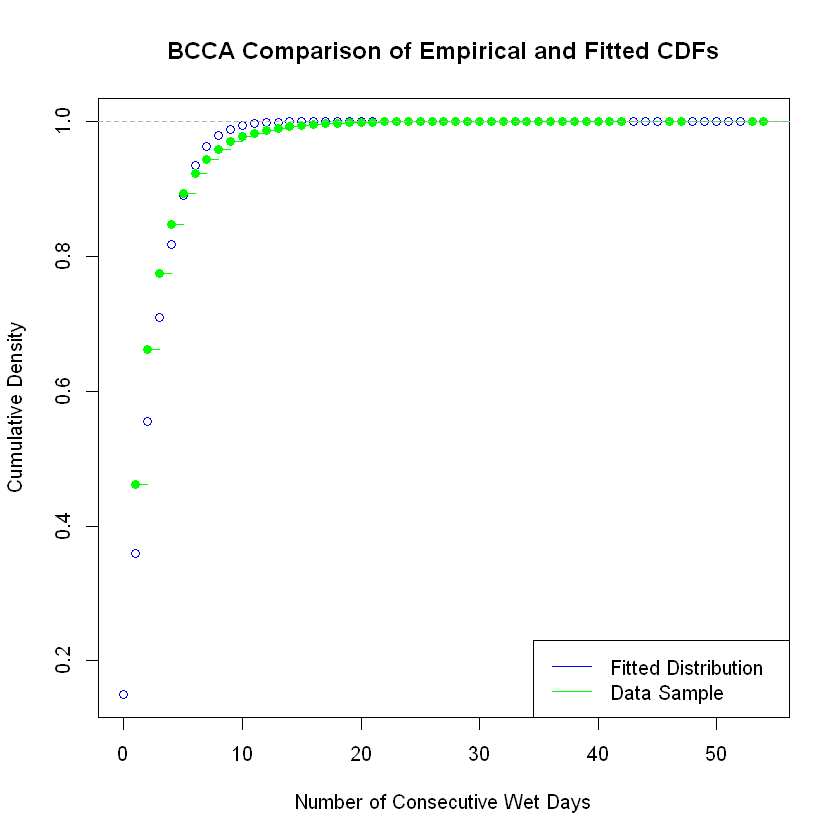

In [379]:
x <- seq(0,dBCJulMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dJul_mu, size=BCfdNB_dJul_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCJul$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

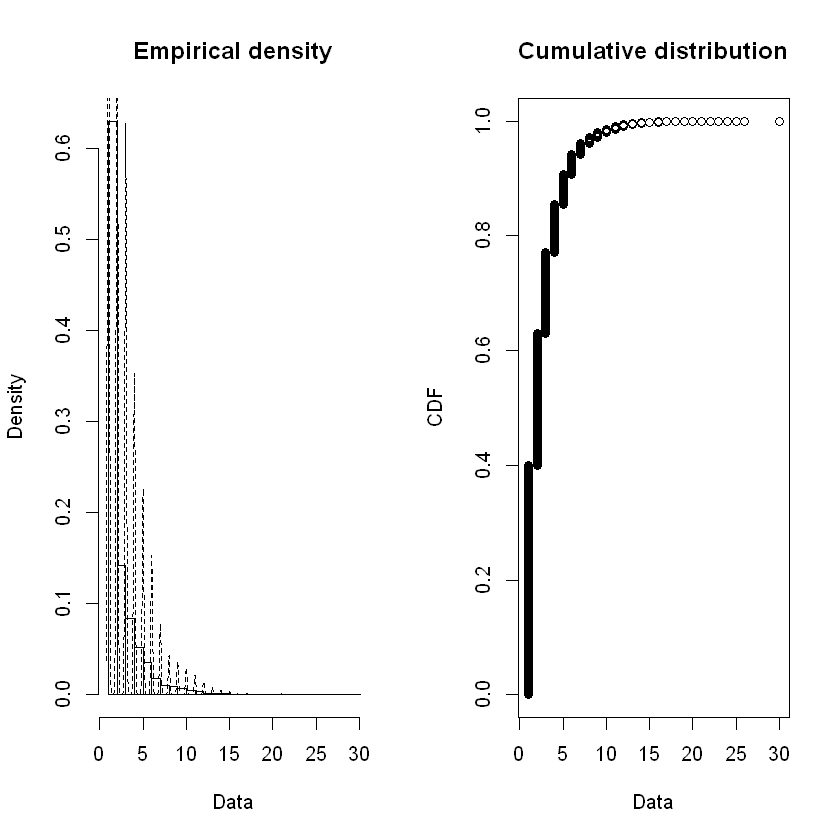

In [380]:
plotdist( dLOAug$Wet_Count, histo=TRUE, demp=TRUE )

In [381]:
LOfd_NB_dAug <- fitdist( dLOAug$Wet_Count, "nbinom" )
LOfd_GE_dAug <- fitdist( dLOAug$Wet_Count, "geom" )

In [382]:
LOfdNB_dAug_size <- LOfd_NB_dAug$estimate[["size"]]
LOfdNB_dAug_mu <- LOfd_NB_dAug$estimate[["mu"]]
cat("LOCA Aug size: ", LOfdNB_dAug_size, "\n", "LOCA Aug mu: ", LOfdNB_dAug_mu, "\n")

LOCA Aug size:  4.926165 
 LOCA Aug mu:  2.620971 


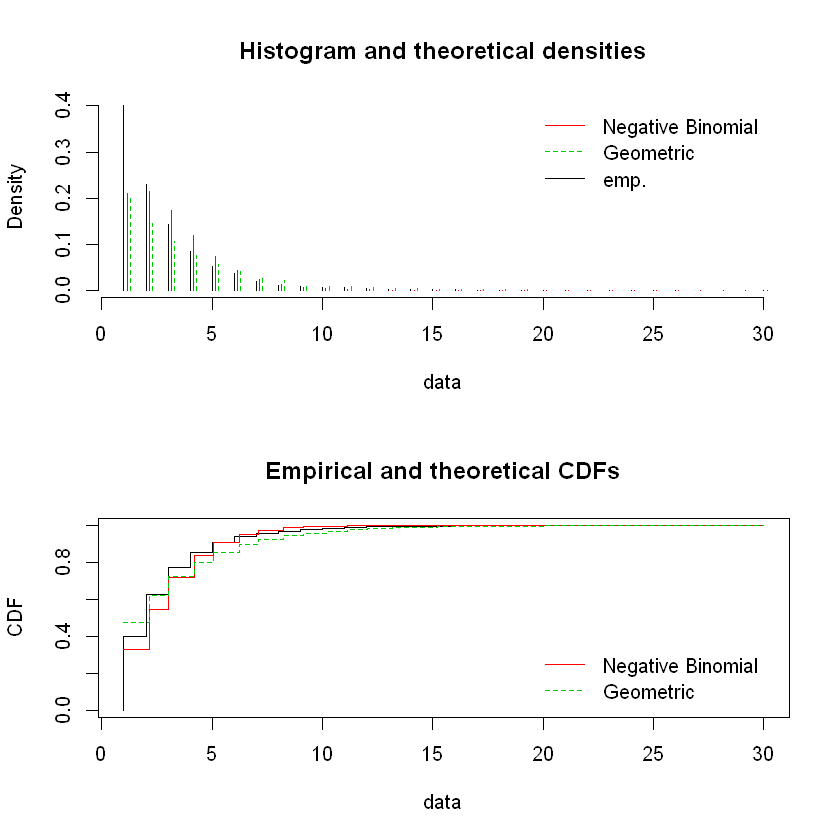

In [383]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dAug, LOfd_GE_dAug), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dAug, LOfd_GE_dAug), legendtext=plot.legend )

In [384]:
LOstatRes <- gofstat( list(LOfd_NB_dAug, LOfd_GE_dAug), fitnames=c("Negative Binomial", "Geometric") )

In [385]:
print( LOstatRes )

Chi-squared statistic:  151075 106511.3 
Degree of freedom of the Chi-squared distribution:  11 12 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     435204            360262.9979     517427.074
<= 2     249052            233959.9198     157273.080
<= 3     154396            187582.8402     113843.373
<= 4      91014            129085.1513      82406.434
<= 5      56093             80029.7125      59650.554
<= 6      38767             45979.2156      43178.529
<= 7      19866             24923.6322      31255.123
<= 8      11123             12903.3424      22624.270
<= 9       9334              6435.9026      16376.758
<= 10      7280              3112.5839      11854.447
<= 11      5464              1466.7519       8580.936
<= 12      3693               676.0311       6211.379
<= 14      3046               441.6021       7750.735
> 14       2632               104.3165       8531.308

Goodness-of-fit criteria
                  

In [386]:
LOfdNB_dAug_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [387]:
LOfdNB_dAug_p = LOfdNB_dAug_size / (LOfdNB_dAug_size + LOfdNB_dAug_mu)
cat("LOCA prob: ", LOfdNB_dAug_p)

LOCA prob:  0.6527198

In [388]:
# add to our tracking dataframe
LOMonDistDF[8, ] <- list( 8, dLOAugMean, dLOAugBNr, LOfdNB_dAug_p, LOfdNB_dAug_mu, LOfdNB_dAug_size,
                          LOfdNB_dAug_pvalue )

In [389]:
LOgf_dAug <- goodfit( dLOAug$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dAug_size, prob=LOfdNB_dAug_p) )

In [390]:
summary( LOgf_dAug )


	 Goodness-of-fit test for nbinomial distribution

                     X^2 df P(> X^2)
Pearson          2482509 30        0
Likelihood Ratio  485665 26        0


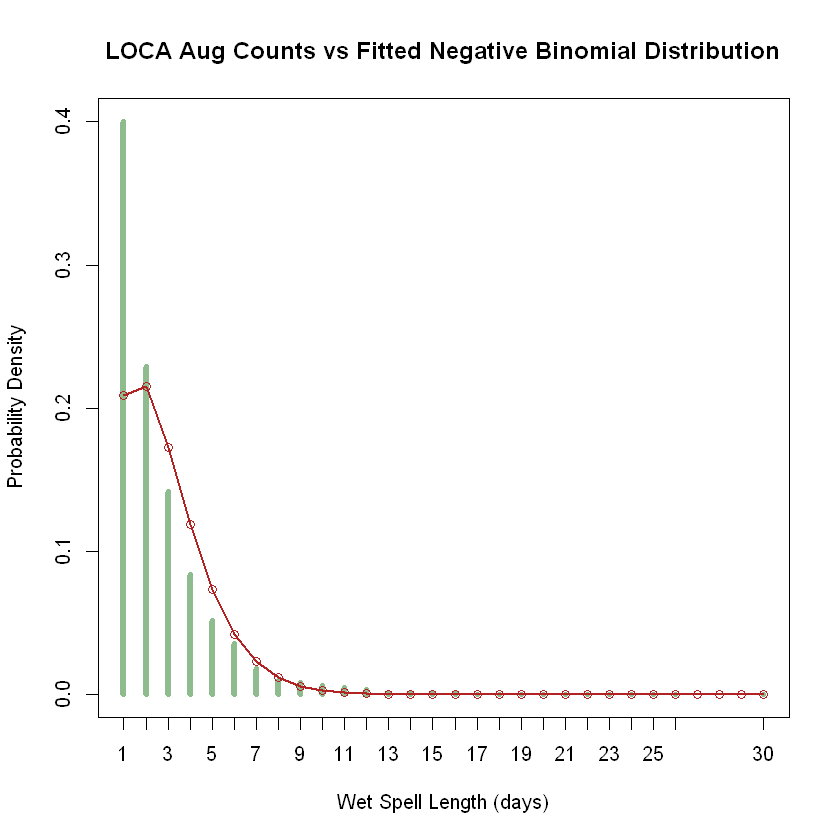

In [391]:
maxP <- max(dLOAug$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dAug_size, mu=LOfdNB_dAug_mu )
ttab <- table( dLOAug$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Aug Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

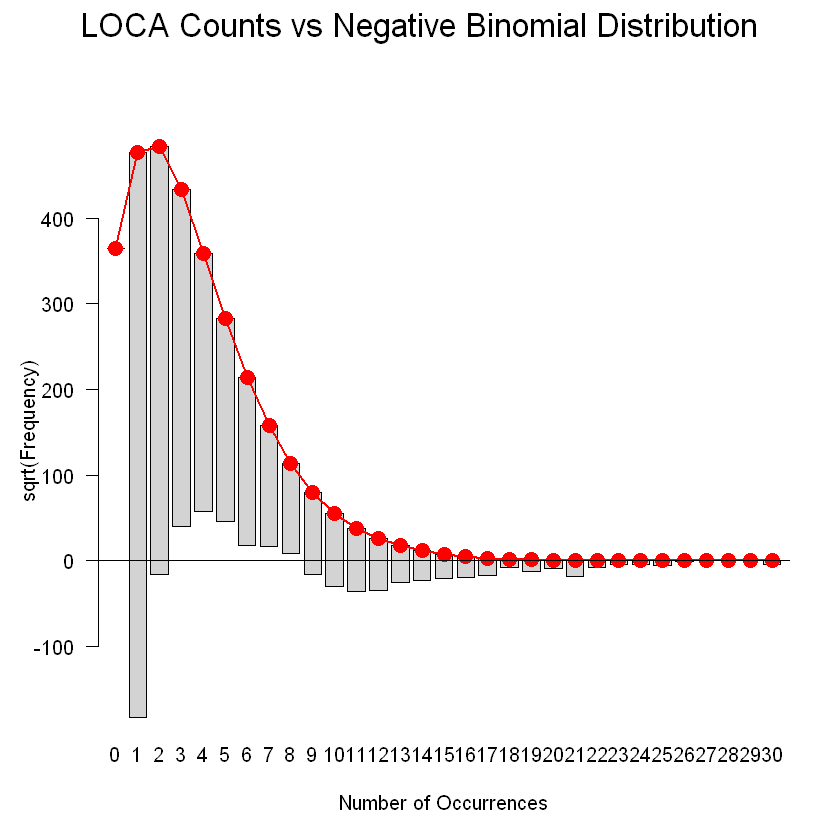

In [392]:
plot( LOgf_dAug, main="LOCA Counts vs Negative Binomial Distribution" )

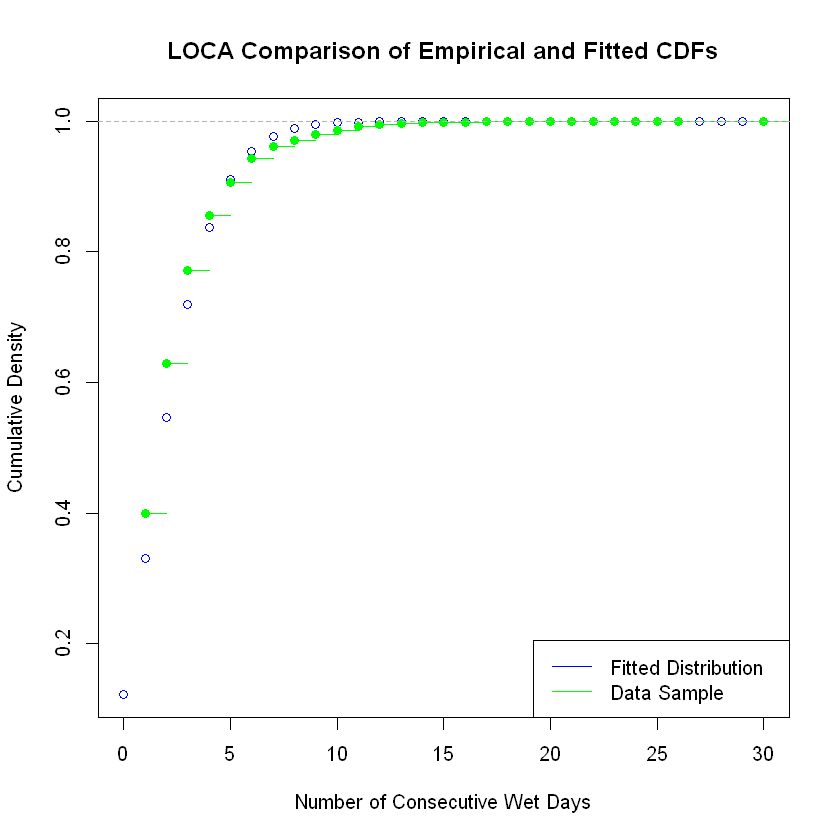

In [393]:
x <- seq(0,dLOAugMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dAug_mu, size=LOfdNB_dAug_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOAug$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

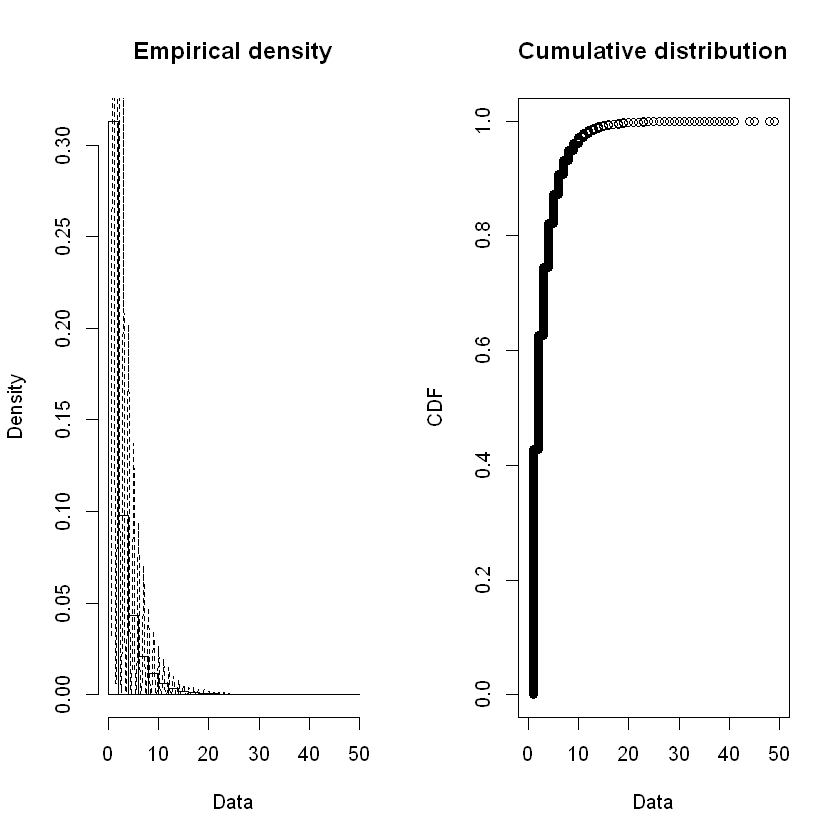

In [394]:
plotdist( dBCAug$Wet_Count, histo=TRUE, demp=TRUE )

In [395]:
BCfd_NB_dAug <- fitdist( dBCAug$Wet_Count, "nbinom" )
BCfd_GE_dAug <- fitdist( dBCAug$Wet_Count, "geom" )

In [396]:
summary( BCfd_NB_dAug )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 2.706971 0.007218849
mu   2.879949 0.002591089
Loglikelihood:  -1872792   AIC:  3745588   BIC:  3745612 
Correlation matrix:
              size            mu
size  1.0000000000 -0.0001450168
mu   -0.0001450168  1.0000000000


In [397]:
BCfdNB_dAug_size <- BCfd_NB_dAug$estimate[["size"]]
BCfdNB_dAug_mu <- BCfd_NB_dAug$estimate[["mu"]]
cat("BCCA Aug size: ", BCfdNB_dAug_size, "\n", "BCCA Aug mu: ", BCfdNB_dAug_mu, "\n")

BCCA Aug size:  2.706971 
 BCCA Aug mu:  2.879949 


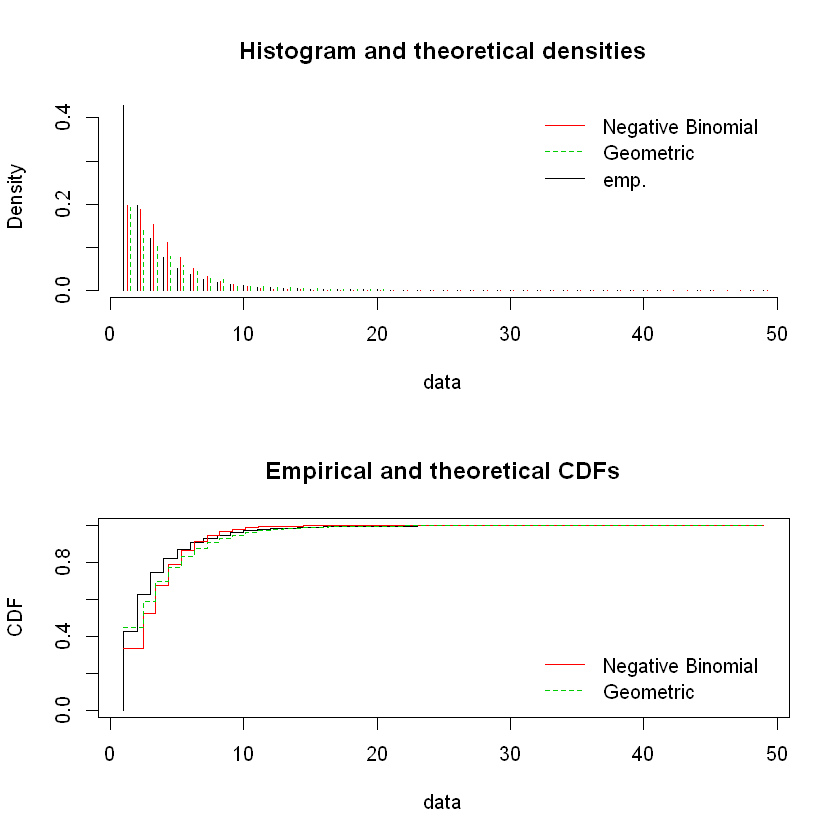

In [398]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dAug, BCfd_GE_dAug), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dAug, BCfd_GE_dAug), legendtext=plot.legend )

In [399]:
BCstatRes <- gofstat( list(BCfd_NB_dAug, BCfd_GE_dAug), fitnames=c("Negative Binomial", "Geometric") )

In [400]:
print(BCstatRes)

Chi-squared statistic:  263362.4 31617.21 
Degree of freedom of the Chi-squared distribution:  15 16 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     379254           2.983281e+05    397635.8937
<= 2     174979           1.660410e+05    125739.6626
<= 3     105927           1.342913e+05     93329.8237
<= 4      67274           9.876565e+04     69273.7344
<= 5      44739           6.829277e+04     51418.1865
<= 6      31481           4.521885e+04     38164.9686
<= 7      21210           2.899352e+04     28327.8141
<= 8      15422           1.813456e+04     21026.2207
<= 9      11531           1.112099e+04     15606.6386
<= 10      8839           6.711203e+03     11583.9728
<= 11      5749           3.996337e+03      8598.1632
<= 12      4639           2.353069e+03      6381.9565
<= 13      3351           1.372230e+03      4736.9848
<= 14      2580           7.936036e+02      3516.0104
<= 16      2944           7.155723e+02    

In [401]:
BCfdNB_dAug_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [402]:
BCfdNB_dAug_p = BCfdNB_dAug_size / (BCfdNB_dAug_size + BCfdNB_dAug_mu)
cat("BCCA prob: ", BCfdNB_dAug_p)

BCCA prob:  0.4845194

In [403]:
# add to our tracking dataframe
BCMonDistDF[8, ] <- list( 8, dBCAugMean, dBCAugBNr, BCfdNB_dAug_p, BCfdNB_dAug_mu, BCfdNB_dAug_size,
                          BCfdNB_dAug_pvalue )

In [404]:
BCgf_dAug <- goodfit( dBCAug$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dAug_size, prob=BCfdNB_dAug_p) )

In [405]:
summary( BCgf_dAug )


	 Goodness-of-fit test for nbinomial distribution

                        X^2 df P(> X^2)
Pearson          34834504.4 49        0
Likelihood Ratio   502507.9 44        0


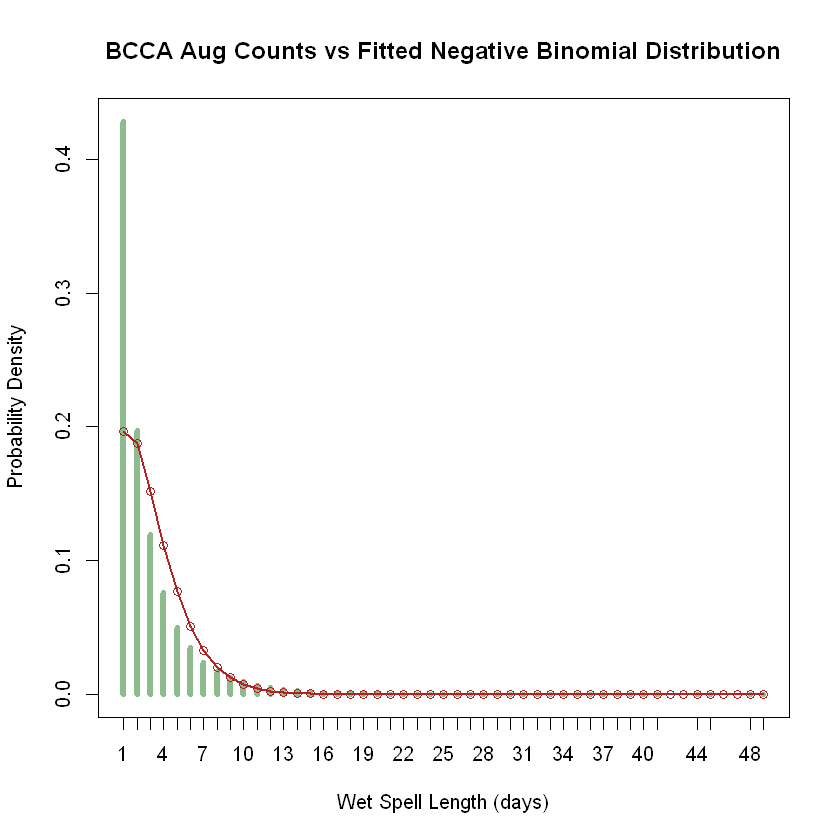

In [406]:
maxP <- max(dBCAug$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dAug_size, mu=BCfdNB_dAug_mu )
ttab <- table( dBCAug$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Aug Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

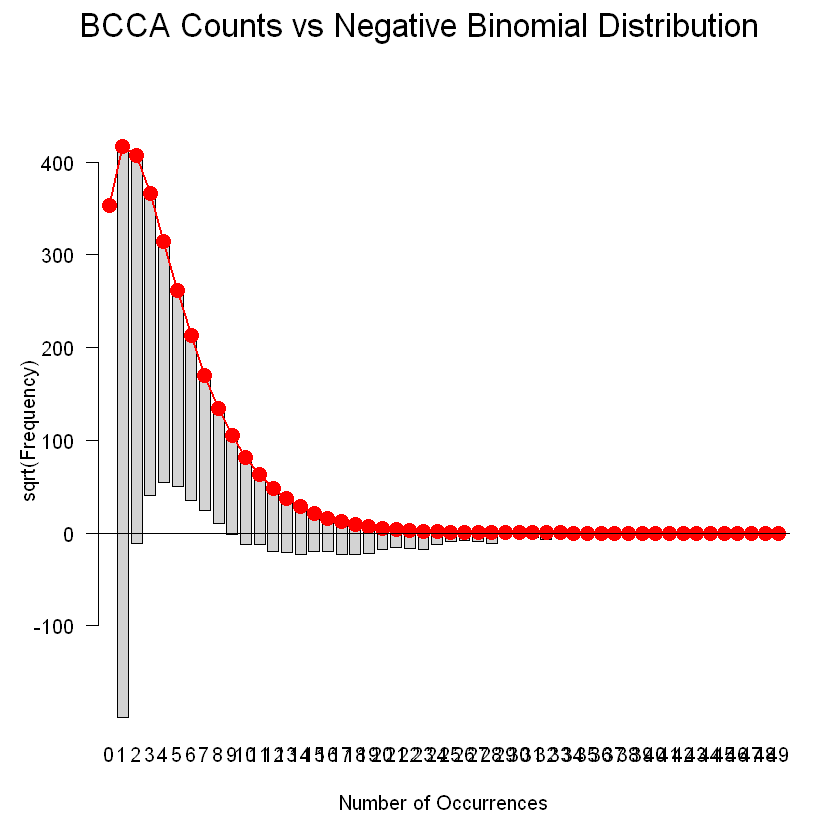

In [407]:
plot( BCgf_dAug, main="BCCA Counts vs Negative Binomial Distribution" )

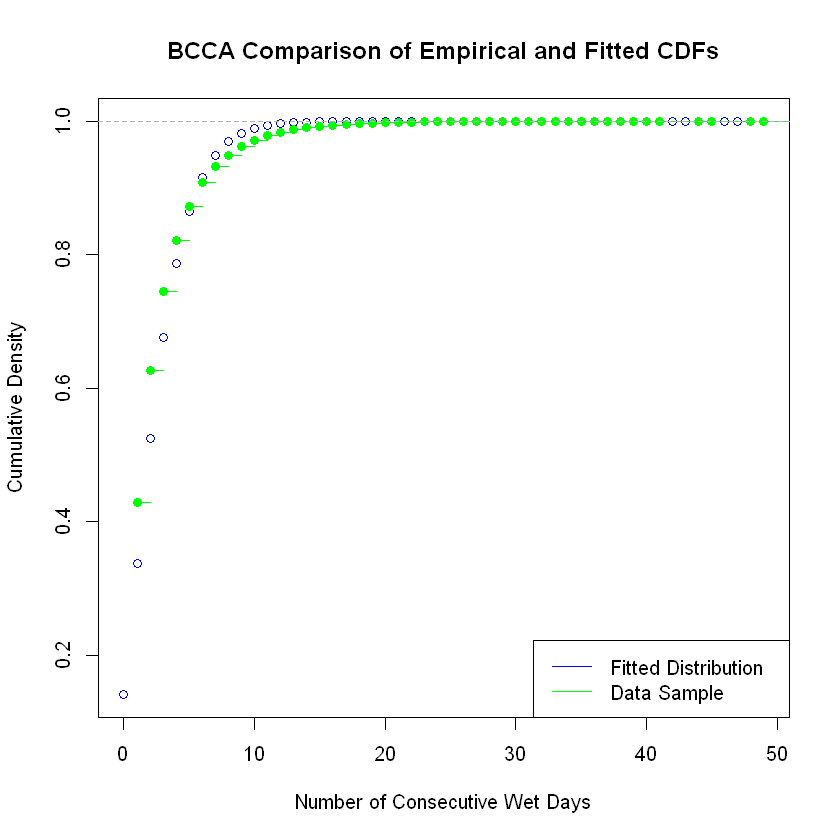

In [408]:
x <- seq(0,dBCAugMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dAug_mu, size=BCfdNB_dAug_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCAug$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

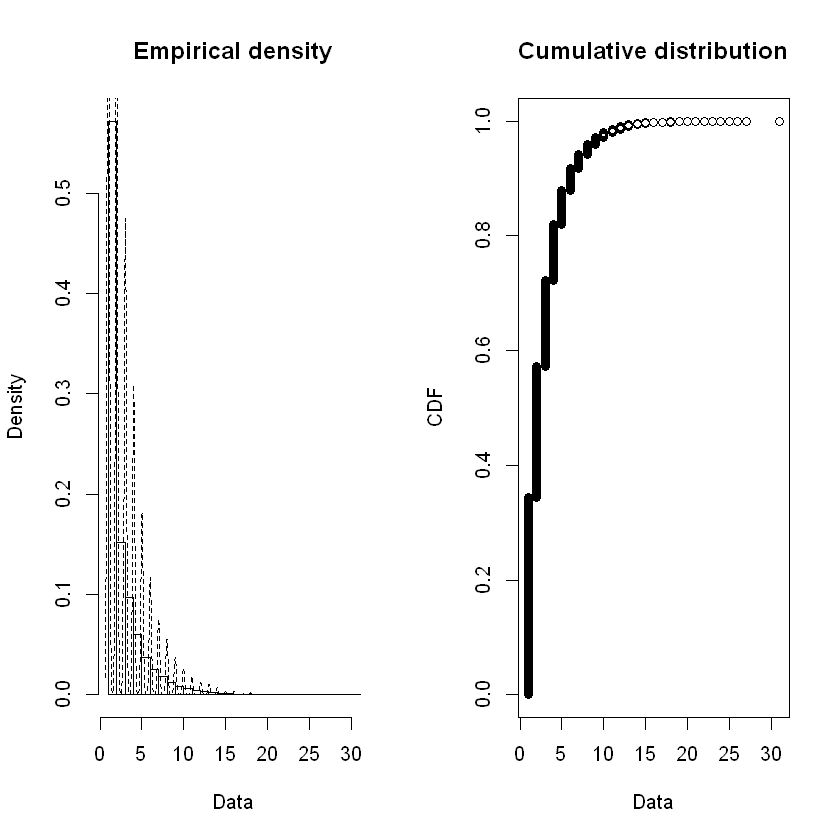

In [409]:
plotdist( dLOSep$Wet_Count, histo=TRUE, demp=TRUE )

In [410]:
LOfd_NB_dSep <- fitdist( dLOSep$Wet_Count, "nbinom" )
LOfd_GE_dSep <- fitdist( dLOSep$Wet_Count, "geom" )

In [411]:
LOfdNB_dSep_size <- LOfd_NB_dSep$estimate[["size"]]
LOfdNB_dSep_mu <- LOfd_NB_dSep$estimate[["mu"]]
cat("LOCA Sep size: ", LOfdNB_dSep_size, "\n", "LOCA Sep mu: ", LOfdNB_dSep_mu, "\n")

LOCA Sep size:  4.216608 
 LOCA Sep mu:  2.92932 


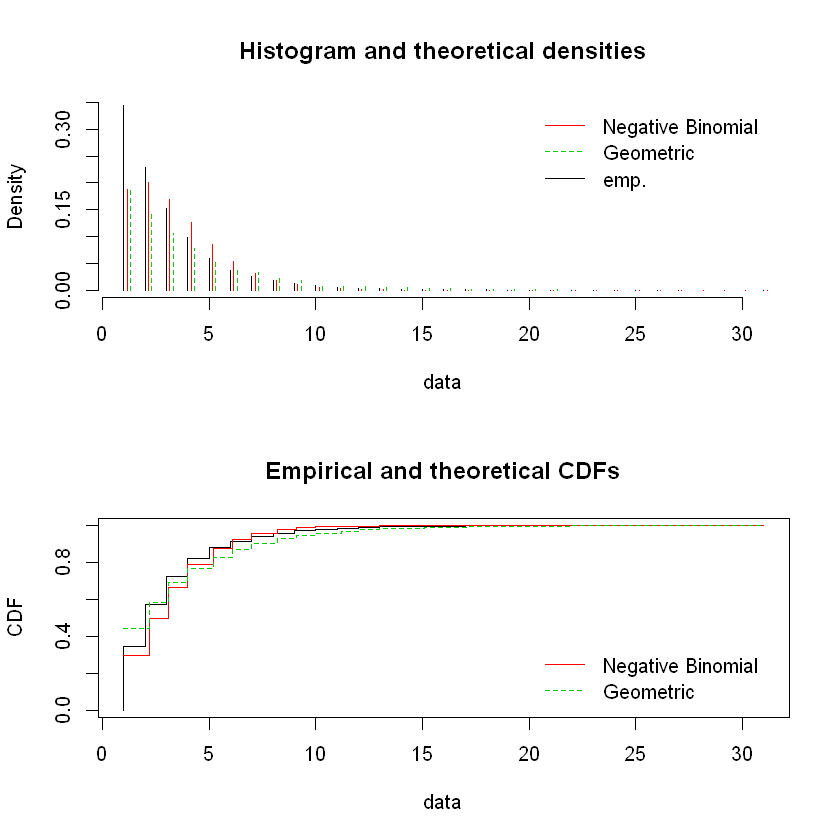

In [412]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dSep, LOfd_GE_dSep), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dSep, LOfd_GE_dSep), legendtext=plot.legend )

In [413]:
LOstatRes <- gofstat( list(LOfd_NB_dSep, LOfd_GE_dSep), fitnames=c("Negative Binomial", "Geometric") )

In [414]:
print( LOstatRes )

Chi-squared statistic:  123656.7 146734.8 
Degree of freedom of the Chi-squared distribution:  13 14 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     421544            362033.7168     545013.158
<= 2     279820            245223.2277     173540.676
<= 3     185826            208306.1194     129378.145
<= 4     119363            154057.6771      96454.069
<= 5      73085            103780.1034      71908.493
<= 6      45916             65349.4826      53609.261
<= 7      30313             39098.4040      39966.807
<= 8      22175             22471.8471      29796.077
<= 9      14554             12504.1762      22213.589
<= 10     10538              6774.5941      16560.687
<= 11      7277              3589.1761      12346.333
<= 12      4777              1865.6903       9204.445
<= 13      4255               954.0352       6862.103
<= 14      2732               480.9414       5115.839
<= 16      2761               357.3093    

In [415]:
LOfdNB_dSep_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [416]:
LOfdNB_dSep_p = LOfdNB_dSep_size / (LOfdNB_dSep_size + LOfdNB_dSep_mu)
cat("LOCA prob: ", LOfdNB_dSep_p)

LOCA prob:  0.5900714

In [417]:
# add to our tracking dataframe
LOMonDistDF[9, ] <- list( 9, dLOSepMean, dLOSepBNr, LOfdNB_dSep_p, LOfdNB_dSep_mu, LOfdNB_dSep_size,
                          LOfdNB_dSep_pvalue )

In [418]:
LOgf_dSep <- goodfit( dLOSep$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dSep_size, prob=LOfdNB_dSep_p) )

In [419]:
summary( LOgf_dSep )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          473915.3 31        0
Likelihood Ratio 463521.2 27        0


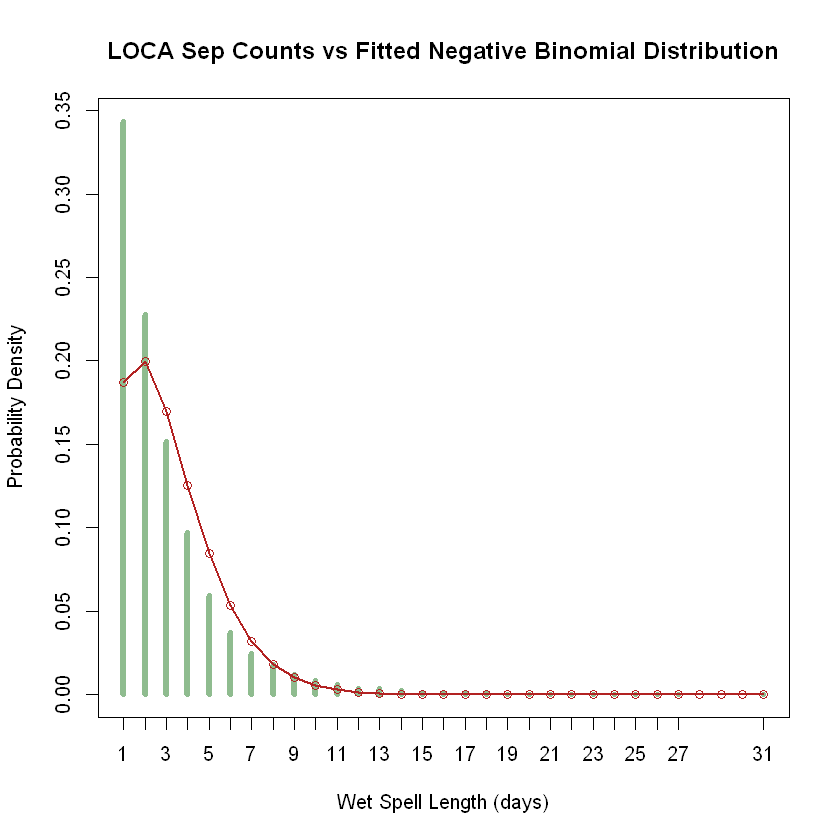

In [420]:
maxP <- max(dLOSep$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dSep_size, mu=LOfdNB_dSep_mu )
ttab <- table( dLOSep$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Sep Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

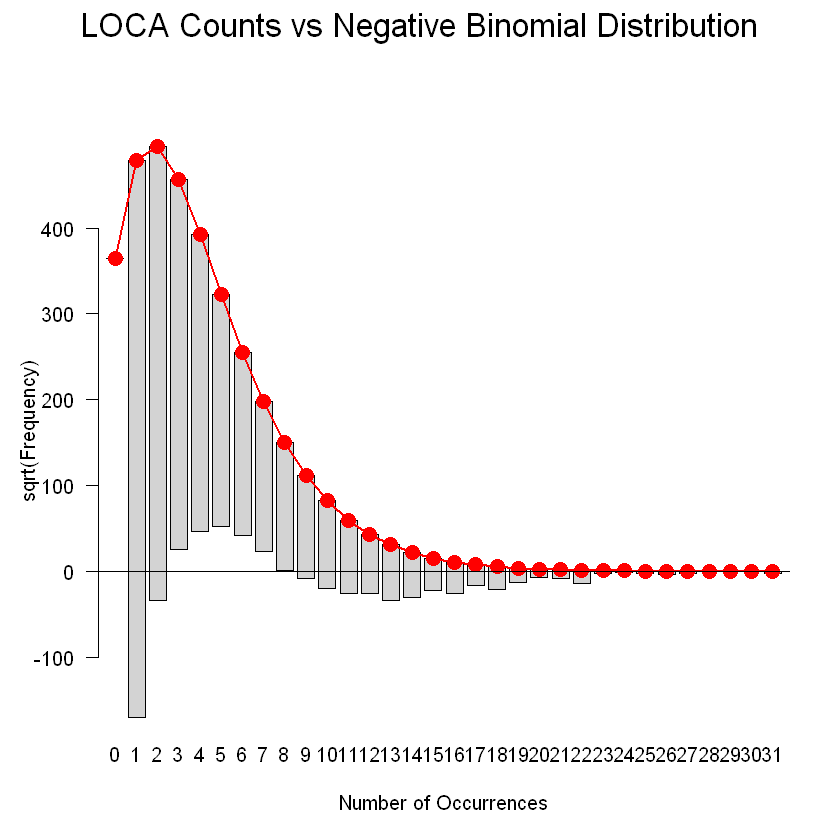

In [421]:
plot( LOgf_dSep, main="LOCA Counts vs Negative Binomial Distribution" )

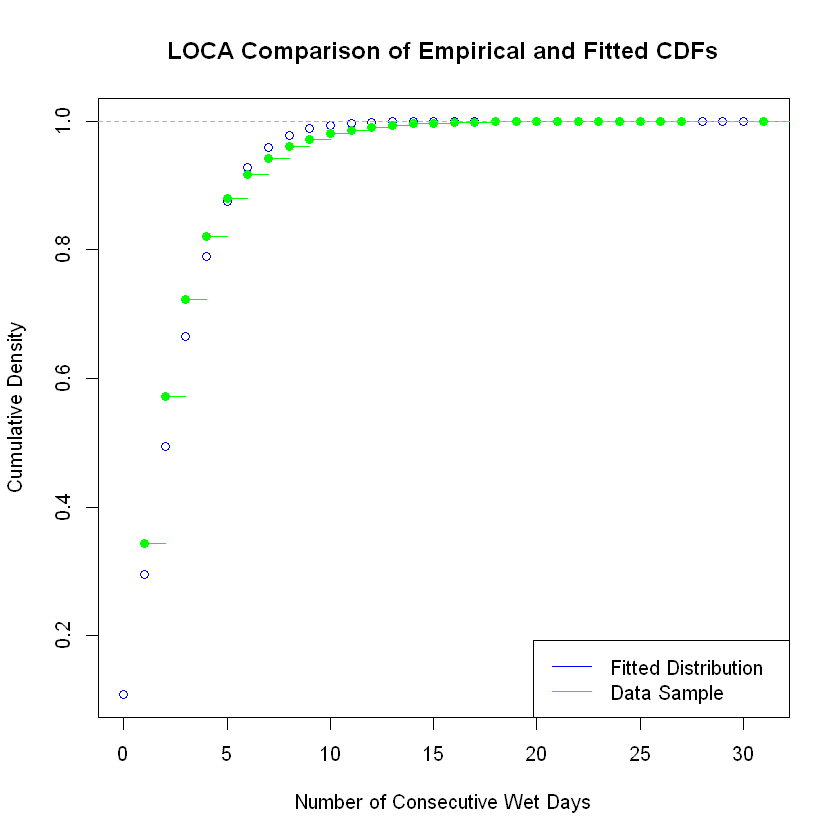

In [422]:
x <- seq(0,dLOSepMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dSep_mu, size=LOfdNB_dSep_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOSep$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

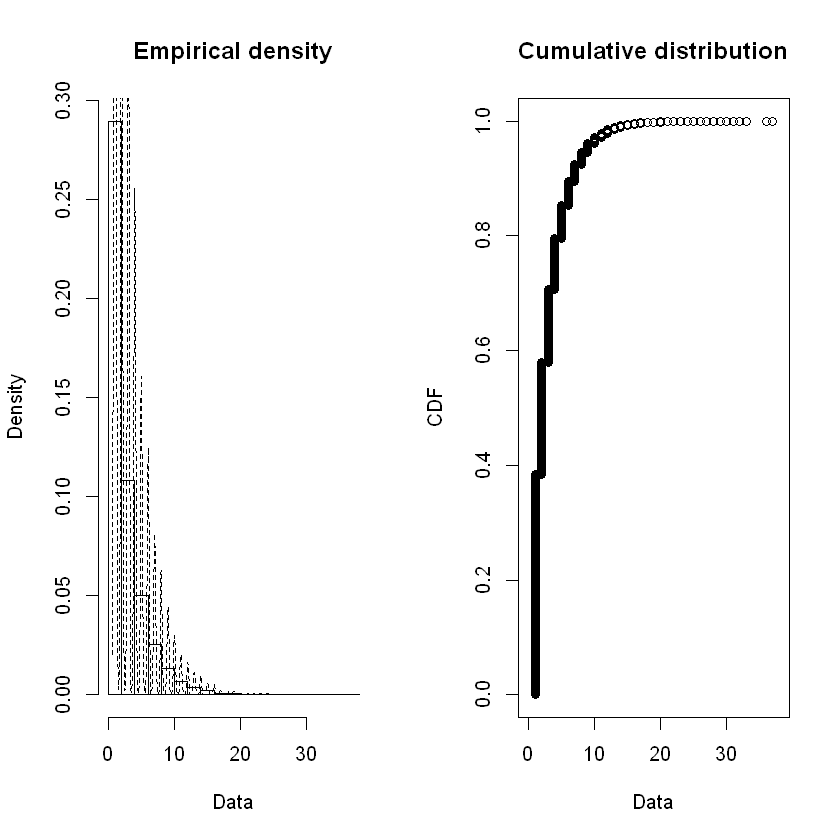

In [423]:
plotdist( dBCSep$Wet_Count, histo=TRUE, demp=TRUE )

In [424]:
BCfd_NB_dSep <- fitdist( dBCSep$Wet_Count, "nbinom" )
BCfd_GE_dSep <- fitdist( dBCSep$Wet_Count, "geom" )

In [425]:
summary( BCfd_NB_dSep )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 2.973783 0.008656890
mu   3.055099 0.002778436
Loglikelihood:  -1725736   AIC:  3451477   BIC:  3451500 
Correlation matrix:
             size           mu
size 1.0000000000 0.0001635968
mu   0.0001635968 1.0000000000


In [426]:
BCfdNB_dSep_size <- BCfd_NB_dSep$estimate[["size"]]
BCfdNB_dSep_mu <- BCfd_NB_dSep$estimate[["mu"]]
cat("BCCA Sep size: ", BCfdNB_dSep_size, "\n", "BCCA Sep mu: ", BCfdNB_dSep_mu, "\n")

BCCA Sep size:  2.973783 
 BCCA Sep mu:  3.055099 


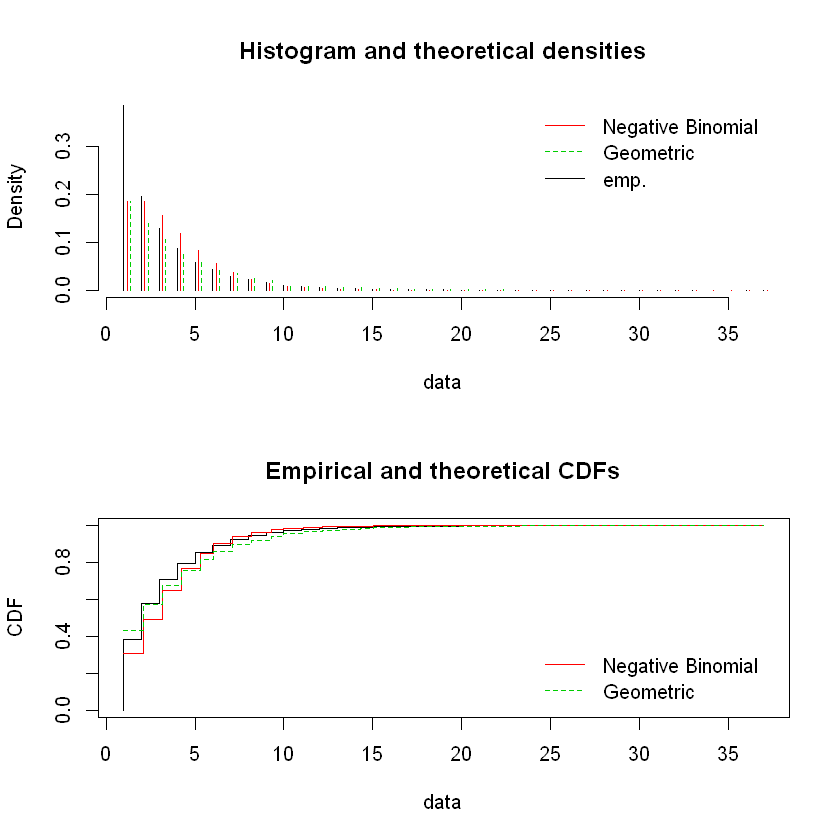

In [427]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dSep, BCfd_GE_dSep), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dSep, BCfd_GE_dSep), legendtext=plot.legend )

In [428]:
BCstatRes <- gofstat( list(BCfd_NB_dSep, BCfd_GE_dSep), fitnames=c("Negative Binomial", "Geometric") )

In [429]:
print(BCstatRes)

Chi-squared statistic:  71980.37 34032.46 
Degree of freedom of the Chi-squared distribution:  13 14 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     308308            245864.0979     346845.698
<= 2     156273            148802.5973     112284.730
<= 3     102866            125015.7127      84597.071
<= 4      70352             94611.2036      63736.756
<= 5      46284             66869.7210      48020.269
<= 6      33869             45033.0326      36179.222
<= 7      23348             29254.8072      27257.991
<= 8      17508             18482.2863      20536.597
<= 9      12581             11419.7890      15472.593
<= 10      8661              6929.1185      11657.294
<= 11      5815              4141.3359       8782.787
<= 12      4584              2443.7779       6617.089
<= 13      3199              1426.3905       4985.419
<= 14      2560               824.7204       3756.092
<= 16      3108               742.1242    

In [430]:
BCfdNB_dSep_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [431]:
BCfdNB_dSep_p = BCfdNB_dSep_size / (BCfdNB_dSep_size + BCfdNB_dSep_mu)
cat("BCCA prob: ", BCfdNB_dSep_p)

BCCA prob:  0.4932561

In [432]:
# add to our tracking dataframe
BCMonDistDF[9, ] <- list( 9, dBCSepMean, dBCSepBNr, BCfdNB_dSep_p, BCfdNB_dSep_mu, BCfdNB_dSep_size,
                          BCfdNB_dSep_pvalue )

In [433]:
BCgf_dSep <- goodfit( dBCSep$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dSep_size, prob=BCfdNB_dSep_p) )

In [434]:
summary( BCgf_dSep )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          411480.9 37        0
Likelihood Ratio 371522.9 34        0


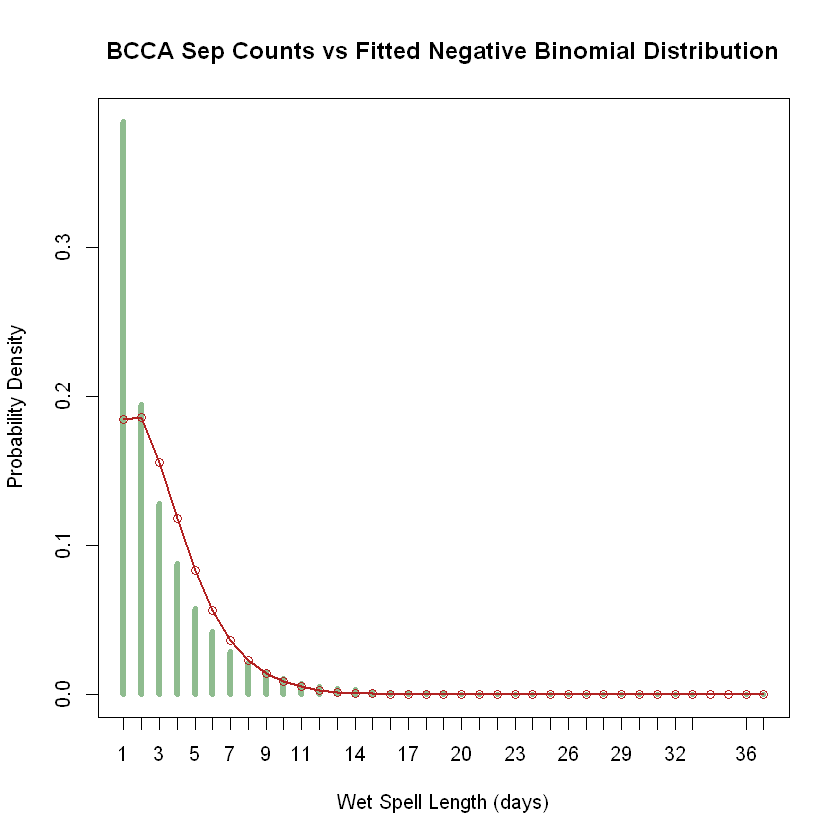

In [435]:
maxP <- max(dBCSep$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dSep_size, mu=BCfdNB_dSep_mu )
ttab <- table( dBCSep$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Sep Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

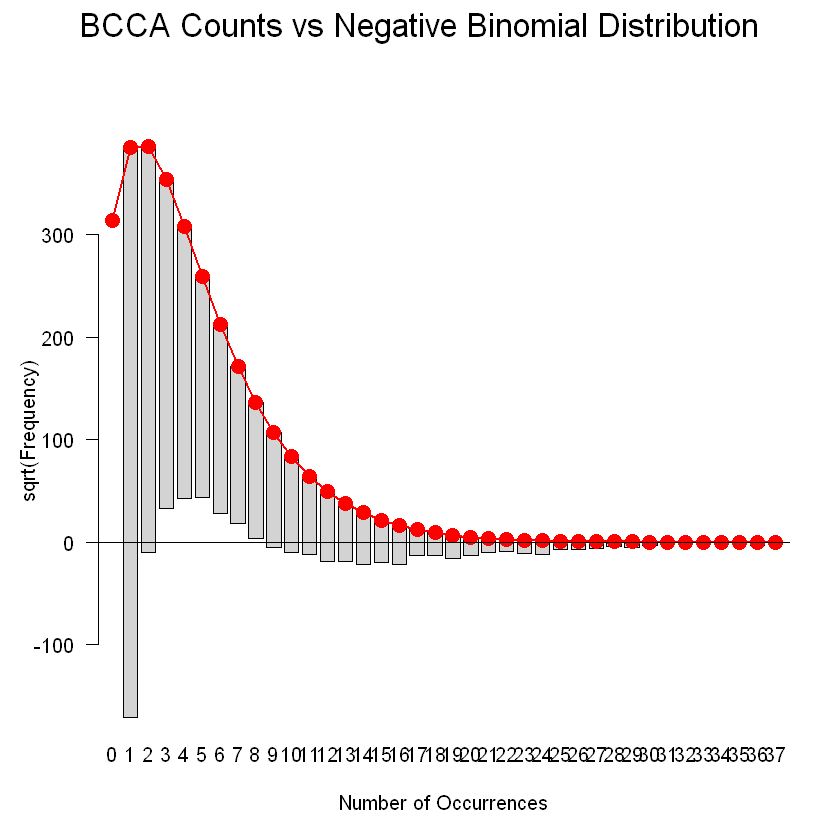

In [436]:
plot( BCgf_dSep, main="BCCA Counts vs Negative Binomial Distribution" )

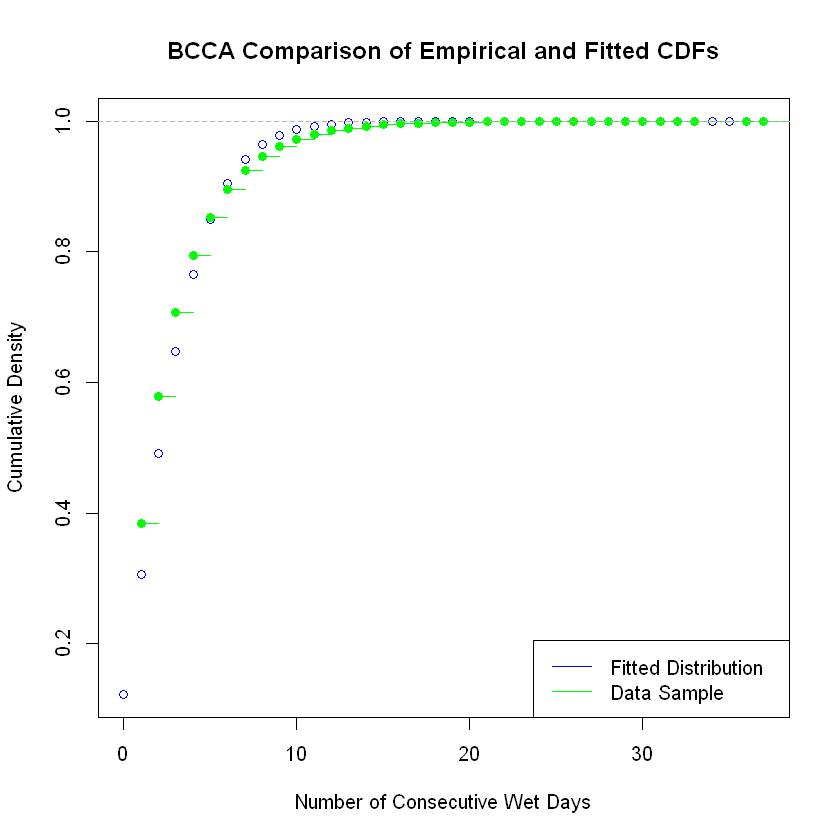

In [437]:
x <- seq(0,dBCSepMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dSep_mu, size=BCfdNB_dSep_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCSep$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

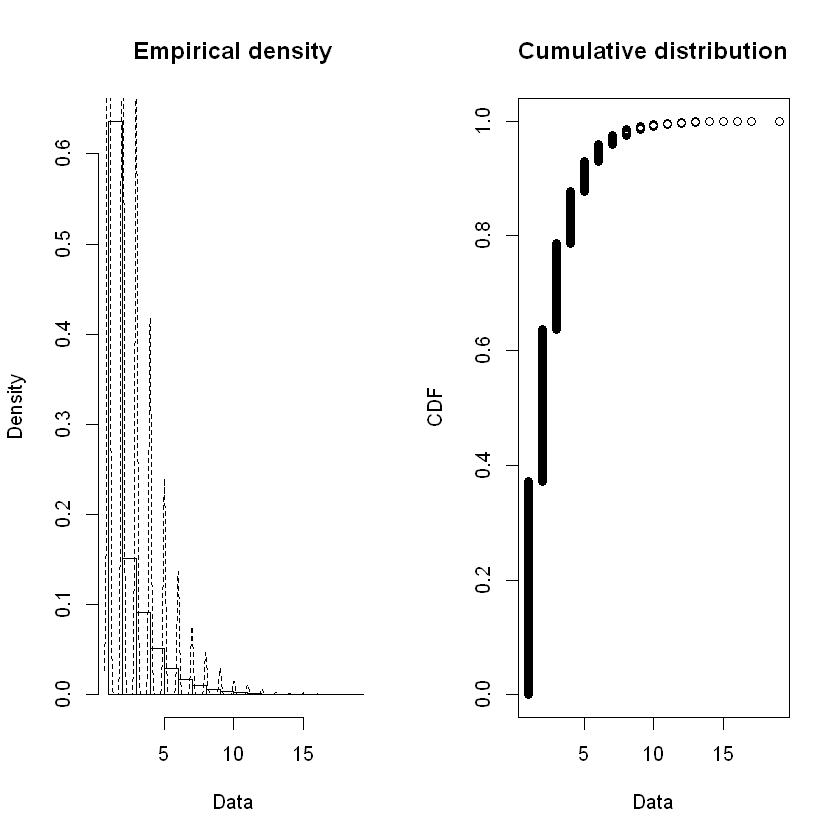

In [438]:
plotdist( dLOOct$Wet_Count, histo=TRUE, demp=TRUE )

In [439]:
LOfd_NB_dOct <- fitdist( dLOOct$Wet_Count, "nbinom" )
LOfd_GE_dOct <- fitdist( dLOOct$Wet_Count, "geom" )

In [440]:
LOfdNB_dOct_size <- LOfd_NB_dOct$estimate[["size"]]
LOfdNB_dOct_mu <- LOfd_NB_dOct$estimate[["mu"]]
cat("LOCA Oct size: ", LOfdNB_dOct_size, "\n", "LOCA Oct mu: ", LOfdNB_dOct_mu, "\n")

LOCA Oct size:  10.18268 
 LOCA Oct mu:  2.497329 


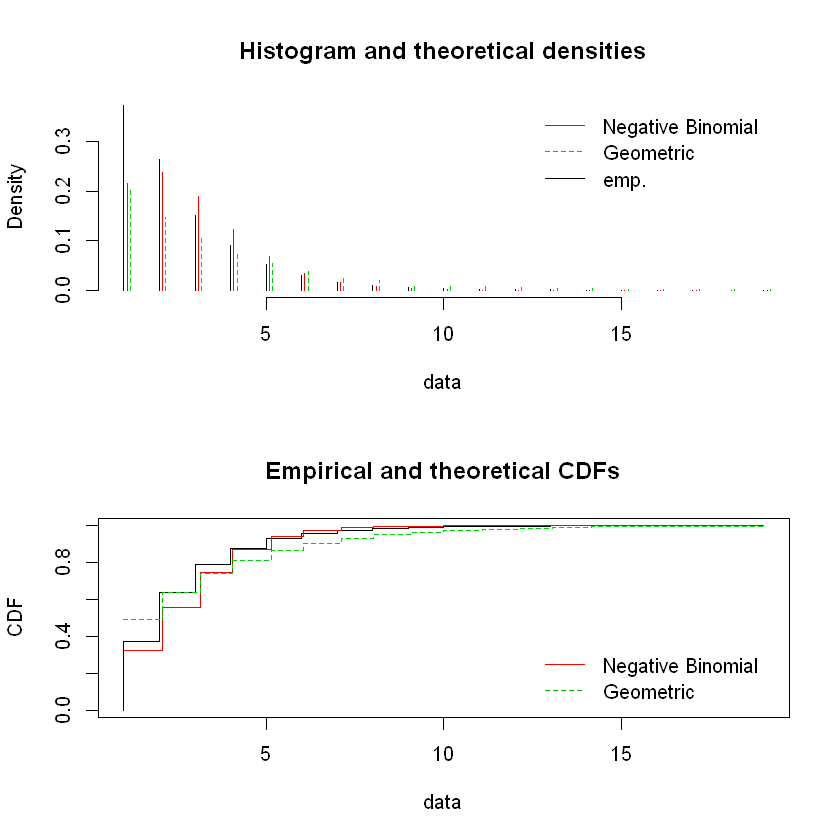

In [441]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dOct, LOfd_GE_dOct), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dOct, LOfd_GE_dOct), legendtext=plot.legend )

In [442]:
LOstatRes <- gofstat( list(LOfd_NB_dOct, LOfd_GE_dOct), fitnames=c("Negative Binomial", "Geometric") )

In [443]:
print( LOstatRes )

Chi-squared statistic:  111171.9 212445.8 
Degree of freedom of the Chi-squared distribution:  9 10 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     428830            371202.0885     564871.275
<= 2     304496            272764.0010     168039.528
<= 3     174282            218154.8497     119993.546
<= 4     104813            141600.5121      85684.906
<= 5      59139             79105.9870      61185.816
<= 6      33681             39424.1890      43691.524
<= 7      18959             17950.2870      31199.212
<= 8      11345              7593.2646      22278.711
<= 9       7160              3021.3437      15908.766
<= 10      3695              1141.4730      11360.120
<= 11      2783               412.4848       8112.027
> 11       3402               214.5196      20259.568

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           4283905   4824937
Bayesia

In [444]:
LOfdNB_dOct_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [445]:
LOfdNB_dOct_p = LOfdNB_dOct_size / (LOfdNB_dOct_size + LOfdNB_dOct_mu)
cat("LOCA prob: ", LOfdNB_dOct_p)

LOCA prob:  0.8030499

In [446]:
# add to our tracking dataframe
LOMonDistDF[10, ] <- list( 10, dLOOctMean, dLOOctBNr, LOfdNB_dOct_p, LOfdNB_dOct_mu, LOfdNB_dOct_size,
                          LOfdNB_dOct_pvalue )

In [447]:
LOgf_dOct <- goodfit( dLOOct$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dOct_size, prob=LOfdNB_dOct_p) )

In [448]:
summary( LOgf_dOct )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          467064.5 19        0
Likelihood Ratio 415618.7 17        0


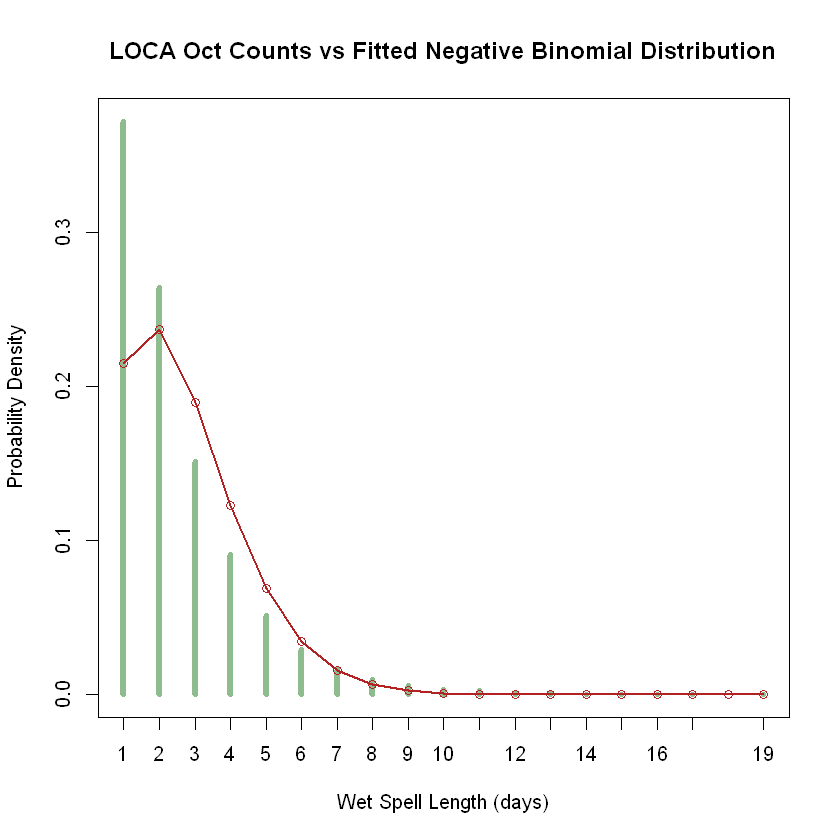

In [449]:
maxP <- max(dLOOct$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dOct_size, mu=LOfdNB_dOct_mu )
ttab <- table( dLOOct$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Oct Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

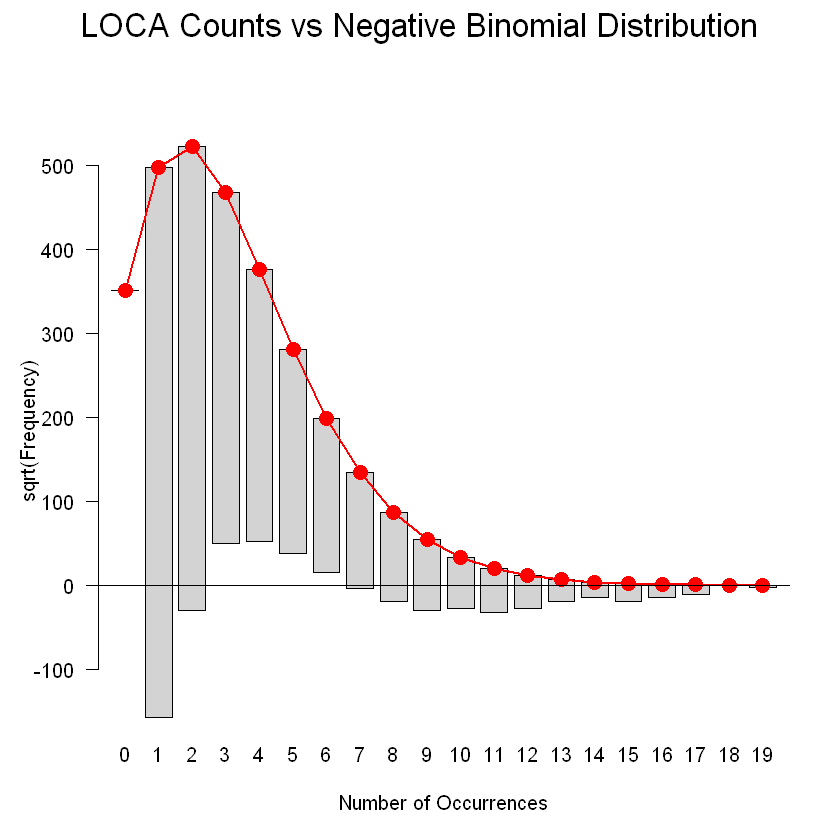

In [450]:
plot( LOgf_dOct, main="LOCA Counts vs Negative Binomial Distribution" )

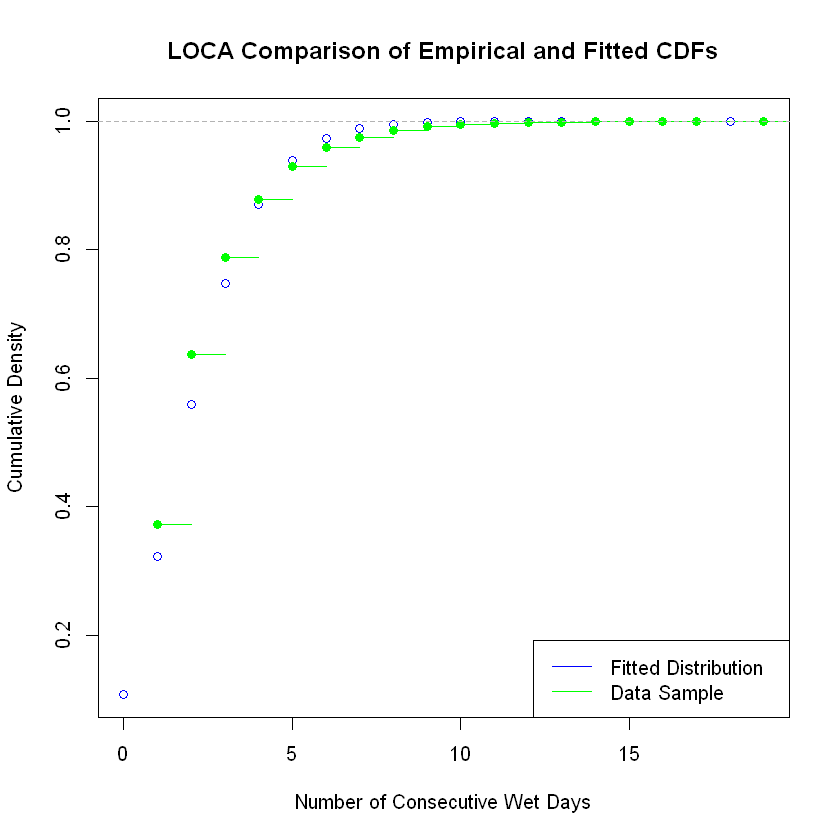

In [451]:
x <- seq(0,dLOOctMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dOct_mu, size=LOfdNB_dOct_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOOct$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

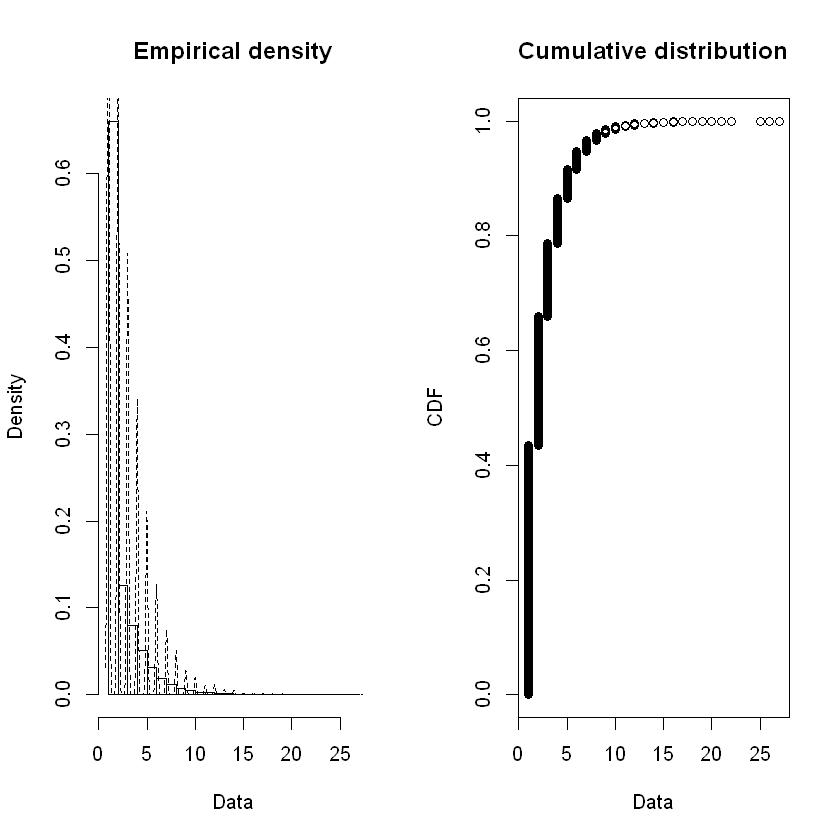

In [452]:
plotdist( dBCOct$Wet_Count, histo=TRUE, demp=TRUE )

In [453]:
BCfd_NB_dOct <- fitdist( dBCOct$Wet_Count, "nbinom" )
BCfd_GE_dOct <- fitdist( dBCOct$Wet_Count, "geom" )

In [454]:
summary( BCfd_NB_dOct )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 5.334425 0.024791975
mu   2.488041 0.002243362
Loglikelihood:  -1387685   AIC:  2775375   BIC:  2775398 
Correlation matrix:
             size           mu
size 1.0000000000 0.0001670298
mu   0.0001670298 1.0000000000


In [455]:
BCfdNB_dOct_size <- BCfd_NB_dOct$estimate[["size"]]
BCfdNB_dOct_mu <- BCfd_NB_dOct$estimate[["mu"]]
cat("BCCA Oct size: ", BCfdNB_dOct_size, "\n", "BCCA Oct mu: ", BCfdNB_dOct_mu, "\n")

BCCA Oct size:  5.334425 
 BCCA Oct mu:  2.488041 


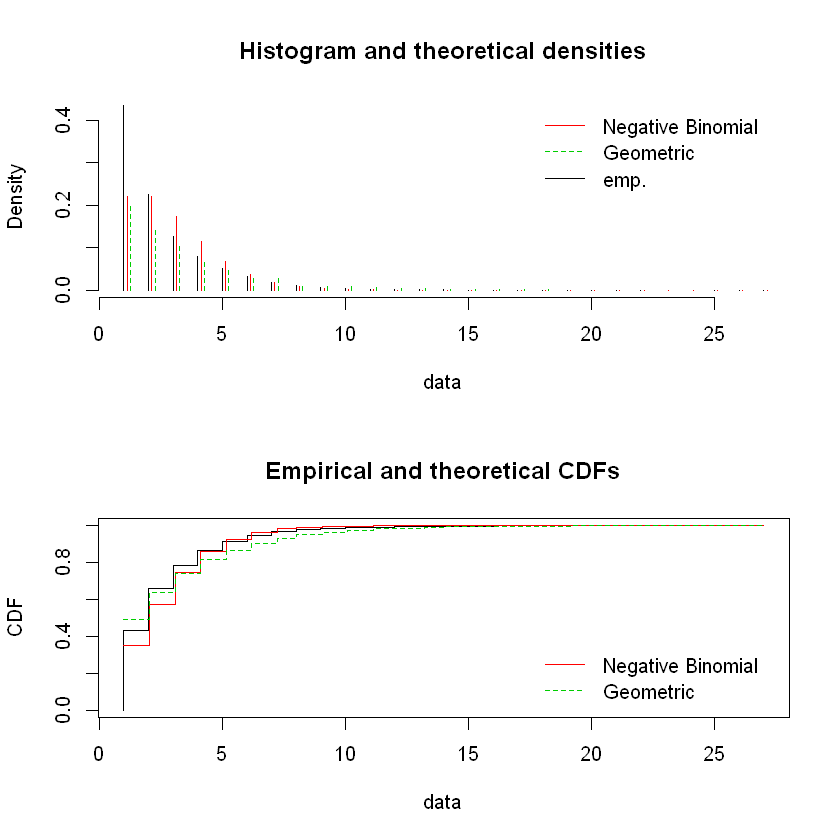

In [456]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dOct, BCfd_GE_dOct), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dOct, BCfd_GE_dOct), legendtext=plot.legend )

In [457]:
BCstatRes <- gofstat( list(BCfd_NB_dOct, BCfd_GE_dOct), fitnames=c("Negative Binomial", "Geometric") )

In [458]:
print(BCstatRes)

Chi-squared statistic:  151995.4 55825.1 
Degree of freedom of the Chi-squared distribution:  10 11 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     314767           253633.35285     356027.624
<= 2     163896           160756.48593     105735.464
<= 3      91160           125004.93830      75423.952
<= 4      57624            82843.16270      53801.934
<= 5      37145            49191.27578      38378.368
<= 6      22746            26948.64933      27376.322
<= 7      13472            13878.81241      19528.267
<= 8       8506             6806.04909      13930.039
<= 9       5035             3207.30832       9936.671
<= 10      3633             1462.29447       7088.095
<= 12      3654              929.08221       8662.802
<= 15      2144              188.97319       5717.038
> 15       1082               13.61541       3257.424

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Inf

In [459]:
BCfdNB_dOct_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [460]:
BCfdNB_dOct_p = BCfdNB_dOct_size / (BCfdNB_dOct_size + BCfdNB_dOct_mu)
cat("BCCA prob: ", BCfdNB_dOct_p)

BCCA prob:  0.6819365

In [461]:
# add to our tracking dataframe
BCMonDistDF[10, ] <- list( 10, dBCOctMean, dBCOctBNr, BCfdNB_dOct_p, BCfdNB_dOct_mu, BCfdNB_dOct_size,
                          BCfdNB_dOct_pvalue )

In [462]:
BCgf_dOct <- goodfit( dBCOct$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dOct_size, prob=BCfdNB_dOct_p) )

In [463]:
summary( BCgf_dOct )


	 Goodness-of-fit test for nbinomial distribution

                       X^2 df P(> X^2)
Pearson          3827990.9 27        0
Likelihood Ratio  352299.5 24        0


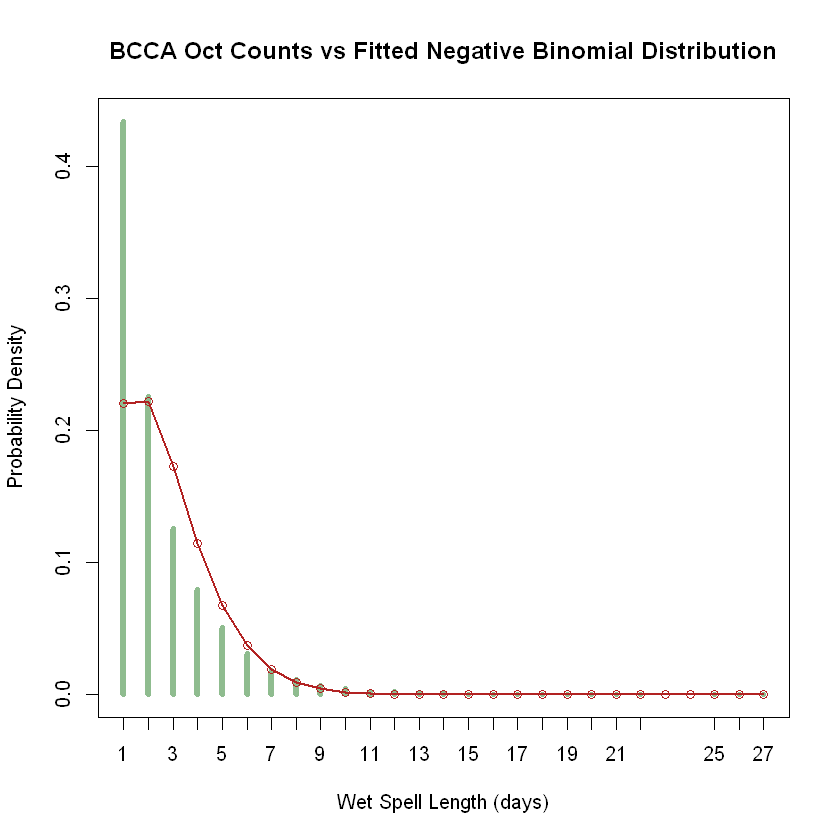

In [464]:
maxP <- max(dBCOct$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dOct_size, mu=BCfdNB_dOct_mu )
ttab <- table( dBCOct$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Oct Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

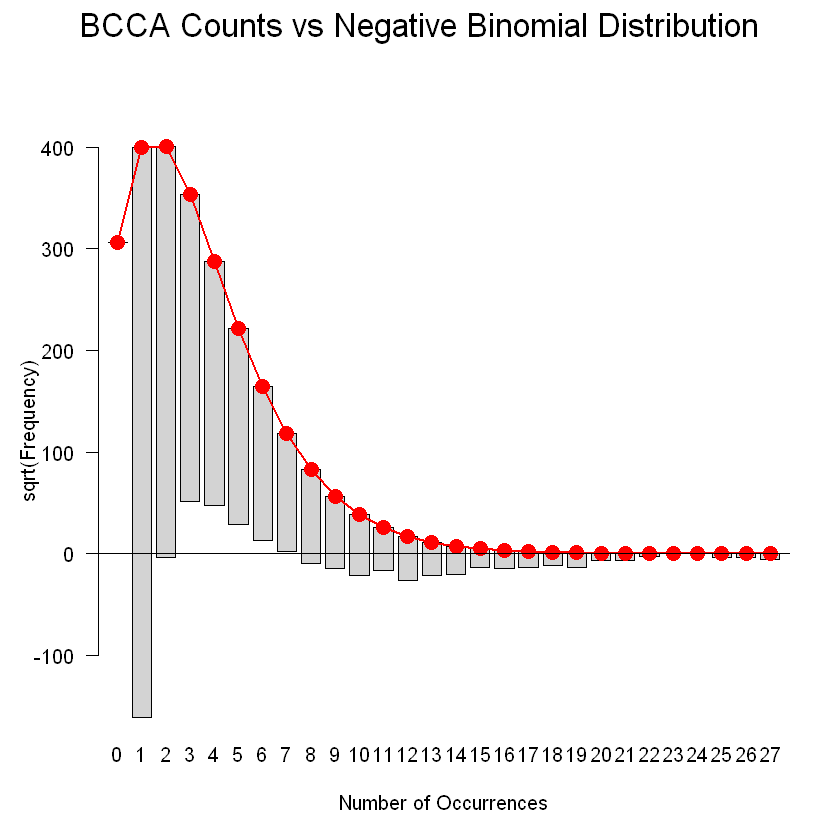

In [465]:
plot( BCgf_dOct, main="BCCA Counts vs Negative Binomial Distribution" )

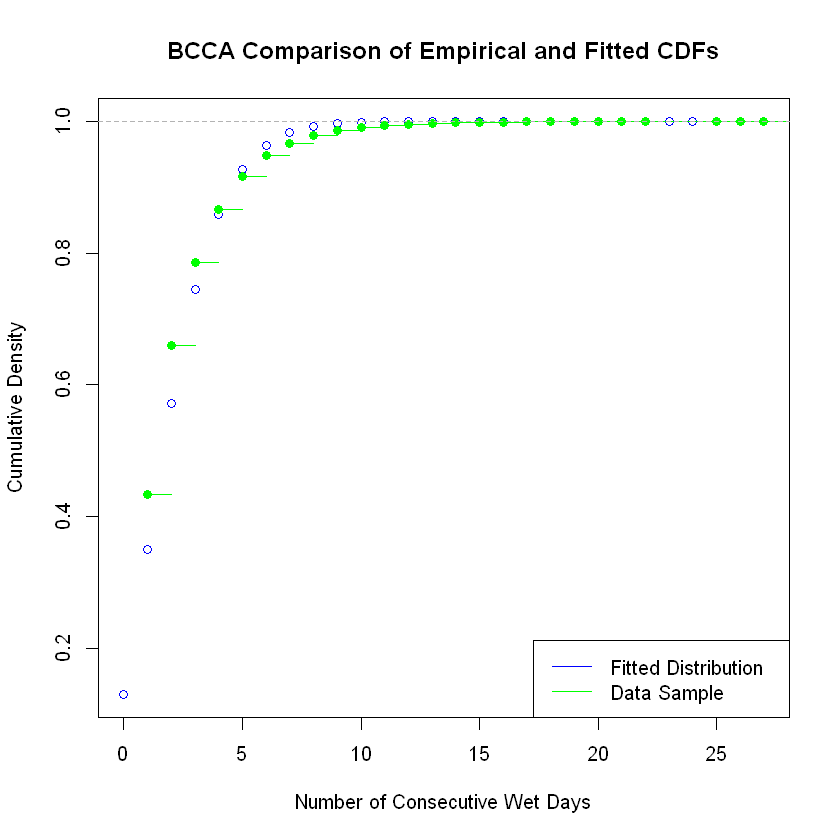

In [466]:
x <- seq(0,dBCOctMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dOct_mu, size=BCfdNB_dOct_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCOct$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

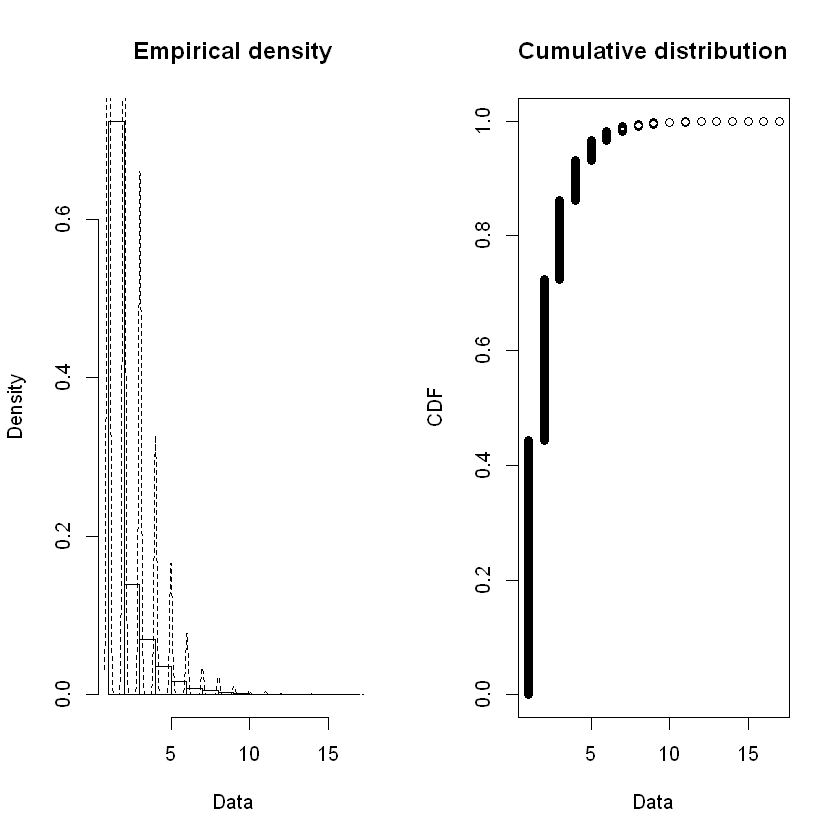

In [467]:
plotdist( dLONov$Wet_Count, histo=TRUE, demp=TRUE )

In [468]:
LOfd_NB_dNov <- fitdist( dLONov$Wet_Count, "nbinom" )
LOfd_GE_dNov <- fitdist( dLONov$Wet_Count, "geom" )

In [469]:
LOfdNB_dNov_size <- LOfd_NB_dNov$estimate[["size"]]
LOfdNB_dNov_mu <- LOfd_NB_dNov$estimate[["mu"]]
cat("LOCA Nov size: ", LOfdNB_dNov_size, "\n", "LOCA Nov mu: ", LOfdNB_dNov_mu, "\n")

LOCA Nov size:  1049.268 
 LOCA Nov mu:  2.108293 


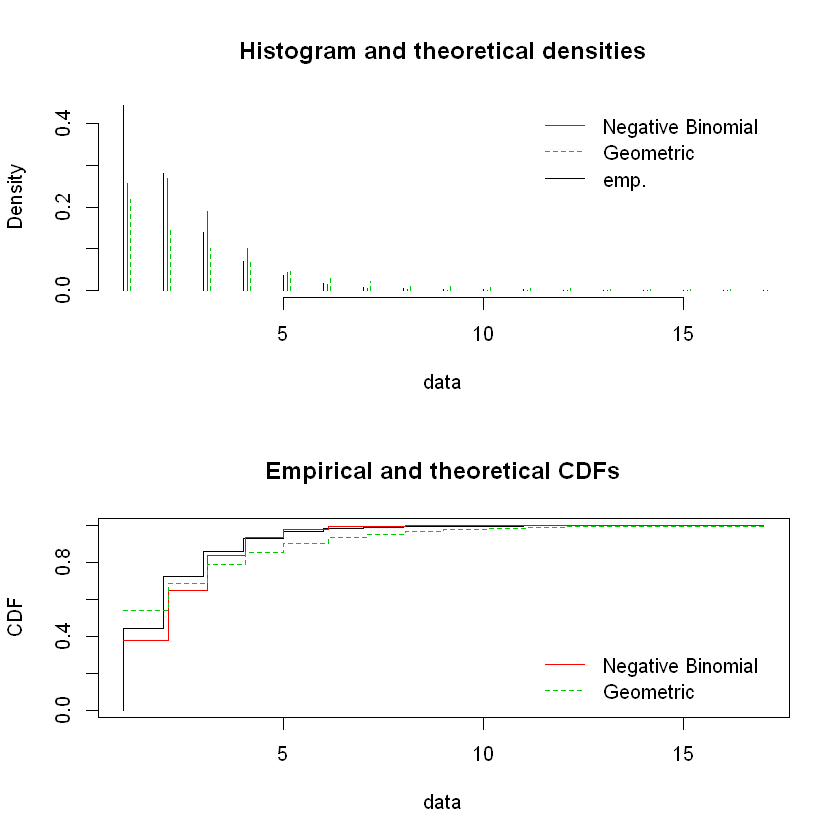

In [470]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dNov, LOfd_GE_dNov), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dNov, LOfd_GE_dNov), legendtext=plot.legend )

In [471]:
LOstatRes <- gofstat( list(LOfd_NB_dNov, LOfd_GE_dNov), fitnames=c("Negative Binomial", "Geometric") )

In [472]:
print( LOstatRes )

Chi-squared statistic:  162166.7 224268.1 
Degree of freedom of the Chi-squared distribution:  7 8 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    505984           430700.70546      615590.77
<= 2    319416           307430.37252      168749.43
<= 3    158004           216028.80907      114458.80
<= 4     78844           113959.55735       77634.73
<= 5     39981            48138.47736       52657.83
<= 6     18537            16961.52254       35716.58
<= 7      8298             5127.45990       24225.72
<= 8      5627             1357.56027       16431.74
<= 9      2605              319.79702       11145.27
> 9       2812               83.73852       23497.13

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           3789303   4452101
Bayesian Information Criterion           3789327   4452113


In [473]:
LOfdNB_dNov_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [474]:
LOfdNB_dNov_p = LOfdNB_dNov_size / (LOfdNB_dNov_size + LOfdNB_dNov_mu)
cat("LOCA prob: ", LOfdNB_dNov_p)

LOCA prob:  0.9979947

In [475]:
# add to our tracking dataframe
LOMonDistDF[11, ] <- list( 11, dLONovMean, dLONovBNr, LOfdNB_dNov_p, LOfdNB_dNov_mu, LOfdNB_dNov_size,
                          LOfdNB_dNov_pvalue )

In [476]:
LOgf_dNov <- goodfit( dLONov$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dNov_size, prob=LOfdNB_dNov_p) )

In [477]:
summary( LOgf_dNov )


	 Goodness-of-fit test for nbinomial distribution

                        X^2 df P(> X^2)
Pearson          54383674.9 17        0
Likelihood Ratio   472991.9 16        0


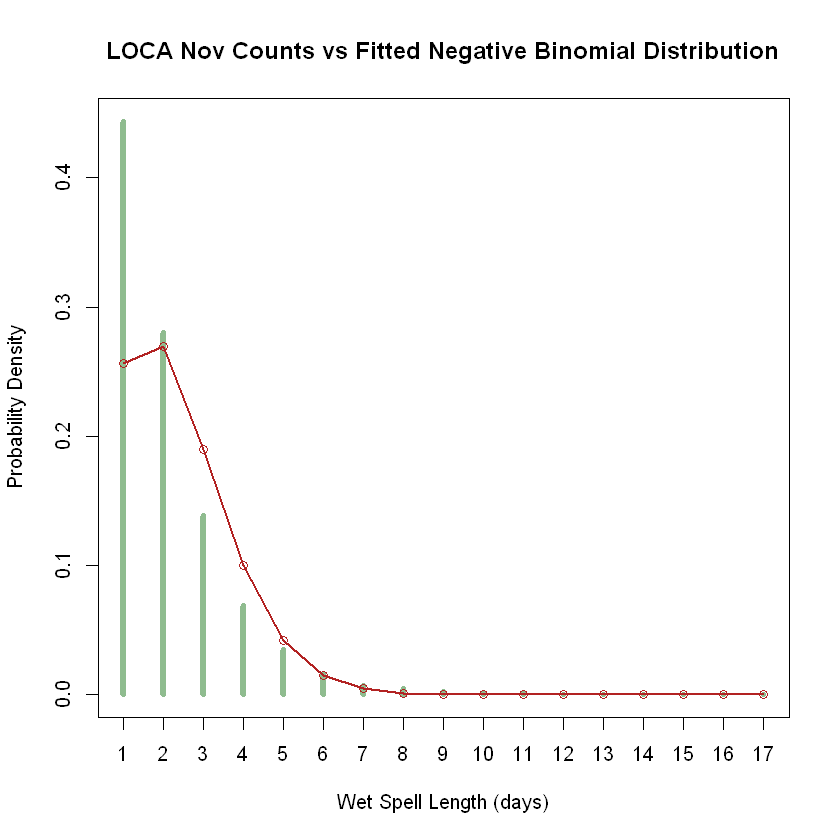

In [478]:
maxP <- max(dLONov$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dNov_size, mu=LOfdNB_dNov_mu )
ttab <- table( dLONov$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Nov Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

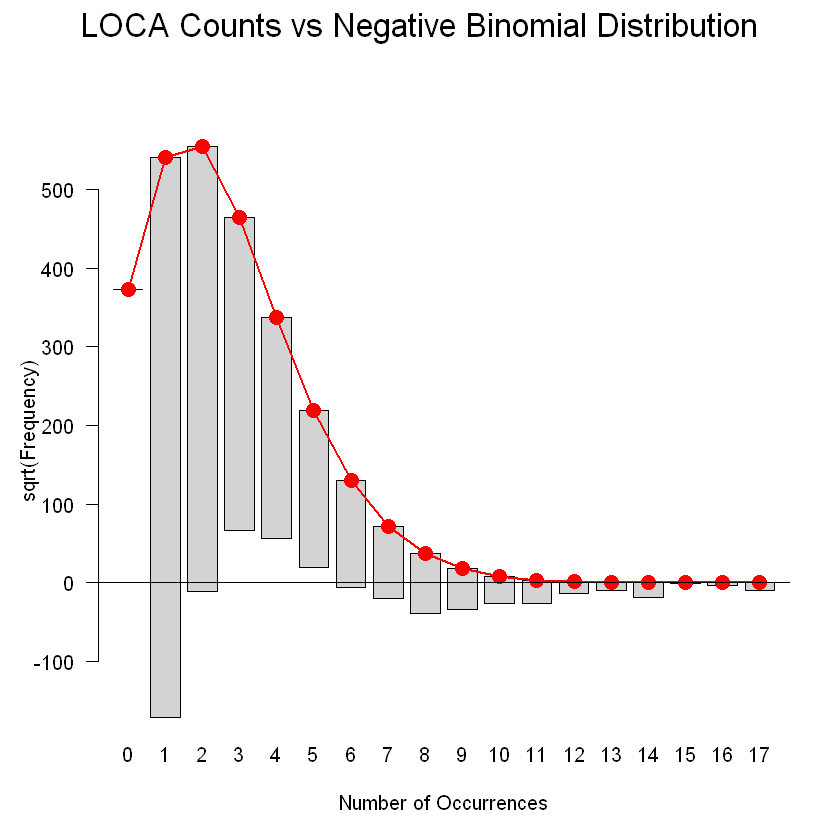

In [479]:
plot( LOgf_dNov, main="LOCA Counts vs Negative Binomial Distribution" )

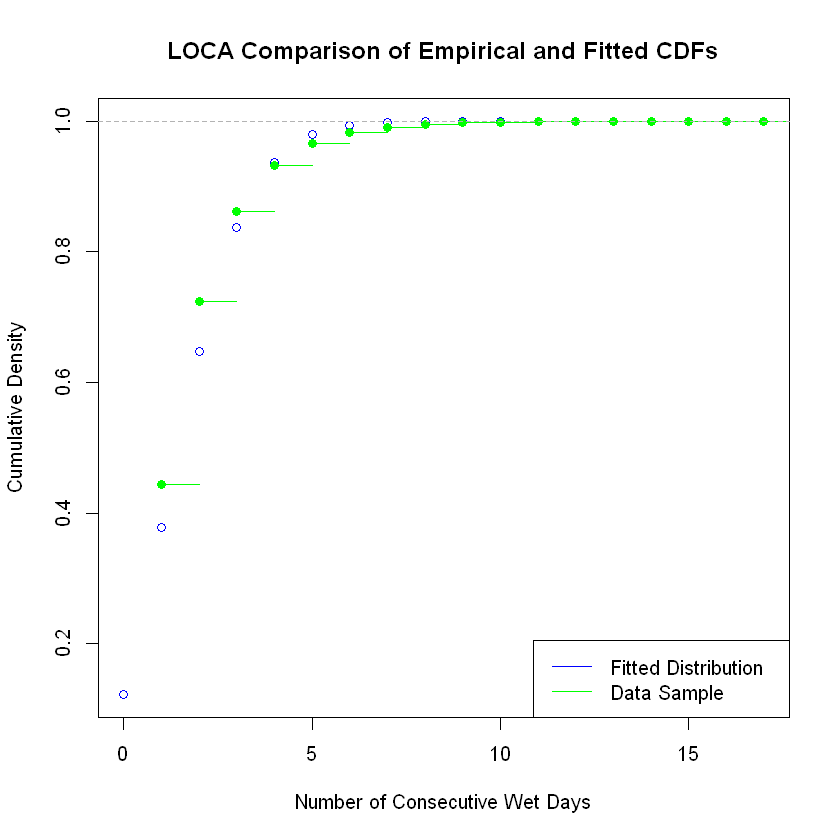

In [480]:
x <- seq(0,dLONovMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dNov_mu, size=LOfdNB_dNov_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLONov$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

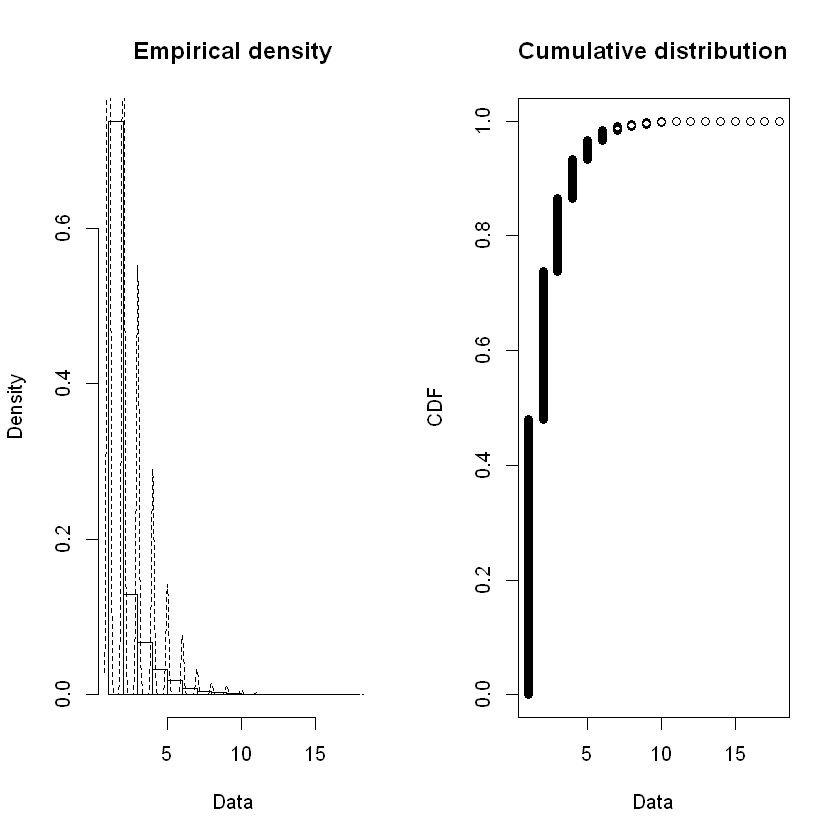

In [481]:
plotdist( dBCNov$Wet_Count, histo=TRUE, demp=TRUE )

In [482]:
BCfd_NB_dNov <- fitdist( dBCNov$Wet_Count, "nbinom" )
BCfd_GE_dNov <- fitdist( dBCNov$Wet_Count, "geom" )

In [483]:
summary( BCfd_NB_dNov )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
       estimate   Std. Error
size 130.645549 12.671208553
mu     2.051531  0.001756098
Loglikelihood:  -1116297   AIC:  2232598   BIC:  2232621 
Correlation matrix:
              size            mu
size  1.000000e+00 -8.289474e-05
mu   -8.289474e-05  1.000000e+00


In [484]:
BCfdNB_dNov_size <- BCfd_NB_dNov$estimate[["size"]]
BCfdNB_dNov_mu <- BCfd_NB_dNov$estimate[["mu"]]
cat("BCCA Nov size: ", BCfdNB_dNov_size, "\n", "BCCA Nov mu: ", BCfdNB_dNov_mu, "\n")

BCCA Nov size:  130.6455 
 BCCA Nov mu:  2.051531 


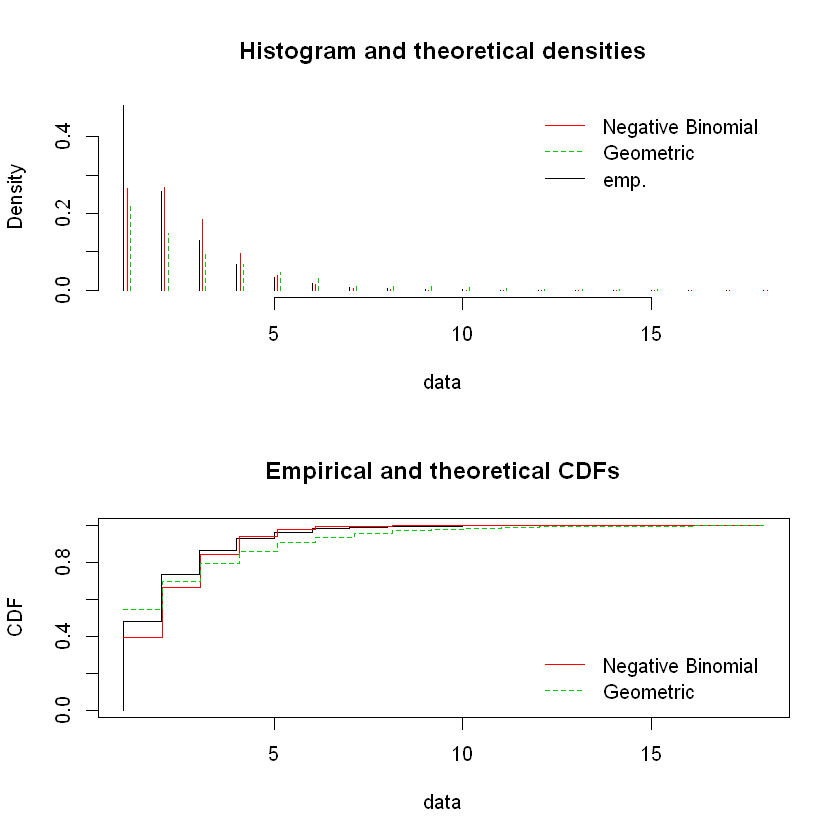

In [485]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dNov, BCfd_GE_dNov), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dNov, BCfd_GE_dNov), legendtext=plot.legend )

In [486]:
BCstatRes <- gofstat( list(BCfd_NB_dNov, BCfd_GE_dNov), fitnames=c("Negative Binomial", "Geometric") )

In [487]:
print(BCstatRes)

Chi-squared statistic:  107521.4 94926.99 
Degree of freedom of the Chi-squared distribution:  7 8 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    324515           266509.66499     370331.191
<= 2    174011           181399.90611     100087.922
<= 3     86696           124001.00912      67287.107
<= 4     45427            64052.55561      45235.776
<= 5     22241            26667.06343      30411.107
<= 6     11921             9320.65055      20444.779
<= 7      5077             2812.93962      13744.616
<= 8      2345              748.25449       9240.230
<= 9      1820              178.20894       6212.022
> 9       1685               47.74713      12743.250

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2232598   2608568
Bayesian Information Criterion           2232621   2608579


In [488]:
BCfdNB_dNov_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [489]:
BCfdNB_dNov_p = BCfdNB_dNov_size / (BCfdNB_dNov_size + BCfdNB_dNov_mu)
cat("BCCA prob: ", BCfdNB_dNov_p)

BCCA prob:  0.9845397

In [490]:
# add to our tracking dataframe
BCMonDistDF[11, ] <- list( 11, dBCNovMean, dBCNovBNr, BCfdNB_dNov_p, BCfdNB_dNov_mu, BCfdNB_dNov_size,
                          BCfdNB_dNov_pvalue )

In [491]:
BCgf_dNov <- goodfit( dBCNov$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dNov_size, prob=BCfdNB_dNov_p) )

In [492]:
summary( BCgf_dNov )


	 Goodness-of-fit test for nbinomial distribution

                        X^2 df P(> X^2)
Pearson          83249860.3 18        0
Likelihood Ratio   312716.4 17        0


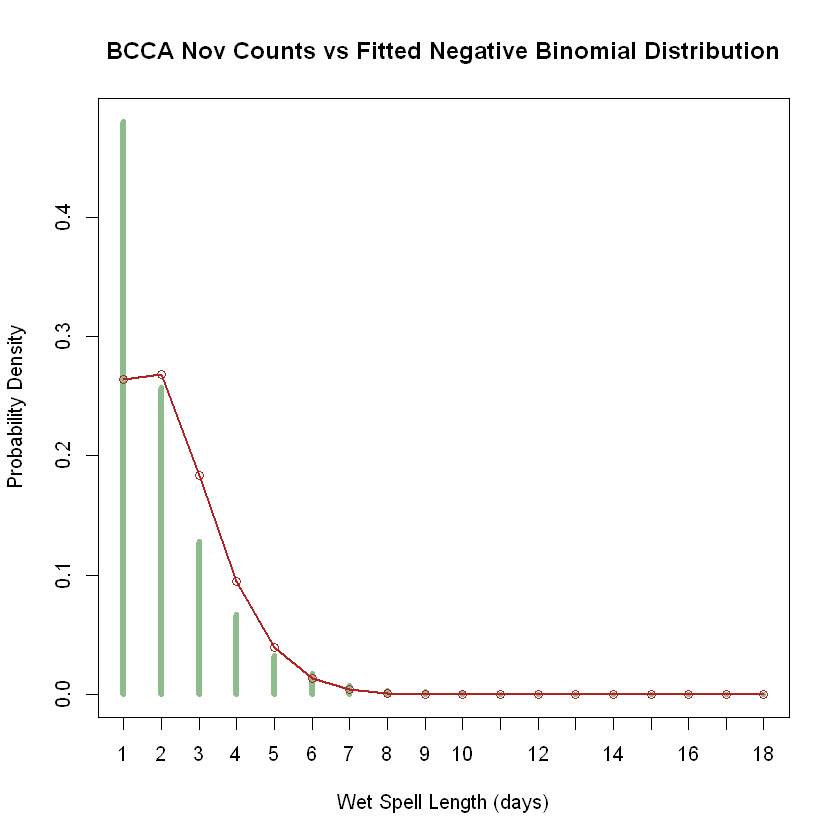

In [493]:
maxP <- max(dBCNov$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dNov_size, mu=BCfdNB_dNov_mu )
ttab <- table( dBCNov$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Nov Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

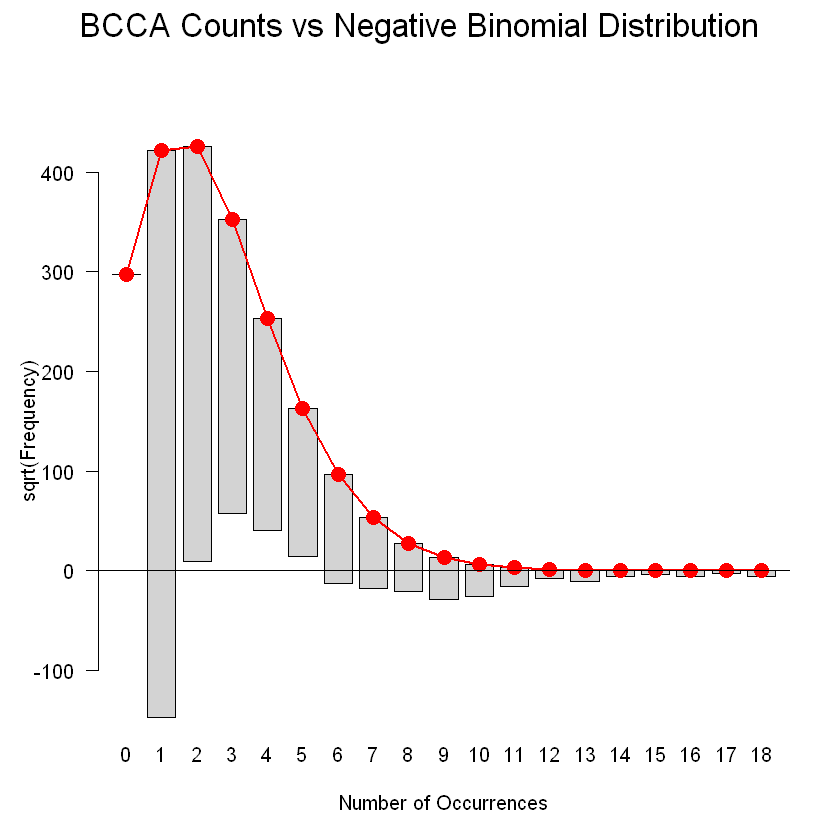

In [494]:
plot( BCgf_dNov, main="BCCA Counts vs Negative Binomial Distribution" )

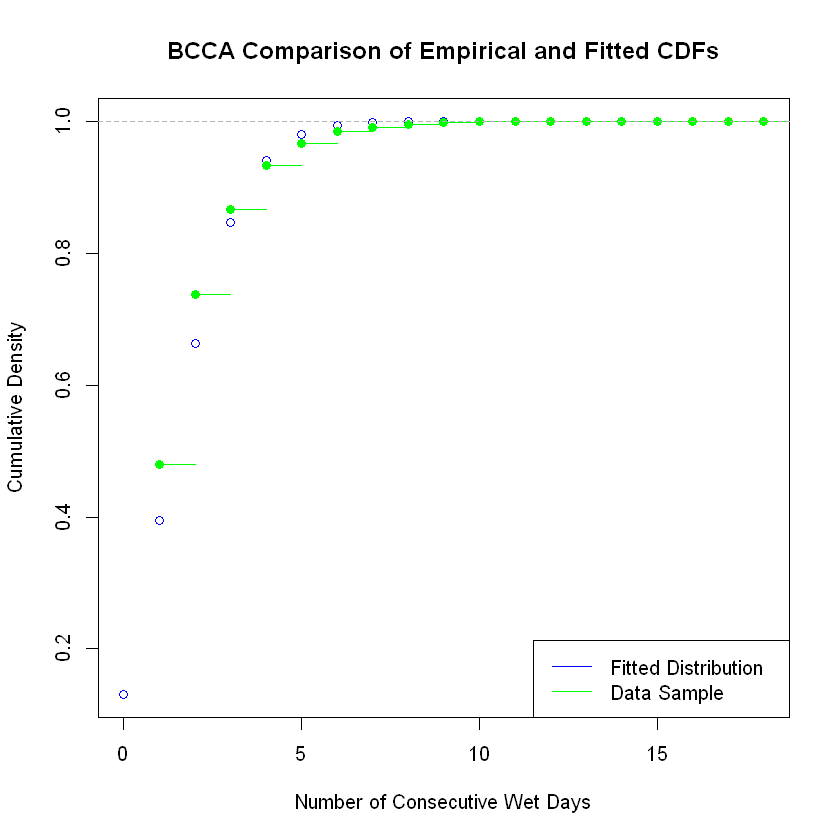

In [495]:
x <- seq(0,dBCNovMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dNov_mu, size=BCfdNB_dNov_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCNov$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

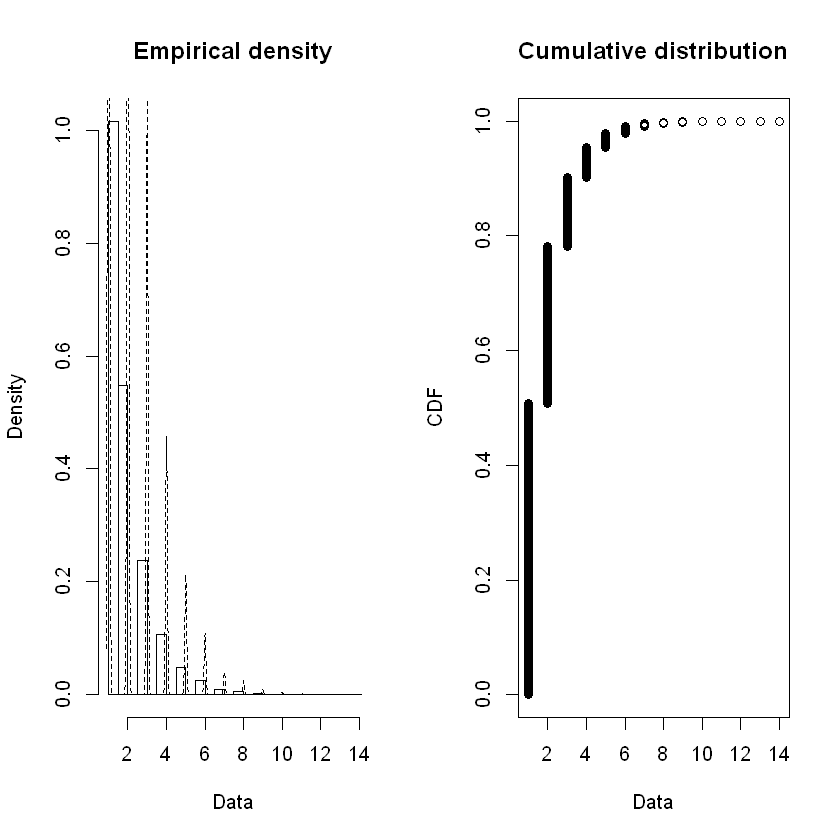

In [496]:
plotdist( dLODec$Wet_Count, histo=TRUE, demp=TRUE )

In [497]:
LOfd_NB_dDec <- fitdist( dLODec$Wet_Count, "nbinom" )
LOfd_GE_dDec <- fitdist( dLODec$Wet_Count, "geom" )

In [498]:
LOfdNB_dDec_size <- LOfd_NB_dDec$estimate[["size"]]
LOfdNB_dDec_mu <- LOfd_NB_dDec$estimate[["mu"]]
cat("LOCA Dec size: ", LOfdNB_dDec_size, "\n", "LOCA Dec mu: ", LOfdNB_dDec_mu, "\n")

LOCA Dec size:  433182.3 
 LOCA Dec mu:  1.893253 


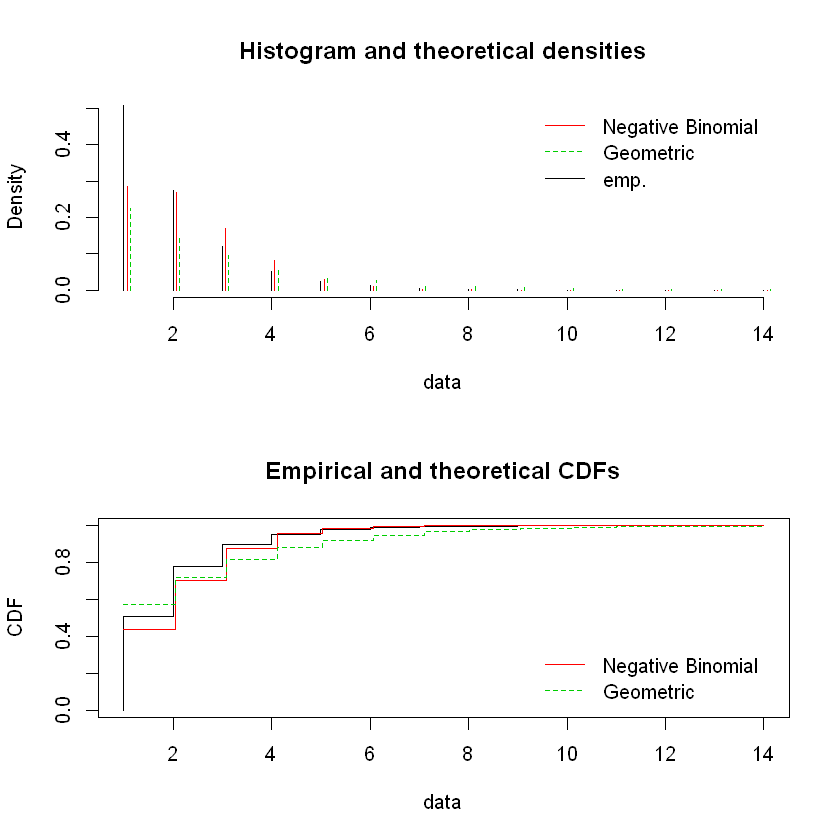

In [499]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dDec, LOfd_GE_dDec), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dDec, LOfd_GE_dDec), legendtext=plot.legend )

In [500]:
LOstatRes <- gofstat( list(LOfd_NB_dDec, LOfd_GE_dDec), fitnames=c("Negative Binomial", "Geometric") )

In [501]:
print( LOstatRes )

Chi-squared statistic:  68365.13 187287.2 
Degree of freedom of the Chi-squared distribution:  6 7 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    555150            476136.3515      624973.84
<= 2    299372            294937.9462      161744.20
<= 3    130349            186130.7515      105833.38
<= 4     57853             88098.3706       69249.49
<= 5     26670             33358.6611       45311.72
<= 6     13489             10526.1390       29648.62
<= 7      5108              2846.9760       19399.85
<= 8      3071               673.7636       12693.82
> 8       1821               174.0405       24028.08

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           3385313   4076740
Bayesian Information Criterion           3385337   4076752


In [502]:
LOfdNB_dDec_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [503]:
LOfdNB_dDec_p = LOfdNB_dDec_size / (LOfdNB_dDec_size + LOfdNB_dDec_mu)
cat("LOCA prob: ", LOfdNB_dDec_p)

LOCA prob:  0.9999956

In [504]:
# add to our tracking dataframe
LOMonDistDF[12, ] <- list( 12, dLODecMean, dLODecBNr, LOfdNB_dDec_p, LOfdNB_dDec_mu, LOfdNB_dDec_size,
                           LOfdNB_dDec_pvalue )

In [505]:
LOgf_dDec <- goodfit( dLODec$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dDec_size, prob=LOfdNB_dDec_p) )

In [506]:
summary( LOgf_dDec )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          558917.5 14        0
Likelihood Ratio 528572.6 13        0


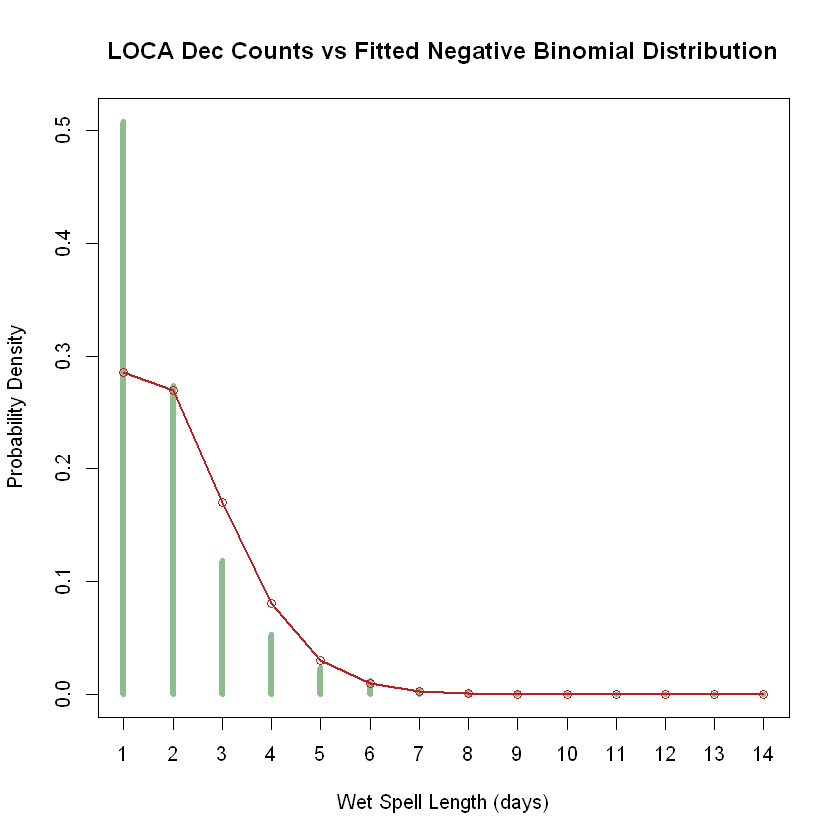

In [507]:
maxP <- max(dLODec$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dDec_size, mu=LOfdNB_dDec_mu )
ttab <- table( dLODec$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Dec Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

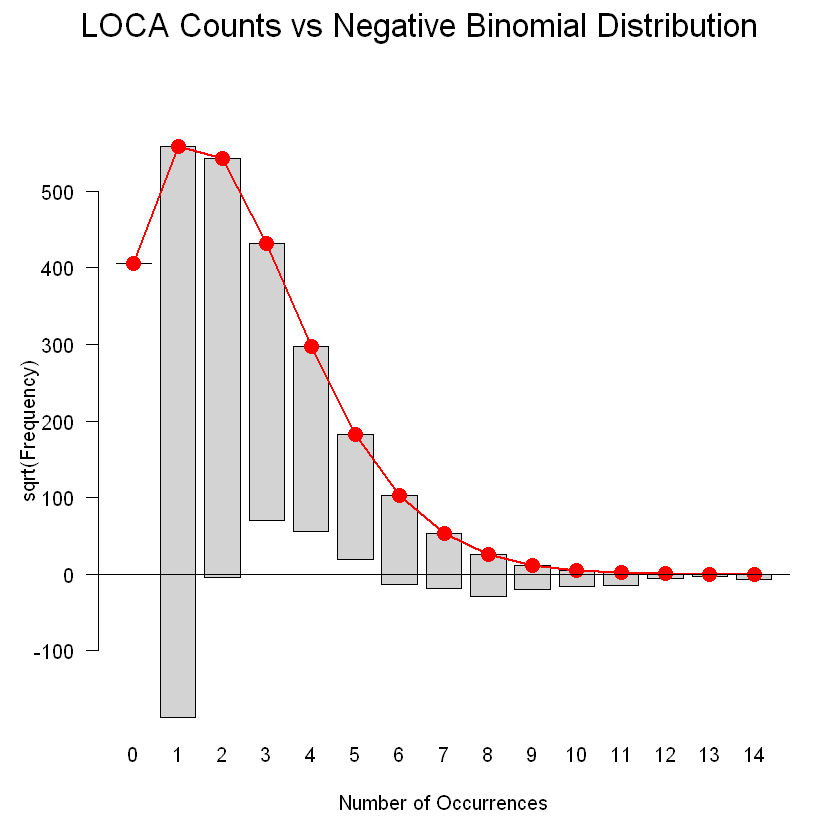

In [508]:
plot( LOgf_dDec, main="LOCA Counts vs Negative Binomial Distribution" )

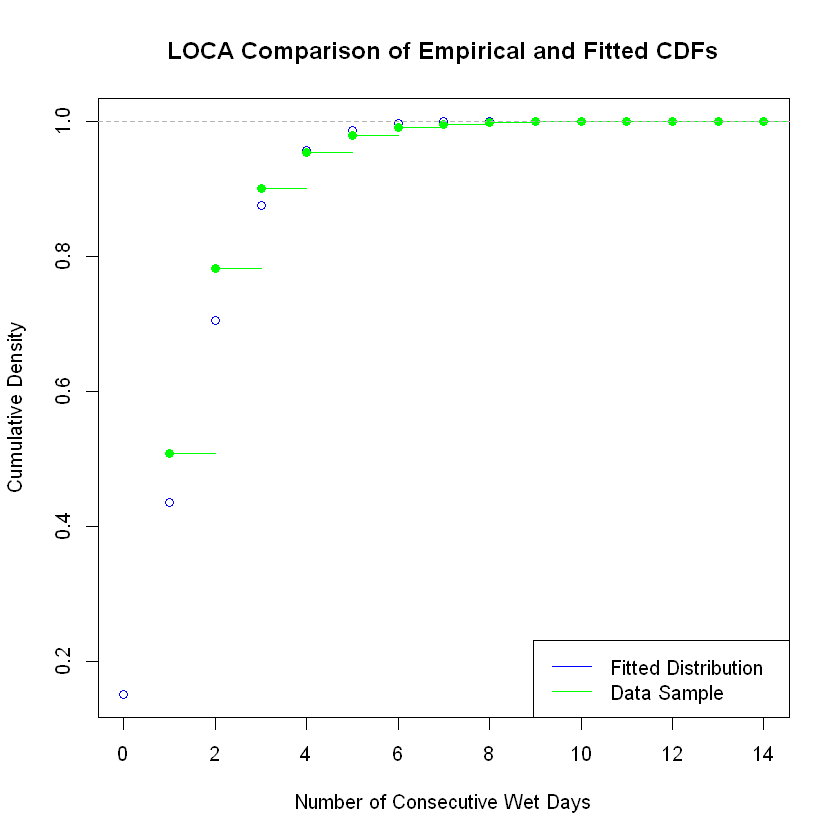

In [509]:
x <- seq(0,dLODecMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dDec_mu, size=LOfdNB_dDec_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLODec$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

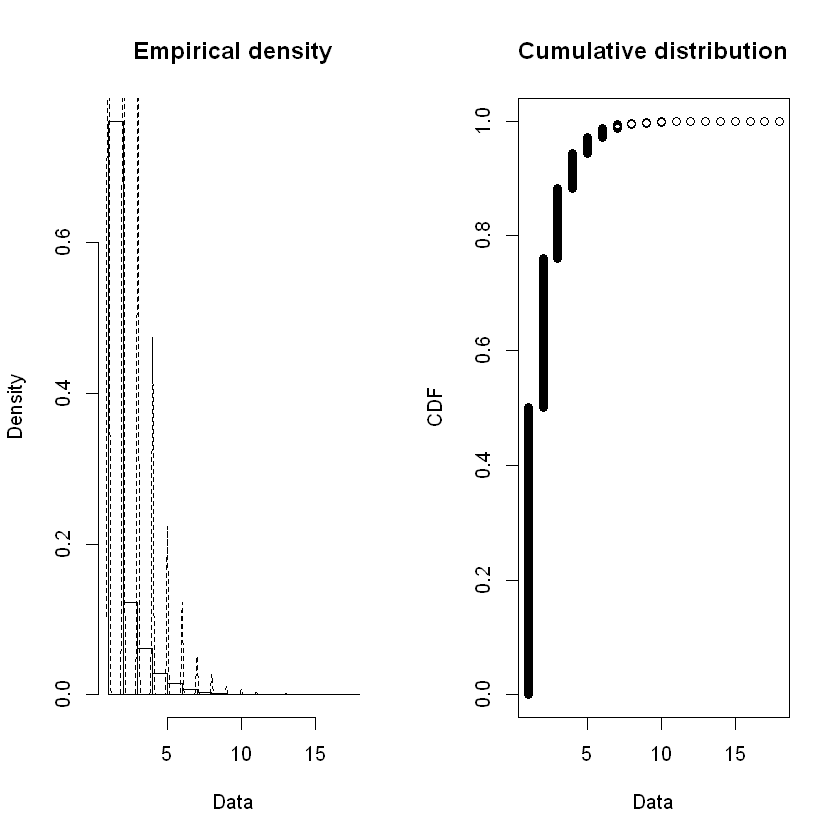

In [510]:
plotdist( dBCDec$Wet_Count, histo=TRUE, demp=TRUE )

In [511]:
BCfd_NB_dDec <- fitdist( dBCDec$Wet_Count, "nbinom" )
BCfd_GE_dDec <- fitdist( dBCDec$Wet_Count, "geom" )

In [512]:
summary( BCfd_NB_dDec )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
         estimate  Std. Error
size 8.168403e+05         NaN
mu   1.963974e+00 0.001707192
Loglikelihood:  -1079276   AIC:  2158556   BIC:  2158579 
Correlation matrix:
     size  mu
size    1 NaN
mu    NaN   1


In [513]:
BCfdNB_dDec_size <- BCfd_NB_dDec$estimate[["size"]]
BCfdNB_dDec_mu <- BCfd_NB_dDec$estimate[["mu"]]
cat("BCCA Dec size: ", BCfdNB_dDec_size, "\n", "BCCA Dec mu: ", BCfdNB_dDec_mu, "\n")

BCCA Dec size:  816840.3 
 BCCA Dec mu:  1.963974 


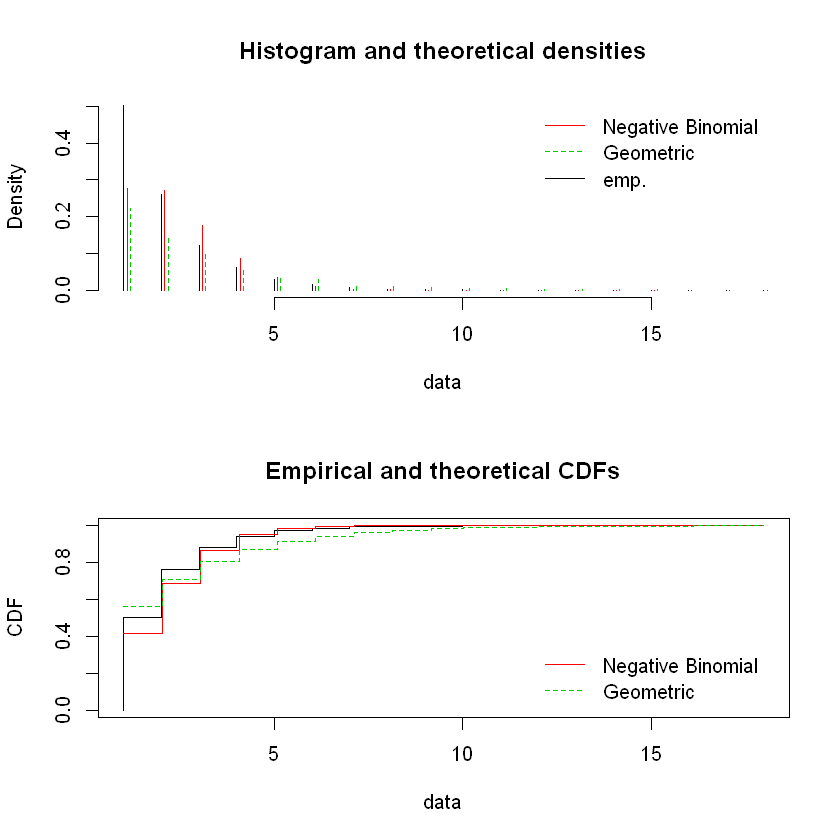

In [514]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dDec, BCfd_GE_dDec), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dDec, BCfd_GE_dDec), legendtext=plot.legend )

In [515]:
BCstatRes <- gofstat( list(BCfd_NB_dDec, BCfd_GE_dDec), fitnames=c("Negative Binomial", "Geometric") )

In [516]:
print(BCstatRes)

Chi-squared statistic:  63606.8 95099.18 
Degree of freedom of the Chi-squared distribution:  6 7 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    338081            280242.2423      378037.72
<= 2    174837            182347.4817       99827.42
<= 3     82037            119375.2332       66145.61
<= 4     40979             58612.5332       43828.06
<= 5     19225             23022.7538       29040.45
<= 6     10072              7536.0424       19242.19
<= 7      4532              2114.3805       12749.87
<= 8      2129               519.0767        8448.06
> 8       2018               140.2564       16590.62

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2158556   2553811
Bayesian Information Criterion           2158579   2553822


In [517]:
BCfdNB_dDec_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [518]:
BCfdNB_dDec_p = BCfdNB_dDec_size / (BCfdNB_dDec_size + BCfdNB_dDec_mu)
cat("BCCA prob: ", BCfdNB_dDec_p)

BCCA prob:  0.9999976

In [519]:
# add to our tracking dataframe
BCMonDistDF[12, ] <- list( 12, dBCDecMean, dBCDecBNr, BCfdNB_dDec_p, BCfdNB_dDec_mu, BCfdNB_dDec_size,
                           BCfdNB_dDec_pvalue )

In [520]:
BCgf_dDec <- goodfit( dBCDec$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dDec_size, prob=BCfdNB_dDec_p) )

In [521]:
summary( BCgf_dDec )


	 Goodness-of-fit test for nbinomial distribution

                        X^2 df P(> X^2)
Pearson          15189391.1 18        0
Likelihood Ratio   324883.7 17        0


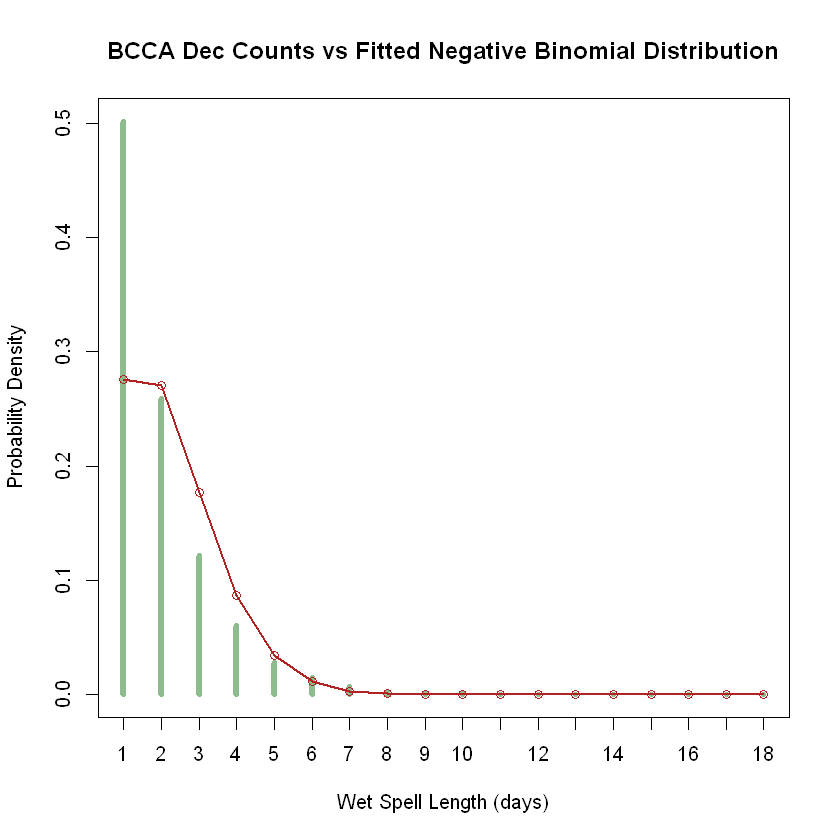

In [522]:
maxP <- max(dBCDec$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dDec_size, mu=BCfdNB_dDec_mu )
ttab <- table( dBCDec$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Dec Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

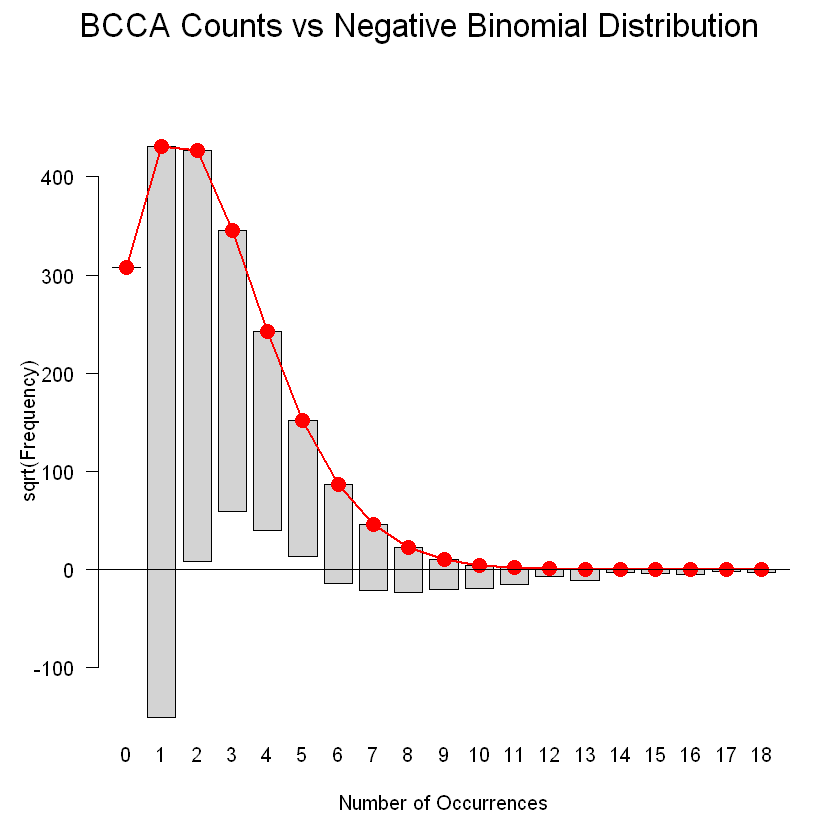

In [523]:
plot( BCgf_dDec, main="BCCA Counts vs Negative Binomial Distribution" )

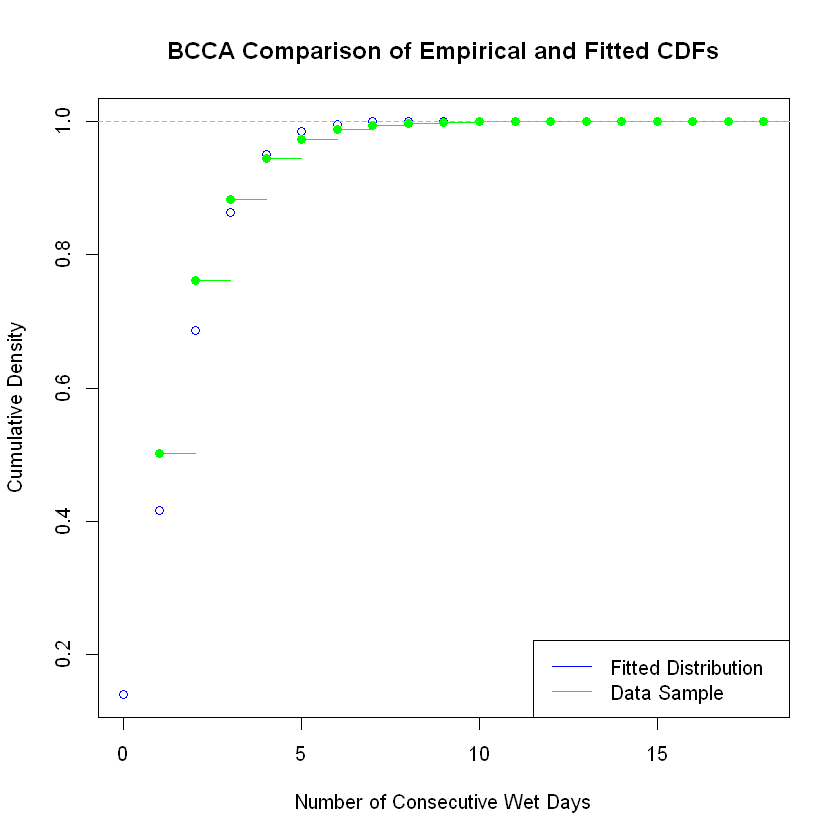

In [524]:
x <- seq(0,dBCDecMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dDec_mu, size=BCfdNB_dDec_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCDec$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Look at our summary DataFrame

In [525]:
print( LOMonDistDF, quote=FALSE, row.names=FALSE )

 month      smu      ssize     sprob      tmu        tsize pvalue
     1 1.862078   7.215064 0.9999927 1.862262 2.535299e+05      0
     2 1.986150  11.283718 0.9999998 1.986097 8.404404e+06      0
     3 1.894751  12.939019 0.9999994 1.894854 3.416294e+06      0
     4 2.301874   5.963750 0.8195557 2.301808 1.045453e+01      0
     5 2.692112   3.264539 0.6635055 2.691926 5.307985e+00      0
     6 2.915002   2.580594 0.5877669 2.915073 4.156345e+00      0
     7 2.626201   2.607539 0.6281760 2.626236 4.436880e+00      0
     8 2.621325   3.018100 0.6527198 2.620971 4.926165e+00      0
     9 2.929591   2.758973 0.5900714 2.929320 4.216608e+00      0
    10 2.497473   6.716813 0.8030499 2.497329 1.018268e+01      0
    11 2.108261 667.340278 0.9979947 2.108293 1.049268e+03      0
    12 1.892896  10.917447 0.9999956 1.893253 4.331823e+05      0


In [526]:
print( BCMonDistDF, quote=FALSE, row.names=FALSE )

 month      smu     ssize     sprob      tmu        tsize pvalue
     1 1.993002 79.414175 0.9999936 1.992670 3.090442e+05      0
     2 2.036637 65.707221 0.9999926 2.036861 2.743411e+05      0
     3 2.026520 27.861059 0.9608816 2.026625 4.978087e+01      0
     4 2.462707  2.160967 0.6364789 2.462660 4.311802e+00      0
     5 3.192043  1.457214 0.4420221 3.191634 2.528366e+00      0
     6 2.874320  1.611180 0.4944384 2.874571 2.811326e+00      0
     7 2.669911  1.509936 0.5230232 2.669843 2.927585e+00      0
     8 2.879676  1.514489 0.4845194 2.879949 2.706971e+00      0
     9 3.055407  1.918849 0.4932561 3.055099 2.973783e+00      0
    10 2.488294  3.224386 0.6819365 2.488041 5.334425e+00      0
    11 2.051385 78.410626 0.9845397 2.051531 1.306455e+02      0
    12 1.963838 32.639207 0.9999976 1.963974 8.168403e+05      0


### Output to a Spreadsheet

Output the stats and distribution fits to a spreadsheet

In [527]:
outputDF_xlsx <- createWorkbook()

In [528]:
LOsumstat_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="LOCA_Summary_Stats")
BCsumstat_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="BCCA_Summary_Stats")
LOmondist_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="LOCA_Dist_Properties")
BCmondist_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="BCCA_Dist_Properties")

In [529]:
addDataFrame( x=MonLOSumStatDF, sheet=LOsumstat_xlsx )
addDataFrame( x=MonBCSumStatDF, sheet=BCsumstat_xlsx )
addDataFrame( x=LOMonDistDF, sheet=LOmondist_xlsx )
addDataFrame( x=BCMonDistDF, sheet=BCmondist_xlsx )

In [530]:
saveWorkbook( outputDF_xlsx, file="CMIP5_Wet_RSummary_1981-2010.xlsx" )

## Check that No Grid Cell Outliers

Check that there are not any grid cell outliers. This part will take a long time so may need to split it out to a standalone R script. This also does not make sense so removed.

In [531]:
options(warn = oldw)